# Import Libraries and Read CSVs

In [292]:
# General
import numpy as np
import pandas as pd
import random
import re 
import time
from datetime import datetime
from tqdm import tqdm
from collections import Counter
from joblib import dump, load
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import shap

# Hypothesis Testing
import scipy.stats as stats

# Machine Learning
from sklearn.preprocessing import (OneHotEncoder, RobustScaler)
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import (train_test_split, GridSearchCV, StratifiedKFold)
from imblearn.under_sampling import (RandomUnderSampler, NearMiss, ClusterCentroids)
from sklearn.neighbors import (KNeighborsClassifier, NearestNeighbors)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, 
                              AdaBoostClassifier, ExtraTreesClassifier)
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report)

In [2]:
# Read all_loans.csv
df_all_loans = pd.read_csv('Dataset/all_loans.csv')

# Read ph_loans_cleaned.csv
df_ph_loans_cleaned = pd.read_csv('Dataset/ph_loans_cleaned.csv')

---

# Dimensionality Reduction Tests

In [3]:
# 1. Copy df_ph_loans_cleaned to df_ph and get info
df_ph = df_ph_loans_cleaned.copy(deep=True)
df_ph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378580 entries, 0 to 378579
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype              
---  ------                           --------------   -----              
 0   loan_id                          378580 non-null  object             
 1   group_loan                       378580 non-null  int64              
 2   with_image                       378580 non-null  int64              
 3   with_video                       378580 non-null  int64              
 4   posted_time                      378580 non-null  datetime64[ns, UTC]
 5   is_expired                       378580 non-null  int64              
 6   loan_amount                      378580 non-null  float64            
 7   loan_amount_bin                  378580 non-null  object             
 8   personal_use                     378580 non-null  int64              
 9   sector_name                      378580 non-null  object   

In [4]:
# 2. Check if there are nulls in each column
df_ph.isna().sum()

loan_id                                0
group_loan                             0
with_image                             0
with_video                             0
posted_time                            0
is_expired                             0
loan_amount                            0
loan_amount_bin                        0
personal_use                           0
sector_name                            0
loan_use                             631
num_days_to_fully_fund              5030
funded_14_days_and_above           28659
partner_id                             0
repayment_term_16_mos_and_above        0
repayment_interval                     0
partner_covers_currency_loss           0
country_name                           0
dtype: int64

In [5]:
# 3. Change null to 1000 (TruncatedSVD and KNeighborsClassifier does not accept missing values)
df_ph['loan_use'].fillna('1000', inplace=True)
df_ph['num_days_to_fully_fund'].fillna(1000, inplace=True)
df_ph['funded_14_days_and_above'].fillna(1000, inplace=True)
df_ph.isna().sum()

loan_id                            0
group_loan                         0
with_image                         0
with_video                         0
posted_time                        0
is_expired                         0
loan_amount                        0
loan_amount_bin                    0
personal_use                       0
sector_name                        0
loan_use                           0
num_days_to_fully_fund             0
funded_14_days_and_above           0
partner_id                         0
repayment_term_16_mos_and_above    0
repayment_interval                 0
partner_covers_currency_loss       0
country_name                       0
dtype: int64

## Baseline Models using PH Raw Dataset
This is based on the raw dataset. Keep all columns as much as possible.

In [302]:
# 1. Copy df_all_loans to df_all and get info
df_all = df_all_loans.copy(deep=True)
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2187819 entries, 0 to 2187818
Data columns (total 31 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   LOAN_ID                          int64  
 1   LOAN_NAME                        object 
 2   FUNDED_AMOUNT                    float64
 3   LOAN_AMOUNT                      float64
 4   STATUS                           object 
 5   IMAGE_ID                         float64
 6   VIDEO_ID                         float64
 7   ACTIVITY_NAME                    object 
 8   SECTOR_NAME                      object 
 9   LOAN_USE                         object 
 10  COUNTRY_CODE                     object 
 11  COUNTRY_NAME                     object 
 12  TOWN_NAME                        object 
 13  CURRENCY_POLICY                  object 
 14  CURRENCY_EXCHANGE_COVERAGE_RATE  float64
 15  CURRENCY                         object 
 16  PARTNER_ID                       int64  
 17  POSTED_T

In [30]:
# 2. Convert column names to lowercase
df_all.columns = df_all.columns.str.lower()

In [31]:
# 3. Convert time-related columns to datetime 
df_all['posted_time'] = pd.to_datetime(df_all['posted_time'])
df_all['planned_expiration_time'] = pd.to_datetime(df_all['planned_expiration_time'])
df_all['disburse_time'] = pd.to_datetime(df_all['disburse_time'])
df_all['raised_time'] = pd.to_datetime(df_all['raised_time'])

In [32]:
# 4. Feature engineer posted_year
df_all['posted_year'] = df_all['posted_time'].dt.year

In [33]:
# 5. Define scope and limitations (PH loans, 2014-2021) and get shape
df_ph = df_all[df_all['country_name']=='Philippines']
df_ph = df_ph[(df_ph['posted_year'] >= 2014) & (df_ph['posted_year'] <= 2021)]
df_ph.shape

(378580, 32)

In [34]:
# 6. Check nulls
# NOTE: the goal of baseline modeling is to keep as much information as possible
#       the he issue of high dimensionality will be addressed with dimensionality reduction techniques 
#       like PCA, SVD & tSNE
#     : however, dimensionality reduction techniques require: (1) numerical information and (2) no null values
#     : to address issues, additional preprocessing is done to the dataset
df_ph.isna().sum().sort_values(ascending=False)

video_id                           378579
tags                               156703
currency_exchange_coverage_rate    104398
raised_time                          4993
town_name                             632
borrower_names                        631
loan_name                             631
loan_use                              631
borrower_genders                      631
image_id                              631
borrower_pictured                     631
disburse_time                           0
num_bulk_entries                        0
num_journal_entries                     0
repayment_interval                      0
num_lenders_total                       0
distribution_model                      0
lender_term                             0
loan_id                                 0
partner_id                              0
planned_expiration_time                 0
posted_time                             0
currency                                0
currency_policy                   

In [36]:
# 7. Convert image_id & video_id to binary
df_ph['with_image'] = df_ph['image_id'].notna().astype(int)
df_ph['with_video'] = df_ph['video_id'].notna().astype(int)

In [37]:
# 8. Impute null values in currency_exchange_coverage_rate with 0
# NOTE: followed an empirical approach based on prior analyses of the Kiva dataset, 
#       suggesting a tendency for MFIs to not cover such losses...hence, imputing missing values with 0
df_ph['currency_exchange_coverage_rate'] = df_ph['currency_exchange_coverage_rate'].fillna(0)

In [38]:
# 9. Drop rows in chosen columns then check shape
df_ph.dropna(subset=['borrower_genders', 'town_name'], inplace=True)
df_ph.shape

(377948, 34)

In [39]:
# 10. Convert status to binary...expired cases are the minority/positive class
df_ph['is_expired'] = df_ph['status'].replace({'expired': 1, 
                                               'refunded': 1, 
                                               'fundRaising': 1,
                                               'funded': 0})

In [40]:
# 11. Convert gender to binary
gender_dict = {'female': 1,
               'male': 0}

def gender_reassign(lst):
    numeric_gender = [gender_dict.get(s.lower(), s) for s in lst]
    return int(any(x == 1 for x in numeric_gender))

df_ph['borrower_genders'] = df_ph['borrower_genders'].apply(gender_reassign)

In [41]:
# 12. Get no. of days between posted and planned_expiration
df_ph['expiration_term'] = (df_ph['planned_expiration_time'] - df_ph['posted_time']).dt.days

In [42]:
# 13. Get no. of days between posted and disbursed (Do lenders prioritize loans that have been disbursed?)
df_ph['when_disbursed'] = (df_ph['posted_time'] - df_ph['disburse_time']).dt.days

In [43]:
# 14. Get no. of days between posted and raised, for nulls use 1000
df_ph['days_raised'] = (df_ph['raised_time'] - df_ph['posted_time']).dt.days
df_ph['days_raised'].fillna(1000, inplace=True)
df_ph['days_raised'].isna().sum()

0

In [44]:
# 15. Classify whether borrower is group or individual
df_group = df_ph[df_ph['loan_name'].str.lower().str.contains('group', na=False)]
df_no_group = df_ph[~df_ph['loan_name'].str.lower().str.contains('group', na=False)]
df_group_indices = df_group.index.tolist()
df_no_group_indices = df_no_group.index.tolist()
df_ph.loc[df_group_indices, 'group_loan'] = 1
df_ph.loc[df_no_group_indices, 'group_loan'] = 0

In [45]:
# 16. Drop irrelevant columns
# NOTE: initially planned on keeping town_name but it resulted in 5000+ rows after One-Hot Encoding...
#       computer cannot handle concatenating 5000+ columns, hence, decided to drop town_name
drop_cols = ['loan_id', 'loan_name', 'status','image_id', 'video_id', 'loan_use',
             'country_code', 'country_name', 'partner_id',
             'posted_time', 'planned_expiration_time', 'disburse_time','raised_time',
             'tags', 'borrower_names','borrower_pictured', 'town_name', 'distribution_model']

df_ph = df_ph.drop(columns=drop_cols)

In [46]:
# 17. Copy df_ph to df_ph_model_baseline_raw
df_ph_model_baseline_raw = df_ph.copy(deep=True)

In [48]:
# 18. One-Hot-Encode remaining categorical columns and make it into a dataframe
encoder = OneHotEncoder(sparse=False)
cat_cols = df_ph_model_baseline_raw.select_dtypes(include='object').columns
cat_encoded = encoder.fit_transform(df_ph_model_baseline_raw[cat_cols])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(cat_cols))

In [49]:
# 19. Reset the index then concatenate df_ph_model_baseline_cleaned and cat_encoded_df, drop the original cateorical columns
df_ph_model_baseline_raw.reset_index(drop=True, inplace=True)
cat_encoded_df.reset_index(drop=True, inplace=True)

base_model = pd.concat([df_ph_model_baseline_raw, cat_encoded_df], axis=1)
base_model = base_model.drop(columns=cat_cols)
base_model.shape

(377948, 196)

In [10]:
# 20. Save base_model as csv 
base_model.to_csv('baseline_models_raw_df.csv', index=False)

In [50]:
# 21. TrainVal-Holdout Split (features:X, target:y)
X = base_model.drop(columns=['is_expired']) 
y = base_model['is_expired']               

X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(X,y,
                                                                random_state=42,
                                                                test_size = 0.25,
                                                                stratify=y)

In [51]:
# 22. Define the auto_ml function
def auto_ml(X, y, models_dict, scaler=None, svd=None, cv=None, res_t=None):
    
    results_decimal = {}
    results_percentage = {}

    for model_name, model in tqdm(models_dict.items(), desc="Running Models"):
        
        # Enter the metrics to be evaluated below:
        train_accuracy = []
        val_accuracy = []

        train_precision = []
        val_precision = []
        
        train_recall = []
        val_recall = []

        train_f1 = []
        val_f1 = []

        # For each model, do the following:
        for train_index, val_index in cv.split(X, y):

            # 1. Separate rows in trainval to train and val
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # 2. Apply scaling on features (X)
            #    -> no need to scale the target since these are fixed figures
            #    -> apply this to X_train and X_val
            #    -> fit_transform is applied to X_train only
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # 3. Apply dimensionality-reduction on highly-dimensional data
            #    -> from our correlation matrix, we discovered that there is a weak relationship 
            #       between the features and target (is_expired)...thus, the dimensionality-reduction technique 
            #       employed should be non-linear such as Singular Value Decomposition, we used TruncatedSVD
            #    -> apply this to X_train and X_val
            #    -> fit_transform is applied to X_train only
            if svd is not None:
                X_train = svd.fit_transform(X_train)
                X_val = svd.transform(X_val)
            else:
                pass

            # 4. Apply resampling on highly-imbalanced data
            #    -> resample the TRAIN data only, validation is what it is, we are trying to validate our train findings
            #    -> apply this to X_train and y_train
            if res_t is not None:
                X_train, y_train = res_t.fit_resample(X_train, y_train)
            else:
                pass

            # 5. Record start_time before model fit and predict
            start_time = time.time()

            # 6. Fit the model
            model.fit(X_train, y_train)

            # 7. Use the model to predict the target
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            # 8.Record end_time after model fit and predict
            end_time = time.time() 

            # 9. Record Evaluation Metric Scores
            #### accuracy ####
            train_accuracy.append(accuracy_score(y_train, train_preds))
            val_accuracy.append(accuracy_score(y_val, val_preds))

            #### precision ####
            train_precision.append(precision_score(y_train, train_preds))
            val_precision.append(precision_score(y_val, val_preds))
            
            #### recall ####
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))
            
            #### f1 ####
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))

            # 10. Store results 
            #### in decimal ####
            results_decimal[model_name] = {
                'Train Accuracy': np.round(np.mean(train_accuracy) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_accuracy) * 100, 2),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train F1': np.round(np.mean(train_f1) * 100, 2),
                'Val F1': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }
            
            #### in percentage ####
            results_percentage[model_name] = { 
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_accuracy) * 100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_accuracy) * 100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_precision) * 100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_precision) * 100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall) * 100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall) * 100, 2)),
                'Train F1': '{:.2f}%'.format(np.round(np.mean(train_f1) * 100, 2)),
                'Val F1': '{:.2f}%'.format(np.round(np.mean(val_f1) * 100, 2)),
                'Run Time': end_time - start_time
            }

    results_decimal = pd.DataFrame(results_decimal).T  # access it by using [0]
    results_percentage = pd.DataFrame(results_percentage).T  # access it by using [1]
    return [results_decimal, results_percentage]

In [52]:
# 23. Choose best no. of components for TruncatedSVD
# NOTE: from our correlation matrix, we discovered that there is a weak relationship 
#       between the features and target (is_expired)...
#       thus, the dimensionality reduction technique employed should be non-linear
#     : dimensionality reduction is applied only to the TRAIN set
#     : https://webcache.googleusercontent.com/search?q=cache:https://towardsdatascience.com/11-dimensionality-reduction-techniques-you-should-know-in-2021-dcb9500d388b&sca_esv=587597168&strip=1&vwsrc=0

param_grid = {
    'n_components': [5, 10, 20, 30, 40, 50]  # Adjust the range as needed
}

# Initialize TruncatedSVD
svd = TruncatedSVD()

# Perform a simple loop to find the best number of components
best_num_components = None
best_explained_variance = 0

for n_components in param_grid['n_components']:
    svd.n_components = n_components
    X_transformed = svd.fit_transform(X_trainval)
    explained_variance = svd.explained_variance_ratio_.sum()

    if explained_variance > best_explained_variance:
        best_explained_variance = explained_variance
        best_num_components = n_components

best_num_components

50

In [13]:
# 24. Initialize parameters then run the auto_ml function
models_dict = {
      'KNeighborsClassifier': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(random_state=42),
                'GaussianNB': GaussianNB(),
                       'SVC': SVC(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
        'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
      'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
             'XGBClassifier': XGBClassifier(random_state=42),
        'CatBoostClassifier': CatBoostClassifier(random_state=42),
            'LGBMClassifier': LGBMClassifier(random_state=42)
}
# scaler=MinMaxScaler()
scaler = RobustScaler()
svd = TruncatedSVD(n_components=best_num_components, random_state=42)
cv=StratifiedKFold(n_splits=5)

baseline_models = auto_ml(X_trainval, y_trainval, models_dict, scaler=scaler, svd=svd, cv=cv, res_t=None)

Running Models:  83%|███████████████████████████████████████████████████████           | 10/12 [46:11<02:15, 67.58s/it]

Learning rate set to 0.104491
0:	learn: 0.2995255	total: 379ms	remaining: 6m 18s
1:	learn: 0.1306394	total: 458ms	remaining: 3m 48s
2:	learn: 0.0568696	total: 526ms	remaining: 2m 54s
3:	learn: 0.0256209	total: 597ms	remaining: 2m 28s
4:	learn: 0.0122177	total: 664ms	remaining: 2m 12s
5:	learn: 0.0063316	total: 736ms	remaining: 2m 1s
6:	learn: 0.0034793	total: 792ms	remaining: 1m 52s
7:	learn: 0.0020221	total: 852ms	remaining: 1m 45s
8:	learn: 0.0012438	total: 907ms	remaining: 1m 39s
9:	learn: 0.0007259	total: 956ms	remaining: 1m 34s
10:	learn: 0.0004750	total: 1.03s	remaining: 1m 32s
11:	learn: 0.0003253	total: 1.1s	remaining: 1m 30s
12:	learn: 0.0002399	total: 1.17s	remaining: 1m 29s
13:	learn: 0.0001739	total: 1.24s	remaining: 1m 27s
14:	learn: 0.0001263	total: 1.32s	remaining: 1m 26s
15:	learn: 0.0001009	total: 1.39s	remaining: 1m 25s
16:	learn: 0.0000760	total: 1.47s	remaining: 1m 24s
17:	learn: 0.0000579	total: 1.52s	remaining: 1m 22s
18:	learn: 0.0000449	total: 1.58s	remaining: 1

165:	learn: 0.0000039	total: 8.59s	remaining: 43.1s
166:	learn: 0.0000039	total: 8.64s	remaining: 43.1s
167:	learn: 0.0000039	total: 8.69s	remaining: 43s
168:	learn: 0.0000039	total: 8.75s	remaining: 43s
169:	learn: 0.0000039	total: 8.81s	remaining: 43s
170:	learn: 0.0000039	total: 8.87s	remaining: 43s
171:	learn: 0.0000039	total: 8.93s	remaining: 43s
172:	learn: 0.0000039	total: 8.98s	remaining: 42.9s
173:	learn: 0.0000039	total: 9.04s	remaining: 42.9s
174:	learn: 0.0000039	total: 9.1s	remaining: 42.9s
175:	learn: 0.0000039	total: 9.15s	remaining: 42.9s
176:	learn: 0.0000039	total: 9.21s	remaining: 42.8s
177:	learn: 0.0000039	total: 9.27s	remaining: 42.8s
178:	learn: 0.0000039	total: 9.31s	remaining: 42.7s
179:	learn: 0.0000039	total: 9.34s	remaining: 42.6s
180:	learn: 0.0000039	total: 9.38s	remaining: 42.4s
181:	learn: 0.0000039	total: 9.41s	remaining: 42.3s
182:	learn: 0.0000039	total: 9.45s	remaining: 42.2s
183:	learn: 0.0000039	total: 9.48s	remaining: 42.1s
184:	learn: 0.0000039	t

327:	learn: 0.0000039	total: 14.7s	remaining: 30.2s
328:	learn: 0.0000039	total: 14.8s	remaining: 30.1s
329:	learn: 0.0000039	total: 14.8s	remaining: 30.1s
330:	learn: 0.0000039	total: 14.9s	remaining: 30s
331:	learn: 0.0000039	total: 14.9s	remaining: 30s
332:	learn: 0.0000039	total: 14.9s	remaining: 29.9s
333:	learn: 0.0000039	total: 15s	remaining: 29.8s
334:	learn: 0.0000039	total: 15s	remaining: 29.8s
335:	learn: 0.0000039	total: 15s	remaining: 29.7s
336:	learn: 0.0000039	total: 15.1s	remaining: 29.6s
337:	learn: 0.0000039	total: 15.1s	remaining: 29.6s
338:	learn: 0.0000039	total: 15.2s	remaining: 29.5s
339:	learn: 0.0000039	total: 15.2s	remaining: 29.5s
340:	learn: 0.0000039	total: 15.2s	remaining: 29.4s
341:	learn: 0.0000039	total: 15.3s	remaining: 29.4s
342:	learn: 0.0000039	total: 15.3s	remaining: 29.3s
343:	learn: 0.0000039	total: 15.4s	remaining: 29.3s
344:	learn: 0.0000039	total: 15.4s	remaining: 29.3s
345:	learn: 0.0000039	total: 15.5s	remaining: 29.3s
346:	learn: 0.0000039	

490:	learn: 0.0000039	total: 21.7s	remaining: 22.5s
491:	learn: 0.0000039	total: 21.8s	remaining: 22.5s
492:	learn: 0.0000039	total: 21.8s	remaining: 22.4s
493:	learn: 0.0000039	total: 21.9s	remaining: 22.4s
494:	learn: 0.0000039	total: 21.9s	remaining: 22.3s
495:	learn: 0.0000039	total: 21.9s	remaining: 22.3s
496:	learn: 0.0000039	total: 22s	remaining: 22.2s
497:	learn: 0.0000039	total: 22s	remaining: 22.2s
498:	learn: 0.0000039	total: 22s	remaining: 22.1s
499:	learn: 0.0000039	total: 22.1s	remaining: 22.1s
500:	learn: 0.0000039	total: 22.1s	remaining: 22s
501:	learn: 0.0000039	total: 22.1s	remaining: 22s
502:	learn: 0.0000039	total: 22.2s	remaining: 21.9s
503:	learn: 0.0000039	total: 22.2s	remaining: 21.9s
504:	learn: 0.0000039	total: 22.2s	remaining: 21.8s
505:	learn: 0.0000039	total: 22.3s	remaining: 21.7s
506:	learn: 0.0000039	total: 22.3s	remaining: 21.7s
507:	learn: 0.0000039	total: 22.3s	remaining: 21.6s
508:	learn: 0.0000039	total: 22.4s	remaining: 21.6s
509:	learn: 0.0000039	

653:	learn: 0.0000039	total: 27.6s	remaining: 14.6s
654:	learn: 0.0000039	total: 27.6s	remaining: 14.6s
655:	learn: 0.0000039	total: 27.7s	remaining: 14.5s
656:	learn: 0.0000039	total: 27.7s	remaining: 14.5s
657:	learn: 0.0000039	total: 27.8s	remaining: 14.4s
658:	learn: 0.0000039	total: 27.8s	remaining: 14.4s
659:	learn: 0.0000039	total: 27.8s	remaining: 14.3s
660:	learn: 0.0000039	total: 27.9s	remaining: 14.3s
661:	learn: 0.0000039	total: 27.9s	remaining: 14.2s
662:	learn: 0.0000039	total: 27.9s	remaining: 14.2s
663:	learn: 0.0000039	total: 28s	remaining: 14.1s
664:	learn: 0.0000039	total: 28s	remaining: 14.1s
665:	learn: 0.0000039	total: 28s	remaining: 14.1s
666:	learn: 0.0000039	total: 28.1s	remaining: 14s
667:	learn: 0.0000039	total: 28.1s	remaining: 14s
668:	learn: 0.0000039	total: 28.1s	remaining: 13.9s
669:	learn: 0.0000039	total: 28.2s	remaining: 13.9s
670:	learn: 0.0000039	total: 28.2s	remaining: 13.8s
671:	learn: 0.0000039	total: 28.3s	remaining: 13.8s
672:	learn: 0.0000039	

816:	learn: 0.0000039	total: 34.5s	remaining: 7.73s
817:	learn: 0.0000039	total: 34.5s	remaining: 7.68s
818:	learn: 0.0000039	total: 34.6s	remaining: 7.64s
819:	learn: 0.0000039	total: 34.6s	remaining: 7.59s
820:	learn: 0.0000039	total: 34.6s	remaining: 7.55s
821:	learn: 0.0000039	total: 34.7s	remaining: 7.5s
822:	learn: 0.0000039	total: 34.7s	remaining: 7.46s
823:	learn: 0.0000039	total: 34.8s	remaining: 7.43s
824:	learn: 0.0000039	total: 34.9s	remaining: 7.39s
825:	learn: 0.0000039	total: 34.9s	remaining: 7.35s
826:	learn: 0.0000039	total: 34.9s	remaining: 7.31s
827:	learn: 0.0000039	total: 35s	remaining: 7.27s
828:	learn: 0.0000039	total: 35s	remaining: 7.23s
829:	learn: 0.0000039	total: 35.1s	remaining: 7.18s
830:	learn: 0.0000039	total: 35.1s	remaining: 7.14s
831:	learn: 0.0000039	total: 35.2s	remaining: 7.1s
832:	learn: 0.0000039	total: 35.2s	remaining: 7.06s
833:	learn: 0.0000039	total: 35.3s	remaining: 7.02s
834:	learn: 0.0000039	total: 35.3s	remaining: 6.98s
835:	learn: 0.0000

975:	learn: 0.0000039	total: 42s	remaining: 1.03s
976:	learn: 0.0000039	total: 42.1s	remaining: 990ms
977:	learn: 0.0000039	total: 42.1s	remaining: 948ms
978:	learn: 0.0000039	total: 42.2s	remaining: 905ms
979:	learn: 0.0000039	total: 42.3s	remaining: 863ms
980:	learn: 0.0000039	total: 42.3s	remaining: 820ms
981:	learn: 0.0000039	total: 42.4s	remaining: 778ms
982:	learn: 0.0000039	total: 42.5s	remaining: 735ms
983:	learn: 0.0000039	total: 42.6s	remaining: 692ms
984:	learn: 0.0000039	total: 42.6s	remaining: 649ms
985:	learn: 0.0000039	total: 42.7s	remaining: 606ms
986:	learn: 0.0000039	total: 42.7s	remaining: 563ms
987:	learn: 0.0000039	total: 42.8s	remaining: 520ms
988:	learn: 0.0000039	total: 42.8s	remaining: 476ms
989:	learn: 0.0000039	total: 42.9s	remaining: 433ms
990:	learn: 0.0000039	total: 42.9s	remaining: 390ms
991:	learn: 0.0000039	total: 43s	remaining: 346ms
992:	learn: 0.0000039	total: 43.1s	remaining: 304ms
993:	learn: 0.0000039	total: 43.2s	remaining: 261ms
994:	learn: 0.00

138:	learn: 0.0000037	total: 7.91s	remaining: 49s
139:	learn: 0.0000037	total: 7.94s	remaining: 48.8s
140:	learn: 0.0000037	total: 7.97s	remaining: 48.5s
141:	learn: 0.0000037	total: 8s	remaining: 48.3s
142:	learn: 0.0000037	total: 8.03s	remaining: 48.1s
143:	learn: 0.0000037	total: 8.07s	remaining: 48s
144:	learn: 0.0000037	total: 8.1s	remaining: 47.8s
145:	learn: 0.0000037	total: 8.14s	remaining: 47.6s
146:	learn: 0.0000037	total: 8.18s	remaining: 47.5s
147:	learn: 0.0000037	total: 8.21s	remaining: 47.3s
148:	learn: 0.0000037	total: 8.24s	remaining: 47.1s
149:	learn: 0.0000037	total: 8.27s	remaining: 46.9s
150:	learn: 0.0000037	total: 8.31s	remaining: 46.7s
151:	learn: 0.0000037	total: 8.35s	remaining: 46.6s
152:	learn: 0.0000037	total: 8.4s	remaining: 46.5s
153:	learn: 0.0000037	total: 8.44s	remaining: 46.4s
154:	learn: 0.0000037	total: 8.48s	remaining: 46.2s
155:	learn: 0.0000037	total: 8.52s	remaining: 46.1s
156:	learn: 0.0000037	total: 8.55s	remaining: 45.9s
157:	learn: 0.0000037

301:	learn: 0.0000036	total: 15s	remaining: 34.6s
302:	learn: 0.0000036	total: 15s	remaining: 34.6s
303:	learn: 0.0000036	total: 15.1s	remaining: 34.5s
304:	learn: 0.0000036	total: 15.1s	remaining: 34.4s
305:	learn: 0.0000036	total: 15.1s	remaining: 34.3s
306:	learn: 0.0000036	total: 15.1s	remaining: 34.2s
307:	learn: 0.0000036	total: 15.2s	remaining: 34.1s
308:	learn: 0.0000036	total: 15.2s	remaining: 34s
309:	learn: 0.0000036	total: 15.2s	remaining: 33.9s
310:	learn: 0.0000036	total: 15.3s	remaining: 33.8s
311:	learn: 0.0000036	total: 15.3s	remaining: 33.7s
312:	learn: 0.0000036	total: 15.3s	remaining: 33.6s
313:	learn: 0.0000036	total: 15.4s	remaining: 33.5s
314:	learn: 0.0000036	total: 15.4s	remaining: 33.5s
315:	learn: 0.0000036	total: 15.4s	remaining: 33.4s
316:	learn: 0.0000036	total: 15.4s	remaining: 33.3s
317:	learn: 0.0000036	total: 15.5s	remaining: 33.2s
318:	learn: 0.0000036	total: 15.5s	remaining: 33.1s
319:	learn: 0.0000036	total: 15.5s	remaining: 33s
320:	learn: 0.000003

461:	learn: 0.0000036	total: 21.2s	remaining: 24.7s
462:	learn: 0.0000036	total: 21.3s	remaining: 24.7s
463:	learn: 0.0000036	total: 21.3s	remaining: 24.6s
464:	learn: 0.0000036	total: 21.3s	remaining: 24.6s
465:	learn: 0.0000036	total: 21.4s	remaining: 24.5s
466:	learn: 0.0000036	total: 21.4s	remaining: 24.4s
467:	learn: 0.0000036	total: 21.5s	remaining: 24.4s
468:	learn: 0.0000036	total: 21.5s	remaining: 24.3s
469:	learn: 0.0000036	total: 21.5s	remaining: 24.3s
470:	learn: 0.0000036	total: 21.6s	remaining: 24.2s
471:	learn: 0.0000036	total: 21.6s	remaining: 24.2s
472:	learn: 0.0000036	total: 21.7s	remaining: 24.1s
473:	learn: 0.0000036	total: 21.7s	remaining: 24.1s
474:	learn: 0.0000036	total: 21.7s	remaining: 24s
475:	learn: 0.0000036	total: 21.8s	remaining: 24s
476:	learn: 0.0000036	total: 21.8s	remaining: 23.9s
477:	learn: 0.0000036	total: 21.9s	remaining: 23.9s
478:	learn: 0.0000036	total: 21.9s	remaining: 23.8s
479:	learn: 0.0000036	total: 21.9s	remaining: 23.8s
480:	learn: 0.00

622:	learn: 0.0000036	total: 28.9s	remaining: 17.5s
623:	learn: 0.0000036	total: 29s	remaining: 17.5s
624:	learn: 0.0000036	total: 29.1s	remaining: 17.4s
625:	learn: 0.0000036	total: 29.2s	remaining: 17.4s
626:	learn: 0.0000036	total: 29.3s	remaining: 17.4s
627:	learn: 0.0000036	total: 29.4s	remaining: 17.4s
628:	learn: 0.0000036	total: 29.4s	remaining: 17.4s
629:	learn: 0.0000036	total: 29.5s	remaining: 17.3s
630:	learn: 0.0000036	total: 29.5s	remaining: 17.3s
631:	learn: 0.0000036	total: 29.6s	remaining: 17.2s
632:	learn: 0.0000036	total: 29.6s	remaining: 17.2s
633:	learn: 0.0000036	total: 29.7s	remaining: 17.1s
634:	learn: 0.0000036	total: 29.7s	remaining: 17.1s
635:	learn: 0.0000036	total: 29.8s	remaining: 17s
636:	learn: 0.0000036	total: 29.8s	remaining: 17s
637:	learn: 0.0000036	total: 29.8s	remaining: 16.9s
638:	learn: 0.0000036	total: 29.9s	remaining: 16.9s
639:	learn: 0.0000036	total: 29.9s	remaining: 16.8s
640:	learn: 0.0000036	total: 30s	remaining: 16.8s
641:	learn: 0.000003

782:	learn: 0.0000036	total: 35.6s	remaining: 9.88s
783:	learn: 0.0000036	total: 35.7s	remaining: 9.84s
784:	learn: 0.0000036	total: 35.8s	remaining: 9.8s
785:	learn: 0.0000036	total: 35.8s	remaining: 9.75s
786:	learn: 0.0000036	total: 35.9s	remaining: 9.71s
787:	learn: 0.0000036	total: 35.9s	remaining: 9.66s
788:	learn: 0.0000036	total: 36s	remaining: 9.61s
789:	learn: 0.0000036	total: 36s	remaining: 9.57s
790:	learn: 0.0000036	total: 36s	remaining: 9.52s
791:	learn: 0.0000036	total: 36.1s	remaining: 9.47s
792:	learn: 0.0000036	total: 36.1s	remaining: 9.43s
793:	learn: 0.0000036	total: 36.2s	remaining: 9.39s
794:	learn: 0.0000036	total: 36.2s	remaining: 9.34s
795:	learn: 0.0000036	total: 36.3s	remaining: 9.3s
796:	learn: 0.0000036	total: 36.3s	remaining: 9.25s
797:	learn: 0.0000036	total: 36.4s	remaining: 9.21s
798:	learn: 0.0000036	total: 36.4s	remaining: 9.17s
799:	learn: 0.0000036	total: 36.5s	remaining: 9.12s
800:	learn: 0.0000036	total: 36.5s	remaining: 9.07s
801:	learn: 0.000003

946:	learn: 0.0000036	total: 42.1s	remaining: 2.35s
947:	learn: 0.0000036	total: 42.1s	remaining: 2.31s
948:	learn: 0.0000036	total: 42.2s	remaining: 2.27s
949:	learn: 0.0000036	total: 42.2s	remaining: 2.22s
950:	learn: 0.0000036	total: 42.2s	remaining: 2.18s
951:	learn: 0.0000036	total: 42.3s	remaining: 2.13s
952:	learn: 0.0000036	total: 42.3s	remaining: 2.09s
953:	learn: 0.0000036	total: 42.3s	remaining: 2.04s
954:	learn: 0.0000036	total: 42.4s	remaining: 2s
955:	learn: 0.0000036	total: 42.4s	remaining: 1.95s
956:	learn: 0.0000036	total: 42.4s	remaining: 1.91s
957:	learn: 0.0000036	total: 42.5s	remaining: 1.86s
958:	learn: 0.0000036	total: 42.5s	remaining: 1.82s
959:	learn: 0.0000036	total: 42.6s	remaining: 1.77s
960:	learn: 0.0000036	total: 42.6s	remaining: 1.73s
961:	learn: 0.0000036	total: 42.6s	remaining: 1.68s
962:	learn: 0.0000036	total: 42.7s	remaining: 1.64s
963:	learn: 0.0000036	total: 42.7s	remaining: 1.59s
964:	learn: 0.0000036	total: 42.7s	remaining: 1.55s
965:	learn: 0.0

110:	learn: 0.0000045	total: 5.36s	remaining: 42.9s
111:	learn: 0.0000045	total: 5.4s	remaining: 42.8s
112:	learn: 0.0000045	total: 5.43s	remaining: 42.7s
113:	learn: 0.0000045	total: 5.48s	remaining: 42.6s
114:	learn: 0.0000045	total: 5.51s	remaining: 42.4s
115:	learn: 0.0000045	total: 5.54s	remaining: 42.2s
116:	learn: 0.0000045	total: 5.57s	remaining: 42s
117:	learn: 0.0000045	total: 5.61s	remaining: 41.9s
118:	learn: 0.0000045	total: 5.64s	remaining: 41.8s
119:	learn: 0.0000045	total: 5.67s	remaining: 41.6s
120:	learn: 0.0000045	total: 5.72s	remaining: 41.6s
121:	learn: 0.0000045	total: 5.77s	remaining: 41.6s
122:	learn: 0.0000045	total: 5.82s	remaining: 41.5s
123:	learn: 0.0000045	total: 5.87s	remaining: 41.5s
124:	learn: 0.0000045	total: 5.92s	remaining: 41.5s
125:	learn: 0.0000045	total: 5.96s	remaining: 41.4s
126:	learn: 0.0000045	total: 6.01s	remaining: 41.3s
127:	learn: 0.0000045	total: 6.08s	remaining: 41.4s
128:	learn: 0.0000045	total: 6.12s	remaining: 41.3s
129:	learn: 0.0

269:	learn: 0.0000045	total: 12.2s	remaining: 32.9s
270:	learn: 0.0000045	total: 12.2s	remaining: 32.9s
271:	learn: 0.0000045	total: 12.2s	remaining: 32.8s
272:	learn: 0.0000045	total: 12.3s	remaining: 32.7s
273:	learn: 0.0000045	total: 12.3s	remaining: 32.6s
274:	learn: 0.0000045	total: 12.4s	remaining: 32.6s
275:	learn: 0.0000045	total: 12.4s	remaining: 32.5s
276:	learn: 0.0000045	total: 12.4s	remaining: 32.4s
277:	learn: 0.0000045	total: 12.5s	remaining: 32.4s
278:	learn: 0.0000045	total: 12.5s	remaining: 32.3s
279:	learn: 0.0000045	total: 12.5s	remaining: 32.2s
280:	learn: 0.0000045	total: 12.6s	remaining: 32.1s
281:	learn: 0.0000045	total: 12.6s	remaining: 32.1s
282:	learn: 0.0000045	total: 12.6s	remaining: 32s
283:	learn: 0.0000045	total: 12.7s	remaining: 31.9s
284:	learn: 0.0000045	total: 12.7s	remaining: 31.8s
285:	learn: 0.0000045	total: 12.7s	remaining: 31.8s
286:	learn: 0.0000045	total: 12.8s	remaining: 31.7s
287:	learn: 0.0000045	total: 12.8s	remaining: 31.6s
288:	learn: 0.

430:	learn: 0.0000045	total: 18.7s	remaining: 24.7s
431:	learn: 0.0000045	total: 18.8s	remaining: 24.7s
432:	learn: 0.0000045	total: 18.8s	remaining: 24.6s
433:	learn: 0.0000045	total: 18.9s	remaining: 24.6s
434:	learn: 0.0000045	total: 18.9s	remaining: 24.6s
435:	learn: 0.0000045	total: 19s	remaining: 24.6s
436:	learn: 0.0000045	total: 19.1s	remaining: 24.6s
437:	learn: 0.0000045	total: 19.1s	remaining: 24.6s
438:	learn: 0.0000045	total: 19.2s	remaining: 24.6s
439:	learn: 0.0000045	total: 19.3s	remaining: 24.6s
440:	learn: 0.0000045	total: 19.4s	remaining: 24.6s
441:	learn: 0.0000045	total: 19.5s	remaining: 24.6s
442:	learn: 0.0000045	total: 19.5s	remaining: 24.6s
443:	learn: 0.0000045	total: 19.6s	remaining: 24.6s
444:	learn: 0.0000045	total: 19.7s	remaining: 24.5s
445:	learn: 0.0000045	total: 19.7s	remaining: 24.5s
446:	learn: 0.0000045	total: 19.8s	remaining: 24.5s
447:	learn: 0.0000045	total: 19.9s	remaining: 24.5s
448:	learn: 0.0000045	total: 20s	remaining: 24.5s
449:	learn: 0.00

592:	learn: 0.0000045	total: 28.2s	remaining: 19.4s
593:	learn: 0.0000045	total: 28.3s	remaining: 19.3s
594:	learn: 0.0000045	total: 28.3s	remaining: 19.3s
595:	learn: 0.0000045	total: 28.4s	remaining: 19.3s
596:	learn: 0.0000045	total: 28.6s	remaining: 19.3s
597:	learn: 0.0000045	total: 28.7s	remaining: 19.3s
598:	learn: 0.0000045	total: 28.8s	remaining: 19.3s
599:	learn: 0.0000045	total: 28.9s	remaining: 19.2s
600:	learn: 0.0000045	total: 28.9s	remaining: 19.2s
601:	learn: 0.0000045	total: 28.9s	remaining: 19.1s
602:	learn: 0.0000045	total: 29s	remaining: 19.1s
603:	learn: 0.0000045	total: 29s	remaining: 19s
604:	learn: 0.0000045	total: 29.1s	remaining: 19s
605:	learn: 0.0000045	total: 29.1s	remaining: 18.9s
606:	learn: 0.0000045	total: 29.2s	remaining: 18.9s
607:	learn: 0.0000045	total: 29.2s	remaining: 18.8s
608:	learn: 0.0000045	total: 29.3s	remaining: 18.8s
609:	learn: 0.0000045	total: 29.3s	remaining: 18.7s
610:	learn: 0.0000045	total: 29.4s	remaining: 18.7s
611:	learn: 0.000004

752:	learn: 0.0000045	total: 35s	remaining: 11.5s
753:	learn: 0.0000045	total: 35s	remaining: 11.4s
754:	learn: 0.0000045	total: 35.1s	remaining: 11.4s
755:	learn: 0.0000045	total: 35.1s	remaining: 11.3s
756:	learn: 0.0000045	total: 35.1s	remaining: 11.3s
757:	learn: 0.0000045	total: 35.2s	remaining: 11.2s
758:	learn: 0.0000045	total: 35.2s	remaining: 11.2s
759:	learn: 0.0000045	total: 35.3s	remaining: 11.1s
760:	learn: 0.0000045	total: 35.3s	remaining: 11.1s
761:	learn: 0.0000045	total: 35.3s	remaining: 11s
762:	learn: 0.0000045	total: 35.4s	remaining: 11s
763:	learn: 0.0000045	total: 35.4s	remaining: 10.9s
764:	learn: 0.0000045	total: 35.4s	remaining: 10.9s
765:	learn: 0.0000045	total: 35.5s	remaining: 10.8s
766:	learn: 0.0000045	total: 35.5s	remaining: 10.8s
767:	learn: 0.0000045	total: 35.5s	remaining: 10.7s
768:	learn: 0.0000045	total: 35.6s	remaining: 10.7s
769:	learn: 0.0000045	total: 35.6s	remaining: 10.6s
770:	learn: 0.0000045	total: 35.7s	remaining: 10.6s
771:	learn: 0.000004

914:	learn: 0.0000045	total: 41.4s	remaining: 3.84s
915:	learn: 0.0000045	total: 41.5s	remaining: 3.8s
916:	learn: 0.0000045	total: 41.5s	remaining: 3.76s
917:	learn: 0.0000045	total: 41.6s	remaining: 3.71s
918:	learn: 0.0000045	total: 41.6s	remaining: 3.67s
919:	learn: 0.0000045	total: 41.7s	remaining: 3.62s
920:	learn: 0.0000045	total: 41.7s	remaining: 3.58s
921:	learn: 0.0000045	total: 41.8s	remaining: 3.53s
922:	learn: 0.0000045	total: 41.8s	remaining: 3.49s
923:	learn: 0.0000045	total: 41.9s	remaining: 3.44s
924:	learn: 0.0000045	total: 41.9s	remaining: 3.4s
925:	learn: 0.0000045	total: 42s	remaining: 3.35s
926:	learn: 0.0000045	total: 42s	remaining: 3.31s
927:	learn: 0.0000045	total: 42.1s	remaining: 3.26s
928:	learn: 0.0000045	total: 42.1s	remaining: 3.22s
929:	learn: 0.0000045	total: 42.1s	remaining: 3.17s
930:	learn: 0.0000045	total: 42.2s	remaining: 3.13s
931:	learn: 0.0000045	total: 42.2s	remaining: 3.08s
932:	learn: 0.0000045	total: 42.3s	remaining: 3.03s
933:	learn: 0.0000

79:	learn: 0.0000101	total: 3.92s	remaining: 45.1s
80:	learn: 0.0000101	total: 3.95s	remaining: 44.8s
81:	learn: 0.0000101	total: 3.99s	remaining: 44.6s
82:	learn: 0.0000101	total: 4.03s	remaining: 44.5s
83:	learn: 0.0000101	total: 4.07s	remaining: 44.4s
84:	learn: 0.0000101	total: 4.12s	remaining: 44.4s
85:	learn: 0.0000101	total: 4.18s	remaining: 44.5s
86:	learn: 0.0000101	total: 4.24s	remaining: 44.5s
87:	learn: 0.0000101	total: 4.29s	remaining: 44.4s
88:	learn: 0.0000101	total: 4.35s	remaining: 44.5s
89:	learn: 0.0000101	total: 4.39s	remaining: 44.4s
90:	learn: 0.0000101	total: 4.44s	remaining: 44.3s
91:	learn: 0.0000101	total: 4.48s	remaining: 44.2s
92:	learn: 0.0000101	total: 4.52s	remaining: 44.1s
93:	learn: 0.0000101	total: 4.57s	remaining: 44.1s
94:	learn: 0.0000101	total: 4.62s	remaining: 44s
95:	learn: 0.0000101	total: 4.66s	remaining: 43.9s
96:	learn: 0.0000101	total: 4.72s	remaining: 43.9s
97:	learn: 0.0000101	total: 4.76s	remaining: 43.8s
98:	learn: 0.0000101	total: 4.81s

239:	learn: 0.0000101	total: 10.8s	remaining: 34.3s
240:	learn: 0.0000101	total: 10.9s	remaining: 34.3s
241:	learn: 0.0000101	total: 10.9s	remaining: 34.2s
242:	learn: 0.0000101	total: 11s	remaining: 34.2s
243:	learn: 0.0000101	total: 11s	remaining: 34.1s
244:	learn: 0.0000101	total: 11s	remaining: 34s
245:	learn: 0.0000101	total: 11.1s	remaining: 34s
246:	learn: 0.0000101	total: 11.1s	remaining: 33.9s
247:	learn: 0.0000101	total: 11.2s	remaining: 33.8s
248:	learn: 0.0000101	total: 11.2s	remaining: 33.8s
249:	learn: 0.0000101	total: 11.2s	remaining: 33.7s
250:	learn: 0.0000101	total: 11.3s	remaining: 33.6s
251:	learn: 0.0000101	total: 11.3s	remaining: 33.6s
252:	learn: 0.0000101	total: 11.3s	remaining: 33.5s
253:	learn: 0.0000101	total: 11.4s	remaining: 33.5s
254:	learn: 0.0000101	total: 11.5s	remaining: 33.5s
255:	learn: 0.0000101	total: 11.5s	remaining: 33.5s
256:	learn: 0.0000101	total: 11.6s	remaining: 33.5s
257:	learn: 0.0000101	total: 11.6s	remaining: 33.5s
258:	learn: 0.0000101	

401:	learn: 0.0000101	total: 17.2s	remaining: 25.6s
402:	learn: 0.0000101	total: 17.3s	remaining: 25.6s
403:	learn: 0.0000101	total: 17.3s	remaining: 25.5s
404:	learn: 0.0000101	total: 17.3s	remaining: 25.4s
405:	learn: 0.0000101	total: 17.4s	remaining: 25.4s
406:	learn: 0.0000101	total: 17.4s	remaining: 25.4s
407:	learn: 0.0000101	total: 17.5s	remaining: 25.3s
408:	learn: 0.0000101	total: 17.5s	remaining: 25.3s
409:	learn: 0.0000101	total: 17.6s	remaining: 25.3s
410:	learn: 0.0000101	total: 17.6s	remaining: 25.2s
411:	learn: 0.0000101	total: 17.7s	remaining: 25.3s
412:	learn: 0.0000101	total: 17.7s	remaining: 25.2s
413:	learn: 0.0000101	total: 17.8s	remaining: 25.2s
414:	learn: 0.0000101	total: 17.8s	remaining: 25.1s
415:	learn: 0.0000101	total: 17.8s	remaining: 25s
416:	learn: 0.0000101	total: 17.9s	remaining: 25s
417:	learn: 0.0000101	total: 17.9s	remaining: 25s
418:	learn: 0.0000101	total: 18s	remaining: 24.9s
419:	learn: 0.0000101	total: 18s	remaining: 24.8s
420:	learn: 0.0000101	

561:	learn: 0.0000101	total: 23.5s	remaining: 18.3s
562:	learn: 0.0000101	total: 23.6s	remaining: 18.3s
563:	learn: 0.0000101	total: 23.6s	remaining: 18.3s
564:	learn: 0.0000101	total: 23.6s	remaining: 18.2s
565:	learn: 0.0000101	total: 23.7s	remaining: 18.2s
566:	learn: 0.0000101	total: 23.7s	remaining: 18.1s
567:	learn: 0.0000101	total: 23.7s	remaining: 18.1s
568:	learn: 0.0000101	total: 23.8s	remaining: 18s
569:	learn: 0.0000101	total: 23.8s	remaining: 18s
570:	learn: 0.0000101	total: 23.8s	remaining: 17.9s
571:	learn: 0.0000101	total: 23.9s	remaining: 17.9s
572:	learn: 0.0000101	total: 23.9s	remaining: 17.8s
573:	learn: 0.0000101	total: 23.9s	remaining: 17.8s
574:	learn: 0.0000101	total: 24s	remaining: 17.7s
575:	learn: 0.0000101	total: 24s	remaining: 17.7s
576:	learn: 0.0000101	total: 24s	remaining: 17.6s
577:	learn: 0.0000101	total: 24.1s	remaining: 17.6s
578:	learn: 0.0000101	total: 24.1s	remaining: 17.5s
579:	learn: 0.0000101	total: 24.1s	remaining: 17.5s
580:	learn: 0.0000101	

725:	learn: 0.0000101	total: 29.1s	remaining: 11s
726:	learn: 0.0000101	total: 29.2s	remaining: 10.9s
727:	learn: 0.0000101	total: 29.2s	remaining: 10.9s
728:	learn: 0.0000101	total: 29.2s	remaining: 10.9s
729:	learn: 0.0000101	total: 29.3s	remaining: 10.8s
730:	learn: 0.0000101	total: 29.3s	remaining: 10.8s
731:	learn: 0.0000101	total: 29.3s	remaining: 10.7s
732:	learn: 0.0000101	total: 29.4s	remaining: 10.7s
733:	learn: 0.0000101	total: 29.4s	remaining: 10.6s
734:	learn: 0.0000101	total: 29.4s	remaining: 10.6s
735:	learn: 0.0000101	total: 29.4s	remaining: 10.6s
736:	learn: 0.0000101	total: 29.5s	remaining: 10.5s
737:	learn: 0.0000101	total: 29.5s	remaining: 10.5s
738:	learn: 0.0000101	total: 29.6s	remaining: 10.5s
739:	learn: 0.0000101	total: 29.6s	remaining: 10.4s
740:	learn: 0.0000101	total: 29.7s	remaining: 10.4s
741:	learn: 0.0000101	total: 29.7s	remaining: 10.3s
742:	learn: 0.0000101	total: 29.7s	remaining: 10.3s
743:	learn: 0.0000101	total: 29.8s	remaining: 10.3s
744:	learn: 0.

888:	learn: 0.0000101	total: 34.8s	remaining: 4.35s
889:	learn: 0.0000101	total: 34.9s	remaining: 4.31s
890:	learn: 0.0000101	total: 34.9s	remaining: 4.27s
891:	learn: 0.0000101	total: 34.9s	remaining: 4.23s
892:	learn: 0.0000101	total: 35s	remaining: 4.19s
893:	learn: 0.0000101	total: 35s	remaining: 4.15s
894:	learn: 0.0000101	total: 35s	remaining: 4.11s
895:	learn: 0.0000101	total: 35.1s	remaining: 4.07s
896:	learn: 0.0000101	total: 35.1s	remaining: 4.03s
897:	learn: 0.0000101	total: 35.1s	remaining: 3.99s
898:	learn: 0.0000101	total: 35.2s	remaining: 3.95s
899:	learn: 0.0000101	total: 35.2s	remaining: 3.91s
900:	learn: 0.0000101	total: 35.2s	remaining: 3.87s
901:	learn: 0.0000101	total: 35.2s	remaining: 3.83s
902:	learn: 0.0000101	total: 35.3s	remaining: 3.79s
903:	learn: 0.0000101	total: 35.3s	remaining: 3.75s
904:	learn: 0.0000101	total: 35.3s	remaining: 3.71s
905:	learn: 0.0000101	total: 35.4s	remaining: 3.67s
906:	learn: 0.0000101	total: 35.4s	remaining: 3.63s
907:	learn: 0.0000

48:	learn: 0.0000088	total: 2.2s	remaining: 42.7s
49:	learn: 0.0000088	total: 2.25s	remaining: 42.8s
50:	learn: 0.0000088	total: 2.3s	remaining: 42.8s
51:	learn: 0.0000088	total: 2.35s	remaining: 42.9s
52:	learn: 0.0000088	total: 2.39s	remaining: 42.7s
53:	learn: 0.0000088	total: 2.42s	remaining: 42.4s
54:	learn: 0.0000088	total: 2.46s	remaining: 42.3s
55:	learn: 0.0000088	total: 2.49s	remaining: 42s
56:	learn: 0.0000088	total: 2.52s	remaining: 41.8s
57:	learn: 0.0000088	total: 2.56s	remaining: 41.6s
58:	learn: 0.0000088	total: 2.59s	remaining: 41.3s
59:	learn: 0.0000088	total: 2.62s	remaining: 41.1s
60:	learn: 0.0000088	total: 2.65s	remaining: 40.9s
61:	learn: 0.0000088	total: 2.68s	remaining: 40.5s
62:	learn: 0.0000088	total: 2.72s	remaining: 40.5s
63:	learn: 0.0000088	total: 2.75s	remaining: 40.2s
64:	learn: 0.0000087	total: 2.78s	remaining: 40s
65:	learn: 0.0000087	total: 2.81s	remaining: 39.8s
66:	learn: 0.0000087	total: 2.84s	remaining: 39.6s
67:	learn: 0.0000087	total: 2.88s	rem

210:	learn: 0.0000087	total: 7.64s	remaining: 28.6s
211:	learn: 0.0000087	total: 7.68s	remaining: 28.6s
212:	learn: 0.0000087	total: 7.71s	remaining: 28.5s
213:	learn: 0.0000087	total: 7.75s	remaining: 28.5s
214:	learn: 0.0000087	total: 7.8s	remaining: 28.5s
215:	learn: 0.0000087	total: 7.84s	remaining: 28.5s
216:	learn: 0.0000087	total: 7.88s	remaining: 28.4s
217:	learn: 0.0000087	total: 7.9s	remaining: 28.3s
218:	learn: 0.0000087	total: 7.93s	remaining: 28.3s
219:	learn: 0.0000087	total: 7.97s	remaining: 28.2s
220:	learn: 0.0000087	total: 8s	remaining: 28.2s
221:	learn: 0.0000087	total: 8.03s	remaining: 28.1s
222:	learn: 0.0000087	total: 8.06s	remaining: 28.1s
223:	learn: 0.0000087	total: 8.09s	remaining: 28s
224:	learn: 0.0000087	total: 8.12s	remaining: 28s
225:	learn: 0.0000087	total: 8.15s	remaining: 27.9s
226:	learn: 0.0000087	total: 8.17s	remaining: 27.8s
227:	learn: 0.0000087	total: 8.2s	remaining: 27.8s
228:	learn: 0.0000087	total: 8.24s	remaining: 27.8s
229:	learn: 0.0000087	

369:	learn: 0.0000087	total: 12.6s	remaining: 21.5s
370:	learn: 0.0000087	total: 12.6s	remaining: 21.4s
371:	learn: 0.0000087	total: 12.7s	remaining: 21.4s
372:	learn: 0.0000087	total: 12.7s	remaining: 21.3s
373:	learn: 0.0000087	total: 12.7s	remaining: 21.3s
374:	learn: 0.0000087	total: 12.7s	remaining: 21.2s
375:	learn: 0.0000087	total: 12.8s	remaining: 21.2s
376:	learn: 0.0000087	total: 12.8s	remaining: 21.1s
377:	learn: 0.0000087	total: 12.8s	remaining: 21.1s
378:	learn: 0.0000087	total: 12.9s	remaining: 21.1s
379:	learn: 0.0000087	total: 12.9s	remaining: 21s
380:	learn: 0.0000087	total: 12.9s	remaining: 21s
381:	learn: 0.0000087	total: 12.9s	remaining: 20.9s
382:	learn: 0.0000087	total: 13s	remaining: 20.9s
383:	learn: 0.0000087	total: 13s	remaining: 20.9s
384:	learn: 0.0000087	total: 13s	remaining: 20.8s
385:	learn: 0.0000087	total: 13.1s	remaining: 20.8s
386:	learn: 0.0000087	total: 13.1s	remaining: 20.7s
387:	learn: 0.0000087	total: 13.1s	remaining: 20.7s
388:	learn: 0.0000087	

528:	learn: 0.0000087	total: 17.7s	remaining: 15.8s
529:	learn: 0.0000087	total: 17.8s	remaining: 15.8s
530:	learn: 0.0000087	total: 17.8s	remaining: 15.7s
531:	learn: 0.0000087	total: 17.9s	remaining: 15.7s
532:	learn: 0.0000087	total: 17.9s	remaining: 15.7s
533:	learn: 0.0000087	total: 17.9s	remaining: 15.7s
534:	learn: 0.0000087	total: 18s	remaining: 15.6s
535:	learn: 0.0000087	total: 18s	remaining: 15.6s
536:	learn: 0.0000087	total: 18.1s	remaining: 15.6s
537:	learn: 0.0000087	total: 18.1s	remaining: 15.6s
538:	learn: 0.0000087	total: 18.2s	remaining: 15.5s
539:	learn: 0.0000087	total: 18.2s	remaining: 15.5s
540:	learn: 0.0000087	total: 18.2s	remaining: 15.5s
541:	learn: 0.0000087	total: 18.3s	remaining: 15.4s
542:	learn: 0.0000087	total: 18.3s	remaining: 15.4s
543:	learn: 0.0000087	total: 18.4s	remaining: 15.4s
544:	learn: 0.0000087	total: 18.4s	remaining: 15.4s
545:	learn: 0.0000087	total: 18.4s	remaining: 15.3s
546:	learn: 0.0000087	total: 18.5s	remaining: 15.3s
547:	learn: 0.00

690:	learn: 0.0000087	total: 22.9s	remaining: 10.2s
691:	learn: 0.0000087	total: 22.9s	remaining: 10.2s
692:	learn: 0.0000087	total: 22.9s	remaining: 10.2s
693:	learn: 0.0000087	total: 22.9s	remaining: 10.1s
694:	learn: 0.0000087	total: 23s	remaining: 10.1s
695:	learn: 0.0000087	total: 23s	remaining: 10.1s
696:	learn: 0.0000087	total: 23s	remaining: 10s
697:	learn: 0.0000087	total: 23.1s	remaining: 9.98s
698:	learn: 0.0000087	total: 23.1s	remaining: 9.95s
699:	learn: 0.0000087	total: 23.1s	remaining: 9.92s
700:	learn: 0.0000087	total: 23.2s	remaining: 9.88s
701:	learn: 0.0000087	total: 23.2s	remaining: 9.85s
702:	learn: 0.0000087	total: 23.2s	remaining: 9.81s
703:	learn: 0.0000087	total: 23.3s	remaining: 9.78s
704:	learn: 0.0000087	total: 23.3s	remaining: 9.74s
705:	learn: 0.0000087	total: 23.3s	remaining: 9.71s
706:	learn: 0.0000087	total: 23.4s	remaining: 9.68s
707:	learn: 0.0000087	total: 23.4s	remaining: 9.64s
708:	learn: 0.0000087	total: 23.4s	remaining: 9.61s
709:	learn: 0.000008

852:	learn: 0.0000087	total: 27.8s	remaining: 4.79s
853:	learn: 0.0000087	total: 27.8s	remaining: 4.76s
854:	learn: 0.0000087	total: 27.9s	remaining: 4.73s
855:	learn: 0.0000087	total: 27.9s	remaining: 4.69s
856:	learn: 0.0000087	total: 27.9s	remaining: 4.66s
857:	learn: 0.0000087	total: 28s	remaining: 4.63s
858:	learn: 0.0000087	total: 28s	remaining: 4.59s
859:	learn: 0.0000087	total: 28s	remaining: 4.56s
860:	learn: 0.0000087	total: 28.1s	remaining: 4.53s
861:	learn: 0.0000087	total: 28.1s	remaining: 4.5s
862:	learn: 0.0000087	total: 28.1s	remaining: 4.46s
863:	learn: 0.0000087	total: 28.1s	remaining: 4.43s
864:	learn: 0.0000087	total: 28.2s	remaining: 4.4s
865:	learn: 0.0000087	total: 28.2s	remaining: 4.36s
866:	learn: 0.0000087	total: 28.2s	remaining: 4.33s
867:	learn: 0.0000087	total: 28.3s	remaining: 4.3s
868:	learn: 0.0000087	total: 28.3s	remaining: 4.27s
869:	learn: 0.0000087	total: 28.3s	remaining: 4.23s
870:	learn: 0.0000087	total: 28.4s	remaining: 4.2s
871:	learn: 0.0000087	

Running Models:  92%|███████████████████████████████████████████████████████████▌     | 11/12 [49:48<01:53, 113.19s/it]

[LightGBM] [Info] Number of positive: 3019, number of negative: 224129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 227148, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013291 -> initscore=-4.307296
[LightGBM] [Info] Start training from score -4.307296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Running Models: 100%|█████████████████████████████████████████████████████████████████| 12/12 [50:00<00:00, 250.02s/it]


In [14]:
# 25. Display the results
baseline_raw_results_df = baseline_models[1]
baseline_raw_results_df

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1,Val F1,Run Time
KNeighborsClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,384.895529
LogisticRegression,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,4.9737
GaussianNB,100.00%,100.00%,100.00%,100.00%,100.00%,99.95%,100.00%,99.97%,0.457775
SVC,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,5.92088
DecisionTreeClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,0.372003
RandomForestClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,9.309566
GradientBoostingClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,15.051983
AdaBoostClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,0.31715
ExtraTreesClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,8.199977
XGBClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,8.402492


In [15]:
# 26. Save baseline_raw_results_df to csv
baseline_raw_results_df.to_csv('baseline_models_raw_results.csv', index=False)

## Baseline Models using PH Cleaned Dataset - Test 0
This is based on the cleaned dataset. Keep all columns as much as possible.

In [6]:
df_ph_model_baseline_cleaned = df_ph.copy(deep=True)

In [7]:
# 1. Drop irrelevant columns
df_ph_model_baseline_cleaned = df_ph_model_baseline_cleaned.drop(columns=['loan_id', 'posted_time',
                                                                          'loan_use', 'partner_id', 'country_name'])

In [8]:
# 2. One-Hot-Encode remaining categorical columns and make it into a dataframe
encoder = OneHotEncoder(sparse=False)
cat_cols = df_ph_model_baseline_cleaned.select_dtypes(include='object').columns
cat_encoded = encoder.fit_transform(df_ph_model_baseline_cleaned[cat_cols])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(cat_cols))

In [9]:
# 3. Reset the index then concatenate df_ph_model_baseline_cleaned and cat_encoded_df, drop the original cateorical columns
df_ph_model_baseline_cleaned.reset_index(drop=True, inplace=True)
cat_encoded_df.reset_index(drop=True, inplace=True)

base_model = pd.concat([df_ph_model_baseline_cleaned, cat_encoded_df], axis=1)
base_model = base_model.drop(columns=cat_cols)
base_model.shape

(378580, 32)

In [10]:
# 4. Save base_model as csv 
base_model.to_csv('baseline_models_cleaned_test0_df.csv', index=False)

In [11]:
# 5. TrainVal-Holdout Split (features:X, target:y)
X = base_model.drop(columns=['is_expired']) 
y = base_model['is_expired']               

X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(X,y,
                                                                random_state=42,
                                                                test_size = 0.25,
                                                                stratify=y)

In [12]:
# 6. Define the auto_ml function
def auto_ml(X, y, models_dict, scaler=None, svd=None, cv=None, res_t=None):
    
    results_decimal = {}
    results_percentage = {}

    for model_name, model in tqdm(models_dict.items(), desc="Running Models"):
        
        # Enter the metrics to be evaluated below:
        train_accuracy = []
        val_accuracy = []

        train_precision = []
        val_precision = []
        
        train_recall = []
        val_recall = []

        train_f1 = []
        val_f1 = []

        # For each model, do the following:
        for train_index, val_index in cv.split(X, y):

            # 1. Separate rows in trainval to train and val
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # 2. Apply scaling on features (X)
            #    -> no need to scale the target since these are fixed figures
            #    -> apply this to X_train and X_val
            #    -> fit_transform is applied to X_train only
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # 3. Apply dimensionality-reduction on highly-dimensional data
            #    -> from our correlation matrix, we discovered that there is a weak relationship 
            #       between the features and target (is_expired)...thus, the dimensionality-reduction technique 
            #       employed should be non-linear such as Singular Value Decomposition, we used TruncatedSVD
            #    -> apply this to X_train and X_val
            #    -> fit_transform is applied to X_train only
            if svd is not None:
                X_train = svd.fit_transform(X_train)
                X_val = svd.transform(X_val)
            else:
                pass

            # 4. Apply resampling on highly-imbalanced data
            #    -> resample the TRAIN data only, validation is what it is, we are trying to validate our train findings
            #    -> apply this to X_train and y_train
            if res_t is not None:
                X_train, y_train = res_t.fit_resample(X_train, y_train)
            else:
                pass

            # 5. Record start_time before model fit and predict
            start_time = time.time()

            # 6. Fit the model
            model.fit(X_train, y_train)

            # 7. Use the model to predict the target
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            # 8.Record end_time after model fit and predict
            end_time = time.time() 

            # 9. Record Evaluation Metric Scores
            #### accuracy ####
            train_accuracy.append(accuracy_score(y_train, train_preds))
            val_accuracy.append(accuracy_score(y_val, val_preds))

            #### precision ####
            train_precision.append(precision_score(y_train, train_preds))
            val_precision.append(precision_score(y_val, val_preds))
            
            #### recall ####
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))
            
            #### f1 ####
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))

            # 10. Store results 
            #### in decimal ####
            results_decimal[model_name] = {
                'Train Accuracy': np.round(np.mean(train_accuracy) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_accuracy) * 100, 2),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train F1': np.round(np.mean(train_f1) * 100, 2),
                'Val F1': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }
            
            #### in percentage ####
            results_percentage[model_name] = { 
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_accuracy) * 100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_accuracy) * 100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_precision) * 100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_precision) * 100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall) * 100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall) * 100, 2)),
                'Train F1': '{:.2f}%'.format(np.round(np.mean(train_f1) * 100, 2)),
                'Val F1': '{:.2f}%'.format(np.round(np.mean(val_f1) * 100, 2)),
                'Run Time': end_time - start_time
            }

    results_decimal = pd.DataFrame(results_decimal).T  # access it by using [0]
    results_percentage = pd.DataFrame(results_percentage).T  # access it by using [1]
    return [results_decimal, results_percentage]

In [13]:
# 7. Initialize parameters then run the auto_ml function
models_dict = {
      'KNeighborsClassifier': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(random_state=42),
                'GaussianNB': GaussianNB(),
                       'SVC': SVC(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
        'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
      'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
             'XGBClassifier': XGBClassifier(random_state=42),
        'CatBoostClassifier': CatBoostClassifier(random_state=42),
            'LGBMClassifier': LGBMClassifier(random_state=42)
}
# scaler=MinMaxScaler()
scaler = RobustScaler()
cv=StratifiedKFold(n_splits=5)

baseline_models = auto_ml(X_trainval, y_trainval, models_dict, scaler=scaler, svd=None, cv=cv, res_t=None)

Running Models:  83%|███████████████████████████████████████████████████████           | 10/12 [46:11<02:15, 67.58s/it]

Learning rate set to 0.104491
0:	learn: 0.2995255	total: 379ms	remaining: 6m 18s
1:	learn: 0.1306394	total: 458ms	remaining: 3m 48s
2:	learn: 0.0568696	total: 526ms	remaining: 2m 54s
3:	learn: 0.0256209	total: 597ms	remaining: 2m 28s
4:	learn: 0.0122177	total: 664ms	remaining: 2m 12s
5:	learn: 0.0063316	total: 736ms	remaining: 2m 1s
6:	learn: 0.0034793	total: 792ms	remaining: 1m 52s
7:	learn: 0.0020221	total: 852ms	remaining: 1m 45s
8:	learn: 0.0012438	total: 907ms	remaining: 1m 39s
9:	learn: 0.0007259	total: 956ms	remaining: 1m 34s
10:	learn: 0.0004750	total: 1.03s	remaining: 1m 32s
11:	learn: 0.0003253	total: 1.1s	remaining: 1m 30s
12:	learn: 0.0002399	total: 1.17s	remaining: 1m 29s
13:	learn: 0.0001739	total: 1.24s	remaining: 1m 27s
14:	learn: 0.0001263	total: 1.32s	remaining: 1m 26s
15:	learn: 0.0001009	total: 1.39s	remaining: 1m 25s
16:	learn: 0.0000760	total: 1.47s	remaining: 1m 24s
17:	learn: 0.0000579	total: 1.52s	remaining: 1m 22s
18:	learn: 0.0000449	total: 1.58s	remaining: 1

165:	learn: 0.0000039	total: 8.59s	remaining: 43.1s
166:	learn: 0.0000039	total: 8.64s	remaining: 43.1s
167:	learn: 0.0000039	total: 8.69s	remaining: 43s
168:	learn: 0.0000039	total: 8.75s	remaining: 43s
169:	learn: 0.0000039	total: 8.81s	remaining: 43s
170:	learn: 0.0000039	total: 8.87s	remaining: 43s
171:	learn: 0.0000039	total: 8.93s	remaining: 43s
172:	learn: 0.0000039	total: 8.98s	remaining: 42.9s
173:	learn: 0.0000039	total: 9.04s	remaining: 42.9s
174:	learn: 0.0000039	total: 9.1s	remaining: 42.9s
175:	learn: 0.0000039	total: 9.15s	remaining: 42.9s
176:	learn: 0.0000039	total: 9.21s	remaining: 42.8s
177:	learn: 0.0000039	total: 9.27s	remaining: 42.8s
178:	learn: 0.0000039	total: 9.31s	remaining: 42.7s
179:	learn: 0.0000039	total: 9.34s	remaining: 42.6s
180:	learn: 0.0000039	total: 9.38s	remaining: 42.4s
181:	learn: 0.0000039	total: 9.41s	remaining: 42.3s
182:	learn: 0.0000039	total: 9.45s	remaining: 42.2s
183:	learn: 0.0000039	total: 9.48s	remaining: 42.1s
184:	learn: 0.0000039	t

327:	learn: 0.0000039	total: 14.7s	remaining: 30.2s
328:	learn: 0.0000039	total: 14.8s	remaining: 30.1s
329:	learn: 0.0000039	total: 14.8s	remaining: 30.1s
330:	learn: 0.0000039	total: 14.9s	remaining: 30s
331:	learn: 0.0000039	total: 14.9s	remaining: 30s
332:	learn: 0.0000039	total: 14.9s	remaining: 29.9s
333:	learn: 0.0000039	total: 15s	remaining: 29.8s
334:	learn: 0.0000039	total: 15s	remaining: 29.8s
335:	learn: 0.0000039	total: 15s	remaining: 29.7s
336:	learn: 0.0000039	total: 15.1s	remaining: 29.6s
337:	learn: 0.0000039	total: 15.1s	remaining: 29.6s
338:	learn: 0.0000039	total: 15.2s	remaining: 29.5s
339:	learn: 0.0000039	total: 15.2s	remaining: 29.5s
340:	learn: 0.0000039	total: 15.2s	remaining: 29.4s
341:	learn: 0.0000039	total: 15.3s	remaining: 29.4s
342:	learn: 0.0000039	total: 15.3s	remaining: 29.3s
343:	learn: 0.0000039	total: 15.4s	remaining: 29.3s
344:	learn: 0.0000039	total: 15.4s	remaining: 29.3s
345:	learn: 0.0000039	total: 15.5s	remaining: 29.3s
346:	learn: 0.0000039	

490:	learn: 0.0000039	total: 21.7s	remaining: 22.5s
491:	learn: 0.0000039	total: 21.8s	remaining: 22.5s
492:	learn: 0.0000039	total: 21.8s	remaining: 22.4s
493:	learn: 0.0000039	total: 21.9s	remaining: 22.4s
494:	learn: 0.0000039	total: 21.9s	remaining: 22.3s
495:	learn: 0.0000039	total: 21.9s	remaining: 22.3s
496:	learn: 0.0000039	total: 22s	remaining: 22.2s
497:	learn: 0.0000039	total: 22s	remaining: 22.2s
498:	learn: 0.0000039	total: 22s	remaining: 22.1s
499:	learn: 0.0000039	total: 22.1s	remaining: 22.1s
500:	learn: 0.0000039	total: 22.1s	remaining: 22s
501:	learn: 0.0000039	total: 22.1s	remaining: 22s
502:	learn: 0.0000039	total: 22.2s	remaining: 21.9s
503:	learn: 0.0000039	total: 22.2s	remaining: 21.9s
504:	learn: 0.0000039	total: 22.2s	remaining: 21.8s
505:	learn: 0.0000039	total: 22.3s	remaining: 21.7s
506:	learn: 0.0000039	total: 22.3s	remaining: 21.7s
507:	learn: 0.0000039	total: 22.3s	remaining: 21.6s
508:	learn: 0.0000039	total: 22.4s	remaining: 21.6s
509:	learn: 0.0000039	

653:	learn: 0.0000039	total: 27.6s	remaining: 14.6s
654:	learn: 0.0000039	total: 27.6s	remaining: 14.6s
655:	learn: 0.0000039	total: 27.7s	remaining: 14.5s
656:	learn: 0.0000039	total: 27.7s	remaining: 14.5s
657:	learn: 0.0000039	total: 27.8s	remaining: 14.4s
658:	learn: 0.0000039	total: 27.8s	remaining: 14.4s
659:	learn: 0.0000039	total: 27.8s	remaining: 14.3s
660:	learn: 0.0000039	total: 27.9s	remaining: 14.3s
661:	learn: 0.0000039	total: 27.9s	remaining: 14.2s
662:	learn: 0.0000039	total: 27.9s	remaining: 14.2s
663:	learn: 0.0000039	total: 28s	remaining: 14.1s
664:	learn: 0.0000039	total: 28s	remaining: 14.1s
665:	learn: 0.0000039	total: 28s	remaining: 14.1s
666:	learn: 0.0000039	total: 28.1s	remaining: 14s
667:	learn: 0.0000039	total: 28.1s	remaining: 14s
668:	learn: 0.0000039	total: 28.1s	remaining: 13.9s
669:	learn: 0.0000039	total: 28.2s	remaining: 13.9s
670:	learn: 0.0000039	total: 28.2s	remaining: 13.8s
671:	learn: 0.0000039	total: 28.3s	remaining: 13.8s
672:	learn: 0.0000039	

816:	learn: 0.0000039	total: 34.5s	remaining: 7.73s
817:	learn: 0.0000039	total: 34.5s	remaining: 7.68s
818:	learn: 0.0000039	total: 34.6s	remaining: 7.64s
819:	learn: 0.0000039	total: 34.6s	remaining: 7.59s
820:	learn: 0.0000039	total: 34.6s	remaining: 7.55s
821:	learn: 0.0000039	total: 34.7s	remaining: 7.5s
822:	learn: 0.0000039	total: 34.7s	remaining: 7.46s
823:	learn: 0.0000039	total: 34.8s	remaining: 7.43s
824:	learn: 0.0000039	total: 34.9s	remaining: 7.39s
825:	learn: 0.0000039	total: 34.9s	remaining: 7.35s
826:	learn: 0.0000039	total: 34.9s	remaining: 7.31s
827:	learn: 0.0000039	total: 35s	remaining: 7.27s
828:	learn: 0.0000039	total: 35s	remaining: 7.23s
829:	learn: 0.0000039	total: 35.1s	remaining: 7.18s
830:	learn: 0.0000039	total: 35.1s	remaining: 7.14s
831:	learn: 0.0000039	total: 35.2s	remaining: 7.1s
832:	learn: 0.0000039	total: 35.2s	remaining: 7.06s
833:	learn: 0.0000039	total: 35.3s	remaining: 7.02s
834:	learn: 0.0000039	total: 35.3s	remaining: 6.98s
835:	learn: 0.0000

975:	learn: 0.0000039	total: 42s	remaining: 1.03s
976:	learn: 0.0000039	total: 42.1s	remaining: 990ms
977:	learn: 0.0000039	total: 42.1s	remaining: 948ms
978:	learn: 0.0000039	total: 42.2s	remaining: 905ms
979:	learn: 0.0000039	total: 42.3s	remaining: 863ms
980:	learn: 0.0000039	total: 42.3s	remaining: 820ms
981:	learn: 0.0000039	total: 42.4s	remaining: 778ms
982:	learn: 0.0000039	total: 42.5s	remaining: 735ms
983:	learn: 0.0000039	total: 42.6s	remaining: 692ms
984:	learn: 0.0000039	total: 42.6s	remaining: 649ms
985:	learn: 0.0000039	total: 42.7s	remaining: 606ms
986:	learn: 0.0000039	total: 42.7s	remaining: 563ms
987:	learn: 0.0000039	total: 42.8s	remaining: 520ms
988:	learn: 0.0000039	total: 42.8s	remaining: 476ms
989:	learn: 0.0000039	total: 42.9s	remaining: 433ms
990:	learn: 0.0000039	total: 42.9s	remaining: 390ms
991:	learn: 0.0000039	total: 43s	remaining: 346ms
992:	learn: 0.0000039	total: 43.1s	remaining: 304ms
993:	learn: 0.0000039	total: 43.2s	remaining: 261ms
994:	learn: 0.00

138:	learn: 0.0000037	total: 7.91s	remaining: 49s
139:	learn: 0.0000037	total: 7.94s	remaining: 48.8s
140:	learn: 0.0000037	total: 7.97s	remaining: 48.5s
141:	learn: 0.0000037	total: 8s	remaining: 48.3s
142:	learn: 0.0000037	total: 8.03s	remaining: 48.1s
143:	learn: 0.0000037	total: 8.07s	remaining: 48s
144:	learn: 0.0000037	total: 8.1s	remaining: 47.8s
145:	learn: 0.0000037	total: 8.14s	remaining: 47.6s
146:	learn: 0.0000037	total: 8.18s	remaining: 47.5s
147:	learn: 0.0000037	total: 8.21s	remaining: 47.3s
148:	learn: 0.0000037	total: 8.24s	remaining: 47.1s
149:	learn: 0.0000037	total: 8.27s	remaining: 46.9s
150:	learn: 0.0000037	total: 8.31s	remaining: 46.7s
151:	learn: 0.0000037	total: 8.35s	remaining: 46.6s
152:	learn: 0.0000037	total: 8.4s	remaining: 46.5s
153:	learn: 0.0000037	total: 8.44s	remaining: 46.4s
154:	learn: 0.0000037	total: 8.48s	remaining: 46.2s
155:	learn: 0.0000037	total: 8.52s	remaining: 46.1s
156:	learn: 0.0000037	total: 8.55s	remaining: 45.9s
157:	learn: 0.0000037

301:	learn: 0.0000036	total: 15s	remaining: 34.6s
302:	learn: 0.0000036	total: 15s	remaining: 34.6s
303:	learn: 0.0000036	total: 15.1s	remaining: 34.5s
304:	learn: 0.0000036	total: 15.1s	remaining: 34.4s
305:	learn: 0.0000036	total: 15.1s	remaining: 34.3s
306:	learn: 0.0000036	total: 15.1s	remaining: 34.2s
307:	learn: 0.0000036	total: 15.2s	remaining: 34.1s
308:	learn: 0.0000036	total: 15.2s	remaining: 34s
309:	learn: 0.0000036	total: 15.2s	remaining: 33.9s
310:	learn: 0.0000036	total: 15.3s	remaining: 33.8s
311:	learn: 0.0000036	total: 15.3s	remaining: 33.7s
312:	learn: 0.0000036	total: 15.3s	remaining: 33.6s
313:	learn: 0.0000036	total: 15.4s	remaining: 33.5s
314:	learn: 0.0000036	total: 15.4s	remaining: 33.5s
315:	learn: 0.0000036	total: 15.4s	remaining: 33.4s
316:	learn: 0.0000036	total: 15.4s	remaining: 33.3s
317:	learn: 0.0000036	total: 15.5s	remaining: 33.2s
318:	learn: 0.0000036	total: 15.5s	remaining: 33.1s
319:	learn: 0.0000036	total: 15.5s	remaining: 33s
320:	learn: 0.000003

461:	learn: 0.0000036	total: 21.2s	remaining: 24.7s
462:	learn: 0.0000036	total: 21.3s	remaining: 24.7s
463:	learn: 0.0000036	total: 21.3s	remaining: 24.6s
464:	learn: 0.0000036	total: 21.3s	remaining: 24.6s
465:	learn: 0.0000036	total: 21.4s	remaining: 24.5s
466:	learn: 0.0000036	total: 21.4s	remaining: 24.4s
467:	learn: 0.0000036	total: 21.5s	remaining: 24.4s
468:	learn: 0.0000036	total: 21.5s	remaining: 24.3s
469:	learn: 0.0000036	total: 21.5s	remaining: 24.3s
470:	learn: 0.0000036	total: 21.6s	remaining: 24.2s
471:	learn: 0.0000036	total: 21.6s	remaining: 24.2s
472:	learn: 0.0000036	total: 21.7s	remaining: 24.1s
473:	learn: 0.0000036	total: 21.7s	remaining: 24.1s
474:	learn: 0.0000036	total: 21.7s	remaining: 24s
475:	learn: 0.0000036	total: 21.8s	remaining: 24s
476:	learn: 0.0000036	total: 21.8s	remaining: 23.9s
477:	learn: 0.0000036	total: 21.9s	remaining: 23.9s
478:	learn: 0.0000036	total: 21.9s	remaining: 23.8s
479:	learn: 0.0000036	total: 21.9s	remaining: 23.8s
480:	learn: 0.00

622:	learn: 0.0000036	total: 28.9s	remaining: 17.5s
623:	learn: 0.0000036	total: 29s	remaining: 17.5s
624:	learn: 0.0000036	total: 29.1s	remaining: 17.4s
625:	learn: 0.0000036	total: 29.2s	remaining: 17.4s
626:	learn: 0.0000036	total: 29.3s	remaining: 17.4s
627:	learn: 0.0000036	total: 29.4s	remaining: 17.4s
628:	learn: 0.0000036	total: 29.4s	remaining: 17.4s
629:	learn: 0.0000036	total: 29.5s	remaining: 17.3s
630:	learn: 0.0000036	total: 29.5s	remaining: 17.3s
631:	learn: 0.0000036	total: 29.6s	remaining: 17.2s
632:	learn: 0.0000036	total: 29.6s	remaining: 17.2s
633:	learn: 0.0000036	total: 29.7s	remaining: 17.1s
634:	learn: 0.0000036	total: 29.7s	remaining: 17.1s
635:	learn: 0.0000036	total: 29.8s	remaining: 17s
636:	learn: 0.0000036	total: 29.8s	remaining: 17s
637:	learn: 0.0000036	total: 29.8s	remaining: 16.9s
638:	learn: 0.0000036	total: 29.9s	remaining: 16.9s
639:	learn: 0.0000036	total: 29.9s	remaining: 16.8s
640:	learn: 0.0000036	total: 30s	remaining: 16.8s
641:	learn: 0.000003

782:	learn: 0.0000036	total: 35.6s	remaining: 9.88s
783:	learn: 0.0000036	total: 35.7s	remaining: 9.84s
784:	learn: 0.0000036	total: 35.8s	remaining: 9.8s
785:	learn: 0.0000036	total: 35.8s	remaining: 9.75s
786:	learn: 0.0000036	total: 35.9s	remaining: 9.71s
787:	learn: 0.0000036	total: 35.9s	remaining: 9.66s
788:	learn: 0.0000036	total: 36s	remaining: 9.61s
789:	learn: 0.0000036	total: 36s	remaining: 9.57s
790:	learn: 0.0000036	total: 36s	remaining: 9.52s
791:	learn: 0.0000036	total: 36.1s	remaining: 9.47s
792:	learn: 0.0000036	total: 36.1s	remaining: 9.43s
793:	learn: 0.0000036	total: 36.2s	remaining: 9.39s
794:	learn: 0.0000036	total: 36.2s	remaining: 9.34s
795:	learn: 0.0000036	total: 36.3s	remaining: 9.3s
796:	learn: 0.0000036	total: 36.3s	remaining: 9.25s
797:	learn: 0.0000036	total: 36.4s	remaining: 9.21s
798:	learn: 0.0000036	total: 36.4s	remaining: 9.17s
799:	learn: 0.0000036	total: 36.5s	remaining: 9.12s
800:	learn: 0.0000036	total: 36.5s	remaining: 9.07s
801:	learn: 0.000003

946:	learn: 0.0000036	total: 42.1s	remaining: 2.35s
947:	learn: 0.0000036	total: 42.1s	remaining: 2.31s
948:	learn: 0.0000036	total: 42.2s	remaining: 2.27s
949:	learn: 0.0000036	total: 42.2s	remaining: 2.22s
950:	learn: 0.0000036	total: 42.2s	remaining: 2.18s
951:	learn: 0.0000036	total: 42.3s	remaining: 2.13s
952:	learn: 0.0000036	total: 42.3s	remaining: 2.09s
953:	learn: 0.0000036	total: 42.3s	remaining: 2.04s
954:	learn: 0.0000036	total: 42.4s	remaining: 2s
955:	learn: 0.0000036	total: 42.4s	remaining: 1.95s
956:	learn: 0.0000036	total: 42.4s	remaining: 1.91s
957:	learn: 0.0000036	total: 42.5s	remaining: 1.86s
958:	learn: 0.0000036	total: 42.5s	remaining: 1.82s
959:	learn: 0.0000036	total: 42.6s	remaining: 1.77s
960:	learn: 0.0000036	total: 42.6s	remaining: 1.73s
961:	learn: 0.0000036	total: 42.6s	remaining: 1.68s
962:	learn: 0.0000036	total: 42.7s	remaining: 1.64s
963:	learn: 0.0000036	total: 42.7s	remaining: 1.59s
964:	learn: 0.0000036	total: 42.7s	remaining: 1.55s
965:	learn: 0.0

110:	learn: 0.0000045	total: 5.36s	remaining: 42.9s
111:	learn: 0.0000045	total: 5.4s	remaining: 42.8s
112:	learn: 0.0000045	total: 5.43s	remaining: 42.7s
113:	learn: 0.0000045	total: 5.48s	remaining: 42.6s
114:	learn: 0.0000045	total: 5.51s	remaining: 42.4s
115:	learn: 0.0000045	total: 5.54s	remaining: 42.2s
116:	learn: 0.0000045	total: 5.57s	remaining: 42s
117:	learn: 0.0000045	total: 5.61s	remaining: 41.9s
118:	learn: 0.0000045	total: 5.64s	remaining: 41.8s
119:	learn: 0.0000045	total: 5.67s	remaining: 41.6s
120:	learn: 0.0000045	total: 5.72s	remaining: 41.6s
121:	learn: 0.0000045	total: 5.77s	remaining: 41.6s
122:	learn: 0.0000045	total: 5.82s	remaining: 41.5s
123:	learn: 0.0000045	total: 5.87s	remaining: 41.5s
124:	learn: 0.0000045	total: 5.92s	remaining: 41.5s
125:	learn: 0.0000045	total: 5.96s	remaining: 41.4s
126:	learn: 0.0000045	total: 6.01s	remaining: 41.3s
127:	learn: 0.0000045	total: 6.08s	remaining: 41.4s
128:	learn: 0.0000045	total: 6.12s	remaining: 41.3s
129:	learn: 0.0

269:	learn: 0.0000045	total: 12.2s	remaining: 32.9s
270:	learn: 0.0000045	total: 12.2s	remaining: 32.9s
271:	learn: 0.0000045	total: 12.2s	remaining: 32.8s
272:	learn: 0.0000045	total: 12.3s	remaining: 32.7s
273:	learn: 0.0000045	total: 12.3s	remaining: 32.6s
274:	learn: 0.0000045	total: 12.4s	remaining: 32.6s
275:	learn: 0.0000045	total: 12.4s	remaining: 32.5s
276:	learn: 0.0000045	total: 12.4s	remaining: 32.4s
277:	learn: 0.0000045	total: 12.5s	remaining: 32.4s
278:	learn: 0.0000045	total: 12.5s	remaining: 32.3s
279:	learn: 0.0000045	total: 12.5s	remaining: 32.2s
280:	learn: 0.0000045	total: 12.6s	remaining: 32.1s
281:	learn: 0.0000045	total: 12.6s	remaining: 32.1s
282:	learn: 0.0000045	total: 12.6s	remaining: 32s
283:	learn: 0.0000045	total: 12.7s	remaining: 31.9s
284:	learn: 0.0000045	total: 12.7s	remaining: 31.8s
285:	learn: 0.0000045	total: 12.7s	remaining: 31.8s
286:	learn: 0.0000045	total: 12.8s	remaining: 31.7s
287:	learn: 0.0000045	total: 12.8s	remaining: 31.6s
288:	learn: 0.

430:	learn: 0.0000045	total: 18.7s	remaining: 24.7s
431:	learn: 0.0000045	total: 18.8s	remaining: 24.7s
432:	learn: 0.0000045	total: 18.8s	remaining: 24.6s
433:	learn: 0.0000045	total: 18.9s	remaining: 24.6s
434:	learn: 0.0000045	total: 18.9s	remaining: 24.6s
435:	learn: 0.0000045	total: 19s	remaining: 24.6s
436:	learn: 0.0000045	total: 19.1s	remaining: 24.6s
437:	learn: 0.0000045	total: 19.1s	remaining: 24.6s
438:	learn: 0.0000045	total: 19.2s	remaining: 24.6s
439:	learn: 0.0000045	total: 19.3s	remaining: 24.6s
440:	learn: 0.0000045	total: 19.4s	remaining: 24.6s
441:	learn: 0.0000045	total: 19.5s	remaining: 24.6s
442:	learn: 0.0000045	total: 19.5s	remaining: 24.6s
443:	learn: 0.0000045	total: 19.6s	remaining: 24.6s
444:	learn: 0.0000045	total: 19.7s	remaining: 24.5s
445:	learn: 0.0000045	total: 19.7s	remaining: 24.5s
446:	learn: 0.0000045	total: 19.8s	remaining: 24.5s
447:	learn: 0.0000045	total: 19.9s	remaining: 24.5s
448:	learn: 0.0000045	total: 20s	remaining: 24.5s
449:	learn: 0.00

592:	learn: 0.0000045	total: 28.2s	remaining: 19.4s
593:	learn: 0.0000045	total: 28.3s	remaining: 19.3s
594:	learn: 0.0000045	total: 28.3s	remaining: 19.3s
595:	learn: 0.0000045	total: 28.4s	remaining: 19.3s
596:	learn: 0.0000045	total: 28.6s	remaining: 19.3s
597:	learn: 0.0000045	total: 28.7s	remaining: 19.3s
598:	learn: 0.0000045	total: 28.8s	remaining: 19.3s
599:	learn: 0.0000045	total: 28.9s	remaining: 19.2s
600:	learn: 0.0000045	total: 28.9s	remaining: 19.2s
601:	learn: 0.0000045	total: 28.9s	remaining: 19.1s
602:	learn: 0.0000045	total: 29s	remaining: 19.1s
603:	learn: 0.0000045	total: 29s	remaining: 19s
604:	learn: 0.0000045	total: 29.1s	remaining: 19s
605:	learn: 0.0000045	total: 29.1s	remaining: 18.9s
606:	learn: 0.0000045	total: 29.2s	remaining: 18.9s
607:	learn: 0.0000045	total: 29.2s	remaining: 18.8s
608:	learn: 0.0000045	total: 29.3s	remaining: 18.8s
609:	learn: 0.0000045	total: 29.3s	remaining: 18.7s
610:	learn: 0.0000045	total: 29.4s	remaining: 18.7s
611:	learn: 0.000004

752:	learn: 0.0000045	total: 35s	remaining: 11.5s
753:	learn: 0.0000045	total: 35s	remaining: 11.4s
754:	learn: 0.0000045	total: 35.1s	remaining: 11.4s
755:	learn: 0.0000045	total: 35.1s	remaining: 11.3s
756:	learn: 0.0000045	total: 35.1s	remaining: 11.3s
757:	learn: 0.0000045	total: 35.2s	remaining: 11.2s
758:	learn: 0.0000045	total: 35.2s	remaining: 11.2s
759:	learn: 0.0000045	total: 35.3s	remaining: 11.1s
760:	learn: 0.0000045	total: 35.3s	remaining: 11.1s
761:	learn: 0.0000045	total: 35.3s	remaining: 11s
762:	learn: 0.0000045	total: 35.4s	remaining: 11s
763:	learn: 0.0000045	total: 35.4s	remaining: 10.9s
764:	learn: 0.0000045	total: 35.4s	remaining: 10.9s
765:	learn: 0.0000045	total: 35.5s	remaining: 10.8s
766:	learn: 0.0000045	total: 35.5s	remaining: 10.8s
767:	learn: 0.0000045	total: 35.5s	remaining: 10.7s
768:	learn: 0.0000045	total: 35.6s	remaining: 10.7s
769:	learn: 0.0000045	total: 35.6s	remaining: 10.6s
770:	learn: 0.0000045	total: 35.7s	remaining: 10.6s
771:	learn: 0.000004

914:	learn: 0.0000045	total: 41.4s	remaining: 3.84s
915:	learn: 0.0000045	total: 41.5s	remaining: 3.8s
916:	learn: 0.0000045	total: 41.5s	remaining: 3.76s
917:	learn: 0.0000045	total: 41.6s	remaining: 3.71s
918:	learn: 0.0000045	total: 41.6s	remaining: 3.67s
919:	learn: 0.0000045	total: 41.7s	remaining: 3.62s
920:	learn: 0.0000045	total: 41.7s	remaining: 3.58s
921:	learn: 0.0000045	total: 41.8s	remaining: 3.53s
922:	learn: 0.0000045	total: 41.8s	remaining: 3.49s
923:	learn: 0.0000045	total: 41.9s	remaining: 3.44s
924:	learn: 0.0000045	total: 41.9s	remaining: 3.4s
925:	learn: 0.0000045	total: 42s	remaining: 3.35s
926:	learn: 0.0000045	total: 42s	remaining: 3.31s
927:	learn: 0.0000045	total: 42.1s	remaining: 3.26s
928:	learn: 0.0000045	total: 42.1s	remaining: 3.22s
929:	learn: 0.0000045	total: 42.1s	remaining: 3.17s
930:	learn: 0.0000045	total: 42.2s	remaining: 3.13s
931:	learn: 0.0000045	total: 42.2s	remaining: 3.08s
932:	learn: 0.0000045	total: 42.3s	remaining: 3.03s
933:	learn: 0.0000

79:	learn: 0.0000101	total: 3.92s	remaining: 45.1s
80:	learn: 0.0000101	total: 3.95s	remaining: 44.8s
81:	learn: 0.0000101	total: 3.99s	remaining: 44.6s
82:	learn: 0.0000101	total: 4.03s	remaining: 44.5s
83:	learn: 0.0000101	total: 4.07s	remaining: 44.4s
84:	learn: 0.0000101	total: 4.12s	remaining: 44.4s
85:	learn: 0.0000101	total: 4.18s	remaining: 44.5s
86:	learn: 0.0000101	total: 4.24s	remaining: 44.5s
87:	learn: 0.0000101	total: 4.29s	remaining: 44.4s
88:	learn: 0.0000101	total: 4.35s	remaining: 44.5s
89:	learn: 0.0000101	total: 4.39s	remaining: 44.4s
90:	learn: 0.0000101	total: 4.44s	remaining: 44.3s
91:	learn: 0.0000101	total: 4.48s	remaining: 44.2s
92:	learn: 0.0000101	total: 4.52s	remaining: 44.1s
93:	learn: 0.0000101	total: 4.57s	remaining: 44.1s
94:	learn: 0.0000101	total: 4.62s	remaining: 44s
95:	learn: 0.0000101	total: 4.66s	remaining: 43.9s
96:	learn: 0.0000101	total: 4.72s	remaining: 43.9s
97:	learn: 0.0000101	total: 4.76s	remaining: 43.8s
98:	learn: 0.0000101	total: 4.81s

239:	learn: 0.0000101	total: 10.8s	remaining: 34.3s
240:	learn: 0.0000101	total: 10.9s	remaining: 34.3s
241:	learn: 0.0000101	total: 10.9s	remaining: 34.2s
242:	learn: 0.0000101	total: 11s	remaining: 34.2s
243:	learn: 0.0000101	total: 11s	remaining: 34.1s
244:	learn: 0.0000101	total: 11s	remaining: 34s
245:	learn: 0.0000101	total: 11.1s	remaining: 34s
246:	learn: 0.0000101	total: 11.1s	remaining: 33.9s
247:	learn: 0.0000101	total: 11.2s	remaining: 33.8s
248:	learn: 0.0000101	total: 11.2s	remaining: 33.8s
249:	learn: 0.0000101	total: 11.2s	remaining: 33.7s
250:	learn: 0.0000101	total: 11.3s	remaining: 33.6s
251:	learn: 0.0000101	total: 11.3s	remaining: 33.6s
252:	learn: 0.0000101	total: 11.3s	remaining: 33.5s
253:	learn: 0.0000101	total: 11.4s	remaining: 33.5s
254:	learn: 0.0000101	total: 11.5s	remaining: 33.5s
255:	learn: 0.0000101	total: 11.5s	remaining: 33.5s
256:	learn: 0.0000101	total: 11.6s	remaining: 33.5s
257:	learn: 0.0000101	total: 11.6s	remaining: 33.5s
258:	learn: 0.0000101	

401:	learn: 0.0000101	total: 17.2s	remaining: 25.6s
402:	learn: 0.0000101	total: 17.3s	remaining: 25.6s
403:	learn: 0.0000101	total: 17.3s	remaining: 25.5s
404:	learn: 0.0000101	total: 17.3s	remaining: 25.4s
405:	learn: 0.0000101	total: 17.4s	remaining: 25.4s
406:	learn: 0.0000101	total: 17.4s	remaining: 25.4s
407:	learn: 0.0000101	total: 17.5s	remaining: 25.3s
408:	learn: 0.0000101	total: 17.5s	remaining: 25.3s
409:	learn: 0.0000101	total: 17.6s	remaining: 25.3s
410:	learn: 0.0000101	total: 17.6s	remaining: 25.2s
411:	learn: 0.0000101	total: 17.7s	remaining: 25.3s
412:	learn: 0.0000101	total: 17.7s	remaining: 25.2s
413:	learn: 0.0000101	total: 17.8s	remaining: 25.2s
414:	learn: 0.0000101	total: 17.8s	remaining: 25.1s
415:	learn: 0.0000101	total: 17.8s	remaining: 25s
416:	learn: 0.0000101	total: 17.9s	remaining: 25s
417:	learn: 0.0000101	total: 17.9s	remaining: 25s
418:	learn: 0.0000101	total: 18s	remaining: 24.9s
419:	learn: 0.0000101	total: 18s	remaining: 24.8s
420:	learn: 0.0000101	

561:	learn: 0.0000101	total: 23.5s	remaining: 18.3s
562:	learn: 0.0000101	total: 23.6s	remaining: 18.3s
563:	learn: 0.0000101	total: 23.6s	remaining: 18.3s
564:	learn: 0.0000101	total: 23.6s	remaining: 18.2s
565:	learn: 0.0000101	total: 23.7s	remaining: 18.2s
566:	learn: 0.0000101	total: 23.7s	remaining: 18.1s
567:	learn: 0.0000101	total: 23.7s	remaining: 18.1s
568:	learn: 0.0000101	total: 23.8s	remaining: 18s
569:	learn: 0.0000101	total: 23.8s	remaining: 18s
570:	learn: 0.0000101	total: 23.8s	remaining: 17.9s
571:	learn: 0.0000101	total: 23.9s	remaining: 17.9s
572:	learn: 0.0000101	total: 23.9s	remaining: 17.8s
573:	learn: 0.0000101	total: 23.9s	remaining: 17.8s
574:	learn: 0.0000101	total: 24s	remaining: 17.7s
575:	learn: 0.0000101	total: 24s	remaining: 17.7s
576:	learn: 0.0000101	total: 24s	remaining: 17.6s
577:	learn: 0.0000101	total: 24.1s	remaining: 17.6s
578:	learn: 0.0000101	total: 24.1s	remaining: 17.5s
579:	learn: 0.0000101	total: 24.1s	remaining: 17.5s
580:	learn: 0.0000101	

725:	learn: 0.0000101	total: 29.1s	remaining: 11s
726:	learn: 0.0000101	total: 29.2s	remaining: 10.9s
727:	learn: 0.0000101	total: 29.2s	remaining: 10.9s
728:	learn: 0.0000101	total: 29.2s	remaining: 10.9s
729:	learn: 0.0000101	total: 29.3s	remaining: 10.8s
730:	learn: 0.0000101	total: 29.3s	remaining: 10.8s
731:	learn: 0.0000101	total: 29.3s	remaining: 10.7s
732:	learn: 0.0000101	total: 29.4s	remaining: 10.7s
733:	learn: 0.0000101	total: 29.4s	remaining: 10.6s
734:	learn: 0.0000101	total: 29.4s	remaining: 10.6s
735:	learn: 0.0000101	total: 29.4s	remaining: 10.6s
736:	learn: 0.0000101	total: 29.5s	remaining: 10.5s
737:	learn: 0.0000101	total: 29.5s	remaining: 10.5s
738:	learn: 0.0000101	total: 29.6s	remaining: 10.5s
739:	learn: 0.0000101	total: 29.6s	remaining: 10.4s
740:	learn: 0.0000101	total: 29.7s	remaining: 10.4s
741:	learn: 0.0000101	total: 29.7s	remaining: 10.3s
742:	learn: 0.0000101	total: 29.7s	remaining: 10.3s
743:	learn: 0.0000101	total: 29.8s	remaining: 10.3s
744:	learn: 0.

888:	learn: 0.0000101	total: 34.8s	remaining: 4.35s
889:	learn: 0.0000101	total: 34.9s	remaining: 4.31s
890:	learn: 0.0000101	total: 34.9s	remaining: 4.27s
891:	learn: 0.0000101	total: 34.9s	remaining: 4.23s
892:	learn: 0.0000101	total: 35s	remaining: 4.19s
893:	learn: 0.0000101	total: 35s	remaining: 4.15s
894:	learn: 0.0000101	total: 35s	remaining: 4.11s
895:	learn: 0.0000101	total: 35.1s	remaining: 4.07s
896:	learn: 0.0000101	total: 35.1s	remaining: 4.03s
897:	learn: 0.0000101	total: 35.1s	remaining: 3.99s
898:	learn: 0.0000101	total: 35.2s	remaining: 3.95s
899:	learn: 0.0000101	total: 35.2s	remaining: 3.91s
900:	learn: 0.0000101	total: 35.2s	remaining: 3.87s
901:	learn: 0.0000101	total: 35.2s	remaining: 3.83s
902:	learn: 0.0000101	total: 35.3s	remaining: 3.79s
903:	learn: 0.0000101	total: 35.3s	remaining: 3.75s
904:	learn: 0.0000101	total: 35.3s	remaining: 3.71s
905:	learn: 0.0000101	total: 35.4s	remaining: 3.67s
906:	learn: 0.0000101	total: 35.4s	remaining: 3.63s
907:	learn: 0.0000

48:	learn: 0.0000088	total: 2.2s	remaining: 42.7s
49:	learn: 0.0000088	total: 2.25s	remaining: 42.8s
50:	learn: 0.0000088	total: 2.3s	remaining: 42.8s
51:	learn: 0.0000088	total: 2.35s	remaining: 42.9s
52:	learn: 0.0000088	total: 2.39s	remaining: 42.7s
53:	learn: 0.0000088	total: 2.42s	remaining: 42.4s
54:	learn: 0.0000088	total: 2.46s	remaining: 42.3s
55:	learn: 0.0000088	total: 2.49s	remaining: 42s
56:	learn: 0.0000088	total: 2.52s	remaining: 41.8s
57:	learn: 0.0000088	total: 2.56s	remaining: 41.6s
58:	learn: 0.0000088	total: 2.59s	remaining: 41.3s
59:	learn: 0.0000088	total: 2.62s	remaining: 41.1s
60:	learn: 0.0000088	total: 2.65s	remaining: 40.9s
61:	learn: 0.0000088	total: 2.68s	remaining: 40.5s
62:	learn: 0.0000088	total: 2.72s	remaining: 40.5s
63:	learn: 0.0000088	total: 2.75s	remaining: 40.2s
64:	learn: 0.0000087	total: 2.78s	remaining: 40s
65:	learn: 0.0000087	total: 2.81s	remaining: 39.8s
66:	learn: 0.0000087	total: 2.84s	remaining: 39.6s
67:	learn: 0.0000087	total: 2.88s	rem

210:	learn: 0.0000087	total: 7.64s	remaining: 28.6s
211:	learn: 0.0000087	total: 7.68s	remaining: 28.6s
212:	learn: 0.0000087	total: 7.71s	remaining: 28.5s
213:	learn: 0.0000087	total: 7.75s	remaining: 28.5s
214:	learn: 0.0000087	total: 7.8s	remaining: 28.5s
215:	learn: 0.0000087	total: 7.84s	remaining: 28.5s
216:	learn: 0.0000087	total: 7.88s	remaining: 28.4s
217:	learn: 0.0000087	total: 7.9s	remaining: 28.3s
218:	learn: 0.0000087	total: 7.93s	remaining: 28.3s
219:	learn: 0.0000087	total: 7.97s	remaining: 28.2s
220:	learn: 0.0000087	total: 8s	remaining: 28.2s
221:	learn: 0.0000087	total: 8.03s	remaining: 28.1s
222:	learn: 0.0000087	total: 8.06s	remaining: 28.1s
223:	learn: 0.0000087	total: 8.09s	remaining: 28s
224:	learn: 0.0000087	total: 8.12s	remaining: 28s
225:	learn: 0.0000087	total: 8.15s	remaining: 27.9s
226:	learn: 0.0000087	total: 8.17s	remaining: 27.8s
227:	learn: 0.0000087	total: 8.2s	remaining: 27.8s
228:	learn: 0.0000087	total: 8.24s	remaining: 27.8s
229:	learn: 0.0000087	

369:	learn: 0.0000087	total: 12.6s	remaining: 21.5s
370:	learn: 0.0000087	total: 12.6s	remaining: 21.4s
371:	learn: 0.0000087	total: 12.7s	remaining: 21.4s
372:	learn: 0.0000087	total: 12.7s	remaining: 21.3s
373:	learn: 0.0000087	total: 12.7s	remaining: 21.3s
374:	learn: 0.0000087	total: 12.7s	remaining: 21.2s
375:	learn: 0.0000087	total: 12.8s	remaining: 21.2s
376:	learn: 0.0000087	total: 12.8s	remaining: 21.1s
377:	learn: 0.0000087	total: 12.8s	remaining: 21.1s
378:	learn: 0.0000087	total: 12.9s	remaining: 21.1s
379:	learn: 0.0000087	total: 12.9s	remaining: 21s
380:	learn: 0.0000087	total: 12.9s	remaining: 21s
381:	learn: 0.0000087	total: 12.9s	remaining: 20.9s
382:	learn: 0.0000087	total: 13s	remaining: 20.9s
383:	learn: 0.0000087	total: 13s	remaining: 20.9s
384:	learn: 0.0000087	total: 13s	remaining: 20.8s
385:	learn: 0.0000087	total: 13.1s	remaining: 20.8s
386:	learn: 0.0000087	total: 13.1s	remaining: 20.7s
387:	learn: 0.0000087	total: 13.1s	remaining: 20.7s
388:	learn: 0.0000087	

528:	learn: 0.0000087	total: 17.7s	remaining: 15.8s
529:	learn: 0.0000087	total: 17.8s	remaining: 15.8s
530:	learn: 0.0000087	total: 17.8s	remaining: 15.7s
531:	learn: 0.0000087	total: 17.9s	remaining: 15.7s
532:	learn: 0.0000087	total: 17.9s	remaining: 15.7s
533:	learn: 0.0000087	total: 17.9s	remaining: 15.7s
534:	learn: 0.0000087	total: 18s	remaining: 15.6s
535:	learn: 0.0000087	total: 18s	remaining: 15.6s
536:	learn: 0.0000087	total: 18.1s	remaining: 15.6s
537:	learn: 0.0000087	total: 18.1s	remaining: 15.6s
538:	learn: 0.0000087	total: 18.2s	remaining: 15.5s
539:	learn: 0.0000087	total: 18.2s	remaining: 15.5s
540:	learn: 0.0000087	total: 18.2s	remaining: 15.5s
541:	learn: 0.0000087	total: 18.3s	remaining: 15.4s
542:	learn: 0.0000087	total: 18.3s	remaining: 15.4s
543:	learn: 0.0000087	total: 18.4s	remaining: 15.4s
544:	learn: 0.0000087	total: 18.4s	remaining: 15.4s
545:	learn: 0.0000087	total: 18.4s	remaining: 15.3s
546:	learn: 0.0000087	total: 18.5s	remaining: 15.3s
547:	learn: 0.00

690:	learn: 0.0000087	total: 22.9s	remaining: 10.2s
691:	learn: 0.0000087	total: 22.9s	remaining: 10.2s
692:	learn: 0.0000087	total: 22.9s	remaining: 10.2s
693:	learn: 0.0000087	total: 22.9s	remaining: 10.1s
694:	learn: 0.0000087	total: 23s	remaining: 10.1s
695:	learn: 0.0000087	total: 23s	remaining: 10.1s
696:	learn: 0.0000087	total: 23s	remaining: 10s
697:	learn: 0.0000087	total: 23.1s	remaining: 9.98s
698:	learn: 0.0000087	total: 23.1s	remaining: 9.95s
699:	learn: 0.0000087	total: 23.1s	remaining: 9.92s
700:	learn: 0.0000087	total: 23.2s	remaining: 9.88s
701:	learn: 0.0000087	total: 23.2s	remaining: 9.85s
702:	learn: 0.0000087	total: 23.2s	remaining: 9.81s
703:	learn: 0.0000087	total: 23.3s	remaining: 9.78s
704:	learn: 0.0000087	total: 23.3s	remaining: 9.74s
705:	learn: 0.0000087	total: 23.3s	remaining: 9.71s
706:	learn: 0.0000087	total: 23.4s	remaining: 9.68s
707:	learn: 0.0000087	total: 23.4s	remaining: 9.64s
708:	learn: 0.0000087	total: 23.4s	remaining: 9.61s
709:	learn: 0.000008

852:	learn: 0.0000087	total: 27.8s	remaining: 4.79s
853:	learn: 0.0000087	total: 27.8s	remaining: 4.76s
854:	learn: 0.0000087	total: 27.9s	remaining: 4.73s
855:	learn: 0.0000087	total: 27.9s	remaining: 4.69s
856:	learn: 0.0000087	total: 27.9s	remaining: 4.66s
857:	learn: 0.0000087	total: 28s	remaining: 4.63s
858:	learn: 0.0000087	total: 28s	remaining: 4.59s
859:	learn: 0.0000087	total: 28s	remaining: 4.56s
860:	learn: 0.0000087	total: 28.1s	remaining: 4.53s
861:	learn: 0.0000087	total: 28.1s	remaining: 4.5s
862:	learn: 0.0000087	total: 28.1s	remaining: 4.46s
863:	learn: 0.0000087	total: 28.1s	remaining: 4.43s
864:	learn: 0.0000087	total: 28.2s	remaining: 4.4s
865:	learn: 0.0000087	total: 28.2s	remaining: 4.36s
866:	learn: 0.0000087	total: 28.2s	remaining: 4.33s
867:	learn: 0.0000087	total: 28.3s	remaining: 4.3s
868:	learn: 0.0000087	total: 28.3s	remaining: 4.27s
869:	learn: 0.0000087	total: 28.3s	remaining: 4.23s
870:	learn: 0.0000087	total: 28.4s	remaining: 4.2s
871:	learn: 0.0000087	

Running Models:  92%|███████████████████████████████████████████████████████████▌     | 11/12 [49:48<01:53, 113.19s/it]

[LightGBM] [Info] Number of positive: 3019, number of negative: 224129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 250
[LightGBM] [Info] Number of data points in the train set: 227148, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013291 -> initscore=-4.307296
[LightGBM] [Info] Start training from score -4.307296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Running Models: 100%|█████████████████████████████████████████████████████████████████| 12/12 [50:00<00:00, 250.02s/it]


In [14]:
# 8. Display the results
baseline_cleaned_results_df = baseline_models[1]
baseline_cleaned_results_df

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1,Val F1,Run Time
KNeighborsClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,384.895529
LogisticRegression,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,4.9737
GaussianNB,100.00%,100.00%,100.00%,100.00%,100.00%,99.95%,100.00%,99.97%,0.457775
SVC,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,5.92088
DecisionTreeClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,0.372003
RandomForestClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,9.309566
GradientBoostingClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,15.051983
AdaBoostClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,0.31715
ExtraTreesClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,8.199977
XGBClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,8.402492


In [15]:
# 9. Save baseline_cleaned_results_df to csv
baseline_cleaned_results_df.to_csv('baseline_models_cleaned_test0_results.csv', index=False)

## Baseline Models using PH Cleaned Dataset - Test 1
Keep all columns as much as possible but drop sector_name.

In [16]:
df_ph_model_baseline_cleaned = df_ph.copy(deep=True)

In [17]:
# 1. Drop irrelevant columns
df_ph_model_baseline_cleaned = df_ph_model_baseline_cleaned.drop(columns=['loan_id', 'posted_time', 'sector_name',
                                                                          'loan_use', 'partner_id', 'country_name'])

In [18]:
# 2. One-Hot-Encode remaining categorical columns and make it into a dataframe
encoder = OneHotEncoder(sparse=False)
cat_cols = df_ph_model_baseline_cleaned.select_dtypes(include='object').columns
cat_encoded = encoder.fit_transform(df_ph_model_baseline_cleaned[cat_cols])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(cat_cols))

In [19]:
# 3. Reset the index then concatenate df_ph_model_baseline_cleaned and cat_encoded_df, drop the original cateorical columns
df_ph_model_baseline_cleaned.reset_index(drop=True, inplace=True)
cat_encoded_df.reset_index(drop=True, inplace=True)

base_model = pd.concat([df_ph_model_baseline_cleaned, cat_encoded_df], axis=1)
base_model = base_model.drop(columns=cat_cols)
base_model.shape

(378580, 17)

In [20]:
# 4. Save base_model as csv 
base_model.to_csv('baseline_models_cleaned_test1_df.csv', index=False)

In [21]:
# 5. TrainVal-Holdout Split (features:X, target:y)
X = base_model.drop(columns=['is_expired']) 
y = base_model['is_expired']               

X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(X,y,
                                                                random_state=42,
                                                                test_size = 0.25,
                                                                stratify=y)

In [22]:
# 6. Define the auto_ml function
def auto_ml(X, y, models_dict, scaler=None, svd=None, cv=None, res_t=None):
    
    results_decimal = {}
    results_percentage = {}

    for model_name, model in tqdm(models_dict.items(), desc="Running Models"):
        
        # Enter the metrics to be evaluated below:
        train_accuracy = []
        val_accuracy = []

        train_precision = []
        val_precision = []
        
        train_recall = []
        val_recall = []

        train_f1 = []
        val_f1 = []

        # For each model, do the following:
        for train_index, val_index in cv.split(X, y):

            # 1. Separate rows in trainval to train and val
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # 2. Apply scaling on features (X)
            #    -> no need to scale the target since these are fixed figures
            #    -> apply this to X_train and X_val
            #    -> fit_transform is applied to X_train only
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # 3. Apply dimensionality-reduction on highly-dimensional data
            #    -> from our correlation matrix, we discovered that there is a weak relationship 
            #       between the features and target (is_expired)...thus, the dimensionality-reduction technique 
            #       employed should be non-linear such as Singular Value Decomposition, we used TruncatedSVD
            #    -> apply this to X_train and X_val
            #    -> fit_transform is applied to X_train only
            if svd is not None:
                X_train = svd.fit_transform(X_train)
                X_val = svd.transform(X_val)
            else:
                pass

            # 4. Apply resampling on highly-imbalanced data
            #    -> resample the TRAIN data only, validation is what it is, we are trying to validate our train findings
            #    -> apply this to X_train and y_train
            if res_t is not None:
                X_train, y_train = res_t.fit_resample(X_train, y_train)
            else:
                pass

            # 5. Record start_time before model fit and predict
            start_time = time.time()

            # 6. Fit the model
            model.fit(X_train, y_train)

            # 7. Use the model to predict the target
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            # 8.Record end_time after model fit and predict
            end_time = time.time() 

            # 9. Record Evaluation Metric Scores
            #### accuracy ####
            train_accuracy.append(accuracy_score(y_train, train_preds))
            val_accuracy.append(accuracy_score(y_val, val_preds))

            #### precision ####
            train_precision.append(precision_score(y_train, train_preds))
            val_precision.append(precision_score(y_val, val_preds))
            
            #### recall ####
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))
            
            #### f1 ####
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))

            # 10. Store results 
            #### in decimal ####
            results_decimal[model_name] = {
                'Train Accuracy': np.round(np.mean(train_accuracy) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_accuracy) * 100, 2),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train F1': np.round(np.mean(train_f1) * 100, 2),
                'Val F1': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }
            
            #### in percentage ####
            results_percentage[model_name] = { 
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_accuracy) * 100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_accuracy) * 100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_precision) * 100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_precision) * 100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall) * 100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall) * 100, 2)),
                'Train F1': '{:.2f}%'.format(np.round(np.mean(train_f1) * 100, 2)),
                'Val F1': '{:.2f}%'.format(np.round(np.mean(val_f1) * 100, 2)),
                'Run Time': end_time - start_time
            }

    results_decimal = pd.DataFrame(results_decimal).T  # access it by using [0]
    results_percentage = pd.DataFrame(results_percentage).T  # access it by using [1]
    return [results_decimal, results_percentage]

In [23]:
# 7. Initialize parameters then run the auto_ml function
models_dict = {
      'KNeighborsClassifier': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(random_state=42),
                'GaussianNB': GaussianNB(),
                       'SVC': SVC(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
        'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
      'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
             'XGBClassifier': XGBClassifier(random_state=42),
        'CatBoostClassifier': CatBoostClassifier(random_state=42),
            'LGBMClassifier': LGBMClassifier(random_state=42)
}
# scaler=MinMaxScaler()
scaler = RobustScaler()
cv=StratifiedKFold(n_splits=5)

baseline_models = auto_ml(X_trainval, y_trainval, models_dict, scaler=scaler, svd=None, cv=cv, res_t=None)

Running Models:  83%|███████████████████████████████████████████████████████           | 10/12 [24:35<01:14, 37.29s/it]

Learning rate set to 0.104491
0:	learn: 0.2845213	total: 32.9ms	remaining: 32.9s
1:	learn: 0.1124762	total: 66.2ms	remaining: 33.1s
2:	learn: 0.0467166	total: 103ms	remaining: 34.3s
3:	learn: 0.0207975	total: 141ms	remaining: 35.2s
4:	learn: 0.0093644	total: 176ms	remaining: 35s
5:	learn: 0.0045220	total: 214ms	remaining: 35.5s
6:	learn: 0.0023516	total: 251ms	remaining: 35.6s
7:	learn: 0.0013600	total: 291ms	remaining: 36s
8:	learn: 0.0007927	total: 328ms	remaining: 36.1s
9:	learn: 0.0004893	total: 362ms	remaining: 35.8s
10:	learn: 0.0003198	total: 403ms	remaining: 36.2s
11:	learn: 0.0002247	total: 444ms	remaining: 36.6s
12:	learn: 0.0001599	total: 479ms	remaining: 36.4s
13:	learn: 0.0001206	total: 519ms	remaining: 36.5s
14:	learn: 0.0000915	total: 561ms	remaining: 36.8s
15:	learn: 0.0000731	total: 599ms	remaining: 36.8s
16:	learn: 0.0000573	total: 628ms	remaining: 36.3s
17:	learn: 0.0000463	total: 665ms	remaining: 36.3s
18:	learn: 0.0000410	total: 704ms	remaining: 36.3s
19:	learn: 0.

166:	learn: 0.0000086	total: 4.91s	remaining: 24.5s
167:	learn: 0.0000086	total: 4.93s	remaining: 24.4s
168:	learn: 0.0000086	total: 4.96s	remaining: 24.4s
169:	learn: 0.0000086	total: 4.99s	remaining: 24.4s
170:	learn: 0.0000086	total: 5.02s	remaining: 24.3s
171:	learn: 0.0000086	total: 5.06s	remaining: 24.3s
172:	learn: 0.0000086	total: 5.09s	remaining: 24.4s
173:	learn: 0.0000086	total: 5.13s	remaining: 24.3s
174:	learn: 0.0000086	total: 5.16s	remaining: 24.3s
175:	learn: 0.0000086	total: 5.2s	remaining: 24.3s
176:	learn: 0.0000086	total: 5.22s	remaining: 24.3s
177:	learn: 0.0000086	total: 5.25s	remaining: 24.3s
178:	learn: 0.0000086	total: 5.28s	remaining: 24.2s
179:	learn: 0.0000086	total: 5.31s	remaining: 24.2s
180:	learn: 0.0000086	total: 5.33s	remaining: 24.1s
181:	learn: 0.0000086	total: 5.36s	remaining: 24.1s
182:	learn: 0.0000086	total: 5.39s	remaining: 24.1s
183:	learn: 0.0000086	total: 5.42s	remaining: 24s
184:	learn: 0.0000086	total: 5.45s	remaining: 24s
185:	learn: 0.000

331:	learn: 0.0000086	total: 9.85s	remaining: 19.8s
332:	learn: 0.0000086	total: 9.88s	remaining: 19.8s
333:	learn: 0.0000086	total: 9.91s	remaining: 19.8s
334:	learn: 0.0000086	total: 9.94s	remaining: 19.7s
335:	learn: 0.0000086	total: 9.97s	remaining: 19.7s
336:	learn: 0.0000086	total: 9.99s	remaining: 19.7s
337:	learn: 0.0000086	total: 10s	remaining: 19.6s
338:	learn: 0.0000086	total: 10s	remaining: 19.6s
339:	learn: 0.0000086	total: 10.1s	remaining: 19.6s
340:	learn: 0.0000086	total: 10.1s	remaining: 19.5s
341:	learn: 0.0000086	total: 10.1s	remaining: 19.5s
342:	learn: 0.0000086	total: 10.2s	remaining: 19.4s
343:	learn: 0.0000086	total: 10.2s	remaining: 19.4s
344:	learn: 0.0000086	total: 10.2s	remaining: 19.4s
345:	learn: 0.0000086	total: 10.2s	remaining: 19.4s
346:	learn: 0.0000086	total: 10.3s	remaining: 19.3s
347:	learn: 0.0000086	total: 10.3s	remaining: 19.3s
348:	learn: 0.0000086	total: 10.3s	remaining: 19.3s
349:	learn: 0.0000086	total: 10.4s	remaining: 19.2s
350:	learn: 0.00

490:	learn: 0.0000086	total: 14.3s	remaining: 14.8s
491:	learn: 0.0000086	total: 14.3s	remaining: 14.8s
492:	learn: 0.0000086	total: 14.4s	remaining: 14.8s
493:	learn: 0.0000086	total: 14.4s	remaining: 14.7s
494:	learn: 0.0000086	total: 14.4s	remaining: 14.7s
495:	learn: 0.0000086	total: 14.4s	remaining: 14.7s
496:	learn: 0.0000086	total: 14.5s	remaining: 14.6s
497:	learn: 0.0000086	total: 14.5s	remaining: 14.6s
498:	learn: 0.0000086	total: 14.5s	remaining: 14.6s
499:	learn: 0.0000086	total: 14.6s	remaining: 14.6s
500:	learn: 0.0000086	total: 14.6s	remaining: 14.5s
501:	learn: 0.0000086	total: 14.6s	remaining: 14.5s
502:	learn: 0.0000086	total: 14.6s	remaining: 14.5s
503:	learn: 0.0000086	total: 14.7s	remaining: 14.4s
504:	learn: 0.0000086	total: 14.7s	remaining: 14.4s
505:	learn: 0.0000086	total: 14.7s	remaining: 14.4s
506:	learn: 0.0000086	total: 14.8s	remaining: 14.3s
507:	learn: 0.0000086	total: 14.8s	remaining: 14.3s
508:	learn: 0.0000086	total: 14.8s	remaining: 14.3s
509:	learn: 

656:	learn: 0.0000086	total: 19.3s	remaining: 10.1s
657:	learn: 0.0000086	total: 19.3s	remaining: 10s
658:	learn: 0.0000086	total: 19.3s	remaining: 10s
659:	learn: 0.0000086	total: 19.4s	remaining: 9.98s
660:	learn: 0.0000086	total: 19.4s	remaining: 9.95s
661:	learn: 0.0000086	total: 19.4s	remaining: 9.92s
662:	learn: 0.0000086	total: 19.5s	remaining: 9.89s
663:	learn: 0.0000086	total: 19.5s	remaining: 9.86s
664:	learn: 0.0000086	total: 19.5s	remaining: 9.83s
665:	learn: 0.0000086	total: 19.5s	remaining: 9.8s
666:	learn: 0.0000086	total: 19.6s	remaining: 9.77s
667:	learn: 0.0000086	total: 19.6s	remaining: 9.73s
668:	learn: 0.0000086	total: 19.6s	remaining: 9.71s
669:	learn: 0.0000086	total: 19.6s	remaining: 9.68s
670:	learn: 0.0000086	total: 19.7s	remaining: 9.64s
671:	learn: 0.0000086	total: 19.7s	remaining: 9.61s
672:	learn: 0.0000086	total: 19.7s	remaining: 9.58s
673:	learn: 0.0000086	total: 19.8s	remaining: 9.55s
674:	learn: 0.0000086	total: 19.8s	remaining: 9.52s
675:	learn: 0.000

820:	learn: 0.0000086	total: 23.9s	remaining: 5.22s
821:	learn: 0.0000086	total: 24s	remaining: 5.19s
822:	learn: 0.0000086	total: 24s	remaining: 5.16s
823:	learn: 0.0000086	total: 24s	remaining: 5.13s
824:	learn: 0.0000086	total: 24s	remaining: 5.1s
825:	learn: 0.0000086	total: 24.1s	remaining: 5.07s
826:	learn: 0.0000086	total: 24.1s	remaining: 5.04s
827:	learn: 0.0000086	total: 24.1s	remaining: 5.01s
828:	learn: 0.0000086	total: 24.2s	remaining: 4.98s
829:	learn: 0.0000086	total: 24.2s	remaining: 4.95s
830:	learn: 0.0000086	total: 24.2s	remaining: 4.92s
831:	learn: 0.0000086	total: 24.2s	remaining: 4.89s
832:	learn: 0.0000086	total: 24.3s	remaining: 4.86s
833:	learn: 0.0000086	total: 24.3s	remaining: 4.83s
834:	learn: 0.0000086	total: 24.3s	remaining: 4.8s
835:	learn: 0.0000086	total: 24.3s	remaining: 4.78s
836:	learn: 0.0000086	total: 24.4s	remaining: 4.75s
837:	learn: 0.0000086	total: 24.4s	remaining: 4.72s
838:	learn: 0.0000086	total: 24.4s	remaining: 4.69s
839:	learn: 0.0000086	

985:	learn: 0.0000086	total: 29.1s	remaining: 413ms
986:	learn: 0.0000086	total: 29.1s	remaining: 383ms
987:	learn: 0.0000086	total: 29.1s	remaining: 354ms
988:	learn: 0.0000086	total: 29.1s	remaining: 324ms
989:	learn: 0.0000086	total: 29.2s	remaining: 295ms
990:	learn: 0.0000086	total: 29.2s	remaining: 265ms
991:	learn: 0.0000086	total: 29.2s	remaining: 236ms
992:	learn: 0.0000086	total: 29.2s	remaining: 206ms
993:	learn: 0.0000086	total: 29.3s	remaining: 177ms
994:	learn: 0.0000086	total: 29.3s	remaining: 147ms
995:	learn: 0.0000086	total: 29.3s	remaining: 118ms
996:	learn: 0.0000086	total: 29.4s	remaining: 88.4ms
997:	learn: 0.0000086	total: 29.4s	remaining: 58.9ms
998:	learn: 0.0000086	total: 29.4s	remaining: 29.5ms
999:	learn: 0.0000086	total: 29.4s	remaining: 0us
Learning rate set to 0.104491
0:	learn: 0.2845282	total: 39.7ms	remaining: 39.6s
1:	learn: 0.1125675	total: 71.4ms	remaining: 35.6s
2:	learn: 0.0467654	total: 106ms	remaining: 35.2s
3:	learn: 0.0210366	total: 141ms	rema

153:	learn: 0.0000079	total: 4.62s	remaining: 25.4s
154:	learn: 0.0000079	total: 4.64s	remaining: 25.3s
155:	learn: 0.0000079	total: 4.67s	remaining: 25.2s
156:	learn: 0.0000079	total: 4.69s	remaining: 25.2s
157:	learn: 0.0000079	total: 4.72s	remaining: 25.1s
158:	learn: 0.0000079	total: 4.75s	remaining: 25.1s
159:	learn: 0.0000079	total: 4.77s	remaining: 25.1s
160:	learn: 0.0000079	total: 4.8s	remaining: 25s
161:	learn: 0.0000079	total: 4.82s	remaining: 24.9s
162:	learn: 0.0000079	total: 4.85s	remaining: 24.9s
163:	learn: 0.0000079	total: 4.88s	remaining: 24.9s
164:	learn: 0.0000079	total: 4.91s	remaining: 24.8s
165:	learn: 0.0000079	total: 4.94s	remaining: 24.8s
166:	learn: 0.0000079	total: 4.96s	remaining: 24.8s
167:	learn: 0.0000079	total: 5s	remaining: 24.7s
168:	learn: 0.0000079	total: 5.03s	remaining: 24.8s
169:	learn: 0.0000079	total: 5.16s	remaining: 25.2s
170:	learn: 0.0000079	total: 5.25s	remaining: 25.4s
171:	learn: 0.0000079	total: 5.28s	remaining: 25.4s
172:	learn: 0.0000

313:	learn: 0.0000079	total: 9.2s	remaining: 20.1s
314:	learn: 0.0000079	total: 9.23s	remaining: 20.1s
315:	learn: 0.0000079	total: 9.26s	remaining: 20s
316:	learn: 0.0000079	total: 9.28s	remaining: 20s
317:	learn: 0.0000079	total: 9.3s	remaining: 19.9s
318:	learn: 0.0000079	total: 9.33s	remaining: 19.9s
319:	learn: 0.0000079	total: 9.35s	remaining: 19.9s
320:	learn: 0.0000079	total: 9.37s	remaining: 19.8s
321:	learn: 0.0000079	total: 9.4s	remaining: 19.8s
322:	learn: 0.0000079	total: 9.43s	remaining: 19.8s
323:	learn: 0.0000079	total: 9.46s	remaining: 19.7s
324:	learn: 0.0000079	total: 9.49s	remaining: 19.7s
325:	learn: 0.0000079	total: 9.51s	remaining: 19.7s
326:	learn: 0.0000079	total: 9.54s	remaining: 19.6s
327:	learn: 0.0000079	total: 9.56s	remaining: 19.6s
328:	learn: 0.0000079	total: 9.59s	remaining: 19.6s
329:	learn: 0.0000079	total: 9.62s	remaining: 19.5s
330:	learn: 0.0000079	total: 9.64s	remaining: 19.5s
331:	learn: 0.0000079	total: 9.67s	remaining: 19.5s
332:	learn: 0.00000

473:	learn: 0.0000079	total: 14.4s	remaining: 16s
474:	learn: 0.0000079	total: 14.5s	remaining: 16s
475:	learn: 0.0000079	total: 14.5s	remaining: 16s
476:	learn: 0.0000079	total: 14.5s	remaining: 15.9s
477:	learn: 0.0000079	total: 14.6s	remaining: 15.9s
478:	learn: 0.0000079	total: 14.6s	remaining: 15.9s
479:	learn: 0.0000079	total: 14.6s	remaining: 15.9s
480:	learn: 0.0000079	total: 14.7s	remaining: 15.9s
481:	learn: 0.0000079	total: 14.7s	remaining: 15.8s
482:	learn: 0.0000079	total: 14.8s	remaining: 15.8s
483:	learn: 0.0000079	total: 14.8s	remaining: 15.8s
484:	learn: 0.0000079	total: 14.9s	remaining: 15.8s
485:	learn: 0.0000079	total: 14.9s	remaining: 15.8s
486:	learn: 0.0000079	total: 14.9s	remaining: 15.7s
487:	learn: 0.0000079	total: 15s	remaining: 15.7s
488:	learn: 0.0000079	total: 15s	remaining: 15.7s
489:	learn: 0.0000079	total: 15.1s	remaining: 15.7s
490:	learn: 0.0000079	total: 15.1s	remaining: 15.7s
491:	learn: 0.0000079	total: 15.1s	remaining: 15.6s
492:	learn: 0.0000079	

637:	learn: 0.0000079	total: 21s	remaining: 11.9s
638:	learn: 0.0000079	total: 21s	remaining: 11.9s
639:	learn: 0.0000079	total: 21s	remaining: 11.8s
640:	learn: 0.0000079	total: 21s	remaining: 11.8s
641:	learn: 0.0000079	total: 21.1s	remaining: 11.8s
642:	learn: 0.0000079	total: 21.1s	remaining: 11.7s
643:	learn: 0.0000079	total: 21.1s	remaining: 11.7s
644:	learn: 0.0000079	total: 21.2s	remaining: 11.6s
645:	learn: 0.0000079	total: 21.2s	remaining: 11.6s
646:	learn: 0.0000079	total: 21.2s	remaining: 11.6s
647:	learn: 0.0000079	total: 21.2s	remaining: 11.5s
648:	learn: 0.0000079	total: 21.3s	remaining: 11.5s
649:	learn: 0.0000079	total: 21.3s	remaining: 11.5s
650:	learn: 0.0000079	total: 21.3s	remaining: 11.4s
651:	learn: 0.0000079	total: 21.4s	remaining: 11.4s
652:	learn: 0.0000079	total: 21.4s	remaining: 11.4s
653:	learn: 0.0000079	total: 21.4s	remaining: 11.3s
654:	learn: 0.0000079	total: 21.4s	remaining: 11.3s
655:	learn: 0.0000079	total: 21.5s	remaining: 11.3s
656:	learn: 0.000007

801:	learn: 0.0000079	total: 25.6s	remaining: 6.32s
802:	learn: 0.0000079	total: 25.6s	remaining: 6.29s
803:	learn: 0.0000079	total: 25.6s	remaining: 6.25s
804:	learn: 0.0000079	total: 25.7s	remaining: 6.22s
805:	learn: 0.0000079	total: 25.7s	remaining: 6.19s
806:	learn: 0.0000079	total: 25.7s	remaining: 6.16s
807:	learn: 0.0000079	total: 25.8s	remaining: 6.13s
808:	learn: 0.0000079	total: 25.8s	remaining: 6.09s
809:	learn: 0.0000079	total: 25.9s	remaining: 6.07s
810:	learn: 0.0000079	total: 25.9s	remaining: 6.04s
811:	learn: 0.0000079	total: 25.9s	remaining: 6s
812:	learn: 0.0000079	total: 26s	remaining: 5.97s
813:	learn: 0.0000079	total: 26s	remaining: 5.94s
814:	learn: 0.0000079	total: 26s	remaining: 5.91s
815:	learn: 0.0000079	total: 26.1s	remaining: 5.88s
816:	learn: 0.0000079	total: 26.1s	remaining: 5.85s
817:	learn: 0.0000079	total: 26.1s	remaining: 5.82s
818:	learn: 0.0000079	total: 26.2s	remaining: 5.78s
819:	learn: 0.0000079	total: 26.2s	remaining: 5.75s
820:	learn: 0.0000079

962:	learn: 0.0000079	total: 30.4s	remaining: 1.17s
963:	learn: 0.0000079	total: 30.4s	remaining: 1.13s
964:	learn: 0.0000079	total: 30.4s	remaining: 1.1s
965:	learn: 0.0000079	total: 30.4s	remaining: 1.07s
966:	learn: 0.0000079	total: 30.5s	remaining: 1.04s
967:	learn: 0.0000079	total: 30.5s	remaining: 1.01s
968:	learn: 0.0000079	total: 30.5s	remaining: 976ms
969:	learn: 0.0000079	total: 30.5s	remaining: 945ms
970:	learn: 0.0000079	total: 30.6s	remaining: 913ms
971:	learn: 0.0000079	total: 30.6s	remaining: 882ms
972:	learn: 0.0000079	total: 30.6s	remaining: 850ms
973:	learn: 0.0000079	total: 30.7s	remaining: 818ms
974:	learn: 0.0000079	total: 30.7s	remaining: 787ms
975:	learn: 0.0000079	total: 30.7s	remaining: 755ms
976:	learn: 0.0000079	total: 30.7s	remaining: 724ms
977:	learn: 0.0000079	total: 30.8s	remaining: 692ms
978:	learn: 0.0000079	total: 30.8s	remaining: 661ms
979:	learn: 0.0000079	total: 30.8s	remaining: 629ms
980:	learn: 0.0000079	total: 30.9s	remaining: 598ms
981:	learn: 0

124:	learn: 0.0000087	total: 5.88s	remaining: 41.2s
125:	learn: 0.0000087	total: 5.94s	remaining: 41.2s
126:	learn: 0.0000087	total: 5.99s	remaining: 41.2s
127:	learn: 0.0000087	total: 6.03s	remaining: 41.1s
128:	learn: 0.0000087	total: 6.08s	remaining: 41s
129:	learn: 0.0000087	total: 6.13s	remaining: 41s
130:	learn: 0.0000087	total: 6.19s	remaining: 41.1s
131:	learn: 0.0000087	total: 6.24s	remaining: 41s
132:	learn: 0.0000087	total: 6.28s	remaining: 41s
133:	learn: 0.0000087	total: 6.33s	remaining: 40.9s
134:	learn: 0.0000087	total: 6.37s	remaining: 40.8s
135:	learn: 0.0000087	total: 6.41s	remaining: 40.7s
136:	learn: 0.0000087	total: 6.47s	remaining: 40.7s
137:	learn: 0.0000087	total: 6.51s	remaining: 40.7s
138:	learn: 0.0000087	total: 6.56s	remaining: 40.6s
139:	learn: 0.0000087	total: 6.61s	remaining: 40.6s
140:	learn: 0.0000087	total: 6.66s	remaining: 40.6s
141:	learn: 0.0000087	total: 6.71s	remaining: 40.5s
142:	learn: 0.0000087	total: 6.75s	remaining: 40.5s
143:	learn: 0.000008

284:	learn: 0.0000087	total: 12.6s	remaining: 31.7s
285:	learn: 0.0000087	total: 12.7s	remaining: 31.7s
286:	learn: 0.0000087	total: 12.7s	remaining: 31.6s
287:	learn: 0.0000087	total: 12.8s	remaining: 31.5s
288:	learn: 0.0000087	total: 12.8s	remaining: 31.5s
289:	learn: 0.0000087	total: 12.8s	remaining: 31.4s
290:	learn: 0.0000087	total: 12.9s	remaining: 31.3s
291:	learn: 0.0000087	total: 12.9s	remaining: 31.3s
292:	learn: 0.0000087	total: 13s	remaining: 31.3s
293:	learn: 0.0000087	total: 13s	remaining: 31.2s
294:	learn: 0.0000087	total: 13s	remaining: 31.2s
295:	learn: 0.0000087	total: 13.1s	remaining: 31.1s
296:	learn: 0.0000087	total: 13.1s	remaining: 31.1s
297:	learn: 0.0000087	total: 13.2s	remaining: 31s
298:	learn: 0.0000087	total: 13.2s	remaining: 31s
299:	learn: 0.0000087	total: 13.2s	remaining: 30.9s
300:	learn: 0.0000087	total: 13.3s	remaining: 30.9s
301:	learn: 0.0000087	total: 13.3s	remaining: 30.9s
302:	learn: 0.0000087	total: 13.4s	remaining: 30.8s
303:	learn: 0.0000087	

443:	learn: 0.0000087	total: 19.6s	remaining: 24.6s
444:	learn: 0.0000087	total: 19.7s	remaining: 24.5s
445:	learn: 0.0000087	total: 19.7s	remaining: 24.5s
446:	learn: 0.0000087	total: 19.7s	remaining: 24.4s
447:	learn: 0.0000087	total: 19.8s	remaining: 24.4s
448:	learn: 0.0000087	total: 19.8s	remaining: 24.3s
449:	learn: 0.0000087	total: 19.9s	remaining: 24.3s
450:	learn: 0.0000087	total: 19.9s	remaining: 24.2s
451:	learn: 0.0000087	total: 19.9s	remaining: 24.1s
452:	learn: 0.0000087	total: 19.9s	remaining: 24.1s
453:	learn: 0.0000087	total: 20s	remaining: 24s
454:	learn: 0.0000087	total: 20s	remaining: 24s
455:	learn: 0.0000087	total: 20s	remaining: 23.9s
456:	learn: 0.0000087	total: 20.1s	remaining: 23.9s
457:	learn: 0.0000087	total: 20.1s	remaining: 23.8s
458:	learn: 0.0000087	total: 20.1s	remaining: 23.7s
459:	learn: 0.0000087	total: 20.2s	remaining: 23.7s
460:	learn: 0.0000087	total: 20.2s	remaining: 23.6s
461:	learn: 0.0000087	total: 20.2s	remaining: 23.6s
462:	learn: 0.0000087	

602:	learn: 0.0000087	total: 26.2s	remaining: 17.2s
603:	learn: 0.0000087	total: 26.2s	remaining: 17.2s
604:	learn: 0.0000087	total: 26.3s	remaining: 17.1s
605:	learn: 0.0000087	total: 26.3s	remaining: 17.1s
606:	learn: 0.0000087	total: 26.4s	remaining: 17.1s
607:	learn: 0.0000087	total: 26.4s	remaining: 17s
608:	learn: 0.0000087	total: 26.4s	remaining: 17s
609:	learn: 0.0000087	total: 26.5s	remaining: 16.9s
610:	learn: 0.0000087	total: 26.5s	remaining: 16.9s
611:	learn: 0.0000087	total: 26.6s	remaining: 16.8s
612:	learn: 0.0000087	total: 26.6s	remaining: 16.8s
613:	learn: 0.0000087	total: 26.7s	remaining: 16.8s
614:	learn: 0.0000087	total: 26.7s	remaining: 16.7s
615:	learn: 0.0000087	total: 26.8s	remaining: 16.7s
616:	learn: 0.0000087	total: 26.8s	remaining: 16.6s
617:	learn: 0.0000087	total: 26.8s	remaining: 16.6s
618:	learn: 0.0000087	total: 26.9s	remaining: 16.5s
619:	learn: 0.0000087	total: 26.9s	remaining: 16.5s
620:	learn: 0.0000087	total: 27s	remaining: 16.5s
621:	learn: 0.0000

763:	learn: 0.0000087	total: 31.8s	remaining: 9.83s
764:	learn: 0.0000087	total: 31.9s	remaining: 9.79s
765:	learn: 0.0000087	total: 31.9s	remaining: 9.74s
766:	learn: 0.0000087	total: 31.9s	remaining: 9.7s
767:	learn: 0.0000087	total: 32s	remaining: 9.65s
768:	learn: 0.0000087	total: 32s	remaining: 9.61s
769:	learn: 0.0000087	total: 32s	remaining: 9.56s
770:	learn: 0.0000087	total: 32s	remaining: 9.52s
771:	learn: 0.0000087	total: 32.1s	remaining: 9.47s
772:	learn: 0.0000087	total: 32.1s	remaining: 9.43s
773:	learn: 0.0000087	total: 32.2s	remaining: 9.39s
774:	learn: 0.0000087	total: 32.2s	remaining: 9.35s
775:	learn: 0.0000087	total: 32.2s	remaining: 9.31s
776:	learn: 0.0000087	total: 32.3s	remaining: 9.27s
777:	learn: 0.0000087	total: 32.3s	remaining: 9.22s
778:	learn: 0.0000087	total: 32.3s	remaining: 9.18s
779:	learn: 0.0000087	total: 32.4s	remaining: 9.13s
780:	learn: 0.0000087	total: 32.4s	remaining: 9.09s
781:	learn: 0.0000087	total: 32.4s	remaining: 9.04s
782:	learn: 0.0000087

928:	learn: 0.0000087	total: 38.5s	remaining: 2.94s
929:	learn: 0.0000087	total: 38.5s	remaining: 2.9s
930:	learn: 0.0000087	total: 38.6s	remaining: 2.86s
931:	learn: 0.0000087	total: 38.6s	remaining: 2.81s
932:	learn: 0.0000087	total: 38.6s	remaining: 2.77s
933:	learn: 0.0000087	total: 38.6s	remaining: 2.73s
934:	learn: 0.0000087	total: 38.7s	remaining: 2.69s
935:	learn: 0.0000087	total: 38.7s	remaining: 2.65s
936:	learn: 0.0000087	total: 38.8s	remaining: 2.61s
937:	learn: 0.0000087	total: 38.8s	remaining: 2.56s
938:	learn: 0.0000087	total: 38.8s	remaining: 2.52s
939:	learn: 0.0000087	total: 38.9s	remaining: 2.48s
940:	learn: 0.0000087	total: 38.9s	remaining: 2.44s
941:	learn: 0.0000087	total: 38.9s	remaining: 2.4s
942:	learn: 0.0000087	total: 39s	remaining: 2.36s
943:	learn: 0.0000087	total: 39s	remaining: 2.31s
944:	learn: 0.0000087	total: 39s	remaining: 2.27s
945:	learn: 0.0000087	total: 39.1s	remaining: 2.23s
946:	learn: 0.0000087	total: 39.1s	remaining: 2.19s
947:	learn: 0.000008

93:	learn: 0.0000070	total: 3.14s	remaining: 30.2s
94:	learn: 0.0000070	total: 3.16s	remaining: 30.1s
95:	learn: 0.0000070	total: 3.19s	remaining: 30.1s
96:	learn: 0.0000070	total: 3.22s	remaining: 30s
97:	learn: 0.0000070	total: 3.25s	remaining: 29.9s
98:	learn: 0.0000068	total: 3.29s	remaining: 30s
99:	learn: 0.0000068	total: 3.33s	remaining: 29.9s
100:	learn: 0.0000068	total: 3.37s	remaining: 30s
101:	learn: 0.0000068	total: 3.4s	remaining: 29.9s
102:	learn: 0.0000068	total: 3.43s	remaining: 29.9s
103:	learn: 0.0000068	total: 3.46s	remaining: 29.8s
104:	learn: 0.0000068	total: 3.49s	remaining: 29.7s
105:	learn: 0.0000068	total: 3.52s	remaining: 29.6s
106:	learn: 0.0000068	total: 3.54s	remaining: 29.6s
107:	learn: 0.0000068	total: 3.57s	remaining: 29.5s
108:	learn: 0.0000068	total: 3.61s	remaining: 29.5s
109:	learn: 0.0000068	total: 3.64s	remaining: 29.4s
110:	learn: 0.0000068	total: 3.67s	remaining: 29.4s
111:	learn: 0.0000068	total: 3.69s	remaining: 29.3s
112:	learn: 0.0000068	tota

255:	learn: 0.0000068	total: 8.51s	remaining: 24.7s
256:	learn: 0.0000068	total: 8.55s	remaining: 24.7s
257:	learn: 0.0000068	total: 8.59s	remaining: 24.7s
258:	learn: 0.0000068	total: 8.63s	remaining: 24.7s
259:	learn: 0.0000068	total: 8.66s	remaining: 24.7s
260:	learn: 0.0000068	total: 8.7s	remaining: 24.6s
261:	learn: 0.0000068	total: 8.74s	remaining: 24.6s
262:	learn: 0.0000068	total: 8.78s	remaining: 24.6s
263:	learn: 0.0000068	total: 8.82s	remaining: 24.6s
264:	learn: 0.0000068	total: 8.85s	remaining: 24.6s
265:	learn: 0.0000068	total: 8.88s	remaining: 24.5s
266:	learn: 0.0000068	total: 8.9s	remaining: 24.4s
267:	learn: 0.0000068	total: 8.93s	remaining: 24.4s
268:	learn: 0.0000068	total: 8.95s	remaining: 24.3s
269:	learn: 0.0000068	total: 8.98s	remaining: 24.3s
270:	learn: 0.0000068	total: 9.01s	remaining: 24.2s
271:	learn: 0.0000068	total: 9.03s	remaining: 24.2s
272:	learn: 0.0000068	total: 9.06s	remaining: 24.1s
273:	learn: 0.0000068	total: 9.1s	remaining: 24.1s
274:	learn: 0.0

417:	learn: 0.0000068	total: 13.2s	remaining: 18.4s
418:	learn: 0.0000068	total: 13.2s	remaining: 18.3s
419:	learn: 0.0000068	total: 13.2s	remaining: 18.3s
420:	learn: 0.0000068	total: 13.3s	remaining: 18.3s
421:	learn: 0.0000068	total: 13.3s	remaining: 18.2s
422:	learn: 0.0000068	total: 13.3s	remaining: 18.2s
423:	learn: 0.0000068	total: 13.4s	remaining: 18.2s
424:	learn: 0.0000068	total: 13.4s	remaining: 18.1s
425:	learn: 0.0000068	total: 13.4s	remaining: 18.1s
426:	learn: 0.0000068	total: 13.4s	remaining: 18s
427:	learn: 0.0000068	total: 13.5s	remaining: 18s
428:	learn: 0.0000068	total: 13.5s	remaining: 18s
429:	learn: 0.0000068	total: 13.5s	remaining: 17.9s
430:	learn: 0.0000068	total: 13.6s	remaining: 17.9s
431:	learn: 0.0000068	total: 13.6s	remaining: 17.9s
432:	learn: 0.0000068	total: 13.6s	remaining: 17.8s
433:	learn: 0.0000068	total: 13.7s	remaining: 17.8s
434:	learn: 0.0000068	total: 13.7s	remaining: 17.8s
435:	learn: 0.0000068	total: 13.7s	remaining: 17.7s
436:	learn: 0.0000

581:	learn: 0.0000068	total: 18.1s	remaining: 13s
582:	learn: 0.0000068	total: 18.2s	remaining: 13s
583:	learn: 0.0000068	total: 18.2s	remaining: 13s
584:	learn: 0.0000068	total: 18.3s	remaining: 13s
585:	learn: 0.0000068	total: 18.3s	remaining: 12.9s
586:	learn: 0.0000068	total: 18.3s	remaining: 12.9s
587:	learn: 0.0000068	total: 18.4s	remaining: 12.9s
588:	learn: 0.0000068	total: 18.4s	remaining: 12.8s
589:	learn: 0.0000068	total: 18.4s	remaining: 12.8s
590:	learn: 0.0000068	total: 18.5s	remaining: 12.8s
591:	learn: 0.0000068	total: 18.5s	remaining: 12.8s
592:	learn: 0.0000068	total: 18.5s	remaining: 12.7s
593:	learn: 0.0000068	total: 18.6s	remaining: 12.7s
594:	learn: 0.0000068	total: 18.6s	remaining: 12.7s
595:	learn: 0.0000068	total: 18.6s	remaining: 12.6s
596:	learn: 0.0000068	total: 18.6s	remaining: 12.6s
597:	learn: 0.0000068	total: 18.7s	remaining: 12.6s
598:	learn: 0.0000068	total: 18.7s	remaining: 12.5s
599:	learn: 0.0000068	total: 18.7s	remaining: 12.5s
600:	learn: 0.000006

745:	learn: 0.0000068	total: 23.1s	remaining: 7.87s
746:	learn: 0.0000068	total: 23.1s	remaining: 7.83s
747:	learn: 0.0000068	total: 23.2s	remaining: 7.8s
748:	learn: 0.0000068	total: 23.2s	remaining: 7.77s
749:	learn: 0.0000068	total: 23.2s	remaining: 7.74s
750:	learn: 0.0000068	total: 23.3s	remaining: 7.71s
751:	learn: 0.0000068	total: 23.3s	remaining: 7.68s
752:	learn: 0.0000068	total: 23.3s	remaining: 7.65s
753:	learn: 0.0000068	total: 23.3s	remaining: 7.62s
754:	learn: 0.0000068	total: 23.4s	remaining: 7.58s
755:	learn: 0.0000068	total: 23.4s	remaining: 7.55s
756:	learn: 0.0000068	total: 23.4s	remaining: 7.52s
757:	learn: 0.0000068	total: 23.5s	remaining: 7.49s
758:	learn: 0.0000068	total: 23.5s	remaining: 7.46s
759:	learn: 0.0000068	total: 23.5s	remaining: 7.43s
760:	learn: 0.0000068	total: 23.5s	remaining: 7.39s
761:	learn: 0.0000068	total: 23.6s	remaining: 7.36s
762:	learn: 0.0000068	total: 23.6s	remaining: 7.33s
763:	learn: 0.0000068	total: 23.6s	remaining: 7.3s
764:	learn: 0.

906:	learn: 0.0000068	total: 27.9s	remaining: 2.87s
907:	learn: 0.0000068	total: 28s	remaining: 2.83s
908:	learn: 0.0000068	total: 28s	remaining: 2.8s
909:	learn: 0.0000068	total: 28s	remaining: 2.77s
910:	learn: 0.0000068	total: 28.1s	remaining: 2.74s
911:	learn: 0.0000068	total: 28.1s	remaining: 2.71s
912:	learn: 0.0000068	total: 28.1s	remaining: 2.68s
913:	learn: 0.0000068	total: 28.2s	remaining: 2.65s
914:	learn: 0.0000068	total: 28.2s	remaining: 2.62s
915:	learn: 0.0000068	total: 28.2s	remaining: 2.59s
916:	learn: 0.0000068	total: 28.2s	remaining: 2.56s
917:	learn: 0.0000068	total: 28.3s	remaining: 2.52s
918:	learn: 0.0000068	total: 28.3s	remaining: 2.49s
919:	learn: 0.0000068	total: 28.3s	remaining: 2.46s
920:	learn: 0.0000068	total: 28.4s	remaining: 2.43s
921:	learn: 0.0000068	total: 28.4s	remaining: 2.4s
922:	learn: 0.0000068	total: 28.4s	remaining: 2.37s
923:	learn: 0.0000068	total: 28.5s	remaining: 2.34s
924:	learn: 0.0000068	total: 28.5s	remaining: 2.31s
925:	learn: 0.000006

70:	learn: 0.0000079	total: 2.73s	remaining: 35.7s
71:	learn: 0.0000079	total: 2.79s	remaining: 36s
72:	learn: 0.0000079	total: 2.84s	remaining: 36.1s
73:	learn: 0.0000079	total: 2.88s	remaining: 36.1s
74:	learn: 0.0000079	total: 2.92s	remaining: 36.1s
75:	learn: 0.0000079	total: 2.97s	remaining: 36.1s
76:	learn: 0.0000079	total: 3.02s	remaining: 36.2s
77:	learn: 0.0000079	total: 3.06s	remaining: 36.1s
78:	learn: 0.0000079	total: 3.09s	remaining: 36s
79:	learn: 0.0000079	total: 3.13s	remaining: 36s
80:	learn: 0.0000079	total: 3.17s	remaining: 35.9s
81:	learn: 0.0000079	total: 3.21s	remaining: 36s
82:	learn: 0.0000079	total: 3.26s	remaining: 36s
83:	learn: 0.0000079	total: 3.29s	remaining: 35.9s
84:	learn: 0.0000079	total: 3.32s	remaining: 35.8s
85:	learn: 0.0000079	total: 3.35s	remaining: 35.6s
86:	learn: 0.0000079	total: 3.38s	remaining: 35.5s
87:	learn: 0.0000079	total: 3.4s	remaining: 35.3s
88:	learn: 0.0000079	total: 3.44s	remaining: 35.2s
89:	learn: 0.0000079	total: 3.46s	remainin

233:	learn: 0.0000079	total: 7.64s	remaining: 25s
234:	learn: 0.0000079	total: 7.66s	remaining: 24.9s
235:	learn: 0.0000079	total: 7.69s	remaining: 24.9s
236:	learn: 0.0000079	total: 7.72s	remaining: 24.9s
237:	learn: 0.0000079	total: 7.75s	remaining: 24.8s
238:	learn: 0.0000079	total: 7.78s	remaining: 24.8s
239:	learn: 0.0000079	total: 7.8s	remaining: 24.7s
240:	learn: 0.0000079	total: 7.82s	remaining: 24.6s
241:	learn: 0.0000079	total: 7.84s	remaining: 24.6s
242:	learn: 0.0000079	total: 7.88s	remaining: 24.5s
243:	learn: 0.0000079	total: 7.9s	remaining: 24.5s
244:	learn: 0.0000079	total: 7.93s	remaining: 24.4s
245:	learn: 0.0000079	total: 7.96s	remaining: 24.4s
246:	learn: 0.0000079	total: 7.99s	remaining: 24.4s
247:	learn: 0.0000079	total: 8.02s	remaining: 24.3s
248:	learn: 0.0000079	total: 8.05s	remaining: 24.3s
249:	learn: 0.0000079	total: 8.07s	remaining: 24.2s
250:	learn: 0.0000079	total: 8.1s	remaining: 24.2s
251:	learn: 0.0000079	total: 8.13s	remaining: 24.1s
252:	learn: 0.000

398:	learn: 0.0000079	total: 12.5s	remaining: 18.9s
399:	learn: 0.0000079	total: 12.6s	remaining: 18.9s
400:	learn: 0.0000079	total: 12.6s	remaining: 18.8s
401:	learn: 0.0000079	total: 12.6s	remaining: 18.8s
402:	learn: 0.0000079	total: 12.7s	remaining: 18.8s
403:	learn: 0.0000079	total: 12.7s	remaining: 18.7s
404:	learn: 0.0000079	total: 12.7s	remaining: 18.7s
405:	learn: 0.0000079	total: 12.8s	remaining: 18.7s
406:	learn: 0.0000079	total: 12.8s	remaining: 18.6s
407:	learn: 0.0000079	total: 12.8s	remaining: 18.6s
408:	learn: 0.0000079	total: 12.9s	remaining: 18.6s
409:	learn: 0.0000079	total: 12.9s	remaining: 18.5s
410:	learn: 0.0000079	total: 12.9s	remaining: 18.5s
411:	learn: 0.0000079	total: 12.9s	remaining: 18.5s
412:	learn: 0.0000079	total: 13s	remaining: 18.5s
413:	learn: 0.0000079	total: 13s	remaining: 18.4s
414:	learn: 0.0000079	total: 13.1s	remaining: 18.4s
415:	learn: 0.0000079	total: 13.1s	remaining: 18.4s
416:	learn: 0.0000079	total: 13.1s	remaining: 18.3s
417:	learn: 0.00

564:	learn: 0.0000079	total: 17.6s	remaining: 13.6s
565:	learn: 0.0000079	total: 17.6s	remaining: 13.5s
566:	learn: 0.0000079	total: 17.7s	remaining: 13.5s
567:	learn: 0.0000079	total: 17.7s	remaining: 13.5s
568:	learn: 0.0000079	total: 17.7s	remaining: 13.4s
569:	learn: 0.0000079	total: 17.8s	remaining: 13.4s
570:	learn: 0.0000079	total: 17.8s	remaining: 13.4s
571:	learn: 0.0000079	total: 17.8s	remaining: 13.3s
572:	learn: 0.0000079	total: 17.8s	remaining: 13.3s
573:	learn: 0.0000079	total: 17.9s	remaining: 13.3s
574:	learn: 0.0000079	total: 17.9s	remaining: 13.2s
575:	learn: 0.0000079	total: 17.9s	remaining: 13.2s
576:	learn: 0.0000079	total: 18s	remaining: 13.2s
577:	learn: 0.0000079	total: 18s	remaining: 13.1s
578:	learn: 0.0000079	total: 18s	remaining: 13.1s
579:	learn: 0.0000079	total: 18s	remaining: 13.1s
580:	learn: 0.0000079	total: 18.1s	remaining: 13s
581:	learn: 0.0000079	total: 18.1s	remaining: 13s
582:	learn: 0.0000079	total: 18.1s	remaining: 13s
583:	learn: 0.0000079	tota

729:	learn: 0.0000079	total: 22.3s	remaining: 8.26s
730:	learn: 0.0000079	total: 22.4s	remaining: 8.23s
731:	learn: 0.0000079	total: 22.4s	remaining: 8.2s
732:	learn: 0.0000079	total: 22.4s	remaining: 8.17s
733:	learn: 0.0000079	total: 22.4s	remaining: 8.13s
734:	learn: 0.0000079	total: 22.5s	remaining: 8.1s
735:	learn: 0.0000079	total: 22.5s	remaining: 8.07s
736:	learn: 0.0000079	total: 22.5s	remaining: 8.04s
737:	learn: 0.0000079	total: 22.6s	remaining: 8.01s
738:	learn: 0.0000079	total: 22.6s	remaining: 7.98s
739:	learn: 0.0000079	total: 22.6s	remaining: 7.94s
740:	learn: 0.0000079	total: 22.6s	remaining: 7.91s
741:	learn: 0.0000079	total: 22.7s	remaining: 7.88s
742:	learn: 0.0000079	total: 22.7s	remaining: 7.85s
743:	learn: 0.0000079	total: 22.7s	remaining: 7.81s
744:	learn: 0.0000079	total: 22.7s	remaining: 7.78s
745:	learn: 0.0000079	total: 22.8s	remaining: 7.75s
746:	learn: 0.0000079	total: 22.8s	remaining: 7.72s
747:	learn: 0.0000079	total: 22.8s	remaining: 7.7s
748:	learn: 0.0

889:	learn: 0.0000079	total: 26.8s	remaining: 3.32s
890:	learn: 0.0000079	total: 26.9s	remaining: 3.29s
891:	learn: 0.0000079	total: 26.9s	remaining: 3.26s
892:	learn: 0.0000079	total: 26.9s	remaining: 3.23s
893:	learn: 0.0000079	total: 27s	remaining: 3.2s
894:	learn: 0.0000079	total: 27s	remaining: 3.17s
895:	learn: 0.0000079	total: 27s	remaining: 3.13s
896:	learn: 0.0000079	total: 27s	remaining: 3.1s
897:	learn: 0.0000079	total: 27.1s	remaining: 3.07s
898:	learn: 0.0000079	total: 27.1s	remaining: 3.04s
899:	learn: 0.0000079	total: 27.1s	remaining: 3.01s
900:	learn: 0.0000079	total: 27.1s	remaining: 2.98s
901:	learn: 0.0000079	total: 27.2s	remaining: 2.95s
902:	learn: 0.0000079	total: 27.2s	remaining: 2.92s
903:	learn: 0.0000079	total: 27.2s	remaining: 2.89s
904:	learn: 0.0000079	total: 27.3s	remaining: 2.86s
905:	learn: 0.0000079	total: 27.3s	remaining: 2.83s
906:	learn: 0.0000079	total: 27.3s	remaining: 2.8s
907:	learn: 0.0000079	total: 27.4s	remaining: 2.77s
908:	learn: 0.0000079	t

Running Models:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [27:23<01:17, 77.37s/it]

[LightGBM] [Info] Number of positive: 3019, number of negative: 224129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 220
[LightGBM] [Info] Number of data points in the train set: 227148, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013291 -> initscore=-4.307296
[LightGBM] [Info] Start training from score -4.307296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Running Models: 100%|█████████████████████████████████████████████████████████████████| 12/12 [27:32<00:00, 137.71s/it]


In [24]:
# 8. Display the results
baseline_cleaned_results_df = baseline_models[1]
baseline_cleaned_results_df

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1,Val F1,Run Time
KNeighborsClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,274.878818
LogisticRegression,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,2.187121
GaussianNB,100.00%,100.00%,100.00%,100.00%,100.00%,99.97%,100.00%,99.99%,0.226395
SVC,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,4.079089
DecisionTreeClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,0.093755
RandomForestClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,5.981252
GradientBoostingClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,8.634604
AdaBoostClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,0.176525
ExtraTreesClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,5.217046
XGBClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,3.263274


In [25]:
# 9. Save baseline_cleaned_results_df to csv
baseline_cleaned_results_df.to_csv('baseline_models_cleaned_test1_results.csv', 
                                   index=False)

## Baseline Models using PH Cleaned Dataset - Test 2
Keep all columns as much as possible but drop personal_use.

In [26]:
df_ph_model_baseline_cleaned = df_ph.copy(deep=True)

In [27]:
# 1. Drop irrelevant columns
df_ph_model_baseline_cleaned = df_ph_model_baseline_cleaned.drop(columns=['loan_id', 'posted_time', 'personal_use',
                                                                          'loan_use', 'partner_id', 'country_name'])

In [28]:
# 2. One-Hot-Encode remaining categorical columns and make it into a dataframe
encoder = OneHotEncoder(sparse=False)
cat_cols = df_ph_model_baseline_cleaned.select_dtypes(include='object').columns
cat_encoded = encoder.fit_transform(df_ph_model_baseline_cleaned[cat_cols])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(cat_cols))

In [29]:
# 3. Reset the index then concatenate df_ph_model_baseline_cleaned and cat_encoded_df, drop the original cateorical columns
df_ph_model_baseline_cleaned.reset_index(drop=True, inplace=True)
cat_encoded_df.reset_index(drop=True, inplace=True)

base_model = pd.concat([df_ph_model_baseline_cleaned, cat_encoded_df], axis=1)
base_model = base_model.drop(columns=cat_cols)
base_model.shape

(378580, 31)

In [30]:
# 4. Save base_model as csv 
base_model.to_csv('baseline_models_cleaned_test2_df.csv', index=False)

In [31]:
# 5. TrainVal-Holdout Split (features:X, target:y)
X = base_model.drop(columns=['is_expired']) 
y = base_model['is_expired']               

X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(X,y,
                                                                random_state=42,
                                                                test_size = 0.25,
                                                                stratify=y)

In [32]:
# 6. Define the auto_ml function
def auto_ml(X, y, models_dict, scaler=None, svd=None, cv=None, res_t=None):
    
    results_decimal = {}
    results_percentage = {}

    for model_name, model in tqdm(models_dict.items(), desc="Running Models"):
        
        # Enter the metrics to be evaluated below:
        train_accuracy = []
        val_accuracy = []

        train_precision = []
        val_precision = []
        
        train_recall = []
        val_recall = []

        train_f1 = []
        val_f1 = []

        # For each model, do the following:
        for train_index, val_index in cv.split(X, y):

            # 1. Separate rows in trainval to train and val
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # 2. Apply scaling on features (X)
            #    -> no need to scale the target since these are fixed figures
            #    -> apply this to X_train and X_val
            #    -> fit_transform is applied to X_train only
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # 3. Apply dimensionality-reduction on highly-dimensional data
            #    -> from our correlation matrix, we discovered that there is a weak relationship 
            #       between the features and target (is_expired)...thus, the dimensionality-reduction technique 
            #       employed should be non-linear such as Singular Value Decomposition, we used TruncatedSVD
            #    -> apply this to X_train and X_val
            #    -> fit_transform is applied to X_train only
            if svd is not None:
                X_train = svd.fit_transform(X_train)
                X_val = svd.transform(X_val)
            else:
                pass

            # 4. Apply resampling on highly-imbalanced data
            #    -> resample the TRAIN data only, validation is what it is, we are trying to validate our train findings
            #    -> apply this to X_train and y_train
            if res_t is not None:
                X_train, y_train = res_t.fit_resample(X_train, y_train)
            else:
                pass

            # 5. Record start_time before model fit and predict
            start_time = time.time()

            # 6. Fit the model
            model.fit(X_train, y_train)

            # 7. Use the model to predict the target
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            # 8.Record end_time after model fit and predict
            end_time = time.time() 

            # 9. Record Evaluation Metric Scores
            #### accuracy ####
            train_accuracy.append(accuracy_score(y_train, train_preds))
            val_accuracy.append(accuracy_score(y_val, val_preds))

            #### precision ####
            train_precision.append(precision_score(y_train, train_preds))
            val_precision.append(precision_score(y_val, val_preds))
            
            #### recall ####
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))
            
            #### f1 ####
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))

            # 10. Store results 
            #### in decimal ####
            results_decimal[model_name] = {
                'Train Accuracy': np.round(np.mean(train_accuracy) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_accuracy) * 100, 2),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train F1': np.round(np.mean(train_f1) * 100, 2),
                'Val F1': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }
            
            #### in percentage ####
            results_percentage[model_name] = { 
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_accuracy) * 100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_accuracy) * 100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_precision) * 100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_precision) * 100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall) * 100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall) * 100, 2)),
                'Train F1': '{:.2f}%'.format(np.round(np.mean(train_f1) * 100, 2)),
                'Val F1': '{:.2f}%'.format(np.round(np.mean(val_f1) * 100, 2)),
                'Run Time': end_time - start_time
            }

    results_decimal = pd.DataFrame(results_decimal).T  # access it by using [0]
    results_percentage = pd.DataFrame(results_percentage).T  # access it by using [1]
    return [results_decimal, results_percentage]

In [33]:
# 7. Initialize parameters then run the auto_ml function
models_dict = {
      'KNeighborsClassifier': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(random_state=42),
                'GaussianNB': GaussianNB(),
                       'SVC': SVC(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
        'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
      'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
             'XGBClassifier': XGBClassifier(random_state=42),
        'CatBoostClassifier': CatBoostClassifier(random_state=42),
            'LGBMClassifier': LGBMClassifier(random_state=42)
}
# scaler=MinMaxScaler()
scaler = RobustScaler()
cv=StratifiedKFold(n_splits=5)

baseline_models = auto_ml(X_trainval, y_trainval, models_dict, scaler=scaler, svd=None, cv=cv, res_t=None)

Running Models:  83%|███████████████████████████████████████████████████████           | 10/12 [25:57<01:33, 46.62s/it]

Learning rate set to 0.104491
0:	learn: 0.3076778	total: 60.7ms	remaining: 1m
1:	learn: 0.1336343	total: 110ms	remaining: 54.8s
2:	learn: 0.0565509	total: 151ms	remaining: 50.3s
3:	learn: 0.0251574	total: 194ms	remaining: 48.3s
4:	learn: 0.0122318	total: 241ms	remaining: 47.9s
5:	learn: 0.0058453	total: 279ms	remaining: 46.3s
6:	learn: 0.0029846	total: 322ms	remaining: 45.7s
7:	learn: 0.0016221	total: 362ms	remaining: 44.9s
8:	learn: 0.0009366	total: 399ms	remaining: 43.9s
9:	learn: 0.0005706	total: 434ms	remaining: 43s
10:	learn: 0.0003651	total: 469ms	remaining: 42.1s
11:	learn: 0.0002441	total: 502ms	remaining: 41.3s
12:	learn: 0.0001714	total: 541ms	remaining: 41s
13:	learn: 0.0001248	total: 583ms	remaining: 41.1s
14:	learn: 0.0000931	total: 616ms	remaining: 40.5s
15:	learn: 0.0000747	total: 657ms	remaining: 40.4s
16:	learn: 0.0000585	total: 694ms	remaining: 40.1s
17:	learn: 0.0000483	total: 735ms	remaining: 40.1s
18:	learn: 0.0000400	total: 777ms	remaining: 40.1s
19:	learn: 0.0000

162:	learn: 0.0000078	total: 5.57s	remaining: 28.6s
163:	learn: 0.0000078	total: 5.6s	remaining: 28.6s
164:	learn: 0.0000078	total: 5.63s	remaining: 28.5s
165:	learn: 0.0000078	total: 5.67s	remaining: 28.5s
166:	learn: 0.0000078	total: 5.7s	remaining: 28.5s
167:	learn: 0.0000078	total: 5.74s	remaining: 28.4s
168:	learn: 0.0000078	total: 5.77s	remaining: 28.4s
169:	learn: 0.0000078	total: 5.8s	remaining: 28.3s
170:	learn: 0.0000078	total: 5.83s	remaining: 28.3s
171:	learn: 0.0000078	total: 5.86s	remaining: 28.2s
172:	learn: 0.0000078	total: 5.89s	remaining: 28.2s
173:	learn: 0.0000078	total: 5.92s	remaining: 28.1s
174:	learn: 0.0000078	total: 5.96s	remaining: 28.1s
175:	learn: 0.0000078	total: 5.99s	remaining: 28s
176:	learn: 0.0000078	total: 6.02s	remaining: 28s
177:	learn: 0.0000078	total: 6.05s	remaining: 28s
178:	learn: 0.0000078	total: 6.09s	remaining: 27.9s
179:	learn: 0.0000078	total: 6.12s	remaining: 27.9s
180:	learn: 0.0000078	total: 6.15s	remaining: 27.8s
181:	learn: 0.0000078

323:	learn: 0.0000078	total: 11.1s	remaining: 23.1s
324:	learn: 0.0000078	total: 11.1s	remaining: 23s
325:	learn: 0.0000078	total: 11.1s	remaining: 23s
326:	learn: 0.0000078	total: 11.2s	remaining: 23s
327:	learn: 0.0000078	total: 11.2s	remaining: 22.9s
328:	learn: 0.0000078	total: 11.2s	remaining: 22.9s
329:	learn: 0.0000078	total: 11.3s	remaining: 22.9s
330:	learn: 0.0000078	total: 11.3s	remaining: 22.8s
331:	learn: 0.0000078	total: 11.3s	remaining: 22.8s
332:	learn: 0.0000078	total: 11.4s	remaining: 22.7s
333:	learn: 0.0000078	total: 11.4s	remaining: 22.7s
334:	learn: 0.0000078	total: 11.4s	remaining: 22.7s
335:	learn: 0.0000078	total: 11.4s	remaining: 22.6s
336:	learn: 0.0000078	total: 11.5s	remaining: 22.6s
337:	learn: 0.0000078	total: 11.5s	remaining: 22.6s
338:	learn: 0.0000078	total: 11.5s	remaining: 22.5s
339:	learn: 0.0000078	total: 11.6s	remaining: 22.5s
340:	learn: 0.0000078	total: 11.6s	remaining: 22.4s
341:	learn: 0.0000078	total: 11.6s	remaining: 22.4s
342:	learn: 0.0000

484:	learn: 0.0000078	total: 16.6s	remaining: 17.6s
485:	learn: 0.0000078	total: 16.6s	remaining: 17.5s
486:	learn: 0.0000078	total: 16.6s	remaining: 17.5s
487:	learn: 0.0000078	total: 16.6s	remaining: 17.5s
488:	learn: 0.0000078	total: 16.7s	remaining: 17.4s
489:	learn: 0.0000078	total: 16.7s	remaining: 17.4s
490:	learn: 0.0000078	total: 16.7s	remaining: 17.4s
491:	learn: 0.0000078	total: 16.8s	remaining: 17.3s
492:	learn: 0.0000078	total: 16.8s	remaining: 17.3s
493:	learn: 0.0000078	total: 16.8s	remaining: 17.3s
494:	learn: 0.0000078	total: 16.9s	remaining: 17.2s
495:	learn: 0.0000078	total: 16.9s	remaining: 17.2s
496:	learn: 0.0000078	total: 16.9s	remaining: 17.1s
497:	learn: 0.0000078	total: 17s	remaining: 17.1s
498:	learn: 0.0000078	total: 17s	remaining: 17.1s
499:	learn: 0.0000078	total: 17s	remaining: 17s
500:	learn: 0.0000078	total: 17.1s	remaining: 17s
501:	learn: 0.0000078	total: 17.1s	remaining: 17s
502:	learn: 0.0000078	total: 17.1s	remaining: 16.9s
503:	learn: 0.0000078	to

646:	learn: 0.0000078	total: 22.1s	remaining: 12s
647:	learn: 0.0000078	total: 22.1s	remaining: 12s
648:	learn: 0.0000078	total: 22.1s	remaining: 12s
649:	learn: 0.0000078	total: 22.2s	remaining: 11.9s
650:	learn: 0.0000078	total: 22.2s	remaining: 11.9s
651:	learn: 0.0000078	total: 22.2s	remaining: 11.9s
652:	learn: 0.0000078	total: 22.3s	remaining: 11.8s
653:	learn: 0.0000078	total: 22.3s	remaining: 11.8s
654:	learn: 0.0000078	total: 22.3s	remaining: 11.8s
655:	learn: 0.0000078	total: 22.4s	remaining: 11.7s
656:	learn: 0.0000078	total: 22.4s	remaining: 11.7s
657:	learn: 0.0000078	total: 22.4s	remaining: 11.7s
658:	learn: 0.0000078	total: 22.5s	remaining: 11.6s
659:	learn: 0.0000078	total: 22.5s	remaining: 11.6s
660:	learn: 0.0000078	total: 22.5s	remaining: 11.6s
661:	learn: 0.0000078	total: 22.6s	remaining: 11.5s
662:	learn: 0.0000078	total: 22.6s	remaining: 11.5s
663:	learn: 0.0000078	total: 22.7s	remaining: 11.5s
664:	learn: 0.0000078	total: 22.7s	remaining: 11.4s
665:	learn: 0.0000

808:	learn: 0.0000078	total: 28.1s	remaining: 6.64s
809:	learn: 0.0000078	total: 28.2s	remaining: 6.61s
810:	learn: 0.0000078	total: 28.2s	remaining: 6.57s
811:	learn: 0.0000078	total: 28.3s	remaining: 6.54s
812:	learn: 0.0000078	total: 28.3s	remaining: 6.52s
813:	learn: 0.0000078	total: 28.4s	remaining: 6.49s
814:	learn: 0.0000078	total: 28.5s	remaining: 6.46s
815:	learn: 0.0000078	total: 28.5s	remaining: 6.43s
816:	learn: 0.0000078	total: 28.6s	remaining: 6.4s
817:	learn: 0.0000078	total: 28.6s	remaining: 6.37s
818:	learn: 0.0000078	total: 28.7s	remaining: 6.34s
819:	learn: 0.0000078	total: 28.7s	remaining: 6.31s
820:	learn: 0.0000078	total: 28.8s	remaining: 6.27s
821:	learn: 0.0000078	total: 28.8s	remaining: 6.24s
822:	learn: 0.0000078	total: 28.9s	remaining: 6.21s
823:	learn: 0.0000078	total: 28.9s	remaining: 6.18s
824:	learn: 0.0000078	total: 29s	remaining: 6.14s
825:	learn: 0.0000078	total: 29s	remaining: 6.11s
826:	learn: 0.0000078	total: 29.1s	remaining: 6.08s
827:	learn: 0.000

971:	learn: 0.0000078	total: 34.5s	remaining: 995ms
972:	learn: 0.0000078	total: 34.6s	remaining: 960ms
973:	learn: 0.0000078	total: 34.6s	remaining: 924ms
974:	learn: 0.0000078	total: 34.7s	remaining: 889ms
975:	learn: 0.0000078	total: 34.7s	remaining: 853ms
976:	learn: 0.0000078	total: 34.7s	remaining: 817ms
977:	learn: 0.0000078	total: 34.8s	remaining: 782ms
978:	learn: 0.0000078	total: 34.8s	remaining: 746ms
979:	learn: 0.0000078	total: 34.8s	remaining: 711ms
980:	learn: 0.0000078	total: 34.9s	remaining: 675ms
981:	learn: 0.0000078	total: 34.9s	remaining: 640ms
982:	learn: 0.0000078	total: 34.9s	remaining: 604ms
983:	learn: 0.0000078	total: 35s	remaining: 569ms
984:	learn: 0.0000078	total: 35s	remaining: 533ms
985:	learn: 0.0000078	total: 35s	remaining: 498ms
986:	learn: 0.0000078	total: 35.1s	remaining: 462ms
987:	learn: 0.0000078	total: 35.1s	remaining: 426ms
988:	learn: 0.0000078	total: 35.1s	remaining: 391ms
989:	learn: 0.0000078	total: 35.2s	remaining: 355ms
990:	learn: 0.0000

131:	learn: 0.0000150	total: 6.05s	remaining: 39.8s
132:	learn: 0.0000150	total: 6.1s	remaining: 39.7s
133:	learn: 0.0000150	total: 6.13s	remaining: 39.6s
134:	learn: 0.0000150	total: 6.17s	remaining: 39.5s
135:	learn: 0.0000150	total: 6.2s	remaining: 39.4s
136:	learn: 0.0000150	total: 6.24s	remaining: 39.3s
137:	learn: 0.0000150	total: 6.29s	remaining: 39.3s
138:	learn: 0.0000150	total: 6.34s	remaining: 39.3s
139:	learn: 0.0000150	total: 6.39s	remaining: 39.3s
140:	learn: 0.0000150	total: 6.44s	remaining: 39.2s
141:	learn: 0.0000150	total: 6.48s	remaining: 39.2s
142:	learn: 0.0000150	total: 6.52s	remaining: 39.1s
143:	learn: 0.0000150	total: 6.56s	remaining: 39s
144:	learn: 0.0000150	total: 6.6s	remaining: 38.9s
145:	learn: 0.0000150	total: 6.64s	remaining: 38.8s
146:	learn: 0.0000150	total: 6.68s	remaining: 38.8s
147:	learn: 0.0000150	total: 6.77s	remaining: 39s
148:	learn: 0.0000150	total: 6.85s	remaining: 39.1s
149:	learn: 0.0000150	total: 6.89s	remaining: 39s
150:	learn: 0.0000150

292:	learn: 0.0000150	total: 12.5s	remaining: 30s
293:	learn: 0.0000150	total: 12.5s	remaining: 30s
294:	learn: 0.0000150	total: 12.5s	remaining: 30s
295:	learn: 0.0000150	total: 12.6s	remaining: 29.9s
296:	learn: 0.0000150	total: 12.6s	remaining: 29.9s
297:	learn: 0.0000150	total: 12.7s	remaining: 29.9s
298:	learn: 0.0000150	total: 12.7s	remaining: 29.8s
299:	learn: 0.0000150	total: 12.8s	remaining: 29.8s
300:	learn: 0.0000150	total: 12.8s	remaining: 29.7s
301:	learn: 0.0000150	total: 12.8s	remaining: 29.7s
302:	learn: 0.0000150	total: 12.9s	remaining: 29.6s
303:	learn: 0.0000150	total: 12.9s	remaining: 29.5s
304:	learn: 0.0000150	total: 12.9s	remaining: 29.5s
305:	learn: 0.0000150	total: 13s	remaining: 29.4s
306:	learn: 0.0000150	total: 13s	remaining: 29.4s
307:	learn: 0.0000150	total: 13s	remaining: 29.3s
308:	learn: 0.0000150	total: 13.1s	remaining: 29.2s
309:	learn: 0.0000150	total: 13.1s	remaining: 29.2s
310:	learn: 0.0000150	total: 13.1s	remaining: 29.1s
311:	learn: 0.0000150	to

451:	learn: 0.0000150	total: 18.8s	remaining: 22.8s
452:	learn: 0.0000150	total: 18.9s	remaining: 22.8s
453:	learn: 0.0000150	total: 18.9s	remaining: 22.8s
454:	learn: 0.0000150	total: 19s	remaining: 22.7s
455:	learn: 0.0000150	total: 19s	remaining: 22.7s
456:	learn: 0.0000150	total: 19.1s	remaining: 22.7s
457:	learn: 0.0000150	total: 19.1s	remaining: 22.6s
458:	learn: 0.0000150	total: 19.2s	remaining: 22.6s
459:	learn: 0.0000150	total: 19.2s	remaining: 22.6s
460:	learn: 0.0000150	total: 19.3s	remaining: 22.5s
461:	learn: 0.0000150	total: 19.3s	remaining: 22.5s
462:	learn: 0.0000150	total: 19.4s	remaining: 22.5s
463:	learn: 0.0000150	total: 19.4s	remaining: 22.4s
464:	learn: 0.0000150	total: 19.5s	remaining: 22.4s
465:	learn: 0.0000150	total: 19.5s	remaining: 22.3s
466:	learn: 0.0000150	total: 19.5s	remaining: 22.3s
467:	learn: 0.0000150	total: 19.6s	remaining: 22.3s
468:	learn: 0.0000150	total: 19.6s	remaining: 22.2s
469:	learn: 0.0000150	total: 19.7s	remaining: 22.2s
470:	learn: 0.00

613:	learn: 0.0000150	total: 26.3s	remaining: 16.6s
614:	learn: 0.0000150	total: 26.4s	remaining: 16.5s
615:	learn: 0.0000150	total: 26.4s	remaining: 16.5s
616:	learn: 0.0000150	total: 26.5s	remaining: 16.4s
617:	learn: 0.0000150	total: 26.5s	remaining: 16.4s
618:	learn: 0.0000150	total: 26.6s	remaining: 16.4s
619:	learn: 0.0000150	total: 26.6s	remaining: 16.3s
620:	learn: 0.0000150	total: 26.7s	remaining: 16.3s
621:	learn: 0.0000150	total: 26.7s	remaining: 16.2s
622:	learn: 0.0000150	total: 26.8s	remaining: 16.2s
623:	learn: 0.0000150	total: 26.8s	remaining: 16.1s
624:	learn: 0.0000150	total: 26.9s	remaining: 16.1s
625:	learn: 0.0000150	total: 26.9s	remaining: 16.1s
626:	learn: 0.0000150	total: 27s	remaining: 16.1s
627:	learn: 0.0000150	total: 27s	remaining: 16s
628:	learn: 0.0000150	total: 27.1s	remaining: 16s
629:	learn: 0.0000150	total: 27.1s	remaining: 15.9s
630:	learn: 0.0000150	total: 27.2s	remaining: 15.9s
631:	learn: 0.0000150	total: 27.2s	remaining: 15.9s
632:	learn: 0.000015

772:	learn: 0.0000150	total: 35s	remaining: 10.3s
773:	learn: 0.0000150	total: 35s	remaining: 10.2s
774:	learn: 0.0000150	total: 35.1s	remaining: 10.2s
775:	learn: 0.0000150	total: 35.1s	remaining: 10.1s
776:	learn: 0.0000150	total: 35.3s	remaining: 10.1s
777:	learn: 0.0000150	total: 35.3s	remaining: 10.1s
778:	learn: 0.0000150	total: 35.5s	remaining: 10.1s
779:	learn: 0.0000150	total: 35.5s	remaining: 10s
780:	learn: 0.0000150	total: 35.6s	remaining: 9.99s
781:	learn: 0.0000150	total: 35.7s	remaining: 9.95s
782:	learn: 0.0000150	total: 35.7s	remaining: 9.91s
783:	learn: 0.0000150	total: 35.8s	remaining: 9.86s
784:	learn: 0.0000150	total: 35.8s	remaining: 9.81s
785:	learn: 0.0000150	total: 35.9s	remaining: 9.77s
786:	learn: 0.0000150	total: 36s	remaining: 9.75s
787:	learn: 0.0000150	total: 36.2s	remaining: 9.73s
788:	learn: 0.0000150	total: 36.3s	remaining: 9.71s
789:	learn: 0.0000150	total: 36.4s	remaining: 9.67s
790:	learn: 0.0000150	total: 36.5s	remaining: 9.64s
791:	learn: 0.000015

933:	learn: 0.0000150	total: 46.4s	remaining: 3.28s
934:	learn: 0.0000150	total: 46.5s	remaining: 3.23s
935:	learn: 0.0000150	total: 46.5s	remaining: 3.18s
936:	learn: 0.0000150	total: 46.6s	remaining: 3.13s
937:	learn: 0.0000150	total: 46.6s	remaining: 3.08s
938:	learn: 0.0000150	total: 46.7s	remaining: 3.03s
939:	learn: 0.0000150	total: 46.8s	remaining: 2.98s
940:	learn: 0.0000150	total: 46.9s	remaining: 2.94s
941:	learn: 0.0000150	total: 47s	remaining: 2.89s
942:	learn: 0.0000150	total: 47.1s	remaining: 2.85s
943:	learn: 0.0000150	total: 47.2s	remaining: 2.8s
944:	learn: 0.0000150	total: 47.3s	remaining: 2.75s
945:	learn: 0.0000150	total: 47.4s	remaining: 2.71s
946:	learn: 0.0000150	total: 47.5s	remaining: 2.65s
947:	learn: 0.0000150	total: 47.5s	remaining: 2.61s
948:	learn: 0.0000150	total: 47.6s	remaining: 2.56s
949:	learn: 0.0000150	total: 47.6s	remaining: 2.51s
950:	learn: 0.0000150	total: 47.7s	remaining: 2.46s
951:	learn: 0.0000150	total: 47.7s	remaining: 2.41s
952:	learn: 0.0

95:	learn: 0.0000047	total: 5.91s	remaining: 55.7s
96:	learn: 0.0000047	total: 5.95s	remaining: 55.4s
97:	learn: 0.0000047	total: 5.99s	remaining: 55.2s
98:	learn: 0.0000047	total: 6.03s	remaining: 54.9s
99:	learn: 0.0000047	total: 6.06s	remaining: 54.6s
100:	learn: 0.0000047	total: 6.11s	remaining: 54.4s
101:	learn: 0.0000047	total: 6.15s	remaining: 54.1s
102:	learn: 0.0000047	total: 6.22s	remaining: 54.1s
103:	learn: 0.0000047	total: 6.27s	remaining: 54s
104:	learn: 0.0000047	total: 6.31s	remaining: 53.8s
105:	learn: 0.0000047	total: 6.36s	remaining: 53.6s
106:	learn: 0.0000047	total: 6.4s	remaining: 53.4s
107:	learn: 0.0000047	total: 6.46s	remaining: 53.3s
108:	learn: 0.0000047	total: 6.5s	remaining: 53.1s
109:	learn: 0.0000047	total: 6.54s	remaining: 52.9s
110:	learn: 0.0000047	total: 6.65s	remaining: 53.3s
111:	learn: 0.0000047	total: 6.7s	remaining: 53.1s
112:	learn: 0.0000047	total: 6.74s	remaining: 52.9s
113:	learn: 0.0000047	total: 6.8s	remaining: 52.8s
114:	learn: 0.0000047	t

255:	learn: 0.0000047	total: 14.7s	remaining: 42.6s
256:	learn: 0.0000047	total: 14.7s	remaining: 42.6s
257:	learn: 0.0000047	total: 14.8s	remaining: 42.5s
258:	learn: 0.0000047	total: 14.9s	remaining: 42.5s
259:	learn: 0.0000047	total: 15s	remaining: 42.6s
260:	learn: 0.0000047	total: 15.1s	remaining: 42.6s
261:	learn: 0.0000047	total: 15.1s	remaining: 42.6s
262:	learn: 0.0000047	total: 15.2s	remaining: 42.7s
263:	learn: 0.0000047	total: 15.3s	remaining: 42.7s
264:	learn: 0.0000047	total: 15.4s	remaining: 42.7s
265:	learn: 0.0000047	total: 15.5s	remaining: 42.7s
266:	learn: 0.0000047	total: 15.6s	remaining: 42.7s
267:	learn: 0.0000047	total: 15.6s	remaining: 42.6s
268:	learn: 0.0000047	total: 15.7s	remaining: 42.7s
269:	learn: 0.0000047	total: 15.8s	remaining: 42.7s
270:	learn: 0.0000047	total: 15.8s	remaining: 42.6s
271:	learn: 0.0000047	total: 15.9s	remaining: 42.6s
272:	learn: 0.0000047	total: 16s	remaining: 42.6s
273:	learn: 0.0000047	total: 16.1s	remaining: 42.6s
274:	learn: 0.00

415:	learn: 0.0000047	total: 24.8s	remaining: 34.9s
416:	learn: 0.0000047	total: 24.9s	remaining: 34.8s
417:	learn: 0.0000047	total: 24.9s	remaining: 34.7s
418:	learn: 0.0000047	total: 25s	remaining: 34.6s
419:	learn: 0.0000047	total: 25.1s	remaining: 34.6s
420:	learn: 0.0000047	total: 25.1s	remaining: 34.6s
421:	learn: 0.0000047	total: 25.2s	remaining: 34.5s
422:	learn: 0.0000047	total: 25.3s	remaining: 34.5s
423:	learn: 0.0000047	total: 25.3s	remaining: 34.4s
424:	learn: 0.0000047	total: 25.4s	remaining: 34.4s
425:	learn: 0.0000047	total: 25.5s	remaining: 34.4s
426:	learn: 0.0000047	total: 25.6s	remaining: 34.3s
427:	learn: 0.0000047	total: 25.6s	remaining: 34.3s
428:	learn: 0.0000047	total: 25.7s	remaining: 34.2s
429:	learn: 0.0000047	total: 25.7s	remaining: 34.1s
430:	learn: 0.0000047	total: 25.8s	remaining: 34s
431:	learn: 0.0000047	total: 25.9s	remaining: 34s
432:	learn: 0.0000047	total: 26s	remaining: 34s
433:	learn: 0.0000047	total: 26.1s	remaining: 34s
434:	learn: 0.0000047	to

576:	learn: 0.0000047	total: 32.9s	remaining: 24.1s
577:	learn: 0.0000047	total: 33s	remaining: 24.1s
578:	learn: 0.0000047	total: 33s	remaining: 24s
579:	learn: 0.0000047	total: 33s	remaining: 23.9s
580:	learn: 0.0000047	total: 33.1s	remaining: 23.9s
581:	learn: 0.0000047	total: 33.1s	remaining: 23.8s
582:	learn: 0.0000047	total: 33.2s	remaining: 23.7s
583:	learn: 0.0000047	total: 33.2s	remaining: 23.7s
584:	learn: 0.0000047	total: 33.3s	remaining: 23.6s
585:	learn: 0.0000047	total: 33.4s	remaining: 23.6s
586:	learn: 0.0000047	total: 33.4s	remaining: 23.5s
587:	learn: 0.0000047	total: 33.5s	remaining: 23.5s
588:	learn: 0.0000047	total: 33.5s	remaining: 23.4s
589:	learn: 0.0000047	total: 33.6s	remaining: 23.3s
590:	learn: 0.0000047	total: 33.6s	remaining: 23.3s
591:	learn: 0.0000047	total: 33.7s	remaining: 23.2s
592:	learn: 0.0000047	total: 33.7s	remaining: 23.2s
593:	learn: 0.0000047	total: 33.8s	remaining: 23.1s
594:	learn: 0.0000047	total: 33.8s	remaining: 23s
595:	learn: 0.0000047	

740:	learn: 0.0000047	total: 40.1s	remaining: 14s
741:	learn: 0.0000047	total: 40.1s	remaining: 13.9s
742:	learn: 0.0000047	total: 40.1s	remaining: 13.9s
743:	learn: 0.0000047	total: 40.2s	remaining: 13.8s
744:	learn: 0.0000047	total: 40.2s	remaining: 13.8s
745:	learn: 0.0000047	total: 40.2s	remaining: 13.7s
746:	learn: 0.0000047	total: 40.3s	remaining: 13.6s
747:	learn: 0.0000047	total: 40.3s	remaining: 13.6s
748:	learn: 0.0000047	total: 40.4s	remaining: 13.5s
749:	learn: 0.0000047	total: 40.4s	remaining: 13.5s
750:	learn: 0.0000047	total: 40.4s	remaining: 13.4s
751:	learn: 0.0000047	total: 40.5s	remaining: 13.3s
752:	learn: 0.0000047	total: 40.5s	remaining: 13.3s
753:	learn: 0.0000047	total: 40.6s	remaining: 13.2s
754:	learn: 0.0000047	total: 40.6s	remaining: 13.2s
755:	learn: 0.0000047	total: 40.6s	remaining: 13.1s
756:	learn: 0.0000047	total: 40.7s	remaining: 13.1s
757:	learn: 0.0000047	total: 40.7s	remaining: 13s
758:	learn: 0.0000047	total: 40.7s	remaining: 12.9s
759:	learn: 0.00

899:	learn: 0.0000047	total: 46.1s	remaining: 5.12s
900:	learn: 0.0000047	total: 46.2s	remaining: 5.07s
901:	learn: 0.0000047	total: 46.2s	remaining: 5.02s
902:	learn: 0.0000047	total: 46.2s	remaining: 4.97s
903:	learn: 0.0000047	total: 46.3s	remaining: 4.91s
904:	learn: 0.0000047	total: 46.3s	remaining: 4.86s
905:	learn: 0.0000047	total: 46.3s	remaining: 4.81s
906:	learn: 0.0000047	total: 46.4s	remaining: 4.76s
907:	learn: 0.0000047	total: 46.4s	remaining: 4.7s
908:	learn: 0.0000047	total: 46.5s	remaining: 4.65s
909:	learn: 0.0000047	total: 46.5s	remaining: 4.6s
910:	learn: 0.0000047	total: 46.5s	remaining: 4.54s
911:	learn: 0.0000047	total: 46.6s	remaining: 4.49s
912:	learn: 0.0000047	total: 46.6s	remaining: 4.44s
913:	learn: 0.0000047	total: 46.7s	remaining: 4.39s
914:	learn: 0.0000047	total: 46.7s	remaining: 4.34s
915:	learn: 0.0000047	total: 46.7s	remaining: 4.28s
916:	learn: 0.0000047	total: 46.8s	remaining: 4.23s
917:	learn: 0.0000047	total: 46.8s	remaining: 4.18s
918:	learn: 0.

63:	learn: 0.0000142	total: 2.21s	remaining: 32.3s
64:	learn: 0.0000142	total: 2.24s	remaining: 32.3s
65:	learn: 0.0000142	total: 2.27s	remaining: 32.2s
66:	learn: 0.0000142	total: 2.3s	remaining: 32s
67:	learn: 0.0000142	total: 2.33s	remaining: 31.9s
68:	learn: 0.0000142	total: 2.35s	remaining: 31.8s
69:	learn: 0.0000142	total: 2.38s	remaining: 31.6s
70:	learn: 0.0000142	total: 2.41s	remaining: 31.5s
71:	learn: 0.0000142	total: 2.45s	remaining: 31.5s
72:	learn: 0.0000142	total: 2.48s	remaining: 31.5s
73:	learn: 0.0000142	total: 2.51s	remaining: 31.4s
74:	learn: 0.0000142	total: 2.54s	remaining: 31.3s
75:	learn: 0.0000142	total: 2.57s	remaining: 31.2s
76:	learn: 0.0000142	total: 2.6s	remaining: 31.2s
77:	learn: 0.0000142	total: 2.63s	remaining: 31.1s
78:	learn: 0.0000142	total: 2.66s	remaining: 31s
79:	learn: 0.0000142	total: 2.69s	remaining: 31s
80:	learn: 0.0000142	total: 2.73s	remaining: 31s
81:	learn: 0.0000142	total: 2.75s	remaining: 30.9s
82:	learn: 0.0000142	total: 2.79s	remaini

223:	learn: 0.0000142	total: 7.39s	remaining: 25.6s
224:	learn: 0.0000142	total: 7.44s	remaining: 25.6s
225:	learn: 0.0000142	total: 7.48s	remaining: 25.6s
226:	learn: 0.0000142	total: 7.52s	remaining: 25.6s
227:	learn: 0.0000142	total: 7.56s	remaining: 25.6s
228:	learn: 0.0000142	total: 7.59s	remaining: 25.6s
229:	learn: 0.0000142	total: 7.64s	remaining: 25.6s
230:	learn: 0.0000142	total: 7.69s	remaining: 25.6s
231:	learn: 0.0000142	total: 7.72s	remaining: 25.6s
232:	learn: 0.0000142	total: 7.76s	remaining: 25.5s
233:	learn: 0.0000142	total: 7.8s	remaining: 25.5s
234:	learn: 0.0000142	total: 7.84s	remaining: 25.5s
235:	learn: 0.0000142	total: 7.88s	remaining: 25.5s
236:	learn: 0.0000142	total: 7.92s	remaining: 25.5s
237:	learn: 0.0000142	total: 7.97s	remaining: 25.5s
238:	learn: 0.0000142	total: 8.01s	remaining: 25.5s
239:	learn: 0.0000142	total: 8.05s	remaining: 25.5s
240:	learn: 0.0000142	total: 8.09s	remaining: 25.5s
241:	learn: 0.0000142	total: 8.13s	remaining: 25.5s
242:	learn: 0

384:	learn: 0.0000142	total: 12.7s	remaining: 20.2s
385:	learn: 0.0000142	total: 12.7s	remaining: 20.2s
386:	learn: 0.0000142	total: 12.7s	remaining: 20.2s
387:	learn: 0.0000142	total: 12.8s	remaining: 20.1s
388:	learn: 0.0000142	total: 12.8s	remaining: 20.1s
389:	learn: 0.0000142	total: 12.8s	remaining: 20s
390:	learn: 0.0000142	total: 12.8s	remaining: 20s
391:	learn: 0.0000142	total: 12.9s	remaining: 19.9s
392:	learn: 0.0000142	total: 12.9s	remaining: 19.9s
393:	learn: 0.0000142	total: 12.9s	remaining: 19.9s
394:	learn: 0.0000142	total: 13s	remaining: 19.9s
395:	learn: 0.0000142	total: 13s	remaining: 19.8s
396:	learn: 0.0000142	total: 13s	remaining: 19.8s
397:	learn: 0.0000142	total: 13s	remaining: 19.7s
398:	learn: 0.0000142	total: 13.1s	remaining: 19.7s
399:	learn: 0.0000142	total: 13.1s	remaining: 19.7s
400:	learn: 0.0000142	total: 13.1s	remaining: 19.6s
401:	learn: 0.0000142	total: 13.2s	remaining: 19.6s
402:	learn: 0.0000142	total: 13.2s	remaining: 19.5s
403:	learn: 0.0000142	to

547:	learn: 0.0000142	total: 17.9s	remaining: 14.7s
548:	learn: 0.0000142	total: 17.9s	remaining: 14.7s
549:	learn: 0.0000142	total: 17.9s	remaining: 14.7s
550:	learn: 0.0000142	total: 18s	remaining: 14.6s
551:	learn: 0.0000142	total: 18s	remaining: 14.6s
552:	learn: 0.0000142	total: 18s	remaining: 14.6s
553:	learn: 0.0000142	total: 18.1s	remaining: 14.5s
554:	learn: 0.0000142	total: 18.1s	remaining: 14.5s
555:	learn: 0.0000142	total: 18.1s	remaining: 14.5s
556:	learn: 0.0000142	total: 18.2s	remaining: 14.4s
557:	learn: 0.0000142	total: 18.2s	remaining: 14.4s
558:	learn: 0.0000142	total: 18.2s	remaining: 14.4s
559:	learn: 0.0000142	total: 18.2s	remaining: 14.3s
560:	learn: 0.0000142	total: 18.3s	remaining: 14.3s
561:	learn: 0.0000142	total: 18.3s	remaining: 14.3s
562:	learn: 0.0000142	total: 18.3s	remaining: 14.2s
563:	learn: 0.0000142	total: 18.4s	remaining: 14.2s
564:	learn: 0.0000142	total: 18.4s	remaining: 14.2s
565:	learn: 0.0000142	total: 18.5s	remaining: 14.2s
566:	learn: 0.0000

712:	learn: 0.0000142	total: 23.2s	remaining: 9.33s
713:	learn: 0.0000142	total: 23.2s	remaining: 9.3s
714:	learn: 0.0000142	total: 23.3s	remaining: 9.27s
715:	learn: 0.0000142	total: 23.3s	remaining: 9.24s
716:	learn: 0.0000142	total: 23.3s	remaining: 9.2s
717:	learn: 0.0000142	total: 23.3s	remaining: 9.17s
718:	learn: 0.0000142	total: 23.4s	remaining: 9.14s
719:	learn: 0.0000142	total: 23.4s	remaining: 9.11s
720:	learn: 0.0000142	total: 23.4s	remaining: 9.07s
721:	learn: 0.0000142	total: 23.5s	remaining: 9.04s
722:	learn: 0.0000142	total: 23.5s	remaining: 9.01s
723:	learn: 0.0000142	total: 23.5s	remaining: 8.98s
724:	learn: 0.0000142	total: 23.6s	remaining: 8.94s
725:	learn: 0.0000142	total: 23.6s	remaining: 8.91s
726:	learn: 0.0000142	total: 23.6s	remaining: 8.88s
727:	learn: 0.0000142	total: 23.7s	remaining: 8.85s
728:	learn: 0.0000142	total: 23.7s	remaining: 8.81s
729:	learn: 0.0000142	total: 23.7s	remaining: 8.78s
730:	learn: 0.0000142	total: 23.8s	remaining: 8.74s
731:	learn: 0.

873:	learn: 0.0000142	total: 28.9s	remaining: 4.17s
874:	learn: 0.0000142	total: 29s	remaining: 4.14s
875:	learn: 0.0000142	total: 29s	remaining: 4.1s
876:	learn: 0.0000142	total: 29s	remaining: 4.07s
877:	learn: 0.0000142	total: 29.1s	remaining: 4.04s
878:	learn: 0.0000142	total: 29.1s	remaining: 4s
879:	learn: 0.0000142	total: 29.1s	remaining: 3.97s
880:	learn: 0.0000142	total: 29.2s	remaining: 3.94s
881:	learn: 0.0000142	total: 29.2s	remaining: 3.91s
882:	learn: 0.0000142	total: 29.2s	remaining: 3.88s
883:	learn: 0.0000142	total: 29.3s	remaining: 3.84s
884:	learn: 0.0000142	total: 29.3s	remaining: 3.81s
885:	learn: 0.0000142	total: 29.3s	remaining: 3.77s
886:	learn: 0.0000142	total: 29.4s	remaining: 3.74s
887:	learn: 0.0000142	total: 29.4s	remaining: 3.71s
888:	learn: 0.0000142	total: 29.4s	remaining: 3.68s
889:	learn: 0.0000142	total: 29.5s	remaining: 3.64s
890:	learn: 0.0000142	total: 29.5s	remaining: 3.61s
891:	learn: 0.0000142	total: 29.6s	remaining: 3.58s
892:	learn: 0.0000142	

34:	learn: 0.0000065	total: 1.88s	remaining: 51.8s
35:	learn: 0.0000062	total: 1.92s	remaining: 51.4s
36:	learn: 0.0000059	total: 1.96s	remaining: 51s
37:	learn: 0.0000056	total: 2.01s	remaining: 51s
38:	learn: 0.0000047	total: 2.06s	remaining: 50.8s
39:	learn: 0.0000047	total: 2.11s	remaining: 50.7s
40:	learn: 0.0000043	total: 2.16s	remaining: 50.6s
41:	learn: 0.0000043	total: 2.21s	remaining: 50.3s
42:	learn: 0.0000043	total: 2.24s	remaining: 49.9s
43:	learn: 0.0000043	total: 2.28s	remaining: 49.6s
44:	learn: 0.0000043	total: 2.32s	remaining: 49.2s
45:	learn: 0.0000043	total: 2.39s	remaining: 49.5s
46:	learn: 0.0000043	total: 2.44s	remaining: 49.5s
47:	learn: 0.0000043	total: 2.49s	remaining: 49.5s
48:	learn: 0.0000043	total: 2.53s	remaining: 49s
49:	learn: 0.0000043	total: 2.56s	remaining: 48.7s
50:	learn: 0.0000043	total: 2.61s	remaining: 48.5s
51:	learn: 0.0000043	total: 2.64s	remaining: 48.2s
52:	learn: 0.0000043	total: 2.68s	remaining: 48s
53:	learn: 0.0000043	total: 2.72s	remai

194:	learn: 0.0000043	total: 7.66s	remaining: 31.6s
195:	learn: 0.0000043	total: 7.69s	remaining: 31.6s
196:	learn: 0.0000043	total: 7.73s	remaining: 31.5s
197:	learn: 0.0000043	total: 7.77s	remaining: 31.5s
198:	learn: 0.0000043	total: 7.81s	remaining: 31.4s
199:	learn: 0.0000043	total: 7.84s	remaining: 31.4s
200:	learn: 0.0000043	total: 7.87s	remaining: 31.3s
201:	learn: 0.0000043	total: 7.91s	remaining: 31.2s
202:	learn: 0.0000043	total: 7.94s	remaining: 31.2s
203:	learn: 0.0000043	total: 7.98s	remaining: 31.1s
204:	learn: 0.0000043	total: 8.01s	remaining: 31.1s
205:	learn: 0.0000043	total: 8.04s	remaining: 31s
206:	learn: 0.0000043	total: 8.08s	remaining: 30.9s
207:	learn: 0.0000043	total: 8.11s	remaining: 30.9s
208:	learn: 0.0000043	total: 8.15s	remaining: 30.9s
209:	learn: 0.0000043	total: 8.24s	remaining: 31s
210:	learn: 0.0000043	total: 8.31s	remaining: 31.1s
211:	learn: 0.0000043	total: 8.37s	remaining: 31.1s
212:	learn: 0.0000043	total: 8.4s	remaining: 31.1s
213:	learn: 0.000

359:	learn: 0.0000043	total: 14.1s	remaining: 25s
360:	learn: 0.0000043	total: 14.1s	remaining: 25s
361:	learn: 0.0000043	total: 14.1s	remaining: 24.9s
362:	learn: 0.0000043	total: 14.2s	remaining: 24.9s
363:	learn: 0.0000043	total: 14.2s	remaining: 24.8s
364:	learn: 0.0000043	total: 14.3s	remaining: 24.8s
365:	learn: 0.0000043	total: 14.3s	remaining: 24.8s
366:	learn: 0.0000043	total: 14.4s	remaining: 24.8s
367:	learn: 0.0000043	total: 14.4s	remaining: 24.7s
368:	learn: 0.0000043	total: 14.4s	remaining: 24.7s
369:	learn: 0.0000043	total: 14.5s	remaining: 24.6s
370:	learn: 0.0000043	total: 14.5s	remaining: 24.6s
371:	learn: 0.0000043	total: 14.6s	remaining: 24.6s
372:	learn: 0.0000043	total: 14.6s	remaining: 24.5s
373:	learn: 0.0000043	total: 14.6s	remaining: 24.5s
374:	learn: 0.0000043	total: 14.7s	remaining: 24.4s
375:	learn: 0.0000043	total: 14.7s	remaining: 24.4s
376:	learn: 0.0000043	total: 14.7s	remaining: 24.4s
377:	learn: 0.0000043	total: 14.8s	remaining: 24.3s
378:	learn: 0.00

522:	learn: 0.0000043	total: 19.9s	remaining: 18.1s
523:	learn: 0.0000043	total: 19.9s	remaining: 18.1s
524:	learn: 0.0000043	total: 20s	remaining: 18.1s
525:	learn: 0.0000043	total: 20s	remaining: 18s
526:	learn: 0.0000043	total: 20s	remaining: 18s
527:	learn: 0.0000043	total: 20s	remaining: 17.9s
528:	learn: 0.0000043	total: 20.1s	remaining: 17.9s
529:	learn: 0.0000043	total: 20.1s	remaining: 17.8s
530:	learn: 0.0000043	total: 20.1s	remaining: 17.8s
531:	learn: 0.0000043	total: 20.2s	remaining: 17.7s
532:	learn: 0.0000043	total: 20.2s	remaining: 17.7s
533:	learn: 0.0000043	total: 20.2s	remaining: 17.7s
534:	learn: 0.0000043	total: 20.3s	remaining: 17.6s
535:	learn: 0.0000043	total: 20.3s	remaining: 17.6s
536:	learn: 0.0000043	total: 20.3s	remaining: 17.5s
537:	learn: 0.0000043	total: 20.4s	remaining: 17.5s
538:	learn: 0.0000043	total: 20.4s	remaining: 17.4s
539:	learn: 0.0000043	total: 20.4s	remaining: 17.4s
540:	learn: 0.0000043	total: 20.5s	remaining: 17.4s
541:	learn: 0.0000043	to

684:	learn: 0.0000043	total: 25.3s	remaining: 11.6s
685:	learn: 0.0000043	total: 25.4s	remaining: 11.6s
686:	learn: 0.0000043	total: 25.4s	remaining: 11.6s
687:	learn: 0.0000043	total: 25.4s	remaining: 11.5s
688:	learn: 0.0000043	total: 25.4s	remaining: 11.5s
689:	learn: 0.0000043	total: 25.5s	remaining: 11.4s
690:	learn: 0.0000043	total: 25.5s	remaining: 11.4s
691:	learn: 0.0000043	total: 25.6s	remaining: 11.4s
692:	learn: 0.0000043	total: 25.6s	remaining: 11.3s
693:	learn: 0.0000043	total: 25.6s	remaining: 11.3s
694:	learn: 0.0000043	total: 25.7s	remaining: 11.3s
695:	learn: 0.0000043	total: 25.7s	remaining: 11.2s
696:	learn: 0.0000043	total: 25.7s	remaining: 11.2s
697:	learn: 0.0000043	total: 25.8s	remaining: 11.1s
698:	learn: 0.0000043	total: 25.8s	remaining: 11.1s
699:	learn: 0.0000043	total: 25.8s	remaining: 11.1s
700:	learn: 0.0000043	total: 25.9s	remaining: 11s
701:	learn: 0.0000043	total: 25.9s	remaining: 11s
702:	learn: 0.0000043	total: 25.9s	remaining: 10.9s
703:	learn: 0.00

846:	learn: 0.0000043	total: 31.2s	remaining: 5.63s
847:	learn: 0.0000043	total: 31.2s	remaining: 5.59s
848:	learn: 0.0000043	total: 31.2s	remaining: 5.55s
849:	learn: 0.0000043	total: 31.3s	remaining: 5.52s
850:	learn: 0.0000043	total: 31.3s	remaining: 5.48s
851:	learn: 0.0000043	total: 31.3s	remaining: 5.44s
852:	learn: 0.0000043	total: 31.4s	remaining: 5.41s
853:	learn: 0.0000043	total: 31.4s	remaining: 5.37s
854:	learn: 0.0000043	total: 31.4s	remaining: 5.33s
855:	learn: 0.0000043	total: 31.5s	remaining: 5.3s
856:	learn: 0.0000043	total: 31.5s	remaining: 5.26s
857:	learn: 0.0000043	total: 31.6s	remaining: 5.22s
858:	learn: 0.0000043	total: 31.6s	remaining: 5.18s
859:	learn: 0.0000043	total: 31.6s	remaining: 5.15s
860:	learn: 0.0000043	total: 31.7s	remaining: 5.11s
861:	learn: 0.0000043	total: 31.7s	remaining: 5.08s
862:	learn: 0.0000043	total: 31.7s	remaining: 5.04s
863:	learn: 0.0000043	total: 31.8s	remaining: 5s
864:	learn: 0.0000043	total: 31.8s	remaining: 4.96s
865:	learn: 0.00

Running Models:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [29:33<01:38, 98.33s/it]

[LightGBM] [Info] Number of positive: 3019, number of negative: 224129
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 248
[LightGBM] [Info] Number of data points in the train set: 227148, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013291 -> initscore=-4.307296
[LightGBM] [Info] Start training from score -4.307296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Running Models: 100%|█████████████████████████████████████████████████████████████████| 12/12 [29:45<00:00, 148.75s/it]


In [34]:
# 8. Display the results
baseline_cleaned_results_df = baseline_models[1]
baseline_cleaned_results_df

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1,Val F1,Run Time
KNeighborsClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,292.3254
LogisticRegression,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,3.501722
GaussianNB,100.00%,100.00%,100.00%,100.00%,100.00%,99.95%,100.00%,99.97%,0.401438
SVC,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,5.142804
DecisionTreeClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,0.131128
RandomForestClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,8.493539
GradientBoostingClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,11.764678
AdaBoostClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,0.252327
ExtraTreesClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,6.747148
XGBClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,5.620167


In [35]:
# 9. Save baseline_cleaned_results_df to csv
baseline_cleaned_results_df.to_csv('baseline_models_cleaned_test2_results.csv', 
                                   index=False)

## Baseline Models using PH Cleaned Dataset - Test 3
Keep all columns as much as possible but remove one category from sector_name, repayment_interval, loan_amount and funded_amount by specifying drop='first' as an argument of OneHotEncoder to make sure that there is no multicollinearity within the categories.

In [36]:
df_ph_model_baseline_cleaned = df_ph.copy(deep=True)

In [37]:
# 1. Drop irrelevant columns
df_ph_model_baseline_cleaned = df_ph_model_baseline_cleaned.drop(columns=['loan_id', 'posted_time', 'personal_use',
                                                                          'loan_use', 'partner_id', 'country_name'])

In [38]:
# 2. One-Hot-Encode remaining categorical columns and make it into a dataframe
encoder = OneHotEncoder(sparse=False, drop='first')
cat_cols = df_ph_model_baseline_cleaned.select_dtypes(include='object').columns
cat_encoded = encoder.fit_transform(df_ph_model_baseline_cleaned[cat_cols])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(cat_cols))

In [39]:
# 3. Reset the index then concatenate df_ph_model_baseline_cleaned and cat_encoded_df, drop the original cateorical columns
df_ph_model_baseline_cleaned.reset_index(drop=True, inplace=True)
cat_encoded_df.reset_index(drop=True, inplace=True)

base_model = pd.concat([df_ph_model_baseline_cleaned, cat_encoded_df], axis=1)
base_model = base_model.drop(columns=cat_cols)
base_model.shape

(378580, 28)

In [40]:
# 4. Save base_model as csv 
base_model.to_csv('baseline_models_cleaned_test3_df.csv', index=False)

In [41]:
# 5. TrainVal-Holdout Split (features:X, target:y)
X = base_model.drop(columns=['is_expired']) 
y = base_model['is_expired']               

X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(X,y,
                                                                random_state=42,
                                                                test_size = 0.25,
                                                                stratify=y)

In [42]:
# 6. Define the auto_ml function
def auto_ml(X, y, models_dict, scaler=None, svd=None, cv=None, res_t=None):
    
    results_decimal = {}
    results_percentage = {}

    for model_name, model in tqdm(models_dict.items(), desc="Running Models"):
        
        # Enter the metrics to be evaluated below:
        train_accuracy = []
        val_accuracy = []

        train_precision = []
        val_precision = []
        
        train_recall = []
        val_recall = []

        train_f1 = []
        val_f1 = []

        # For each model, do the following:
        for train_index, val_index in cv.split(X, y):

            # 1. Separate rows in trainval to train and val
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # 2. Apply scaling on features (X)
            #    -> no need to scale the target since these are fixed figures
            #    -> apply this to X_train and X_val
            #    -> fit_transform is applied to X_train only
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # 3. Apply dimensionality-reduction on highly-dimensional data
            #    -> from our correlation matrix, we discovered that there is a weak relationship 
            #       between the features and target (is_expired)...thus, the dimensionality-reduction technique 
            #       employed should be non-linear such as Singular Value Decomposition, we used TruncatedSVD
            #    -> apply this to X_train and X_val
            #    -> fit_transform is applied to X_train only
            if svd is not None:
                X_train = svd.fit_transform(X_train)
                X_val = svd.transform(X_val)
            else:
                pass

            # 4. Apply resampling on highly-imbalanced data
            #    -> resample the TRAIN data only, validation is what it is, we are trying to validate our train findings
            #    -> apply this to X_train and y_train
            if res_t is not None:
                X_train, y_train = res_t.fit_resample(X_train, y_train)
            else:
                pass

            # 5. Record start_time before model fit and predict
            start_time = time.time()

            # 6. Fit the model
            model.fit(X_train, y_train)

            # 7. Use the model to predict the target
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            # 8.Record end_time after model fit and predict
            end_time = time.time() 

            # 9. Record Evaluation Metric Scores
            #### accuracy ####
            train_accuracy.append(accuracy_score(y_train, train_preds))
            val_accuracy.append(accuracy_score(y_val, val_preds))

            #### precision ####
            train_precision.append(precision_score(y_train, train_preds))
            val_precision.append(precision_score(y_val, val_preds))
            
            #### recall ####
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))
            
            #### f1 ####
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))

            # 10. Store results 
            #### in decimal ####
            results_decimal[model_name] = {
                'Train Accuracy': np.round(np.mean(train_accuracy) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_accuracy) * 100, 2),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train F1': np.round(np.mean(train_f1) * 100, 2),
                'Val F1': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }
            
            #### in percentage ####
            results_percentage[model_name] = { 
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_accuracy) * 100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_accuracy) * 100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_precision) * 100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_precision) * 100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall) * 100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall) * 100, 2)),
                'Train F1': '{:.2f}%'.format(np.round(np.mean(train_f1) * 100, 2)),
                'Val F1': '{:.2f}%'.format(np.round(np.mean(val_f1) * 100, 2)),
                'Run Time': end_time - start_time
            }

    results_decimal = pd.DataFrame(results_decimal).T  # access it by using [0]
    results_percentage = pd.DataFrame(results_percentage).T  # access it by using [1]
    return [results_decimal, results_percentage]

In [43]:
# 7. Initialize parameters then run the auto_ml function
models_dict = {
      'KNeighborsClassifier': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(random_state=42),
                'GaussianNB': GaussianNB(),
                       'SVC': SVC(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
        'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
      'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
             'XGBClassifier': XGBClassifier(random_state=42),
        'CatBoostClassifier': CatBoostClassifier(random_state=42),
            'LGBMClassifier': LGBMClassifier(random_state=42)
}
# scaler=MinMaxScaler()
scaler = RobustScaler()
cv=StratifiedKFold(n_splits=5)

baseline_models = auto_ml(X_trainval, y_trainval, models_dict, scaler=scaler, svd=None, cv=cv, res_t=None)

Running Models:  83%|███████████████████████████████████████████████████████           | 10/12 [32:13<01:36, 48.38s/it]

Learning rate set to 0.104491
0:	learn: 0.2886363	total: 38.4ms	remaining: 38.3s
1:	learn: 0.1132684	total: 70ms	remaining: 34.9s
2:	learn: 0.0482643	total: 109ms	remaining: 36.4s
3:	learn: 0.0215567	total: 147ms	remaining: 36.7s
4:	learn: 0.0094258	total: 184ms	remaining: 36.7s
5:	learn: 0.0045691	total: 239ms	remaining: 39.6s
6:	learn: 0.0024979	total: 278ms	remaining: 39.5s
7:	learn: 0.0014322	total: 317ms	remaining: 39.3s
8:	learn: 0.0008451	total: 356ms	remaining: 39.2s
9:	learn: 0.0005296	total: 398ms	remaining: 39.4s
10:	learn: 0.0003515	total: 449ms	remaining: 40.4s
11:	learn: 0.0002457	total: 488ms	remaining: 40.2s
12:	learn: 0.0001782	total: 529ms	remaining: 40.2s
13:	learn: 0.0001295	total: 567ms	remaining: 39.9s
14:	learn: 0.0000936	total: 604ms	remaining: 39.6s
15:	learn: 0.0000700	total: 659ms	remaining: 40.6s
16:	learn: 0.0000515	total: 710ms	remaining: 41s
17:	learn: 0.0000420	total: 742ms	remaining: 40.5s
18:	learn: 0.0000350	total: 775ms	remaining: 40s
19:	learn: 0.00

165:	learn: 0.0000058	total: 6.29s	remaining: 31.6s
166:	learn: 0.0000058	total: 6.34s	remaining: 31.6s
167:	learn: 0.0000058	total: 6.38s	remaining: 31.6s
168:	learn: 0.0000058	total: 6.42s	remaining: 31.5s
169:	learn: 0.0000058	total: 6.45s	remaining: 31.5s
170:	learn: 0.0000058	total: 6.48s	remaining: 31.4s
171:	learn: 0.0000058	total: 6.52s	remaining: 31.4s
172:	learn: 0.0000058	total: 6.55s	remaining: 31.3s
173:	learn: 0.0000058	total: 6.58s	remaining: 31.2s
174:	learn: 0.0000058	total: 6.61s	remaining: 31.2s
175:	learn: 0.0000058	total: 6.64s	remaining: 31.1s
176:	learn: 0.0000058	total: 6.66s	remaining: 31s
177:	learn: 0.0000058	total: 6.7s	remaining: 30.9s
178:	learn: 0.0000058	total: 6.73s	remaining: 30.9s
179:	learn: 0.0000058	total: 6.76s	remaining: 30.8s
180:	learn: 0.0000058	total: 6.8s	remaining: 30.8s
181:	learn: 0.0000058	total: 6.83s	remaining: 30.7s
182:	learn: 0.0000058	total: 6.85s	remaining: 30.6s
183:	learn: 0.0000058	total: 6.88s	remaining: 30.5s
184:	learn: 0.00

324:	learn: 0.0000058	total: 11.2s	remaining: 23.3s
325:	learn: 0.0000058	total: 11.3s	remaining: 23.3s
326:	learn: 0.0000058	total: 11.3s	remaining: 23.2s
327:	learn: 0.0000058	total: 11.3s	remaining: 23.2s
328:	learn: 0.0000058	total: 11.3s	remaining: 23.1s
329:	learn: 0.0000058	total: 11.4s	remaining: 23.1s
330:	learn: 0.0000058	total: 11.4s	remaining: 23s
331:	learn: 0.0000058	total: 11.4s	remaining: 23s
332:	learn: 0.0000058	total: 11.5s	remaining: 22.9s
333:	learn: 0.0000058	total: 11.5s	remaining: 22.9s
334:	learn: 0.0000058	total: 11.5s	remaining: 22.9s
335:	learn: 0.0000058	total: 11.5s	remaining: 22.8s
336:	learn: 0.0000058	total: 11.6s	remaining: 22.8s
337:	learn: 0.0000058	total: 11.6s	remaining: 22.7s
338:	learn: 0.0000058	total: 11.6s	remaining: 22.7s
339:	learn: 0.0000058	total: 11.7s	remaining: 22.6s
340:	learn: 0.0000058	total: 11.7s	remaining: 22.6s
341:	learn: 0.0000058	total: 11.7s	remaining: 22.6s
342:	learn: 0.0000058	total: 11.8s	remaining: 22.5s
343:	learn: 0.00

485:	learn: 0.0000058	total: 16.3s	remaining: 17.2s
486:	learn: 0.0000058	total: 16.3s	remaining: 17.2s
487:	learn: 0.0000058	total: 16.3s	remaining: 17.1s
488:	learn: 0.0000058	total: 16.3s	remaining: 17.1s
489:	learn: 0.0000058	total: 16.4s	remaining: 17s
490:	learn: 0.0000058	total: 16.4s	remaining: 17s
491:	learn: 0.0000058	total: 16.4s	remaining: 17s
492:	learn: 0.0000058	total: 16.5s	remaining: 16.9s
493:	learn: 0.0000058	total: 16.5s	remaining: 16.9s
494:	learn: 0.0000058	total: 16.5s	remaining: 16.9s
495:	learn: 0.0000058	total: 16.5s	remaining: 16.8s
496:	learn: 0.0000058	total: 16.6s	remaining: 16.8s
497:	learn: 0.0000058	total: 16.6s	remaining: 16.7s
498:	learn: 0.0000058	total: 16.6s	remaining: 16.7s
499:	learn: 0.0000058	total: 16.7s	remaining: 16.7s
500:	learn: 0.0000058	total: 16.7s	remaining: 16.6s
501:	learn: 0.0000058	total: 16.7s	remaining: 16.6s
502:	learn: 0.0000058	total: 16.8s	remaining: 16.6s
503:	learn: 0.0000058	total: 16.8s	remaining: 16.5s
504:	learn: 0.0000

648:	learn: 0.0000058	total: 21.1s	remaining: 11.4s
649:	learn: 0.0000058	total: 21.1s	remaining: 11.4s
650:	learn: 0.0000058	total: 21.1s	remaining: 11.3s
651:	learn: 0.0000058	total: 21.2s	remaining: 11.3s
652:	learn: 0.0000058	total: 21.2s	remaining: 11.3s
653:	learn: 0.0000058	total: 21.2s	remaining: 11.2s
654:	learn: 0.0000058	total: 21.3s	remaining: 11.2s
655:	learn: 0.0000058	total: 21.3s	remaining: 11.2s
656:	learn: 0.0000058	total: 21.3s	remaining: 11.1s
657:	learn: 0.0000058	total: 21.4s	remaining: 11.1s
658:	learn: 0.0000058	total: 21.4s	remaining: 11.1s
659:	learn: 0.0000058	total: 21.4s	remaining: 11s
660:	learn: 0.0000058	total: 21.4s	remaining: 11s
661:	learn: 0.0000058	total: 21.5s	remaining: 11s
662:	learn: 0.0000058	total: 21.5s	remaining: 10.9s
663:	learn: 0.0000058	total: 21.5s	remaining: 10.9s
664:	learn: 0.0000058	total: 21.6s	remaining: 10.9s
665:	learn: 0.0000058	total: 21.6s	remaining: 10.8s
666:	learn: 0.0000058	total: 21.6s	remaining: 10.8s
667:	learn: 0.0000

808:	learn: 0.0000058	total: 26.5s	remaining: 6.25s
809:	learn: 0.0000058	total: 26.5s	remaining: 6.22s
810:	learn: 0.0000058	total: 26.5s	remaining: 6.18s
811:	learn: 0.0000058	total: 26.6s	remaining: 6.15s
812:	learn: 0.0000058	total: 26.6s	remaining: 6.12s
813:	learn: 0.0000058	total: 26.6s	remaining: 6.08s
814:	learn: 0.0000058	total: 26.7s	remaining: 6.05s
815:	learn: 0.0000058	total: 26.7s	remaining: 6.02s
816:	learn: 0.0000058	total: 26.7s	remaining: 5.99s
817:	learn: 0.0000058	total: 26.8s	remaining: 5.96s
818:	learn: 0.0000058	total: 26.8s	remaining: 5.92s
819:	learn: 0.0000058	total: 26.8s	remaining: 5.89s
820:	learn: 0.0000058	total: 26.9s	remaining: 5.86s
821:	learn: 0.0000058	total: 26.9s	remaining: 5.83s
822:	learn: 0.0000058	total: 27s	remaining: 5.8s
823:	learn: 0.0000058	total: 27s	remaining: 5.77s
824:	learn: 0.0000058	total: 27s	remaining: 5.74s
825:	learn: 0.0000058	total: 27.1s	remaining: 5.7s
826:	learn: 0.0000058	total: 27.1s	remaining: 5.67s
827:	learn: 0.000005

973:	learn: 0.0000058	total: 31.6s	remaining: 842ms
974:	learn: 0.0000058	total: 31.6s	remaining: 810ms
975:	learn: 0.0000058	total: 31.6s	remaining: 777ms
976:	learn: 0.0000058	total: 31.6s	remaining: 745ms
977:	learn: 0.0000058	total: 31.7s	remaining: 712ms
978:	learn: 0.0000058	total: 31.7s	remaining: 680ms
979:	learn: 0.0000058	total: 31.7s	remaining: 647ms
980:	learn: 0.0000058	total: 31.8s	remaining: 615ms
981:	learn: 0.0000058	total: 31.8s	remaining: 583ms
982:	learn: 0.0000058	total: 31.8s	remaining: 550ms
983:	learn: 0.0000058	total: 31.9s	remaining: 518ms
984:	learn: 0.0000058	total: 31.9s	remaining: 486ms
985:	learn: 0.0000058	total: 31.9s	remaining: 453ms
986:	learn: 0.0000058	total: 31.9s	remaining: 421ms
987:	learn: 0.0000058	total: 32s	remaining: 388ms
988:	learn: 0.0000058	total: 32s	remaining: 356ms
989:	learn: 0.0000058	total: 32s	remaining: 324ms
990:	learn: 0.0000058	total: 32.1s	remaining: 291ms
991:	learn: 0.0000058	total: 32.1s	remaining: 259ms
992:	learn: 0.0000

136:	learn: 0.0000042	total: 4.93s	remaining: 31s
137:	learn: 0.0000042	total: 4.96s	remaining: 31s
138:	learn: 0.0000042	total: 4.99s	remaining: 30.9s
139:	learn: 0.0000042	total: 5.02s	remaining: 30.9s
140:	learn: 0.0000042	total: 5.05s	remaining: 30.8s
141:	learn: 0.0000042	total: 5.08s	remaining: 30.7s
142:	learn: 0.0000042	total: 5.11s	remaining: 30.6s
143:	learn: 0.0000042	total: 5.14s	remaining: 30.6s
144:	learn: 0.0000042	total: 5.18s	remaining: 30.5s
145:	learn: 0.0000042	total: 5.21s	remaining: 30.5s
146:	learn: 0.0000042	total: 5.24s	remaining: 30.4s
147:	learn: 0.0000042	total: 5.27s	remaining: 30.3s
148:	learn: 0.0000042	total: 5.3s	remaining: 30.3s
149:	learn: 0.0000042	total: 5.33s	remaining: 30.2s
150:	learn: 0.0000042	total: 5.36s	remaining: 30.1s
151:	learn: 0.0000042	total: 5.39s	remaining: 30.1s
152:	learn: 0.0000042	total: 5.43s	remaining: 30.1s
153:	learn: 0.0000042	total: 5.46s	remaining: 30s
154:	learn: 0.0000042	total: 5.49s	remaining: 29.9s
155:	learn: 0.00000

295:	learn: 0.0000042	total: 9.98s	remaining: 23.7s
296:	learn: 0.0000042	total: 10s	remaining: 23.7s
297:	learn: 0.0000042	total: 10s	remaining: 23.6s
298:	learn: 0.0000042	total: 10.1s	remaining: 23.6s
299:	learn: 0.0000042	total: 10.1s	remaining: 23.6s
300:	learn: 0.0000042	total: 10.1s	remaining: 23.5s
301:	learn: 0.0000042	total: 10.2s	remaining: 23.5s
302:	learn: 0.0000042	total: 10.2s	remaining: 23.4s
303:	learn: 0.0000042	total: 10.2s	remaining: 23.4s
304:	learn: 0.0000042	total: 10.2s	remaining: 23.4s
305:	learn: 0.0000042	total: 10.3s	remaining: 23.3s
306:	learn: 0.0000042	total: 10.3s	remaining: 23.3s
307:	learn: 0.0000042	total: 10.3s	remaining: 23.2s
308:	learn: 0.0000042	total: 10.4s	remaining: 23.2s
309:	learn: 0.0000042	total: 10.4s	remaining: 23.1s
310:	learn: 0.0000042	total: 10.4s	remaining: 23.1s
311:	learn: 0.0000042	total: 10.5s	remaining: 23.1s
312:	learn: 0.0000042	total: 10.5s	remaining: 23s
313:	learn: 0.0000042	total: 10.5s	remaining: 23s
314:	learn: 0.000004

455:	learn: 0.0000042	total: 15.1s	remaining: 18s
456:	learn: 0.0000042	total: 15.1s	remaining: 17.9s
457:	learn: 0.0000042	total: 15.1s	remaining: 17.9s
458:	learn: 0.0000042	total: 15.2s	remaining: 17.9s
459:	learn: 0.0000042	total: 15.2s	remaining: 17.8s
460:	learn: 0.0000042	total: 15.2s	remaining: 17.8s
461:	learn: 0.0000042	total: 15.3s	remaining: 17.8s
462:	learn: 0.0000042	total: 15.3s	remaining: 17.8s
463:	learn: 0.0000042	total: 15.4s	remaining: 17.7s
464:	learn: 0.0000042	total: 15.4s	remaining: 17.7s
465:	learn: 0.0000042	total: 15.4s	remaining: 17.7s
466:	learn: 0.0000042	total: 15.5s	remaining: 17.6s
467:	learn: 0.0000042	total: 15.5s	remaining: 17.6s
468:	learn: 0.0000042	total: 15.5s	remaining: 17.6s
469:	learn: 0.0000042	total: 15.6s	remaining: 17.5s
470:	learn: 0.0000042	total: 15.6s	remaining: 17.5s
471:	learn: 0.0000042	total: 15.6s	remaining: 17.5s
472:	learn: 0.0000042	total: 15.7s	remaining: 17.5s
473:	learn: 0.0000042	total: 15.7s	remaining: 17.4s
474:	learn: 0.

617:	learn: 0.0000042	total: 20.9s	remaining: 12.9s
618:	learn: 0.0000042	total: 21s	remaining: 12.9s
619:	learn: 0.0000042	total: 21s	remaining: 12.9s
620:	learn: 0.0000042	total: 21s	remaining: 12.8s
621:	learn: 0.0000042	total: 21.1s	remaining: 12.8s
622:	learn: 0.0000042	total: 21.1s	remaining: 12.8s
623:	learn: 0.0000042	total: 21.2s	remaining: 12.7s
624:	learn: 0.0000042	total: 21.2s	remaining: 12.7s
625:	learn: 0.0000042	total: 21.2s	remaining: 12.7s
626:	learn: 0.0000042	total: 21.3s	remaining: 12.7s
627:	learn: 0.0000042	total: 21.3s	remaining: 12.6s
628:	learn: 0.0000042	total: 21.4s	remaining: 12.6s
629:	learn: 0.0000042	total: 21.4s	remaining: 12.6s
630:	learn: 0.0000042	total: 21.4s	remaining: 12.5s
631:	learn: 0.0000042	total: 21.5s	remaining: 12.5s
632:	learn: 0.0000042	total: 21.5s	remaining: 12.5s
633:	learn: 0.0000042	total: 21.6s	remaining: 12.4s
634:	learn: 0.0000042	total: 21.6s	remaining: 12.4s
635:	learn: 0.0000042	total: 21.6s	remaining: 12.4s
636:	learn: 0.0000

781:	learn: 0.0000042	total: 26.3s	remaining: 7.33s
782:	learn: 0.0000042	total: 26.3s	remaining: 7.3s
783:	learn: 0.0000042	total: 26.4s	remaining: 7.26s
784:	learn: 0.0000042	total: 26.4s	remaining: 7.23s
785:	learn: 0.0000042	total: 26.4s	remaining: 7.19s
786:	learn: 0.0000042	total: 26.5s	remaining: 7.16s
787:	learn: 0.0000042	total: 26.5s	remaining: 7.12s
788:	learn: 0.0000042	total: 26.5s	remaining: 7.09s
789:	learn: 0.0000042	total: 26.5s	remaining: 7.06s
790:	learn: 0.0000042	total: 26.6s	remaining: 7.02s
791:	learn: 0.0000042	total: 26.6s	remaining: 6.99s
792:	learn: 0.0000042	total: 26.6s	remaining: 6.95s
793:	learn: 0.0000042	total: 26.7s	remaining: 6.92s
794:	learn: 0.0000042	total: 26.7s	remaining: 6.88s
795:	learn: 0.0000042	total: 26.7s	remaining: 6.85s
796:	learn: 0.0000042	total: 26.8s	remaining: 6.82s
797:	learn: 0.0000042	total: 26.8s	remaining: 6.78s
798:	learn: 0.0000042	total: 26.8s	remaining: 6.75s
799:	learn: 0.0000042	total: 26.9s	remaining: 6.71s
800:	learn: 0

947:	learn: 0.0000042	total: 31.6s	remaining: 1.73s
948:	learn: 0.0000042	total: 31.6s	remaining: 1.7s
949:	learn: 0.0000042	total: 31.7s	remaining: 1.67s
950:	learn: 0.0000042	total: 31.7s	remaining: 1.63s
951:	learn: 0.0000042	total: 31.7s	remaining: 1.6s
952:	learn: 0.0000042	total: 31.8s	remaining: 1.56s
953:	learn: 0.0000042	total: 31.8s	remaining: 1.53s
954:	learn: 0.0000042	total: 31.8s	remaining: 1.5s
955:	learn: 0.0000042	total: 31.8s	remaining: 1.47s
956:	learn: 0.0000042	total: 31.9s	remaining: 1.43s
957:	learn: 0.0000042	total: 31.9s	remaining: 1.4s
958:	learn: 0.0000042	total: 31.9s	remaining: 1.36s
959:	learn: 0.0000042	total: 32s	remaining: 1.33s
960:	learn: 0.0000042	total: 32s	remaining: 1.3s
961:	learn: 0.0000042	total: 32s	remaining: 1.26s
962:	learn: 0.0000042	total: 32.1s	remaining: 1.23s
963:	learn: 0.0000042	total: 32.1s	remaining: 1.2s
964:	learn: 0.0000042	total: 32.1s	remaining: 1.16s
965:	learn: 0.0000042	total: 32.1s	remaining: 1.13s
966:	learn: 0.0000042	to

108:	learn: 0.0000088	total: 3.61s	remaining: 29.5s
109:	learn: 0.0000088	total: 3.65s	remaining: 29.5s
110:	learn: 0.0000088	total: 3.68s	remaining: 29.5s
111:	learn: 0.0000088	total: 3.71s	remaining: 29.4s
112:	learn: 0.0000088	total: 3.74s	remaining: 29.3s
113:	learn: 0.0000088	total: 3.77s	remaining: 29.3s
114:	learn: 0.0000088	total: 3.8s	remaining: 29.2s
115:	learn: 0.0000088	total: 3.83s	remaining: 29.2s
116:	learn: 0.0000088	total: 3.87s	remaining: 29.2s
117:	learn: 0.0000088	total: 3.9s	remaining: 29.1s
118:	learn: 0.0000088	total: 3.93s	remaining: 29.1s
119:	learn: 0.0000088	total: 3.95s	remaining: 29s
120:	learn: 0.0000088	total: 3.98s	remaining: 28.9s
121:	learn: 0.0000088	total: 4.01s	remaining: 28.9s
122:	learn: 0.0000088	total: 4.04s	remaining: 28.8s
123:	learn: 0.0000088	total: 4.08s	remaining: 28.8s
124:	learn: 0.0000088	total: 4.11s	remaining: 28.8s
125:	learn: 0.0000088	total: 4.14s	remaining: 28.8s
126:	learn: 0.0000088	total: 4.17s	remaining: 28.7s
127:	learn: 0.00

273:	learn: 0.0000088	total: 8.8s	remaining: 23.3s
274:	learn: 0.0000088	total: 8.85s	remaining: 23.3s
275:	learn: 0.0000088	total: 8.89s	remaining: 23.3s
276:	learn: 0.0000088	total: 8.93s	remaining: 23.3s
277:	learn: 0.0000088	total: 8.96s	remaining: 23.3s
278:	learn: 0.0000088	total: 8.99s	remaining: 23.2s
279:	learn: 0.0000088	total: 9.03s	remaining: 23.2s
280:	learn: 0.0000088	total: 9.06s	remaining: 23.2s
281:	learn: 0.0000088	total: 9.09s	remaining: 23.1s
282:	learn: 0.0000088	total: 9.12s	remaining: 23.1s
283:	learn: 0.0000088	total: 9.15s	remaining: 23.1s
284:	learn: 0.0000088	total: 9.18s	remaining: 23s
285:	learn: 0.0000088	total: 9.2s	remaining: 23s
286:	learn: 0.0000088	total: 9.23s	remaining: 22.9s
287:	learn: 0.0000088	total: 9.27s	remaining: 22.9s
288:	learn: 0.0000088	total: 9.3s	remaining: 22.9s
289:	learn: 0.0000088	total: 9.33s	remaining: 22.9s
290:	learn: 0.0000088	total: 9.36s	remaining: 22.8s
291:	learn: 0.0000088	total: 9.39s	remaining: 22.8s
292:	learn: 0.00000

433:	learn: 0.0000088	total: 14.1s	remaining: 18.4s
434:	learn: 0.0000088	total: 14.2s	remaining: 18.4s
435:	learn: 0.0000088	total: 14.2s	remaining: 18.3s
436:	learn: 0.0000088	total: 14.2s	remaining: 18.3s
437:	learn: 0.0000088	total: 14.2s	remaining: 18.3s
438:	learn: 0.0000088	total: 14.3s	remaining: 18.2s
439:	learn: 0.0000088	total: 14.3s	remaining: 18.2s
440:	learn: 0.0000088	total: 14.3s	remaining: 18.2s
441:	learn: 0.0000088	total: 14.4s	remaining: 18.1s
442:	learn: 0.0000088	total: 14.4s	remaining: 18.1s
443:	learn: 0.0000088	total: 14.4s	remaining: 18.1s
444:	learn: 0.0000088	total: 14.4s	remaining: 18s
445:	learn: 0.0000088	total: 14.5s	remaining: 18s
446:	learn: 0.0000088	total: 14.5s	remaining: 17.9s
447:	learn: 0.0000088	total: 14.5s	remaining: 17.9s
448:	learn: 0.0000088	total: 14.6s	remaining: 17.9s
449:	learn: 0.0000088	total: 14.6s	remaining: 17.8s
450:	learn: 0.0000088	total: 14.6s	remaining: 17.8s
451:	learn: 0.0000088	total: 14.7s	remaining: 17.8s
452:	learn: 0.00

594:	learn: 0.0000088	total: 19.3s	remaining: 13.2s
595:	learn: 0.0000088	total: 19.4s	remaining: 13.1s
596:	learn: 0.0000088	total: 19.4s	remaining: 13.1s
597:	learn: 0.0000088	total: 19.4s	remaining: 13.1s
598:	learn: 0.0000088	total: 19.5s	remaining: 13s
599:	learn: 0.0000088	total: 19.5s	remaining: 13s
600:	learn: 0.0000088	total: 19.5s	remaining: 13s
601:	learn: 0.0000088	total: 19.6s	remaining: 12.9s
602:	learn: 0.0000088	total: 19.6s	remaining: 12.9s
603:	learn: 0.0000088	total: 19.6s	remaining: 12.9s
604:	learn: 0.0000088	total: 19.7s	remaining: 12.8s
605:	learn: 0.0000088	total: 19.7s	remaining: 12.8s
606:	learn: 0.0000088	total: 19.7s	remaining: 12.8s
607:	learn: 0.0000088	total: 19.7s	remaining: 12.7s
608:	learn: 0.0000088	total: 19.8s	remaining: 12.7s
609:	learn: 0.0000088	total: 19.8s	remaining: 12.7s
610:	learn: 0.0000088	total: 19.8s	remaining: 12.6s
611:	learn: 0.0000088	total: 19.9s	remaining: 12.6s
612:	learn: 0.0000088	total: 19.9s	remaining: 12.6s
613:	learn: 0.0000

758:	learn: 0.0000088	total: 24.5s	remaining: 7.77s
759:	learn: 0.0000088	total: 24.5s	remaining: 7.74s
760:	learn: 0.0000088	total: 24.5s	remaining: 7.71s
761:	learn: 0.0000088	total: 24.6s	remaining: 7.67s
762:	learn: 0.0000088	total: 24.6s	remaining: 7.64s
763:	learn: 0.0000088	total: 24.6s	remaining: 7.61s
764:	learn: 0.0000088	total: 24.7s	remaining: 7.58s
765:	learn: 0.0000088	total: 24.7s	remaining: 7.55s
766:	learn: 0.0000088	total: 24.7s	remaining: 7.51s
767:	learn: 0.0000088	total: 24.8s	remaining: 7.48s
768:	learn: 0.0000088	total: 24.8s	remaining: 7.45s
769:	learn: 0.0000088	total: 24.8s	remaining: 7.42s
770:	learn: 0.0000088	total: 24.9s	remaining: 7.38s
771:	learn: 0.0000088	total: 24.9s	remaining: 7.35s
772:	learn: 0.0000088	total: 24.9s	remaining: 7.32s
773:	learn: 0.0000088	total: 25s	remaining: 7.29s
774:	learn: 0.0000088	total: 25s	remaining: 7.25s
775:	learn: 0.0000088	total: 25s	remaining: 7.22s
776:	learn: 0.0000088	total: 25s	remaining: 7.19s
777:	learn: 0.000008

917:	learn: 0.0000088	total: 30s	remaining: 2.68s
918:	learn: 0.0000088	total: 30.1s	remaining: 2.65s
919:	learn: 0.0000088	total: 30.1s	remaining: 2.62s
920:	learn: 0.0000088	total: 30.1s	remaining: 2.58s
921:	learn: 0.0000088	total: 30.2s	remaining: 2.55s
922:	learn: 0.0000088	total: 30.2s	remaining: 2.52s
923:	learn: 0.0000088	total: 30.2s	remaining: 2.48s
924:	learn: 0.0000088	total: 30.2s	remaining: 2.45s
925:	learn: 0.0000088	total: 30.3s	remaining: 2.42s
926:	learn: 0.0000088	total: 30.3s	remaining: 2.39s
927:	learn: 0.0000088	total: 30.3s	remaining: 2.35s
928:	learn: 0.0000088	total: 30.4s	remaining: 2.32s
929:	learn: 0.0000088	total: 30.4s	remaining: 2.29s
930:	learn: 0.0000088	total: 30.4s	remaining: 2.25s
931:	learn: 0.0000088	total: 30.5s	remaining: 2.22s
932:	learn: 0.0000088	total: 30.5s	remaining: 2.19s
933:	learn: 0.0000088	total: 30.5s	remaining: 2.16s
934:	learn: 0.0000088	total: 30.6s	remaining: 2.12s
935:	learn: 0.0000088	total: 30.6s	remaining: 2.09s
936:	learn: 0.

77:	learn: 0.0000062	total: 2.84s	remaining: 33.5s
78:	learn: 0.0000062	total: 2.87s	remaining: 33.5s
79:	learn: 0.0000062	total: 2.9s	remaining: 33.4s
80:	learn: 0.0000062	total: 2.93s	remaining: 33.3s
81:	learn: 0.0000062	total: 2.97s	remaining: 33.2s
82:	learn: 0.0000062	total: 3s	remaining: 33.1s
83:	learn: 0.0000062	total: 3.03s	remaining: 33s
84:	learn: 0.0000062	total: 3.07s	remaining: 33.1s
85:	learn: 0.0000062	total: 3.11s	remaining: 33s
86:	learn: 0.0000062	total: 3.14s	remaining: 32.9s
87:	learn: 0.0000062	total: 3.17s	remaining: 32.8s
88:	learn: 0.0000062	total: 3.2s	remaining: 32.7s
89:	learn: 0.0000062	total: 3.23s	remaining: 32.7s
90:	learn: 0.0000062	total: 3.26s	remaining: 32.6s
91:	learn: 0.0000062	total: 3.3s	remaining: 32.6s
92:	learn: 0.0000062	total: 3.34s	remaining: 32.6s
93:	learn: 0.0000062	total: 3.37s	remaining: 32.5s
94:	learn: 0.0000062	total: 3.4s	remaining: 32.4s
95:	learn: 0.0000062	total: 3.44s	remaining: 32.4s
96:	learn: 0.0000062	total: 3.47s	remainin

241:	learn: 0.0000062	total: 8.26s	remaining: 25.9s
242:	learn: 0.0000062	total: 8.29s	remaining: 25.8s
243:	learn: 0.0000062	total: 8.33s	remaining: 25.8s
244:	learn: 0.0000062	total: 8.36s	remaining: 25.8s
245:	learn: 0.0000062	total: 8.39s	remaining: 25.7s
246:	learn: 0.0000062	total: 8.42s	remaining: 25.7s
247:	learn: 0.0000062	total: 8.45s	remaining: 25.6s
248:	learn: 0.0000062	total: 8.48s	remaining: 25.6s
249:	learn: 0.0000062	total: 8.52s	remaining: 25.6s
250:	learn: 0.0000062	total: 8.55s	remaining: 25.5s
251:	learn: 0.0000062	total: 8.58s	remaining: 25.5s
252:	learn: 0.0000062	total: 8.61s	remaining: 25.4s
253:	learn: 0.0000062	total: 8.64s	remaining: 25.4s
254:	learn: 0.0000062	total: 8.67s	remaining: 25.3s
255:	learn: 0.0000062	total: 8.7s	remaining: 25.3s
256:	learn: 0.0000062	total: 8.74s	remaining: 25.3s
257:	learn: 0.0000062	total: 8.77s	remaining: 25.2s
258:	learn: 0.0000062	total: 8.8s	remaining: 25.2s
259:	learn: 0.0000062	total: 8.83s	remaining: 25.1s
260:	learn: 0.

401:	learn: 0.0000062	total: 13.8s	remaining: 20.5s
402:	learn: 0.0000062	total: 13.8s	remaining: 20.5s
403:	learn: 0.0000062	total: 13.9s	remaining: 20.5s
404:	learn: 0.0000062	total: 13.9s	remaining: 20.4s
405:	learn: 0.0000062	total: 14s	remaining: 20.4s
406:	learn: 0.0000062	total: 14s	remaining: 20.4s
407:	learn: 0.0000062	total: 14s	remaining: 20.4s
408:	learn: 0.0000062	total: 14.1s	remaining: 20.3s
409:	learn: 0.0000062	total: 14.1s	remaining: 20.3s
410:	learn: 0.0000062	total: 14.1s	remaining: 20.3s
411:	learn: 0.0000062	total: 14.2s	remaining: 20.2s
412:	learn: 0.0000062	total: 14.2s	remaining: 20.2s
413:	learn: 0.0000062	total: 14.2s	remaining: 20.1s
414:	learn: 0.0000062	total: 14.3s	remaining: 20.1s
415:	learn: 0.0000062	total: 14.3s	remaining: 20.1s
416:	learn: 0.0000062	total: 14.4s	remaining: 20.1s
417:	learn: 0.0000062	total: 14.4s	remaining: 20.1s
418:	learn: 0.0000062	total: 14.4s	remaining: 20s
419:	learn: 0.0000062	total: 14.5s	remaining: 20s
420:	learn: 0.0000062	

560:	learn: 0.0000062	total: 19.6s	remaining: 15.3s
561:	learn: 0.0000062	total: 19.6s	remaining: 15.3s
562:	learn: 0.0000062	total: 19.7s	remaining: 15.3s
563:	learn: 0.0000062	total: 19.7s	remaining: 15.2s
564:	learn: 0.0000062	total: 19.7s	remaining: 15.2s
565:	learn: 0.0000062	total: 19.8s	remaining: 15.1s
566:	learn: 0.0000062	total: 19.8s	remaining: 15.1s
567:	learn: 0.0000062	total: 19.8s	remaining: 15.1s
568:	learn: 0.0000062	total: 19.9s	remaining: 15s
569:	learn: 0.0000062	total: 19.9s	remaining: 15s
570:	learn: 0.0000062	total: 19.9s	remaining: 15s
571:	learn: 0.0000062	total: 20s	remaining: 14.9s
572:	learn: 0.0000062	total: 20s	remaining: 14.9s
573:	learn: 0.0000062	total: 20s	remaining: 14.9s
574:	learn: 0.0000062	total: 20s	remaining: 14.8s
575:	learn: 0.0000062	total: 20.1s	remaining: 14.8s
576:	learn: 0.0000062	total: 20.1s	remaining: 14.8s
577:	learn: 0.0000062	total: 20.1s	remaining: 14.7s
578:	learn: 0.0000062	total: 20.2s	remaining: 14.7s
579:	learn: 0.0000062	tota

722:	learn: 0.0000062	total: 25s	remaining: 9.59s
723:	learn: 0.0000062	total: 25.1s	remaining: 9.56s
724:	learn: 0.0000062	total: 25.1s	remaining: 9.52s
725:	learn: 0.0000062	total: 25.1s	remaining: 9.48s
726:	learn: 0.0000062	total: 25.2s	remaining: 9.45s
727:	learn: 0.0000062	total: 25.2s	remaining: 9.41s
728:	learn: 0.0000062	total: 25.2s	remaining: 9.38s
729:	learn: 0.0000062	total: 25.3s	remaining: 9.34s
730:	learn: 0.0000062	total: 25.3s	remaining: 9.31s
731:	learn: 0.0000062	total: 25.3s	remaining: 9.27s
732:	learn: 0.0000062	total: 25.4s	remaining: 9.23s
733:	learn: 0.0000062	total: 25.4s	remaining: 9.2s
734:	learn: 0.0000062	total: 25.4s	remaining: 9.16s
735:	learn: 0.0000062	total: 25.4s	remaining: 9.13s
736:	learn: 0.0000062	total: 25.5s	remaining: 9.09s
737:	learn: 0.0000062	total: 25.5s	remaining: 9.06s
738:	learn: 0.0000062	total: 25.5s	remaining: 9.02s
739:	learn: 0.0000062	total: 25.6s	remaining: 8.99s
740:	learn: 0.0000062	total: 25.6s	remaining: 8.95s
741:	learn: 0.0

885:	learn: 0.0000062	total: 30.5s	remaining: 3.93s
886:	learn: 0.0000062	total: 30.6s	remaining: 3.9s
887:	learn: 0.0000062	total: 30.6s	remaining: 3.86s
888:	learn: 0.0000062	total: 30.6s	remaining: 3.83s
889:	learn: 0.0000062	total: 30.7s	remaining: 3.79s
890:	learn: 0.0000062	total: 30.7s	remaining: 3.76s
891:	learn: 0.0000062	total: 30.7s	remaining: 3.72s
892:	learn: 0.0000062	total: 30.8s	remaining: 3.69s
893:	learn: 0.0000062	total: 30.8s	remaining: 3.65s
894:	learn: 0.0000062	total: 30.8s	remaining: 3.62s
895:	learn: 0.0000062	total: 30.9s	remaining: 3.58s
896:	learn: 0.0000062	total: 30.9s	remaining: 3.55s
897:	learn: 0.0000062	total: 30.9s	remaining: 3.51s
898:	learn: 0.0000062	total: 31s	remaining: 3.48s
899:	learn: 0.0000062	total: 31s	remaining: 3.44s
900:	learn: 0.0000062	total: 31s	remaining: 3.41s
901:	learn: 0.0000062	total: 31.1s	remaining: 3.38s
902:	learn: 0.0000062	total: 31.1s	remaining: 3.34s
903:	learn: 0.0000062	total: 31.1s	remaining: 3.31s
904:	learn: 0.00000

47:	learn: 0.0000079	total: 1.88s	remaining: 37.2s
48:	learn: 0.0000079	total: 1.91s	remaining: 37.2s
49:	learn: 0.0000079	total: 1.95s	remaining: 37s
50:	learn: 0.0000079	total: 1.98s	remaining: 36.9s
51:	learn: 0.0000079	total: 2.01s	remaining: 36.7s
52:	learn: 0.0000079	total: 2.04s	remaining: 36.6s
53:	learn: 0.0000079	total: 2.08s	remaining: 36.4s
54:	learn: 0.0000079	total: 2.13s	remaining: 36.5s
55:	learn: 0.0000079	total: 2.16s	remaining: 36.4s
56:	learn: 0.0000079	total: 2.19s	remaining: 36.3s
57:	learn: 0.0000079	total: 2.22s	remaining: 36.1s
58:	learn: 0.0000079	total: 2.26s	remaining: 36s
59:	learn: 0.0000079	total: 2.29s	remaining: 35.9s
60:	learn: 0.0000079	total: 2.33s	remaining: 35.8s
61:	learn: 0.0000079	total: 2.37s	remaining: 35.9s
62:	learn: 0.0000079	total: 2.4s	remaining: 35.8s
63:	learn: 0.0000079	total: 2.44s	remaining: 35.6s
64:	learn: 0.0000079	total: 2.47s	remaining: 35.5s
65:	learn: 0.0000079	total: 2.5s	remaining: 35.4s
66:	learn: 0.0000079	total: 2.54s	rem

212:	learn: 0.0000078	total: 8.04s	remaining: 29.7s
213:	learn: 0.0000078	total: 8.09s	remaining: 29.7s
214:	learn: 0.0000078	total: 8.12s	remaining: 29.7s
215:	learn: 0.0000078	total: 8.15s	remaining: 29.6s
216:	learn: 0.0000078	total: 8.19s	remaining: 29.5s
217:	learn: 0.0000078	total: 8.22s	remaining: 29.5s
218:	learn: 0.0000078	total: 8.26s	remaining: 29.4s
219:	learn: 0.0000078	total: 8.31s	remaining: 29.4s
220:	learn: 0.0000078	total: 8.35s	remaining: 29.4s
221:	learn: 0.0000078	total: 8.39s	remaining: 29.4s
222:	learn: 0.0000078	total: 8.43s	remaining: 29.4s
223:	learn: 0.0000078	total: 8.47s	remaining: 29.3s
224:	learn: 0.0000078	total: 8.52s	remaining: 29.4s
225:	learn: 0.0000078	total: 8.56s	remaining: 29.3s
226:	learn: 0.0000078	total: 8.61s	remaining: 29.3s
227:	learn: 0.0000078	total: 8.65s	remaining: 29.3s
228:	learn: 0.0000078	total: 8.69s	remaining: 29.3s
229:	learn: 0.0000078	total: 8.74s	remaining: 29.3s
230:	learn: 0.0000078	total: 8.79s	remaining: 29.3s
231:	learn: 

371:	learn: 0.0000078	total: 13.8s	remaining: 23.3s
372:	learn: 0.0000078	total: 13.8s	remaining: 23.2s
373:	learn: 0.0000078	total: 13.9s	remaining: 23.2s
374:	learn: 0.0000078	total: 13.9s	remaining: 23.2s
375:	learn: 0.0000078	total: 13.9s	remaining: 23.1s
376:	learn: 0.0000078	total: 14s	remaining: 23.1s
377:	learn: 0.0000078	total: 14s	remaining: 23s
378:	learn: 0.0000078	total: 14s	remaining: 23s
379:	learn: 0.0000078	total: 14.1s	remaining: 22.9s
380:	learn: 0.0000078	total: 14.1s	remaining: 22.9s
381:	learn: 0.0000078	total: 14.1s	remaining: 22.9s
382:	learn: 0.0000078	total: 14.2s	remaining: 22.8s
383:	learn: 0.0000078	total: 14.2s	remaining: 22.8s
384:	learn: 0.0000078	total: 14.2s	remaining: 22.7s
385:	learn: 0.0000078	total: 14.3s	remaining: 22.7s
386:	learn: 0.0000078	total: 14.3s	remaining: 22.6s
387:	learn: 0.0000078	total: 14.3s	remaining: 22.6s
388:	learn: 0.0000078	total: 14.4s	remaining: 22.6s
389:	learn: 0.0000078	total: 14.4s	remaining: 22.5s
390:	learn: 0.0000078	

533:	learn: 0.0000078	total: 19.4s	remaining: 16.9s
534:	learn: 0.0000078	total: 19.5s	remaining: 16.9s
535:	learn: 0.0000078	total: 19.5s	remaining: 16.9s
536:	learn: 0.0000078	total: 19.5s	remaining: 16.8s
537:	learn: 0.0000078	total: 19.6s	remaining: 16.8s
538:	learn: 0.0000078	total: 19.6s	remaining: 16.8s
539:	learn: 0.0000078	total: 19.6s	remaining: 16.7s
540:	learn: 0.0000078	total: 19.7s	remaining: 16.7s
541:	learn: 0.0000078	total: 19.7s	remaining: 16.7s
542:	learn: 0.0000078	total: 19.7s	remaining: 16.6s
543:	learn: 0.0000078	total: 19.8s	remaining: 16.6s
544:	learn: 0.0000078	total: 19.8s	remaining: 16.5s
545:	learn: 0.0000078	total: 19.8s	remaining: 16.5s
546:	learn: 0.0000078	total: 19.9s	remaining: 16.5s
547:	learn: 0.0000078	total: 19.9s	remaining: 16.4s
548:	learn: 0.0000078	total: 19.9s	remaining: 16.4s
549:	learn: 0.0000078	total: 20s	remaining: 16.3s
550:	learn: 0.0000078	total: 20s	remaining: 16.3s
551:	learn: 0.0000078	total: 20s	remaining: 16.3s
552:	learn: 0.0000

695:	learn: 0.0000078	total: 25s	remaining: 10.9s
696:	learn: 0.0000078	total: 25s	remaining: 10.9s
697:	learn: 0.0000078	total: 25s	remaining: 10.8s
698:	learn: 0.0000078	total: 25.1s	remaining: 10.8s
699:	learn: 0.0000078	total: 25.1s	remaining: 10.8s
700:	learn: 0.0000078	total: 25.1s	remaining: 10.7s
701:	learn: 0.0000078	total: 25.2s	remaining: 10.7s
702:	learn: 0.0000078	total: 25.2s	remaining: 10.7s
703:	learn: 0.0000078	total: 25.3s	remaining: 10.6s
704:	learn: 0.0000078	total: 25.3s	remaining: 10.6s
705:	learn: 0.0000078	total: 25.3s	remaining: 10.5s
706:	learn: 0.0000078	total: 25.3s	remaining: 10.5s
707:	learn: 0.0000078	total: 25.4s	remaining: 10.5s
708:	learn: 0.0000078	total: 25.4s	remaining: 10.4s
709:	learn: 0.0000078	total: 25.4s	remaining: 10.4s
710:	learn: 0.0000078	total: 25.5s	remaining: 10.4s
711:	learn: 0.0000078	total: 25.5s	remaining: 10.3s
712:	learn: 0.0000078	total: 25.6s	remaining: 10.3s
713:	learn: 0.0000078	total: 25.6s	remaining: 10.2s
714:	learn: 0.0000

859:	learn: 0.0000078	total: 30.7s	remaining: 5s
860:	learn: 0.0000078	total: 30.8s	remaining: 4.97s
861:	learn: 0.0000078	total: 30.8s	remaining: 4.93s
862:	learn: 0.0000078	total: 30.8s	remaining: 4.89s
863:	learn: 0.0000078	total: 30.9s	remaining: 4.86s
864:	learn: 0.0000078	total: 30.9s	remaining: 4.82s
865:	learn: 0.0000078	total: 30.9s	remaining: 4.79s
866:	learn: 0.0000078	total: 31s	remaining: 4.75s
867:	learn: 0.0000078	total: 31s	remaining: 4.71s
868:	learn: 0.0000078	total: 31s	remaining: 4.68s
869:	learn: 0.0000078	total: 31.1s	remaining: 4.64s
870:	learn: 0.0000078	total: 31.1s	remaining: 4.61s
871:	learn: 0.0000078	total: 31.1s	remaining: 4.57s
872:	learn: 0.0000078	total: 31.2s	remaining: 4.53s
873:	learn: 0.0000078	total: 31.2s	remaining: 4.5s
874:	learn: 0.0000078	total: 31.2s	remaining: 4.46s
875:	learn: 0.0000078	total: 31.3s	remaining: 4.43s
876:	learn: 0.0000078	total: 31.3s	remaining: 4.39s
877:	learn: 0.0000078	total: 31.3s	remaining: 4.36s
878:	learn: 0.0000078	

Running Models:  92%|████████████████████████████████████████████████████████████▌     | 11/12 [35:08<01:27, 87.04s/it]

[LightGBM] [Info] Number of positive: 3019, number of negative: 224129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012654 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 242
[LightGBM] [Info] Number of data points in the train set: 227148, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013291 -> initscore=-4.307296
[LightGBM] [Info] Start training from score -4.307296
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

Running Models: 100%|█████████████████████████████████████████████████████████████████| 12/12 [35:18<00:00, 176.56s/it]


In [44]:
# 8. Display the results
baseline_cleaned_results_df = baseline_models[1]
baseline_cleaned_results_df

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1,Val F1,Run Time
KNeighborsClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,254.438449
LogisticRegression,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,2.911215
GaussianNB,100.00%,100.00%,100.00%,100.00%,100.00%,99.95%,100.00%,99.97%,0.361036
SVC,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,4.340522
DecisionTreeClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,0.111701
RandomForestClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,7.172554
GradientBoostingClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,11.187285
AdaBoostClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,0.21187
ExtraTreesClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,6.334918
XGBClassifier,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,100.00%,4.904879


In [45]:
# 9. Save baseline_cleaned_results_df to csv
baseline_cleaned_results_df.to_csv('baseline_models_cleaned_test3_results.csv', 
                                   index=False)

# Identify Key Features

## Association Test

In [3]:
# 1. Copy df_ph_loans_cleaned to df_ph and get info
df_ph = df_ph_loans_cleaned.copy(deep=True)
df_ph.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378580 entries, 0 to 378579
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   loan_id                          378580 non-null  int64  
 1   group_loan                       378580 non-null  int64  
 2   with_image                       378580 non-null  int64  
 3   with_video                       378580 non-null  int64  
 4   posted_time                      378580 non-null  object 
 5   is_expired                       378580 non-null  int64  
 6   loan_amount                      378580 non-null  float64
 7   loan_amount_bin                  378580 non-null  object 
 8   personal_use                     378580 non-null  int64  
 9   sector_name                      378580 non-null  object 
 10  loan_use                         377949 non-null  object 
 11  num_days_to_fully_fund           373550 non-null  float64
 12  fu

In [4]:
# 2. Set random seed
rng = 42
np.random.seed(rng)
random.seed(rng)

In [5]:
# 3. Initialize target (is_expired) in y
y = df_ph['is_expired'].astype(str)

In [6]:
# 4. Perform association test via Chi-Square: is_expired vs. loan_amount_bin
X = df_ph['loan_amount_bin'].astype(str)
ct = pd.crosstab(y, X)

print(f'Chi-Square Test: {stats.chisquare(ct)}\n') # is_expired is associated with loan_amount_bin

Chi-Square Test: Power_divergenceResult(statistic=array([191746.83097026, 112712.27788684,  47757.19291638,   7072.99531574]), pvalue=array([0., 0., 0., 0.]))



In [7]:
# 5. Perform association test via Chi-Square: is_expired vs. funded_14_days_and_above
X = df_ph['funded_14_days_and_above'].astype(str)
ct = pd.crosstab(y, X)

print(f'Chi-Square Test: {stats.chisquare(ct)}\n') # is_expired is associated with funded_14_days_and_above

Chi-Square Test: Power_divergenceResult(statistic=array([216692.        , 133229.        ,  12070.30255766]), pvalue=array([0., 0., 0.]))



In [8]:
# 6. Perform association test via Chi-Square: is_expired vs. repayment_interval
X = df_ph['repayment_interval'].astype(str)
ct = pd.crosstab(y, X)

print(f'Chi-Square Test: {stats.chisquare(ct)}\n') # is_expired is associated with repayment_interval

Chi-Square Test: Power_divergenceResult(statistic=array([  3960.5       ,   2050.62210038, 352730.84262152]), pvalue=array([0., 0., 0.]))



In [9]:
# 7. Perform association test via Chi-Square: is_expired vs. repayment_term_16_mos_and_above
X = df_ph['repayment_term_16_mos_and_above'].astype(str)
ct = pd.crosstab(y, X)

print(f'Chi-Square Test: {stats.chisquare(ct)}\n') # is_expired is associated with repayment_term_16_mos_and_above

Chi-Square Test: Power_divergenceResult(statistic=array([353101.1606293 ,   5704.84724074]), pvalue=array([0., 0.]))



In [10]:
# 8. Perform association test via Chi-Square: is_expired vs. partner_covers_currency_loss
X = df_ph['partner_covers_currency_loss'].astype(str)
ct = pd.crosstab(y, X)

print(f'Chi-Square Test: {stats.chisquare(ct)}\n') # is_expired is associated with partner_covers_currency_loss

Chi-Square Test: Power_divergenceResult(statistic=array([111668.67864657, 247068.93316274]), pvalue=array([0., 0.]))



In [11]:
# 9. Perform association test via Chi-Square: is_expired vs. personal_use
X = df_ph['personal_use'].astype(str)
ct = pd.crosstab(y, X)

print(f'Chi-Square Test: {stats.chisquare(ct)}\n') # is_expired is associated with personal_use

Chi-Square Test: Power_divergenceResult(statistic=array([307361.19606625,  51369.56182343]), pvalue=array([0., 0.]))



In [12]:
# 10. Perform association test via Chi-Square: is_expired vs. sector_name
X = df_ph['sector_name'].astype(str)
ct = pd.crosstab(y, X)

print(f'Chi-Square Test: {stats.chisquare(ct)}\n') # is_expired is associated with sector_name

Chi-Square Test: Power_divergenceResult(statistic=array([ 80996.66181662,   3673.        ,   6638.53276109,   1702.22962113,
         2024.3256262 ,    208.        ,  88406.78547685,    963.1017294 ,
        38372.52539335,   2845.001404  ,   8101.40939516, 109503.57517376,
         8198.65113246,   7003.09495708,    127.        ]), pvalue=array([0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 3.75161999e-047, 0.00000000e+000, 1.88265576e-211,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 1.85773514e-029]))



In [13]:
# 11. Perform association test via Chi-Square: is_expired vs. with_image
X = df_ph['with_image'].astype(str)
ct = pd.crosstab(y, X)

print(f'Chi-Square Test: {stats.chisquare(ct)}\n') # is_expired is associated with with_image

Chi-Square Test: Power_divergenceResult(statistic=array([2.88827258e+01, 3.59063017e+05]), pvalue=array([7.68956365e-08, 0.00000000e+00]))



In [14]:
# 12. Perform association test via Chi-Square: is_expired vs. with_video
X = df_ph['with_video'].astype(str)
ct = pd.crosstab(y, X)

print(f'Chi-Square Test: {stats.chisquare(ct)}\n') # is_expired is associated with with_video

Chi-Square Test: Power_divergenceResult(statistic=array([3.58726325e+05, 1.00000000e+00]), pvalue=array([0.        , 0.31731051]))



In [15]:
# 13. Initialize binary classes of target (is_expired) in separate variables then drop nulls in loan_amount. 
#     Then perform median test.
vals1 = df_ph[df_ph['is_expired'] == 1]['loan_amount'].dropna()
vals0 = df_ph[df_ph['is_expired'] == 0]['loan_amount'].dropna()
stats.median_test(vals1, vals0) # loan_amount has significant medians wrt is_expired categories

(4481.557178005474,
 0.0,
 250.0,
 array([[  4830, 181204],
        [   200, 192346]], dtype=int64))

<Axes: xlabel='is_expired', ylabel='loan_amount'>

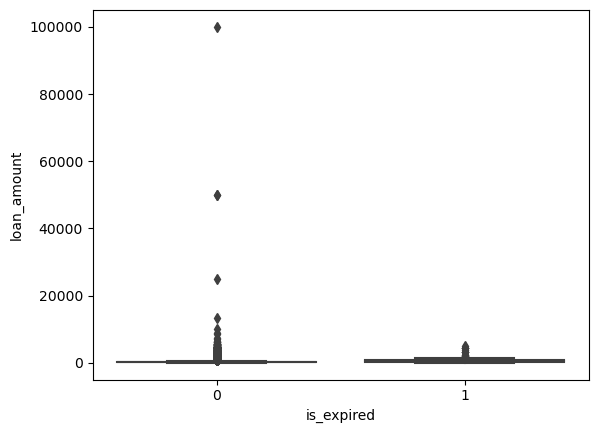

In [16]:
# 14. Boxplot: loan_amount vs. is_expired
sns.boxplot(y=df_ph['loan_amount'], x=df_ph['is_expired'])

## Correlation Test

In [18]:
# 1.
X = df_ph[["loan_amount_bin",
           "loan_amount",
           "funded_14_days_and_above",
           "repayment_interval",
           "repayment_term_16_mos_and_above",
           "partner_covers_currency_loss",
           "personal_use",
           "sector_name",
           "with_image"]]    

for_get_dummies = ["loan_amount_bin", "repayment_interval", "sector_name"]

dummified = pd.get_dummies(X[for_get_dummies])
X = X.drop(columns=for_get_dummies)
dummified = dummified.astype(int)
X = pd.concat([X, dummified], axis=1)

In [ ]:
# 2.
corrs = []

for x in X.columns:
    df = pd.concat([X[x], df_ph["is_expired"]], axis=1)
    df = df.dropna()
    res = stats.pearsonr(df.iloc[:, 0], df.iloc[:, 1])
    corrs.append([x, "is_expired", res[0], res[1]])
    
corrs # mostly weak linear correlations

<Axes: >

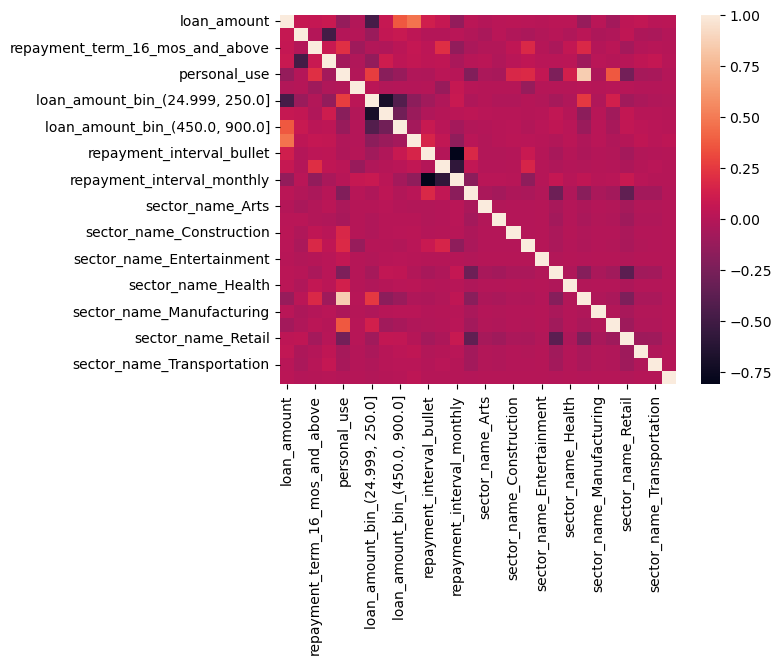

In [20]:
# 3.
corr = X.dropna().corr()
sns.heatmap(corr)

# Modeling using Key Features only

## Baseline Models
Use key columns only based on the results of the association and correlation tests. 
Drop personal_use, sector_name_Agriculture, sector_name_Clothing, sector_name_Entertainment, sector_name_Food, sector_name_Transportation, sector_name_Wholesale and repayment_interval_bullet.

In [46]:
df_ph_model_baseline_cleaned = df_ph.copy(deep=True)

In [47]:
# 1. Drop irrelevant columns
df_ph_model_baseline_cleaned = df_ph_model_baseline_cleaned.drop(columns=['loan_id', 'group_loan', 'posted_time',
                                                                          'loan_amount_bin', 'personal_use', 'loan_use', 
                                                                          'num_days_to_fully_fund', 
                                                                          'funded_14_days_and_above',
                                                                          'partner_id', 'country_name'])

In [48]:
# 2. One-Hot-Encode remaining categorical columns, drop sector_name_Agriculture, sector_name_Clothing, 
#    sector_name_Entertainment, sector_name_Food, sector_name_Transportation, sector_name_Wholesale 
#    and repayment_interval_bullet then make it into a dataframe
encoder = OneHotEncoder(sparse=False)
cat_cols = df_ph_model_baseline_cleaned.select_dtypes(include='object').columns
cat_encoded = encoder.fit_transform(df_ph_model_baseline_cleaned[cat_cols])
cat_encoded_df = pd.DataFrame(cat_encoded, columns=encoder.get_feature_names_out(cat_cols))
cat_encoded_df = cat_encoded_df.drop(columns=['sector_name_Agriculture', 'sector_name_Clothing', 
                                              'sector_name_Entertainment', 'sector_name_Food', 
                                              'sector_name_Transportation', 'sector_name_Wholesale',
                                              'repayment_interval_bullet'])

In [49]:
# 3. Reset the index then concatenate df_ph_model_baseline_cleaned and cat_encoded_df, drop the original cateorical columns
df_ph_model_baseline_cleaned.reset_index(drop=True, inplace=True)
cat_encoded_df.reset_index(drop=True, inplace=True)

base_model = pd.concat([df_ph_model_baseline_cleaned, cat_encoded_df], axis=1)
base_model = base_model.drop(columns=cat_cols)
base_model.shape

(378580, 17)

In [50]:
base_model.columns

Index(['with_image', 'with_video', 'is_expired', 'loan_amount',
       'repayment_term_16_mos_and_above', 'partner_covers_currency_loss',
       'sector_name_Arts', 'sector_name_Construction', 'sector_name_Education',
       'sector_name_Health', 'sector_name_Housing',
       'sector_name_Manufacturing', 'sector_name_Personal Use',
       'sector_name_Retail', 'sector_name_Services',
       'repayment_interval_irregular', 'repayment_interval_monthly'],
      dtype='object')

In [51]:
# 4. Save base_model as csv 
base_model.to_csv('baseline_models_cleaned_df.csv', index=False)

In [52]:
# 5. TrainVal-Holdout Split (features:X, target:y)
X = base_model.drop(columns=['is_expired']) 
y = base_model['is_expired']               

X_trainval, X_holdout, y_trainval, y_holdout = train_test_split(X,y,
                                                                random_state=42,
                                                                test_size = 0.25,
                                                                stratify=y)

In [53]:
# 6. Define the auto_ml function
def auto_ml(X, y, models_dict, scaler=None, svd=None, cv=None, res_t=None):
    
    results_decimal = {}
    results_percentage = {}

    for model_name, model in tqdm(models_dict.items(), desc="Running Models"):
        
        # Enter the metrics to be evaluated below:
        train_accuracy = []
        val_accuracy = []

        train_precision = []
        val_precision = []
        
        train_recall = []
        val_recall = []

        train_f1 = []
        val_f1 = []

        # For each model, do the following:
        for train_index, val_index in cv.split(X, y):

            # 1. Separate rows in trainval to train and val
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # 2. Apply scaling on features (X)
            #    -> no need to scale the target since these are fixed figures
            #    -> apply this to X_train and X_val
            #    -> fit_transform is applied to X_train only
            if scaler is not None:
                X_train = scaler.fit_transform(X_train)
                X_val = scaler.transform(X_val)
            else:
                pass

            # 3. Apply dimensionality-reduction on highly-dimensional data
            #    -> from our correlation matrix, we discovered that there is a weak relationship 
            #       between the features and target (is_expired)...thus, the dimensionality-reduction technique 
            #       employed should be non-linear such as Singular Value Decomposition, we used TruncatedSVD
            #    -> apply this to X_train and X_val
            #    -> fit_transform is applied to X_train only
            if svd is not None:
                X_train = svd.fit_transform(X_train)
                X_val = svd.transform(X_val)
            else:
                pass

            # 4. Apply resampling on highly-imbalanced data
            #    -> resample the TRAIN data only, validation is what it is, we are trying to validate our train findings
            #    -> apply this to X_train and y_train
            if res_t is not None:
                X_train, y_train = res_t.fit_resample(X_train, y_train)
            else:
                pass

            # 5. Record start_time before model fit and predict
            start_time = time.time()

            # 6. Fit the model
            model.fit(X_train, y_train)

            # 7. Use the model to predict the target
            train_preds = model.predict(X_train)
            val_preds = model.predict(X_val)
            
            # 8.Record end_time after model fit and predict
            end_time = time.time() 

            # 9. Record Evaluation Metric Scores
            #### accuracy ####
            train_accuracy.append(accuracy_score(y_train, train_preds))
            val_accuracy.append(accuracy_score(y_val, val_preds))

            #### precision ####
            train_precision.append(precision_score(y_train, train_preds))
            val_precision.append(precision_score(y_val, val_preds))
            
            #### recall ####
            train_recall.append(recall_score(y_train, train_preds))
            val_recall.append(recall_score(y_val, val_preds))
            
            #### f1 ####
            train_f1.append(f1_score(y_train, train_preds))
            val_f1.append(f1_score(y_val, val_preds))

            # 10. Store results 
            #### in decimal ####
            results_decimal[model_name] = {
                'Train Accuracy': np.round(np.mean(train_accuracy) * 100, 2),
                'Val Accuracy': np.round(np.mean(val_accuracy) * 100, 2),
                'Train Precision': np.round(np.mean(train_precision) * 100, 2),
                'Val Precision': np.round(np.mean(val_precision) * 100, 2),
                'Train Recall': np.round(np.mean(train_recall) * 100, 2),
                'Val Recall': np.round(np.mean(val_recall) * 100, 2),
                'Train F1': np.round(np.mean(train_f1) * 100, 2),
                'Val F1': np.round(np.mean(val_f1) * 100, 2),
                'Run Time': end_time - start_time
            }
            
            #### in percentage ####
            results_percentage[model_name] = { 
                'Train Accuracy': '{:.2f}%'.format(np.round(np.mean(train_accuracy) * 100, 2)),
                'Val Accuracy': '{:.2f}%'.format(np.round(np.mean(val_accuracy) * 100, 2)),
                'Train Precision': '{:.2f}%'.format(np.round(np.mean(train_precision) * 100, 2)),
                'Val Precision': '{:.2f}%'.format(np.round(np.mean(val_precision) * 100, 2)),
                'Train Recall': '{:.2f}%'.format(np.round(np.mean(train_recall) * 100, 2)),
                'Val Recall': '{:.2f}%'.format(np.round(np.mean(val_recall) * 100, 2)),
                'Train F1': '{:.2f}%'.format(np.round(np.mean(train_f1) * 100, 2)),
                'Val F1': '{:.2f}%'.format(np.round(np.mean(val_f1) * 100, 2)),
                'Run Time': end_time - start_time
            }

    results_decimal = pd.DataFrame(results_decimal).T  # access it by using [0]
    results_percentage = pd.DataFrame(results_percentage).T  # access it by using [1]
    return [results_decimal, results_percentage]

In [54]:
# 7. Initialize parameters then run the auto_ml function
models_dict = {
      'KNeighborsClassifier': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression(random_state=42),
                'GaussianNB': GaussianNB(),
                       'SVC': SVC(random_state=42),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'RandomForestClassifier': RandomForestClassifier(random_state=42),
'GradientBoostingClassifier': GradientBoostingClassifier(random_state=42),
        'AdaBoostClassifier': AdaBoostClassifier(random_state=42),
      'ExtraTreesClassifier': ExtraTreesClassifier(random_state=42),
             'XGBClassifier': XGBClassifier(random_state=42),
        'CatBoostClassifier': CatBoostClassifier(random_state=42),
            'LGBMClassifier': LGBMClassifier(random_state=42)
}
# scaler=MinMaxScaler()
scaler = RobustScaler()
cv=StratifiedKFold(n_splits=5)

baseline_models = auto_ml(X_trainval, y_trainval, models_dict, scaler=scaler, svd=None, cv=cv, res_t=None)

Running Models:  83%|████████████████████████████████████████████████████▌          | 10/12 [1:55:22<08:38, 259.04s/it]

Learning rate set to 0.104491
0:	learn: 0.4970661	total: 38.5ms	remaining: 38.4s
1:	learn: 0.3608635	total: 74.5ms	remaining: 37.2s
2:	learn: 0.2666831	total: 108ms	remaining: 35.9s
3:	learn: 0.2008416	total: 141ms	remaining: 35.2s
4:	learn: 0.1507066	total: 179ms	remaining: 35.7s
5:	learn: 0.1272811	total: 216ms	remaining: 35.8s
6:	learn: 0.1061680	total: 263ms	remaining: 37.4s
7:	learn: 0.0917232	total: 302ms	remaining: 37.5s
8:	learn: 0.0823666	total: 343ms	remaining: 37.8s
9:	learn: 0.0760261	total: 381ms	remaining: 37.7s
10:	learn: 0.0709667	total: 420ms	remaining: 37.8s
11:	learn: 0.0678788	total: 471ms	remaining: 38.8s
12:	learn: 0.0657881	total: 517ms	remaining: 39.2s
13:	learn: 0.0635964	total: 552ms	remaining: 38.9s
14:	learn: 0.0618936	total: 588ms	remaining: 38.6s
15:	learn: 0.0602936	total: 629ms	remaining: 38.7s
16:	learn: 0.0591000	total: 669ms	remaining: 38.7s
17:	learn: 0.0585703	total: 716ms	remaining: 39.1s
18:	learn: 0.0581159	total: 760ms	remaining: 39.2s
19:	learn

162:	learn: 0.0527631	total: 7.03s	remaining: 36.1s
163:	learn: 0.0527435	total: 7.07s	remaining: 36s
164:	learn: 0.0527377	total: 7.11s	remaining: 36s
165:	learn: 0.0527351	total: 7.15s	remaining: 35.9s
166:	learn: 0.0527260	total: 7.19s	remaining: 35.9s
167:	learn: 0.0527238	total: 7.22s	remaining: 35.8s
168:	learn: 0.0527183	total: 7.27s	remaining: 35.8s
169:	learn: 0.0527145	total: 7.31s	remaining: 35.7s
170:	learn: 0.0527079	total: 7.35s	remaining: 35.6s
171:	learn: 0.0527043	total: 7.39s	remaining: 35.6s
172:	learn: 0.0527011	total: 7.42s	remaining: 35.5s
173:	learn: 0.0526949	total: 7.47s	remaining: 35.4s
174:	learn: 0.0526902	total: 7.52s	remaining: 35.4s
175:	learn: 0.0526873	total: 7.56s	remaining: 35.4s
176:	learn: 0.0526836	total: 7.59s	remaining: 35.3s
177:	learn: 0.0526816	total: 7.63s	remaining: 35.2s
178:	learn: 0.0526782	total: 7.66s	remaining: 35.1s
179:	learn: 0.0526584	total: 7.7s	remaining: 35.1s
180:	learn: 0.0526543	total: 7.75s	remaining: 35.1s
181:	learn: 0.052

323:	learn: 0.0522515	total: 15.5s	remaining: 32.4s
324:	learn: 0.0522490	total: 15.6s	remaining: 32.4s
325:	learn: 0.0522480	total: 15.7s	remaining: 32.4s
326:	learn: 0.0522466	total: 15.7s	remaining: 32.4s
327:	learn: 0.0522449	total: 15.8s	remaining: 32.3s
328:	learn: 0.0522424	total: 15.8s	remaining: 32.3s
329:	learn: 0.0522419	total: 15.9s	remaining: 32.3s
330:	learn: 0.0522369	total: 15.9s	remaining: 32.2s
331:	learn: 0.0522358	total: 16s	remaining: 32.2s
332:	learn: 0.0522340	total: 16.1s	remaining: 32.2s
333:	learn: 0.0522305	total: 16.1s	remaining: 32.1s
334:	learn: 0.0522297	total: 16.2s	remaining: 32.1s
335:	learn: 0.0522261	total: 16.2s	remaining: 32.1s
336:	learn: 0.0522221	total: 16.3s	remaining: 32s
337:	learn: 0.0522199	total: 16.3s	remaining: 32s
338:	learn: 0.0522184	total: 16.4s	remaining: 32s
339:	learn: 0.0522168	total: 16.4s	remaining: 31.9s
340:	learn: 0.0522151	total: 16.5s	remaining: 31.9s
341:	learn: 0.0522119	total: 16.6s	remaining: 31.8s
342:	learn: 0.052211

487:	learn: 0.0519852	total: 24.1s	remaining: 25.3s
488:	learn: 0.0519845	total: 24.1s	remaining: 25.2s
489:	learn: 0.0519844	total: 24.2s	remaining: 25.2s
490:	learn: 0.0519836	total: 24.2s	remaining: 25.1s
491:	learn: 0.0519830	total: 24.2s	remaining: 25s
492:	learn: 0.0519830	total: 24.3s	remaining: 25s
493:	learn: 0.0519829	total: 24.3s	remaining: 24.9s
494:	learn: 0.0519807	total: 24.3s	remaining: 24.8s
495:	learn: 0.0519791	total: 24.4s	remaining: 24.8s
496:	learn: 0.0519781	total: 24.4s	remaining: 24.7s
497:	learn: 0.0519778	total: 24.5s	remaining: 24.7s
498:	learn: 0.0519779	total: 24.5s	remaining: 24.6s
499:	learn: 0.0519766	total: 24.5s	remaining: 24.5s
500:	learn: 0.0519766	total: 24.6s	remaining: 24.5s
501:	learn: 0.0519764	total: 24.6s	remaining: 24.4s
502:	learn: 0.0519761	total: 24.7s	remaining: 24.4s
503:	learn: 0.0519751	total: 24.7s	remaining: 24.3s
504:	learn: 0.0519734	total: 24.7s	remaining: 24.2s
505:	learn: 0.0519717	total: 24.8s	remaining: 24.2s
506:	learn: 0.05

651:	learn: 0.0519000	total: 30s	remaining: 16s
652:	learn: 0.0519000	total: 30s	remaining: 16s
653:	learn: 0.0519000	total: 30.1s	remaining: 15.9s
654:	learn: 0.0519000	total: 30.1s	remaining: 15.9s
655:	learn: 0.0519000	total: 30.1s	remaining: 15.8s
656:	learn: 0.0519000	total: 30.2s	remaining: 15.7s
657:	learn: 0.0519000	total: 30.2s	remaining: 15.7s
658:	learn: 0.0519000	total: 30.2s	remaining: 15.6s
659:	learn: 0.0519000	total: 30.2s	remaining: 15.6s
660:	learn: 0.0519000	total: 30.3s	remaining: 15.5s
661:	learn: 0.0519000	total: 30.3s	remaining: 15.5s
662:	learn: 0.0518999	total: 30.3s	remaining: 15.4s
663:	learn: 0.0518999	total: 30.4s	remaining: 15.4s
664:	learn: 0.0518999	total: 30.4s	remaining: 15.3s
665:	learn: 0.0518999	total: 30.4s	remaining: 15.3s
666:	learn: 0.0518999	total: 30.4s	remaining: 15.2s
667:	learn: 0.0518999	total: 30.5s	remaining: 15.1s
668:	learn: 0.0518999	total: 30.5s	remaining: 15.1s
669:	learn: 0.0518999	total: 30.5s	remaining: 15s
670:	learn: 0.0518999	

810:	learn: 0.0518999	total: 34.4s	remaining: 8.02s
811:	learn: 0.0518999	total: 34.4s	remaining: 7.97s
812:	learn: 0.0518999	total: 34.5s	remaining: 7.93s
813:	learn: 0.0518999	total: 34.5s	remaining: 7.88s
814:	learn: 0.0518999	total: 34.5s	remaining: 7.83s
815:	learn: 0.0518999	total: 34.5s	remaining: 7.79s
816:	learn: 0.0518999	total: 34.6s	remaining: 7.74s
817:	learn: 0.0518999	total: 34.6s	remaining: 7.7s
818:	learn: 0.0518999	total: 34.6s	remaining: 7.65s
819:	learn: 0.0518999	total: 34.6s	remaining: 7.61s
820:	learn: 0.0518999	total: 34.7s	remaining: 7.56s
821:	learn: 0.0518999	total: 34.7s	remaining: 7.51s
822:	learn: 0.0518999	total: 34.7s	remaining: 7.47s
823:	learn: 0.0518999	total: 34.7s	remaining: 7.42s
824:	learn: 0.0518999	total: 34.8s	remaining: 7.37s
825:	learn: 0.0518999	total: 34.8s	remaining: 7.33s
826:	learn: 0.0518999	total: 34.8s	remaining: 7.28s
827:	learn: 0.0518999	total: 34.9s	remaining: 7.24s
828:	learn: 0.0518999	total: 34.9s	remaining: 7.19s
829:	learn: 0

977:	learn: 0.0518999	total: 38.8s	remaining: 873ms
978:	learn: 0.0518999	total: 38.9s	remaining: 833ms
979:	learn: 0.0518999	total: 38.9s	remaining: 793ms
980:	learn: 0.0518999	total: 38.9s	remaining: 753ms
981:	learn: 0.0518999	total: 38.9s	remaining: 714ms
982:	learn: 0.0518999	total: 39s	remaining: 674ms
983:	learn: 0.0518999	total: 39s	remaining: 634ms
984:	learn: 0.0518999	total: 39s	remaining: 594ms
985:	learn: 0.0518999	total: 39s	remaining: 554ms
986:	learn: 0.0518999	total: 39.1s	remaining: 514ms
987:	learn: 0.0518999	total: 39.1s	remaining: 475ms
988:	learn: 0.0518999	total: 39.1s	remaining: 435ms
989:	learn: 0.0518999	total: 39.1s	remaining: 395ms
990:	learn: 0.0518999	total: 39.2s	remaining: 356ms
991:	learn: 0.0518999	total: 39.2s	remaining: 316ms
992:	learn: 0.0518999	total: 39.2s	remaining: 276ms
993:	learn: 0.0518999	total: 39.2s	remaining: 237ms
994:	learn: 0.0518999	total: 39.3s	remaining: 197ms
995:	learn: 0.0518999	total: 39.3s	remaining: 158ms
996:	learn: 0.051899

142:	learn: 0.0529375	total: 5.72s	remaining: 34.3s
143:	learn: 0.0529313	total: 5.76s	remaining: 34.3s
144:	learn: 0.0529214	total: 5.81s	remaining: 34.3s
145:	learn: 0.0529104	total: 5.85s	remaining: 34.2s
146:	learn: 0.0529015	total: 5.88s	remaining: 34.1s
147:	learn: 0.0528982	total: 5.92s	remaining: 34.1s
148:	learn: 0.0528901	total: 5.98s	remaining: 34.1s
149:	learn: 0.0528594	total: 6.02s	remaining: 34.1s
150:	learn: 0.0528550	total: 6.05s	remaining: 34s
151:	learn: 0.0528386	total: 6.09s	remaining: 34s
152:	learn: 0.0528336	total: 6.13s	remaining: 33.9s
153:	learn: 0.0528302	total: 6.16s	remaining: 33.9s
154:	learn: 0.0528194	total: 6.21s	remaining: 33.9s
155:	learn: 0.0528096	total: 6.25s	remaining: 33.8s
156:	learn: 0.0528018	total: 6.29s	remaining: 33.8s
157:	learn: 0.0527880	total: 6.33s	remaining: 33.7s
158:	learn: 0.0527804	total: 6.37s	remaining: 33.7s
159:	learn: 0.0527781	total: 6.4s	remaining: 33.6s
160:	learn: 0.0527745	total: 6.45s	remaining: 33.6s
161:	learn: 0.052

302:	learn: 0.0522186	total: 13s	remaining: 29.8s
303:	learn: 0.0522182	total: 13s	remaining: 29.8s
304:	learn: 0.0522120	total: 13s	remaining: 29.7s
305:	learn: 0.0522079	total: 13.1s	remaining: 29.7s
306:	learn: 0.0522032	total: 13.1s	remaining: 29.6s
307:	learn: 0.0521997	total: 13.2s	remaining: 29.6s
308:	learn: 0.0521969	total: 13.2s	remaining: 29.6s
309:	learn: 0.0521954	total: 13.3s	remaining: 29.5s
310:	learn: 0.0521928	total: 13.3s	remaining: 29.5s
311:	learn: 0.0521904	total: 13.3s	remaining: 29.4s
312:	learn: 0.0521890	total: 13.4s	remaining: 29.4s
313:	learn: 0.0521878	total: 13.4s	remaining: 29.3s
314:	learn: 0.0521843	total: 13.5s	remaining: 29.3s
315:	learn: 0.0521834	total: 13.5s	remaining: 29.2s
316:	learn: 0.0521809	total: 13.5s	remaining: 29.2s
317:	learn: 0.0521781	total: 13.6s	remaining: 29.1s
318:	learn: 0.0521759	total: 13.6s	remaining: 29.1s
319:	learn: 0.0521752	total: 13.7s	remaining: 29s
320:	learn: 0.0521753	total: 13.7s	remaining: 29s
321:	learn: 0.0521743	

465:	learn: 0.0519439	total: 19.9s	remaining: 22.8s
466:	learn: 0.0519426	total: 19.9s	remaining: 22.8s
467:	learn: 0.0519414	total: 20s	remaining: 22.7s
468:	learn: 0.0519412	total: 20s	remaining: 22.7s
469:	learn: 0.0519400	total: 20.1s	remaining: 22.6s
470:	learn: 0.0519395	total: 20.1s	remaining: 22.6s
471:	learn: 0.0519392	total: 20.1s	remaining: 22.5s
472:	learn: 0.0519391	total: 20.2s	remaining: 22.5s
473:	learn: 0.0519389	total: 20.2s	remaining: 22.4s
474:	learn: 0.0519374	total: 20.2s	remaining: 22.4s
475:	learn: 0.0519367	total: 20.3s	remaining: 22.3s
476:	learn: 0.0519362	total: 20.3s	remaining: 22.3s
477:	learn: 0.0519360	total: 20.4s	remaining: 22.2s
478:	learn: 0.0519352	total: 20.4s	remaining: 22.2s
479:	learn: 0.0519343	total: 20.4s	remaining: 22.1s
480:	learn: 0.0519340	total: 20.5s	remaining: 22.1s
481:	learn: 0.0519323	total: 20.5s	remaining: 22s
482:	learn: 0.0519315	total: 20.6s	remaining: 22s
483:	learn: 0.0519299	total: 20.6s	remaining: 22s
484:	learn: 0.0519285	

625:	learn: 0.0518061	total: 26.2s	remaining: 15.7s
626:	learn: 0.0518060	total: 26.3s	remaining: 15.6s
627:	learn: 0.0518059	total: 26.3s	remaining: 15.6s
628:	learn: 0.0518054	total: 26.4s	remaining: 15.6s
629:	learn: 0.0518052	total: 26.4s	remaining: 15.5s
630:	learn: 0.0518050	total: 26.4s	remaining: 15.5s
631:	learn: 0.0518050	total: 26.5s	remaining: 15.4s
632:	learn: 0.0518050	total: 26.5s	remaining: 15.4s
633:	learn: 0.0518044	total: 26.5s	remaining: 15.3s
634:	learn: 0.0518037	total: 26.6s	remaining: 15.3s
635:	learn: 0.0518037	total: 26.6s	remaining: 15.2s
636:	learn: 0.0518036	total: 26.6s	remaining: 15.2s
637:	learn: 0.0518032	total: 26.7s	remaining: 15.1s
638:	learn: 0.0518015	total: 26.7s	remaining: 15.1s
639:	learn: 0.0518015	total: 26.8s	remaining: 15.1s
640:	learn: 0.0518011	total: 26.8s	remaining: 15s
641:	learn: 0.0518005	total: 26.8s	remaining: 15s
642:	learn: 0.0517970	total: 26.9s	remaining: 14.9s
643:	learn: 0.0517970	total: 26.9s	remaining: 14.9s
644:	learn: 0.05

786:	learn: 0.0517363	total: 32s	remaining: 8.67s
787:	learn: 0.0517363	total: 32.1s	remaining: 8.63s
788:	learn: 0.0517362	total: 32.1s	remaining: 8.58s
789:	learn: 0.0517353	total: 32.1s	remaining: 8.54s
790:	learn: 0.0517350	total: 32.2s	remaining: 8.5s
791:	learn: 0.0517349	total: 32.2s	remaining: 8.46s
792:	learn: 0.0517349	total: 32.2s	remaining: 8.41s
793:	learn: 0.0517349	total: 32.3s	remaining: 8.37s
794:	learn: 0.0517349	total: 32.3s	remaining: 8.33s
795:	learn: 0.0517349	total: 32.4s	remaining: 8.29s
796:	learn: 0.0517345	total: 32.4s	remaining: 8.26s
797:	learn: 0.0517344	total: 32.5s	remaining: 8.22s
798:	learn: 0.0517337	total: 32.5s	remaining: 8.19s
799:	learn: 0.0517337	total: 32.6s	remaining: 8.14s
800:	learn: 0.0517337	total: 32.6s	remaining: 8.11s
801:	learn: 0.0517331	total: 32.7s	remaining: 8.07s
802:	learn: 0.0517331	total: 32.8s	remaining: 8.04s
803:	learn: 0.0517328	total: 32.8s	remaining: 8s
804:	learn: 0.0517326	total: 32.9s	remaining: 7.96s
805:	learn: 0.0517

945:	learn: 0.0516644	total: 38.5s	remaining: 2.2s
946:	learn: 0.0516620	total: 38.6s	remaining: 2.16s
947:	learn: 0.0516588	total: 38.6s	remaining: 2.12s
948:	learn: 0.0516586	total: 38.6s	remaining: 2.08s
949:	learn: 0.0516585	total: 38.7s	remaining: 2.04s
950:	learn: 0.0516585	total: 38.7s	remaining: 2s
951:	learn: 0.0516584	total: 38.8s	remaining: 1.95s
952:	learn: 0.0516582	total: 38.8s	remaining: 1.91s
953:	learn: 0.0516581	total: 38.8s	remaining: 1.87s
954:	learn: 0.0516580	total: 38.9s	remaining: 1.83s
955:	learn: 0.0516578	total: 38.9s	remaining: 1.79s
956:	learn: 0.0516576	total: 38.9s	remaining: 1.75s
957:	learn: 0.0516574	total: 39s	remaining: 1.71s
958:	learn: 0.0516550	total: 39s	remaining: 1.67s
959:	learn: 0.0516536	total: 39.1s	remaining: 1.63s
960:	learn: 0.0516526	total: 39.1s	remaining: 1.59s
961:	learn: 0.0516520	total: 39.1s	remaining: 1.55s
962:	learn: 0.0516499	total: 39.2s	remaining: 1.5s
963:	learn: 0.0516493	total: 39.2s	remaining: 1.46s
964:	learn: 0.0516475

105:	learn: 0.0534419	total: 4.6s	remaining: 38.8s
106:	learn: 0.0534352	total: 4.66s	remaining: 38.9s
107:	learn: 0.0534276	total: 4.7s	remaining: 38.8s
108:	learn: 0.0534116	total: 4.75s	remaining: 38.8s
109:	learn: 0.0534093	total: 4.8s	remaining: 38.9s
110:	learn: 0.0534004	total: 4.86s	remaining: 39s
111:	learn: 0.0533770	total: 4.92s	remaining: 39s
112:	learn: 0.0533721	total: 4.97s	remaining: 39s
113:	learn: 0.0533647	total: 5.02s	remaining: 39s
114:	learn: 0.0533631	total: 5.06s	remaining: 39s
115:	learn: 0.0533539	total: 5.13s	remaining: 39.1s
116:	learn: 0.0533467	total: 5.17s	remaining: 39s
117:	learn: 0.0533414	total: 5.22s	remaining: 39s
118:	learn: 0.0533345	total: 5.27s	remaining: 39s
119:	learn: 0.0533267	total: 5.31s	remaining: 38.9s
120:	learn: 0.0533165	total: 5.36s	remaining: 38.9s
121:	learn: 0.0533114	total: 5.4s	remaining: 38.9s
122:	learn: 0.0533024	total: 5.44s	remaining: 38.8s
123:	learn: 0.0532973	total: 5.47s	remaining: 38.7s
124:	learn: 0.0532912	total: 5.5

264:	learn: 0.0526259	total: 11.3s	remaining: 31.3s
265:	learn: 0.0526217	total: 11.4s	remaining: 31.3s
266:	learn: 0.0526206	total: 11.4s	remaining: 31.3s
267:	learn: 0.0526194	total: 11.5s	remaining: 31.3s
268:	learn: 0.0526190	total: 11.5s	remaining: 31.2s
269:	learn: 0.0526183	total: 11.5s	remaining: 31.2s
270:	learn: 0.0526162	total: 11.6s	remaining: 31.1s
271:	learn: 0.0526135	total: 11.6s	remaining: 31.1s
272:	learn: 0.0526079	total: 11.7s	remaining: 31s
273:	learn: 0.0526036	total: 11.7s	remaining: 31s
274:	learn: 0.0525985	total: 11.7s	remaining: 30.9s
275:	learn: 0.0525899	total: 11.8s	remaining: 30.9s
276:	learn: 0.0525873	total: 11.8s	remaining: 30.8s
277:	learn: 0.0525838	total: 11.9s	remaining: 30.8s
278:	learn: 0.0525833	total: 11.9s	remaining: 30.7s
279:	learn: 0.0525819	total: 11.9s	remaining: 30.7s
280:	learn: 0.0525799	total: 12s	remaining: 30.6s
281:	learn: 0.0525772	total: 12s	remaining: 30.6s
282:	learn: 0.0525766	total: 12.1s	remaining: 30.5s
283:	learn: 0.052575

425:	learn: 0.0523022	total: 17.8s	remaining: 23.9s
426:	learn: 0.0522994	total: 17.8s	remaining: 23.9s
427:	learn: 0.0522987	total: 17.8s	remaining: 23.8s
428:	learn: 0.0522951	total: 17.9s	remaining: 23.8s
429:	learn: 0.0522940	total: 17.9s	remaining: 23.7s
430:	learn: 0.0522926	total: 17.9s	remaining: 23.7s
431:	learn: 0.0522916	total: 18s	remaining: 23.7s
432:	learn: 0.0522895	total: 18s	remaining: 23.6s
433:	learn: 0.0522846	total: 18.1s	remaining: 23.6s
434:	learn: 0.0522812	total: 18.1s	remaining: 23.5s
435:	learn: 0.0522807	total: 18.2s	remaining: 23.5s
436:	learn: 0.0522774	total: 18.2s	remaining: 23.4s
437:	learn: 0.0522772	total: 18.2s	remaining: 23.4s
438:	learn: 0.0522763	total: 18.3s	remaining: 23.4s
439:	learn: 0.0522758	total: 18.3s	remaining: 23.3s
440:	learn: 0.0522746	total: 18.4s	remaining: 23.3s
441:	learn: 0.0522741	total: 18.4s	remaining: 23.2s
442:	learn: 0.0522726	total: 18.4s	remaining: 23.2s
443:	learn: 0.0522715	total: 18.5s	remaining: 23.1s
444:	learn: 0.05

586:	learn: 0.0521129	total: 24.6s	remaining: 17.3s
587:	learn: 0.0521123	total: 24.6s	remaining: 17.2s
588:	learn: 0.0521121	total: 24.6s	remaining: 17.2s
589:	learn: 0.0521116	total: 24.7s	remaining: 17.1s
590:	learn: 0.0521105	total: 24.7s	remaining: 17.1s
591:	learn: 0.0521099	total: 24.8s	remaining: 17.1s
592:	learn: 0.0521084	total: 24.8s	remaining: 17s
593:	learn: 0.0521071	total: 24.8s	remaining: 17s
594:	learn: 0.0521055	total: 24.9s	remaining: 16.9s
595:	learn: 0.0521055	total: 24.9s	remaining: 16.9s
596:	learn: 0.0521036	total: 25s	remaining: 16.8s
597:	learn: 0.0521028	total: 25s	remaining: 16.8s
598:	learn: 0.0520987	total: 25s	remaining: 16.8s
599:	learn: 0.0520979	total: 25.1s	remaining: 16.7s
600:	learn: 0.0520965	total: 25.1s	remaining: 16.7s
601:	learn: 0.0520958	total: 25.2s	remaining: 16.6s
602:	learn: 0.0520945	total: 25.2s	remaining: 16.6s
603:	learn: 0.0520945	total: 25.2s	remaining: 16.5s
604:	learn: 0.0520936	total: 25.3s	remaining: 16.5s
605:	learn: 0.0520933	

748:	learn: 0.0519790	total: 31.1s	remaining: 10.4s
749:	learn: 0.0519787	total: 31.1s	remaining: 10.4s
750:	learn: 0.0519783	total: 31.2s	remaining: 10.3s
751:	learn: 0.0519778	total: 31.2s	remaining: 10.3s
752:	learn: 0.0519767	total: 31.3s	remaining: 10.3s
753:	learn: 0.0519763	total: 31.3s	remaining: 10.2s
754:	learn: 0.0519759	total: 31.4s	remaining: 10.2s
755:	learn: 0.0519755	total: 31.4s	remaining: 10.1s
756:	learn: 0.0519753	total: 31.4s	remaining: 10.1s
757:	learn: 0.0519740	total: 31.5s	remaining: 10.1s
758:	learn: 0.0519732	total: 31.5s	remaining: 10s
759:	learn: 0.0519723	total: 31.6s	remaining: 9.97s
760:	learn: 0.0519713	total: 31.6s	remaining: 9.93s
761:	learn: 0.0519712	total: 31.7s	remaining: 9.89s
762:	learn: 0.0519695	total: 31.7s	remaining: 9.85s
763:	learn: 0.0519661	total: 31.8s	remaining: 9.82s
764:	learn: 0.0519647	total: 31.8s	remaining: 9.78s
765:	learn: 0.0519645	total: 31.9s	remaining: 9.74s
766:	learn: 0.0519645	total: 31.9s	remaining: 9.69s
767:	learn: 0.

912:	learn: 0.0518880	total: 38.3s	remaining: 3.65s
913:	learn: 0.0518854	total: 38.4s	remaining: 3.61s
914:	learn: 0.0518854	total: 38.4s	remaining: 3.57s
915:	learn: 0.0518850	total: 38.4s	remaining: 3.52s
916:	learn: 0.0518842	total: 38.5s	remaining: 3.48s
917:	learn: 0.0518835	total: 38.5s	remaining: 3.44s
918:	learn: 0.0518832	total: 38.6s	remaining: 3.4s
919:	learn: 0.0518827	total: 38.6s	remaining: 3.36s
920:	learn: 0.0518818	total: 38.7s	remaining: 3.32s
921:	learn: 0.0518812	total: 38.7s	remaining: 3.27s
922:	learn: 0.0518810	total: 38.7s	remaining: 3.23s
923:	learn: 0.0518805	total: 38.8s	remaining: 3.19s
924:	learn: 0.0518801	total: 38.8s	remaining: 3.15s
925:	learn: 0.0518801	total: 38.9s	remaining: 3.1s
926:	learn: 0.0518797	total: 38.9s	remaining: 3.06s
927:	learn: 0.0518798	total: 38.9s	remaining: 3.02s
928:	learn: 0.0518796	total: 39s	remaining: 2.98s
929:	learn: 0.0518787	total: 39s	remaining: 2.94s
930:	learn: 0.0518787	total: 39s	remaining: 2.89s
931:	learn: 0.051878

75:	learn: 0.0536725	total: 3.09s	remaining: 37.6s
76:	learn: 0.0536621	total: 3.13s	remaining: 37.5s
77:	learn: 0.0536537	total: 3.16s	remaining: 37.4s
78:	learn: 0.0536456	total: 3.2s	remaining: 37.3s
79:	learn: 0.0536298	total: 3.25s	remaining: 37.4s
80:	learn: 0.0536238	total: 3.31s	remaining: 37.6s
81:	learn: 0.0536198	total: 3.37s	remaining: 37.7s
82:	learn: 0.0536177	total: 3.41s	remaining: 37.7s
83:	learn: 0.0536119	total: 3.46s	remaining: 37.8s
84:	learn: 0.0536029	total: 3.51s	remaining: 37.8s
85:	learn: 0.0535940	total: 3.56s	remaining: 37.8s
86:	learn: 0.0535829	total: 3.6s	remaining: 37.7s
87:	learn: 0.0535725	total: 3.64s	remaining: 37.7s
88:	learn: 0.0535476	total: 3.67s	remaining: 37.6s
89:	learn: 0.0535397	total: 3.71s	remaining: 37.5s
90:	learn: 0.0535288	total: 3.75s	remaining: 37.5s
91:	learn: 0.0535259	total: 3.8s	remaining: 37.5s
92:	learn: 0.0535177	total: 3.84s	remaining: 37.4s
93:	learn: 0.0534876	total: 3.87s	remaining: 37.3s
94:	learn: 0.0534748	total: 3.91s	

236:	learn: 0.0526287	total: 10s	remaining: 32.4s
237:	learn: 0.0526265	total: 10.1s	remaining: 32.3s
238:	learn: 0.0526211	total: 10.1s	remaining: 32.3s
239:	learn: 0.0526091	total: 10.2s	remaining: 32.3s
240:	learn: 0.0526081	total: 10.2s	remaining: 32.2s
241:	learn: 0.0526068	total: 10.3s	remaining: 32.1s
242:	learn: 0.0526066	total: 10.3s	remaining: 32.1s
243:	learn: 0.0526013	total: 10.3s	remaining: 32.1s
244:	learn: 0.0525986	total: 10.4s	remaining: 32s
245:	learn: 0.0525979	total: 10.4s	remaining: 32s
246:	learn: 0.0525962	total: 10.5s	remaining: 32.1s
247:	learn: 0.0525933	total: 10.6s	remaining: 32s
248:	learn: 0.0525894	total: 10.6s	remaining: 32s
249:	learn: 0.0525888	total: 10.6s	remaining: 31.9s
250:	learn: 0.0525886	total: 10.7s	remaining: 31.8s
251:	learn: 0.0525857	total: 10.7s	remaining: 31.8s
252:	learn: 0.0525774	total: 10.8s	remaining: 31.9s
253:	learn: 0.0525670	total: 10.9s	remaining: 31.9s
254:	learn: 0.0525628	total: 10.9s	remaining: 31.8s
255:	learn: 0.0525616	

395:	learn: 0.0522399	total: 16.7s	remaining: 25.5s
396:	learn: 0.0522380	total: 16.8s	remaining: 25.5s
397:	learn: 0.0522369	total: 16.8s	remaining: 25.4s
398:	learn: 0.0522352	total: 16.8s	remaining: 25.4s
399:	learn: 0.0522346	total: 16.9s	remaining: 25.3s
400:	learn: 0.0522345	total: 16.9s	remaining: 25.3s
401:	learn: 0.0522319	total: 17s	remaining: 25.2s
402:	learn: 0.0522318	total: 17s	remaining: 25.2s
403:	learn: 0.0522308	total: 17s	remaining: 25.1s
404:	learn: 0.0522292	total: 17.1s	remaining: 25.1s
405:	learn: 0.0522286	total: 17.1s	remaining: 25s
406:	learn: 0.0522237	total: 17.2s	remaining: 25s
407:	learn: 0.0522230	total: 17.2s	remaining: 25s
408:	learn: 0.0522209	total: 17.2s	remaining: 24.9s
409:	learn: 0.0522169	total: 17.3s	remaining: 24.9s
410:	learn: 0.0522166	total: 17.3s	remaining: 24.8s
411:	learn: 0.0522151	total: 17.4s	remaining: 24.8s
412:	learn: 0.0522149	total: 17.4s	remaining: 24.7s
413:	learn: 0.0522118	total: 17.4s	remaining: 24.7s
414:	learn: 0.0522087	to

559:	learn: 0.0520380	total: 23.3s	remaining: 18.3s
560:	learn: 0.0520362	total: 23.4s	remaining: 18.3s
561:	learn: 0.0520343	total: 23.4s	remaining: 18.2s
562:	learn: 0.0520336	total: 23.4s	remaining: 18.2s
563:	learn: 0.0520339	total: 23.5s	remaining: 18.1s
564:	learn: 0.0520334	total: 23.5s	remaining: 18.1s
565:	learn: 0.0520336	total: 23.6s	remaining: 18.1s
566:	learn: 0.0520320	total: 23.6s	remaining: 18s
567:	learn: 0.0520319	total: 23.6s	remaining: 18s
568:	learn: 0.0520319	total: 23.7s	remaining: 17.9s
569:	learn: 0.0520316	total: 23.7s	remaining: 17.9s
570:	learn: 0.0520303	total: 23.7s	remaining: 17.8s
571:	learn: 0.0520294	total: 23.8s	remaining: 17.8s
572:	learn: 0.0520285	total: 23.8s	remaining: 17.8s
573:	learn: 0.0520222	total: 23.9s	remaining: 17.7s
574:	learn: 0.0520205	total: 23.9s	remaining: 17.7s
575:	learn: 0.0520196	total: 23.9s	remaining: 17.6s
576:	learn: 0.0520187	total: 24s	remaining: 17.6s
577:	learn: 0.0520186	total: 24s	remaining: 17.5s
578:	learn: 0.052016

721:	learn: 0.0519054	total: 29.8s	remaining: 11.5s
722:	learn: 0.0519043	total: 29.9s	remaining: 11.4s
723:	learn: 0.0519033	total: 29.9s	remaining: 11.4s
724:	learn: 0.0519018	total: 29.9s	remaining: 11.4s
725:	learn: 0.0519012	total: 30s	remaining: 11.3s
726:	learn: 0.0519009	total: 30s	remaining: 11.3s
727:	learn: 0.0519008	total: 30.1s	remaining: 11.2s
728:	learn: 0.0519007	total: 30.1s	remaining: 11.2s
729:	learn: 0.0518997	total: 30.1s	remaining: 11.1s
730:	learn: 0.0518998	total: 30.2s	remaining: 11.1s
731:	learn: 0.0518996	total: 30.2s	remaining: 11.1s
732:	learn: 0.0518991	total: 30.2s	remaining: 11s
733:	learn: 0.0518985	total: 30.3s	remaining: 11s
734:	learn: 0.0518981	total: 30.3s	remaining: 10.9s
735:	learn: 0.0518980	total: 30.3s	remaining: 10.9s
736:	learn: 0.0518976	total: 30.4s	remaining: 10.8s
737:	learn: 0.0518971	total: 30.4s	remaining: 10.8s
738:	learn: 0.0518973	total: 30.5s	remaining: 10.8s
739:	learn: 0.0518969	total: 30.5s	remaining: 10.7s
740:	learn: 0.051896

880:	learn: 0.0518281	total: 35.9s	remaining: 4.85s
881:	learn: 0.0518276	total: 36s	remaining: 4.81s
882:	learn: 0.0518275	total: 36s	remaining: 4.77s
883:	learn: 0.0518272	total: 36s	remaining: 4.73s
884:	learn: 0.0518273	total: 36.1s	remaining: 4.69s
885:	learn: 0.0518273	total: 36.1s	remaining: 4.65s
886:	learn: 0.0518255	total: 36.2s	remaining: 4.61s
887:	learn: 0.0518255	total: 36.2s	remaining: 4.57s
888:	learn: 0.0518231	total: 36.2s	remaining: 4.53s
889:	learn: 0.0518213	total: 36.3s	remaining: 4.48s
890:	learn: 0.0518212	total: 36.3s	remaining: 4.44s
891:	learn: 0.0518206	total: 36.4s	remaining: 4.4s
892:	learn: 0.0518201	total: 36.4s	remaining: 4.36s
893:	learn: 0.0518201	total: 36.4s	remaining: 4.32s
894:	learn: 0.0518193	total: 36.5s	remaining: 4.28s
895:	learn: 0.0518192	total: 36.5s	remaining: 4.24s
896:	learn: 0.0518175	total: 36.6s	remaining: 4.2s
897:	learn: 0.0518169	total: 36.6s	remaining: 4.16s
898:	learn: 0.0518161	total: 36.6s	remaining: 4.12s
899:	learn: 0.051816

40:	learn: 0.0543445	total: 1.63s	remaining: 38.1s
41:	learn: 0.0541533	total: 1.67s	remaining: 38s
42:	learn: 0.0540438	total: 1.7s	remaining: 37.9s
43:	learn: 0.0540188	total: 1.74s	remaining: 37.8s
44:	learn: 0.0540082	total: 1.78s	remaining: 37.7s
45:	learn: 0.0539870	total: 1.81s	remaining: 37.6s
46:	learn: 0.0539762	total: 1.86s	remaining: 37.6s
47:	learn: 0.0539678	total: 1.9s	remaining: 37.7s
48:	learn: 0.0539556	total: 1.94s	remaining: 37.7s
49:	learn: 0.0539136	total: 1.98s	remaining: 37.6s
50:	learn: 0.0538381	total: 2.02s	remaining: 37.6s
51:	learn: 0.0538288	total: 2.06s	remaining: 37.5s
52:	learn: 0.0538045	total: 2.11s	remaining: 37.7s
53:	learn: 0.0537915	total: 2.15s	remaining: 37.6s
54:	learn: 0.0537810	total: 2.19s	remaining: 37.5s
55:	learn: 0.0537581	total: 2.22s	remaining: 37.5s
56:	learn: 0.0537403	total: 2.26s	remaining: 37.4s
57:	learn: 0.0537222	total: 2.29s	remaining: 37.3s
58:	learn: 0.0536583	total: 2.34s	remaining: 37.3s
59:	learn: 0.0535990	total: 2.38s	r

205:	learn: 0.0523975	total: 8.28s	remaining: 31.9s
206:	learn: 0.0523954	total: 8.32s	remaining: 31.9s
207:	learn: 0.0523944	total: 8.36s	remaining: 31.8s
208:	learn: 0.0523914	total: 8.39s	remaining: 31.8s
209:	learn: 0.0523880	total: 8.43s	remaining: 31.7s
210:	learn: 0.0523868	total: 8.47s	remaining: 31.7s
211:	learn: 0.0523855	total: 8.51s	remaining: 31.6s
212:	learn: 0.0523818	total: 8.56s	remaining: 31.6s
213:	learn: 0.0523784	total: 8.6s	remaining: 31.6s
214:	learn: 0.0523768	total: 8.63s	remaining: 31.5s
215:	learn: 0.0523707	total: 8.67s	remaining: 31.5s
216:	learn: 0.0523649	total: 8.71s	remaining: 31.4s
217:	learn: 0.0523651	total: 8.76s	remaining: 31.4s
218:	learn: 0.0523597	total: 8.8s	remaining: 31.4s
219:	learn: 0.0523570	total: 8.83s	remaining: 31.3s
220:	learn: 0.0523560	total: 8.87s	remaining: 31.3s
221:	learn: 0.0523543	total: 8.91s	remaining: 31.2s
222:	learn: 0.0523529	total: 8.94s	remaining: 31.2s
223:	learn: 0.0523468	total: 8.99s	remaining: 31.2s
224:	learn: 0.

366:	learn: 0.0519955	total: 15.6s	remaining: 26.9s
367:	learn: 0.0519950	total: 15.6s	remaining: 26.8s
368:	learn: 0.0519943	total: 15.7s	remaining: 26.8s
369:	learn: 0.0519922	total: 15.7s	remaining: 26.8s
370:	learn: 0.0519848	total: 15.8s	remaining: 26.8s
371:	learn: 0.0519848	total: 15.8s	remaining: 26.7s
372:	learn: 0.0519834	total: 15.9s	remaining: 26.7s
373:	learn: 0.0519813	total: 15.9s	remaining: 26.6s
374:	learn: 0.0519754	total: 15.9s	remaining: 26.6s
375:	learn: 0.0519731	total: 16s	remaining: 26.5s
376:	learn: 0.0519696	total: 16s	remaining: 26.5s
377:	learn: 0.0519666	total: 16.1s	remaining: 26.5s
378:	learn: 0.0519659	total: 16.1s	remaining: 26.5s
379:	learn: 0.0519655	total: 16.2s	remaining: 26.4s
380:	learn: 0.0519651	total: 16.2s	remaining: 26.4s
381:	learn: 0.0519641	total: 16.3s	remaining: 26.3s
382:	learn: 0.0519628	total: 16.3s	remaining: 26.3s
383:	learn: 0.0519612	total: 16.4s	remaining: 26.3s
384:	learn: 0.0519609	total: 16.4s	remaining: 26.3s
385:	learn: 0.05

530:	learn: 0.0517953	total: 22.1s	remaining: 19.5s
531:	learn: 0.0517953	total: 22.1s	remaining: 19.5s
532:	learn: 0.0517953	total: 22.1s	remaining: 19.4s
533:	learn: 0.0517953	total: 22.2s	remaining: 19.3s
534:	learn: 0.0517953	total: 22.2s	remaining: 19.3s
535:	learn: 0.0517953	total: 22.2s	remaining: 19.2s
536:	learn: 0.0517953	total: 22.2s	remaining: 19.2s
537:	learn: 0.0517953	total: 22.3s	remaining: 19.1s
538:	learn: 0.0517953	total: 22.3s	remaining: 19.1s
539:	learn: 0.0517953	total: 22.3s	remaining: 19s
540:	learn: 0.0517953	total: 22.4s	remaining: 19s
541:	learn: 0.0517953	total: 22.4s	remaining: 18.9s
542:	learn: 0.0517953	total: 22.4s	remaining: 18.9s
543:	learn: 0.0517953	total: 22.4s	remaining: 18.8s
544:	learn: 0.0517953	total: 22.5s	remaining: 18.8s
545:	learn: 0.0517953	total: 22.5s	remaining: 18.7s
546:	learn: 0.0517953	total: 22.5s	remaining: 18.6s
547:	learn: 0.0517953	total: 22.5s	remaining: 18.6s
548:	learn: 0.0517953	total: 22.6s	remaining: 18.5s
549:	learn: 0.05

689:	learn: 0.0516768	total: 28.2s	remaining: 12.7s
690:	learn: 0.0516762	total: 28.2s	remaining: 12.6s
691:	learn: 0.0516748	total: 28.3s	remaining: 12.6s
692:	learn: 0.0516742	total: 28.3s	remaining: 12.6s
693:	learn: 0.0516712	total: 28.4s	remaining: 12.5s
694:	learn: 0.0516686	total: 28.5s	remaining: 12.5s
695:	learn: 0.0516668	total: 28.5s	remaining: 12.5s
696:	learn: 0.0516642	total: 28.5s	remaining: 12.4s
697:	learn: 0.0516643	total: 28.6s	remaining: 12.4s
698:	learn: 0.0516615	total: 28.6s	remaining: 12.3s
699:	learn: 0.0516616	total: 28.6s	remaining: 12.3s
700:	learn: 0.0516612	total: 28.7s	remaining: 12.2s
701:	learn: 0.0516605	total: 28.7s	remaining: 12.2s
702:	learn: 0.0516587	total: 28.8s	remaining: 12.2s
703:	learn: 0.0516582	total: 28.8s	remaining: 12.1s
704:	learn: 0.0516582	total: 28.9s	remaining: 12.1s
705:	learn: 0.0516563	total: 28.9s	remaining: 12s
706:	learn: 0.0516558	total: 28.9s	remaining: 12s
707:	learn: 0.0516553	total: 29s	remaining: 11.9s
708:	learn: 0.0516

853:	learn: 0.0515738	total: 34.3s	remaining: 5.87s
854:	learn: 0.0515738	total: 34.4s	remaining: 5.83s
855:	learn: 0.0515738	total: 34.4s	remaining: 5.79s
856:	learn: 0.0515738	total: 34.4s	remaining: 5.75s
857:	learn: 0.0515738	total: 34.5s	remaining: 5.7s
858:	learn: 0.0515738	total: 34.5s	remaining: 5.66s
859:	learn: 0.0515738	total: 34.5s	remaining: 5.62s
860:	learn: 0.0515738	total: 34.5s	remaining: 5.57s
861:	learn: 0.0515738	total: 34.6s	remaining: 5.53s
862:	learn: 0.0515738	total: 34.6s	remaining: 5.49s
863:	learn: 0.0515738	total: 34.6s	remaining: 5.45s
864:	learn: 0.0515738	total: 34.6s	remaining: 5.41s
865:	learn: 0.0515738	total: 34.7s	remaining: 5.36s
866:	learn: 0.0515738	total: 34.7s	remaining: 5.32s
867:	learn: 0.0515738	total: 34.7s	remaining: 5.28s
868:	learn: 0.0515738	total: 34.7s	remaining: 5.24s
869:	learn: 0.0515738	total: 34.8s	remaining: 5.2s
870:	learn: 0.0515738	total: 34.8s	remaining: 5.16s
871:	learn: 0.0515738	total: 34.8s	remaining: 5.12s
872:	learn: 0.

Running Models:  92%|█████████████████████████████████████████████████████████▊     | 11/12 [1:58:48<04:02, 242.86s/it]

[LightGBM] [Info] Number of positive: 3019, number of negative: 224129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 145
[LightGBM] [Info] Number of data points in the train set: 227148, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.013291 -> initscore=-4.307296
[LightGBM] [Info] Start training from score -4.307296
[LightGBM] [Info] Number of positive: 3019, number of negative: 224129
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011876 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150
[LightGBM] [Info] Number of data points in the train set: 227148, number of used features: 15
[LightGBM] [Info] 

Running Models: 100%|███████████████████████████████████████████████████████████████| 12/12 [1:59:00<00:00, 595.06s/it]


In [55]:
# 8. Display the results
baseline_cleaned_results_df = baseline_models[1]
baseline_cleaned_results_df

,Train Accuracy,Val Accuracy,Train Precision,Val Precision,Train Recall,Val Recall,Train F1,Val F1,Run Time
KNeighborsClassifier,98.71%,98.67%,65.25%,48.04%,5.65%,4.16%,10.40%,7.64%,251.053917
LogisticRegression,98.62%,98.62%,24.46%,24.10%,1.77%,1.75%,3.30%,3.26%,1.610692
GaussianNB,8.55%,8.54%,1.41%,1.41%,98.36%,98.33%,2.78%,2.78%,0.215392
SVC,98.71%,98.71%,98.46%,97.56%,2.82%,2.76%,5.47%,5.35%,557.159488
DecisionTreeClassifier,98.75%,98.70%,92.33%,62.95%,6.47%,4.82%,12.10%,8.95%,0.346105
RandomForestClassifier,98.75%,98.68%,84.60%,55.24%,7.29%,4.80%,13.41%,8.81%,15.139507
GradientBoostingClassifier,98.71%,98.70%,86.11%,74.53%,3.54%,3.23%,6.81%,6.20%,14.066514
AdaBoostClassifier,98.68%,98.68%,53.11%,54.03%,3.64%,3.63%,6.81%,6.80%,8.013601
ExtraTreesClassifier,98.75%,98.69%,92.33%,59.75%,6.47%,4.56%,12.10%,8.46%,13.476954
XGBClassifier,98.73%,98.71%,87.81%,72.11%,5.42%,4.45%,10.21%,8.37%,10.75523


In [56]:
# 9. Save baseline_cleaned_results_df to csv
baseline_cleaned_results_df.to_csv('baseline_models_cleaned_results.csv', 
                                   index=False)

## RandomUnderSampler Models
Use key columns only based on the results of the association and correlation tests. Drop personal_use, sector_name_Agriculture, sector_name_Clothing, sector_name_Entertainment, sector_name_Food, sector_name_Transportation, sector_name_Wholesale and repayment_interval_bullet. 
Use RandomUnderSampler as undersampling technique.

In [166]:
# 1. Copy df_ph_loans_cleaned to df_model and get info
df_model = df_ph_loans_cleaned.copy(deep=True)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378580 entries, 0 to 378579
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   loan_id                          378580 non-null  int64  
 1   group_loan                       378580 non-null  int64  
 2   with_image                       378580 non-null  int64  
 3   with_video                       378580 non-null  int64  
 4   posted_time                      378580 non-null  object 
 5   is_expired                       378580 non-null  int64  
 6   loan_amount                      378580 non-null  float64
 7   loan_amount_bin                  378580 non-null  object 
 8   personal_use                     378580 non-null  int64  
 9   sector_name                      378580 non-null  object 
 10  loan_use                         377949 non-null  object 
 11  num_days_to_fully_fund           373550 non-null  float64
 12  fu

In [167]:
# 2. Drop columns
df_model.drop(columns=["loan_id", "posted_time", "loan_use", "partner_id", "country_name", "num_days_to_fully_fund", "funded_14_days_and_above"], inplace=True)

In [168]:
# 3. Set random seed
rng = 42
np.random.seed(rng)
random.seed(rng)

In [169]:
# 4. Features:X, Target:y
X = df_model.drop(columns=["is_expired"])
y = df_model["is_expired"]

In [170]:
# 5. Dummify X
X_dummified = pd.get_dummies(X, drop_first=True, dtype="int")
X_dummified

,group_loan,with_image,with_video,loan_amount,personal_use,repayment_term_16_mos_and_above,partner_covers_currency_loss,"loan_amount_bin_(250.0, 450.0]","loan_amount_bin_(450.0, 900.0]","loan_amount_bin_(900.0, 500000.0]",...,sector_name_Health,sector_name_Housing,sector_name_Manufacturing,sector_name_Personal Use,sector_name_Retail,sector_name_Services,sector_name_Transportation,sector_name_Wholesale,repayment_interval_irregular,repayment_interval_monthly
0,0,1,0,125.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,1,0,100.0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,1,0,350.0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,1,0,225.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,1,0,200.0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378575,0,1,0,975.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
378576,0,1,0,425.0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
378577,0,1,0,975.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
378578,0,1,0,1275.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [171]:
# 6. Check X_dummified columns
X_dummified.columns = X_dummified.columns.str.replace("\W", "_", regex=True)
X_dummified.columns

Index(['group_loan', 'with_image', 'with_video', 'loan_amount', 'personal_use',
       'repayment_term_16_mos_and_above', 'partner_covers_currency_loss',
       'loan_amount_bin__250_0__450_0_', 'loan_amount_bin__450_0__900_0_',
       'loan_amount_bin__900_0__500000_0_', 'sector_name_Arts',
       'sector_name_Clothing', 'sector_name_Construction',
       'sector_name_Education', 'sector_name_Entertainment',
       'sector_name_Food', 'sector_name_Health', 'sector_name_Housing',
       'sector_name_Manufacturing', 'sector_name_Personal_Use',
       'sector_name_Retail', 'sector_name_Services',
       'sector_name_Transportation', 'sector_name_Wholesale',
       'repayment_interval_irregular', 'repayment_interval_monthly'],
      dtype='object')

In [172]:
# 7. Put key features in a list
key_cols = ["loan_amount",
            "repayment_term_16_mos_and_above",
            "partner_covers_currency_loss",
            "with_image",
            "with_video",
            "repayment_interval_irregular",
            "repayment_interval_monthly",
            'sector_name_Arts', 'sector_name_Construction',
            'sector_name_Education',
            'sector_name_Health', 'sector_name_Housing', 'sector_name_Manufacturing',
            'sector_name_Personal_Use', 'sector_name_Retail', 'sector_name_Services'
           ]

In [173]:
# 8. Check distribution of target
y.value_counts()

is_expired
0    373550
1      5030
Name: count, dtype: int64

In [174]:
# 9. Get key_cols in X_dummified
X_key = X_dummified[key_cols].copy(deep=True)
X_key

,loan_amount,repayment_term_16_mos_and_above,partner_covers_currency_loss,with_image,with_video,repayment_interval_irregular,repayment_interval_monthly,sector_name_Arts,sector_name_Construction,sector_name_Education,sector_name_Health,sector_name_Housing,sector_name_Manufacturing,sector_name_Personal_Use,sector_name_Retail,sector_name_Services
0,125.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
1,100.0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
2,350.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1
3,225.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
4,200.0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378575,975.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
378576,425.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
378577,975.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
378578,1275.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [175]:
# 10. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_key, y, test_size=0.25, stratify=y)

In [176]:
# 11. Use RobustScaler
# NOTE: fit_transform the TRAIN only
sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [177]:
# 12. Create an empty list to store performance
perf = []

In [178]:
# 13. Initialize resampling technique and record duration
rs = RandomUnderSampler()

start = datetime.now()
X_resampled, y_resampled = rs.fit_resample(X_train, y_train)
duration = datetime.now() - start
print("Resampling duration")
print(duration.total_seconds())

Resampling duration
0.087798


In [179]:
# 14.1 KNeighborsClassifier
model = KNeighborsClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["KNeighborsClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["KNeighborsClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.001995
Predict train set duration
0.374997
Predict test set duration
6.356009
              precision    recall  f1-score   support

           0       0.59      0.97      0.74      3773
           1       0.92      0.33      0.48      3773

    accuracy                           0.65      7546
   macro avg       0.76      0.65      0.61      7546
weighted avg       0.76      0.65      0.61      7546

              precision    recall  f1-score   support

           0       0.99      0.96      0.98     93388
           1       0.10      0.34      0.16      1257

    accuracy                           0.95     94645
   macro avg       0.55      0.65      0.57     94645
weighted avg       0.98      0.95      0.96     94645



In [180]:
# 14.2 LogisticRegression
model = LogisticRegression()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["LogisticRegression", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["LogisticRegression", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.041887
Predict train set duration
0.000997
Predict test set duration
0.002995
              precision    recall  f1-score   support

           0       0.74      0.80      0.77      3773
           1       0.79      0.72      0.75      3773

    accuracy                           0.76      7546
   macro avg       0.76      0.76      0.76      7546
weighted avg       0.76      0.76      0.76      7546

              precision    recall  f1-score   support

           0       1.00      0.80      0.89     93388
           1       0.05      0.74      0.09      1257

    accuracy                           0.80     94645
   macro avg       0.52      0.77      0.49     94645
weighted avg       0.98      0.80      0.88     94645



In [181]:
# 14.3 GaussianNB
model = GaussianNB()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["GaussianNB", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["GaussianNB", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.008973
Predict train set duration
0.002994
Predict test set duration
0.052855
              precision    recall  f1-score   support

           0       0.83      0.08      0.14      3773
           1       0.52      0.98      0.68      3773

    accuracy                           0.53      7546
   macro avg       0.67      0.53      0.41      7546
weighted avg       0.67      0.53      0.41      7546

              precision    recall  f1-score   support

           0       1.00      0.07      0.14     93388
           1       0.01      0.98      0.03      1257

    accuracy                           0.08     94645
   macro avg       0.51      0.53      0.08     94645
weighted avg       0.98      0.08      0.13     94645



In [182]:
# 14.4 SVC
model = SVC()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["SVC", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["SVC", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
2.046339
Predict train set duration
3.097689
Predict test set duration
37.499158
              precision    recall  f1-score   support

           0       0.88      0.68      0.77      3773
           1       0.74      0.91      0.81      3773

    accuracy                           0.79      7546
   macro avg       0.81      0.79      0.79      7546
weighted avg       0.81      0.79      0.79      7546

              precision    recall  f1-score   support

           0       1.00      0.68      0.81     93388
           1       0.04      0.90      0.07      1257

    accuracy                           0.68     94645
   macro avg       0.52      0.79      0.44     94645
weighted avg       0.99      0.68      0.80     94645



In [183]:
# 14.5 DecisionTreeClassifier
model = DecisionTreeClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["DecisionTreeClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["DecisionTreeClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.013962
Predict train set duration
0.000999
Predict test set duration
0.014961
              precision    recall  f1-score   support

           0       0.86      0.74      0.79      3773
           1       0.77      0.87      0.82      3773

    accuracy                           0.81      7546
   macro avg       0.81      0.81      0.81      7546
weighted avg       0.81      0.81      0.81      7546

              precision    recall  f1-score   support

           0       1.00      0.72      0.83     93388
           1       0.04      0.84      0.07      1257

    accuracy                           0.72     94645
   macro avg       0.52      0.78      0.45     94645
weighted avg       0.98      0.72      0.82     94645



In [184]:
# 14.6 RandomForestClassifier
model = RandomForestClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["RandomForestClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["RandomForestClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.612361
Predict train set duration
0.090756
Predict test set duration
1.122001
              precision    recall  f1-score   support

           0       0.86      0.74      0.79      3773
           1       0.77      0.88      0.82      3773

    accuracy                           0.81      7546
   macro avg       0.81      0.81      0.81      7546
weighted avg       0.81      0.81      0.81      7546

              precision    recall  f1-score   support

           0       1.00      0.72      0.84     93388
           1       0.04      0.85      0.08      1257

    accuracy                           0.72     94645
   macro avg       0.52      0.79      0.46     94645
weighted avg       0.98      0.72      0.83     94645



In [185]:
# 14.7 GradientBoostingClassifier
model = GradientBoostingClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["GradientBoostingClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["GradientBoostingClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.623622
Predict train set duration
0.009971
Predict test set duration
0.131648
              precision    recall  f1-score   support

           0       0.85      0.71      0.77      3773
           1       0.75      0.88      0.81      3773

    accuracy                           0.79      7546
   macro avg       0.80      0.79      0.79      7546
weighted avg       0.80      0.79      0.79      7546

              precision    recall  f1-score   support

           0       1.00      0.71      0.83     93388
           1       0.04      0.88      0.07      1257

    accuracy                           0.71     94645
   macro avg       0.52      0.79      0.45     94645
weighted avg       0.98      0.71      0.82     94645



In [186]:
# 14.8 AdaBoostClassifier
model = AdaBoostClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["AdaBoostClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["AdaBoostClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])


Fit train set duration
0.477259
Predict train set duration
0.07836
Predict test set duration
0.888656
              precision    recall  f1-score   support

           0       0.82      0.72      0.77      3773
           1       0.75      0.85      0.80      3773

    accuracy                           0.78      7546
   macro avg       0.79      0.78      0.78      7546
weighted avg       0.79      0.78      0.78      7546

              precision    recall  f1-score   support

           0       1.00      0.72      0.84     93388
           1       0.04      0.85      0.08      1257

    accuracy                           0.73     94645
   macro avg       0.52      0.79      0.46     94645
weighted avg       0.98      0.73      0.83     94645



In [187]:
# 14.9 ExtraTreesClassifier
model = ExtraTreesClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["ExtraTreesClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["ExtraTreesClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.46722
Predict train set duration
0.095777
Predict test set duration
1.142913
              precision    recall  f1-score   support

           0       0.86      0.74      0.79      3773
           1       0.77      0.87      0.82      3773

    accuracy                           0.81      7546
   macro avg       0.81      0.81      0.81      7546
weighted avg       0.81      0.81      0.81      7546

              precision    recall  f1-score   support

           0       1.00      0.72      0.84     93388
           1       0.04      0.85      0.07      1257

    accuracy                           0.72     94645
   macro avg       0.52      0.78      0.46     94645
weighted avg       0.98      0.72      0.83     94645



In [188]:
# 14.10 XGBClassifier
model = XGBClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["XGBClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["XGBClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.365023
Predict train set duration
0.011966
Predict test set duration
0.128658
              precision    recall  f1-score   support

           0       0.86      0.72      0.78      3773
           1       0.76      0.89      0.82      3773

    accuracy                           0.80      7546
   macro avg       0.81      0.80      0.80      7546
weighted avg       0.81      0.80      0.80      7546

              precision    recall  f1-score   support

           0       1.00      0.70      0.83     93388
           1       0.04      0.87      0.07      1257

    accuracy                           0.71     94645
   macro avg       0.52      0.79      0.45     94645
weighted avg       0.98      0.71      0.82     94645



In [189]:
# 14.11 CatBoostClassifier
model = CatBoostClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["CatBoostClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["CatBoostClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Learning rate set to 0.024419
0:	learn: 0.6787313	total: 311ms	remaining: 5m 11s
1:	learn: 0.6641354	total: 316ms	remaining: 2m 37s
2:	learn: 0.6521728	total: 320ms	remaining: 1m 46s
3:	learn: 0.6398575	total: 323ms	remaining: 1m 20s
4:	learn: 0.6288472	total: 327ms	remaining: 1m 5s
5:	learn: 0.6192650	total: 330ms	remaining: 54.7s
6:	learn: 0.6096029	total: 333ms	remaining: 47.3s
7:	learn: 0.6030399	total: 336ms	remaining: 41.7s
8:	learn: 0.5902854	total: 340ms	remaining: 37.4s
9:	learn: 0.5820147	total: 343ms	remaining: 34s
10:	learn: 0.5745670	total: 347ms	remaining: 31.2s
11:	learn: 0.5669870	total: 350ms	remaining: 28.8s
12:	learn: 0.5618497	total: 354ms	remaining: 26.8s
13:	learn: 0.5558641	total: 357ms	remaining: 25.1s
14:	learn: 0.5505433	total: 360ms	remaining: 23.6s
15:	learn: 0.5422905	total: 363ms	remaining: 22.3s
16:	learn: 0.5348734	total: 366ms	remaining: 21.2s
17:	learn: 0.5303402	total: 370ms	remaining: 20.2s
18:	learn: 0.5246469	total: 373ms	remaining: 19.3s
19:	learn

162:	learn: 0.4196498	total: 992ms	remaining: 5.09s
163:	learn: 0.4196064	total: 996ms	remaining: 5.08s
164:	learn: 0.4195613	total: 1000ms	remaining: 5.06s
165:	learn: 0.4195215	total: 1s	remaining: 5.05s
166:	learn: 0.4193976	total: 1.01s	remaining: 5.03s
167:	learn: 0.4193157	total: 1.01s	remaining: 5.02s
168:	learn: 0.4192560	total: 1.02s	remaining: 5.01s
169:	learn: 0.4192116	total: 1.02s	remaining: 4.99s
170:	learn: 0.4190134	total: 1.03s	remaining: 4.98s
171:	learn: 0.4189522	total: 1.03s	remaining: 4.96s
172:	learn: 0.4188696	total: 1.03s	remaining: 4.95s
173:	learn: 0.4187679	total: 1.04s	remaining: 4.94s
174:	learn: 0.4186317	total: 1.04s	remaining: 4.92s
175:	learn: 0.4185453	total: 1.05s	remaining: 4.91s
176:	learn: 0.4184534	total: 1.05s	remaining: 4.89s
177:	learn: 0.4183769	total: 1.06s	remaining: 4.88s
178:	learn: 0.4183340	total: 1.06s	remaining: 4.87s
179:	learn: 0.4182916	total: 1.06s	remaining: 4.85s
180:	learn: 0.4182677	total: 1.07s	remaining: 4.83s
181:	learn: 0.

336:	learn: 0.4108659	total: 1.59s	remaining: 3.14s
337:	learn: 0.4108363	total: 1.6s	remaining: 3.13s
338:	learn: 0.4107890	total: 1.6s	remaining: 3.12s
339:	learn: 0.4107779	total: 1.6s	remaining: 3.12s
340:	learn: 0.4107478	total: 1.61s	remaining: 3.11s
341:	learn: 0.4107309	total: 1.61s	remaining: 3.1s
342:	learn: 0.4106939	total: 1.62s	remaining: 3.1s
343:	learn: 0.4106906	total: 1.62s	remaining: 3.09s
344:	learn: 0.4106613	total: 1.62s	remaining: 3.08s
345:	learn: 0.4106542	total: 1.63s	remaining: 3.07s
346:	learn: 0.4106115	total: 1.63s	remaining: 3.07s
347:	learn: 0.4105239	total: 1.63s	remaining: 3.06s
348:	learn: 0.4105096	total: 1.64s	remaining: 3.05s
349:	learn: 0.4104877	total: 1.64s	remaining: 3.04s
350:	learn: 0.4104564	total: 1.64s	remaining: 3.04s
351:	learn: 0.4104024	total: 1.65s	remaining: 3.03s
352:	learn: 0.4103742	total: 1.65s	remaining: 3.02s
353:	learn: 0.4103216	total: 1.65s	remaining: 3.02s
354:	learn: 0.4102602	total: 1.66s	remaining: 3.01s
355:	learn: 0.410

551:	learn: 0.4028905	total: 2.37s	remaining: 1.93s
552:	learn: 0.4028658	total: 2.38s	remaining: 1.92s
553:	learn: 0.4028453	total: 2.38s	remaining: 1.92s
554:	learn: 0.4028165	total: 2.38s	remaining: 1.91s
555:	learn: 0.4027905	total: 2.39s	remaining: 1.91s
556:	learn: 0.4027682	total: 2.39s	remaining: 1.9s
557:	learn: 0.4027412	total: 2.4s	remaining: 1.9s
558:	learn: 0.4027076	total: 2.4s	remaining: 1.89s
559:	learn: 0.4026826	total: 2.4s	remaining: 1.89s
560:	learn: 0.4026589	total: 2.41s	remaining: 1.88s
561:	learn: 0.4026357	total: 2.41s	remaining: 1.88s
562:	learn: 0.4026085	total: 2.41s	remaining: 1.87s
563:	learn: 0.4025815	total: 2.42s	remaining: 1.87s
564:	learn: 0.4025585	total: 2.42s	remaining: 1.86s
565:	learn: 0.4025364	total: 2.42s	remaining: 1.86s
566:	learn: 0.4025066	total: 2.43s	remaining: 1.85s
567:	learn: 0.4024752	total: 2.43s	remaining: 1.85s
568:	learn: 0.4024650	total: 2.43s	remaining: 1.84s
569:	learn: 0.4024285	total: 2.44s	remaining: 1.84s
570:	learn: 0.402

725:	learn: 0.3990797	total: 2.96s	remaining: 1.12s
726:	learn: 0.3990549	total: 2.96s	remaining: 1.11s
727:	learn: 0.3990355	total: 2.97s	remaining: 1.11s
728:	learn: 0.3990192	total: 2.97s	remaining: 1.1s
729:	learn: 0.3990094	total: 2.98s	remaining: 1.1s
730:	learn: 0.3989977	total: 2.98s	remaining: 1.1s
731:	learn: 0.3989687	total: 2.98s	remaining: 1.09s
732:	learn: 0.3989412	total: 2.99s	remaining: 1.09s
733:	learn: 0.3989203	total: 2.99s	remaining: 1.08s
734:	learn: 0.3989063	total: 2.99s	remaining: 1.08s
735:	learn: 0.3988774	total: 3s	remaining: 1.07s
736:	learn: 0.3988655	total: 3s	remaining: 1.07s
737:	learn: 0.3988474	total: 3s	remaining: 1.07s
738:	learn: 0.3988229	total: 3.01s	remaining: 1.06s
739:	learn: 0.3988124	total: 3.01s	remaining: 1.06s
740:	learn: 0.3988012	total: 3.01s	remaining: 1.05s
741:	learn: 0.3987868	total: 3.02s	remaining: 1.05s
742:	learn: 0.3987764	total: 3.02s	remaining: 1.04s
743:	learn: 0.3987518	total: 3.02s	remaining: 1.04s
744:	learn: 0.3987340	to

925:	learn: 0.3961154	total: 3.76s	remaining: 301ms
926:	learn: 0.3961087	total: 3.77s	remaining: 297ms
927:	learn: 0.3960913	total: 3.77s	remaining: 293ms
928:	learn: 0.3960679	total: 3.78s	remaining: 289ms
929:	learn: 0.3960604	total: 3.78s	remaining: 285ms
930:	learn: 0.3960467	total: 3.79s	remaining: 281ms
931:	learn: 0.3960230	total: 3.79s	remaining: 277ms
932:	learn: 0.3960085	total: 3.79s	remaining: 272ms
933:	learn: 0.3960017	total: 3.8s	remaining: 268ms
934:	learn: 0.3959685	total: 3.8s	remaining: 264ms
935:	learn: 0.3959483	total: 3.81s	remaining: 260ms
936:	learn: 0.3959422	total: 3.81s	remaining: 256ms
937:	learn: 0.3959175	total: 3.81s	remaining: 252ms
938:	learn: 0.3959120	total: 3.82s	remaining: 248ms
939:	learn: 0.3959091	total: 3.82s	remaining: 244ms
940:	learn: 0.3958997	total: 3.83s	remaining: 240ms
941:	learn: 0.3958945	total: 3.83s	remaining: 236ms
942:	learn: 0.3958751	total: 3.83s	remaining: 232ms
943:	learn: 0.3958734	total: 3.84s	remaining: 228ms
944:	learn: 0.

In [190]:
# 14.12 LGBMClassifier
model = LGBMClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["LGBMClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["LGBMClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

[LightGBM] [Info] Number of positive: 3773, number of negative: 3773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 90
[LightGBM] [Info] Number of data points in the train set: 7546, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fit train set duration
0.116685
Predict train set duration
0.034924
Predict test set duration
0.319129
              precision    recall  f1-score   support

           0       0.85      0.73      0.79      3773
           1       0.77      0.87      0.81      3773

    accuracy                           0.80      7546
   macro avg       0.81      0.80      0.80      7546
weighted avg       0.81      0.80      0.80      7546

              precision    recall  f1-score   support

           0     

In [191]:
# 15. Display results
perf = pd.DataFrame(perf)
perf.columns = ["Model", "Set", "Accuracy", "Precision", "Recall", "F1"]
perf

,Model,Set,Accuracy,Precision,Recall,F1
0,KNeighborsClassifier,Train,0.650146,0.921190,0.328386,0.484174
1,KNeighborsClassifier,Test,0.952327,0.103339,0.337311,0.158209
2,LogisticRegression,Train,0.762126,0.786335,0.719852,0.751626
3,LogisticRegression,Test,0.804047,0.048378,0.736675,0.090793
4,GaussianNB,Train,0.530215,0.515842,0.983832,0.676816
5,GaussianNB,Test,0.084738,0.014060,0.982498,0.027723
6,SVC,Train,0.792605,0.738445,0.906175,0.813757
7,SVC,Test,0.678028,0.036018,0.902148,0.069271
8,DecisionTreeClassifier,Train,0.807315,0.770721,0.874901,0.819513
9,DecisionTreeClassifier,Test,0.718749,0.038638,0.844869,0.073896


In [193]:
# 16. Save to excel
perf.to_excel("model_stats_RandomUnderSampler.xlsx", sheet_name="Sheet1", index=False)

## NearMiss Models
Use key columns only based on the results of the association and correlation tests. Drop personal_use, sector_name_Agriculture, sector_name_Clothing, sector_name_Entertainment, sector_name_Food, sector_name_Transportation, sector_name_Wholesale and repayment_interval_bullet. 
Use NearMiss as undersampling technique.

In [194]:
# 1. Copy df_ph_loans_cleaned to df_model and get info
df_model = df_ph_loans_cleaned.copy(deep=True)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378580 entries, 0 to 378579
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   loan_id                          378580 non-null  int64  
 1   group_loan                       378580 non-null  int64  
 2   with_image                       378580 non-null  int64  
 3   with_video                       378580 non-null  int64  
 4   posted_time                      378580 non-null  object 
 5   is_expired                       378580 non-null  int64  
 6   loan_amount                      378580 non-null  float64
 7   loan_amount_bin                  378580 non-null  object 
 8   personal_use                     378580 non-null  int64  
 9   sector_name                      378580 non-null  object 
 10  loan_use                         377949 non-null  object 
 11  num_days_to_fully_fund           373550 non-null  float64
 12  fu

In [195]:
# 2. Drop columns
df_model.drop(columns=["loan_id", "posted_time", "loan_use", "partner_id", "country_name", "num_days_to_fully_fund", "funded_14_days_and_above"], inplace=True)

In [196]:
# 3. Set random seed
rng = 42
np.random.seed(rng)
random.seed(rng)

In [197]:
# 4. Features:X, Target:y
X = df_model.drop(columns=["is_expired"])
y = df_model["is_expired"]

In [198]:
# 5. Dummify X
X_dummified = pd.get_dummies(X, drop_first=True, dtype="int")
X_dummified

,group_loan,with_image,with_video,loan_amount,personal_use,repayment_term_16_mos_and_above,partner_covers_currency_loss,"loan_amount_bin_(250.0, 450.0]","loan_amount_bin_(450.0, 900.0]","loan_amount_bin_(900.0, 500000.0]",...,sector_name_Health,sector_name_Housing,sector_name_Manufacturing,sector_name_Personal Use,sector_name_Retail,sector_name_Services,sector_name_Transportation,sector_name_Wholesale,repayment_interval_irregular,repayment_interval_monthly
0,0,1,0,125.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,1,0,100.0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,1,0,350.0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,1,0,225.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,1,0,200.0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378575,0,1,0,975.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
378576,0,1,0,425.0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
378577,0,1,0,975.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
378578,0,1,0,1275.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [199]:
# 6. Check X_dummified columns
X_dummified.columns = X_dummified.columns.str.replace("\W", "_", regex=True)
X_dummified.columns

Index(['group_loan', 'with_image', 'with_video', 'loan_amount', 'personal_use',
       'repayment_term_16_mos_and_above', 'partner_covers_currency_loss',
       'loan_amount_bin__250_0__450_0_', 'loan_amount_bin__450_0__900_0_',
       'loan_amount_bin__900_0__500000_0_', 'sector_name_Arts',
       'sector_name_Clothing', 'sector_name_Construction',
       'sector_name_Education', 'sector_name_Entertainment',
       'sector_name_Food', 'sector_name_Health', 'sector_name_Housing',
       'sector_name_Manufacturing', 'sector_name_Personal_Use',
       'sector_name_Retail', 'sector_name_Services',
       'sector_name_Transportation', 'sector_name_Wholesale',
       'repayment_interval_irregular', 'repayment_interval_monthly'],
      dtype='object')

In [200]:
# 7. Put key features in a list
key_cols = ["loan_amount",
            "repayment_term_16_mos_and_above",
            "partner_covers_currency_loss",
            "with_image",
            "with_video",
            "repayment_interval_irregular",
            "repayment_interval_monthly",
            'sector_name_Arts', 'sector_name_Construction',
            'sector_name_Education',
            'sector_name_Health', 'sector_name_Housing', 'sector_name_Manufacturing',
            'sector_name_Personal_Use', 'sector_name_Retail', 'sector_name_Services'
           ]

In [201]:
# 8. Check distribution of target
y.value_counts()

is_expired
0    373550
1      5030
Name: count, dtype: int64

In [202]:
# 9. Get key_cols in X_dummified
X_key = X_dummified[key_cols].copy(deep=True)
X_key

,loan_amount,repayment_term_16_mos_and_above,partner_covers_currency_loss,with_image,with_video,repayment_interval_irregular,repayment_interval_monthly,sector_name_Arts,sector_name_Construction,sector_name_Education,sector_name_Health,sector_name_Housing,sector_name_Manufacturing,sector_name_Personal_Use,sector_name_Retail,sector_name_Services
0,125.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
1,100.0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
2,350.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1
3,225.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
4,200.0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378575,975.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
378576,425.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
378577,975.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
378578,1275.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [203]:
# 10. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_key, y, test_size=0.25, stratify=y)

In [204]:
# 11. Use RobustScaler
# NOTE: fit_transform the TRAIN only
sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [205]:
# 12. Create an empty list to store performance
perf = []

In [206]:
# 13. Initialize resampling technique and record duration
rs = NearMiss()

start = datetime.now()
X_resampled, y_resampled = rs.fit_resample(X_train, y_train)
duration = datetime.now() - start
print("Resampling duration")
print(duration.total_seconds())

Resampling duration
5.310045


In [207]:
# 14.1 KNeighborsClassifier
model = KNeighborsClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["KNeighborsClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["KNeighborsClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.001995
Predict train set duration
0.364026
Predict test set duration
6.386964
              precision    recall  f1-score   support

           0       0.58      0.98      0.73      3773
           1       0.94      0.28      0.43      3773

    accuracy                           0.63      7546
   macro avg       0.76      0.63      0.58      7546
weighted avg       0.76      0.63      0.58      7546

              precision    recall  f1-score   support

           0       0.99      0.82      0.90     93388
           1       0.02      0.28      0.04      1257

    accuracy                           0.81     94645
   macro avg       0.50      0.55      0.47     94645
weighted avg       0.98      0.81      0.89     94645



In [208]:
# 14.2 LogisticRegression
model = LogisticRegression()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["LogisticRegression", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["LogisticRegression", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.058839
Predict train set duration
0.000999
Predict test set duration
0.004985
              precision    recall  f1-score   support

           0       0.66      0.80      0.72      3773
           1       0.75      0.59      0.66      3773

    accuracy                           0.70      7546
   macro avg       0.70      0.70      0.69      7546
weighted avg       0.70      0.70      0.69      7546

              precision    recall  f1-score   support

           0       0.99      0.77      0.86     93388
           1       0.03      0.61      0.06      1257

    accuracy                           0.76     94645
   macro avg       0.51      0.69      0.46     94645
weighted avg       0.98      0.76      0.85     94645



In [209]:
# 14.3 GaussianNB
model = GaussianNB()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["GaussianNB", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["GaussianNB", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.004989
Predict train set duration
0.003993
Predict test set duration
0.05784
              precision    recall  f1-score   support

           0       0.56      0.98      0.72      3773
           1       0.93      0.24      0.39      3773

    accuracy                           0.61      7546
   macro avg       0.75      0.61      0.55      7546
weighted avg       0.75      0.61      0.55      7546

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     93388
           1       0.02      0.26      0.03      1257

    accuracy                           0.80     94645
   macro avg       0.50      0.53      0.46     94645
weighted avg       0.97      0.80      0.88     94645



In [210]:
# 14.4 SVC
model = SVC()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["SVC", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["SVC", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
3.008516
Predict train set duration
4.339398
Predict test set duration
52.630352
              precision    recall  f1-score   support

           0       0.68      0.81      0.74      3773
           1       0.77      0.62      0.68      3773

    accuracy                           0.72      7546
   macro avg       0.72      0.72      0.71      7546
weighted avg       0.72      0.72      0.71      7546

              precision    recall  f1-score   support

           0       0.99      0.72      0.84     93388
           1       0.03      0.63      0.06      1257

    accuracy                           0.72     94645
   macro avg       0.51      0.67      0.45     94645
weighted avg       0.98      0.72      0.83     94645



In [211]:
# 14.5 DecisionTreeClassifier
model = DecisionTreeClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["DecisionTreeClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["DecisionTreeClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.012994
Predict train set duration
0.001968
Predict test set duration
0.012997
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      3773
           1       0.73      0.73      0.73      3773

    accuracy                           0.73      7546
   macro avg       0.73      0.73      0.73      7546
weighted avg       0.73      0.73      0.73      7546

              precision    recall  f1-score   support

           0       0.99      0.67      0.80     93388
           1       0.03      0.71      0.05      1257

    accuracy                           0.67     94645
   macro avg       0.51      0.69      0.43     94645
weighted avg       0.98      0.67      0.79     94645



In [212]:
# 14.6 RandomForestClassifier
model = RandomForestClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["RandomForestClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["RandomForestClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.880323
Predict train set duration
0.099882
Predict test set duration
0.965447
              precision    recall  f1-score   support

           0       0.74      0.71      0.72      3773
           1       0.72      0.75      0.73      3773

    accuracy                           0.73      7546
   macro avg       0.73      0.73      0.73      7546
weighted avg       0.73      0.73      0.73      7546

              precision    recall  f1-score   support

           0       0.99      0.59      0.74     93388
           1       0.02      0.74      0.05      1257

    accuracy                           0.59     94645
   macro avg       0.51      0.66      0.39     94645
weighted avg       0.98      0.59      0.73     94645



In [213]:
# 14.7 GradientBoostingClassifier
model = GradientBoostingClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["GradientBoostingClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["GradientBoostingClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.592205
Predict train set duration
0.011966
Predict test set duration
0.145611
              precision    recall  f1-score   support

           0       0.72      0.72      0.72      3773
           1       0.72      0.72      0.72      3773

    accuracy                           0.72      7546
   macro avg       0.72      0.72      0.72      7546
weighted avg       0.72      0.72      0.72      7546

              precision    recall  f1-score   support

           0       0.99      0.45      0.62     93388
           1       0.02      0.72      0.03      1257

    accuracy                           0.45     94645
   macro avg       0.50      0.59      0.32     94645
weighted avg       0.98      0.45      0.61     94645



In [214]:
# 14.8 AdaBoostClassifier
model = AdaBoostClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["AdaBoostClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["AdaBoostClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])


Fit train set duration
0.254321
Predict train set duration
0.047904
Predict test set duration
0.786866
              precision    recall  f1-score   support

           0       0.69      0.76      0.72      3773
           1       0.73      0.66      0.69      3773

    accuracy                           0.71      7546
   macro avg       0.71      0.71      0.71      7546
weighted avg       0.71      0.71      0.71      7546

              precision    recall  f1-score   support

           0       0.99      0.46      0.63     93388
           1       0.02      0.68      0.03      1257

    accuracy                           0.47     94645
   macro avg       0.50      0.57      0.33     94645
weighted avg       0.98      0.47      0.62     94645



In [215]:
# 14.9 ExtraTreesClassifier
model = ExtraTreesClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["ExtraTreesClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["ExtraTreesClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.46379
Predict train set duration
0.089233
Predict test set duration
1.024262
              precision    recall  f1-score   support

           0       0.73      0.73      0.73      3773
           1       0.73      0.73      0.73      3773

    accuracy                           0.73      7546
   macro avg       0.73      0.73      0.73      7546
weighted avg       0.73      0.73      0.73      7546

              precision    recall  f1-score   support

           0       0.99      0.58      0.73     93388
           1       0.02      0.72      0.04      1257

    accuracy                           0.58     94645
   macro avg       0.51      0.65      0.39     94645
weighted avg       0.98      0.58      0.72     94645



In [216]:
# 14.10 XGBClassifier
model = XGBClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["XGBClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["XGBClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.408907
Predict train set duration
0.015988
Predict test set duration
0.133613
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      3773
           1       0.73      0.73      0.73      3773

    accuracy                           0.73      7546
   macro avg       0.73      0.73      0.73      7546
weighted avg       0.73      0.73      0.73      7546

              precision    recall  f1-score   support

           0       0.99      0.66      0.79     93388
           1       0.03      0.72      0.05      1257

    accuracy                           0.66     94645
   macro avg       0.51      0.69      0.42     94645
weighted avg       0.98      0.66      0.78     94645



In [217]:
# 14.11 CatBoostClassifier
model = CatBoostClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["CatBoostClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["CatBoostClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Learning rate set to 0.024419
0:	learn: 0.6847877	total: 3.94ms	remaining: 3.94s
1:	learn: 0.6771052	total: 8.72ms	remaining: 4.35s
2:	learn: 0.6701100	total: 13.4ms	remaining: 4.47s
3:	learn: 0.6628415	total: 17.5ms	remaining: 4.37s
4:	learn: 0.6561924	total: 21.1ms	remaining: 4.19s
5:	learn: 0.6507506	total: 24.4ms	remaining: 4.04s
6:	learn: 0.6455382	total: 27.5ms	remaining: 3.9s
7:	learn: 0.6398671	total: 30.6ms	remaining: 3.8s
8:	learn: 0.6340445	total: 33.7ms	remaining: 3.71s
9:	learn: 0.6289275	total: 37ms	remaining: 3.66s
10:	learn: 0.6244820	total: 40.3ms	remaining: 3.62s
11:	learn: 0.6203368	total: 43.4ms	remaining: 3.58s
12:	learn: 0.6157501	total: 46.6ms	remaining: 3.54s
13:	learn: 0.6116134	total: 49.8ms	remaining: 3.51s
14:	learn: 0.6074512	total: 53.1ms	remaining: 3.49s
15:	learn: 0.6035536	total: 56.4ms	remaining: 3.47s
16:	learn: 0.6001890	total: 59.6ms	remaining: 3.44s
17:	learn: 0.5971680	total: 62.7ms	remaining: 3.42s
18:	learn: 0.5946459	total: 66ms	remaining: 3.4s

208:	learn: 0.5157425	total: 797ms	remaining: 3.02s
209:	learn: 0.5157336	total: 800ms	remaining: 3.01s
210:	learn: 0.5156584	total: 804ms	remaining: 3s
211:	learn: 0.5156218	total: 808ms	remaining: 3s
212:	learn: 0.5155958	total: 811ms	remaining: 3s
213:	learn: 0.5155648	total: 815ms	remaining: 2.99s
214:	learn: 0.5154915	total: 818ms	remaining: 2.99s
215:	learn: 0.5154804	total: 822ms	remaining: 2.98s
216:	learn: 0.5154249	total: 825ms	remaining: 2.98s
217:	learn: 0.5154218	total: 829ms	remaining: 2.97s
218:	learn: 0.5154168	total: 832ms	remaining: 2.96s
219:	learn: 0.5153936	total: 836ms	remaining: 2.96s
220:	learn: 0.5153651	total: 839ms	remaining: 2.96s
221:	learn: 0.5153247	total: 842ms	remaining: 2.95s
222:	learn: 0.5152847	total: 846ms	remaining: 2.95s
223:	learn: 0.5152377	total: 849ms	remaining: 2.94s
224:	learn: 0.5152108	total: 852ms	remaining: 2.94s
225:	learn: 0.5152059	total: 855ms	remaining: 2.93s
226:	learn: 0.5151881	total: 859ms	remaining: 2.92s
227:	learn: 0.5151680

413:	learn: 0.5104424	total: 1.58s	remaining: 2.24s
414:	learn: 0.5103897	total: 1.58s	remaining: 2.23s
415:	learn: 0.5103679	total: 1.59s	remaining: 2.23s
416:	learn: 0.5103342	total: 1.59s	remaining: 2.23s
417:	learn: 0.5102992	total: 1.6s	remaining: 2.22s
418:	learn: 0.5102847	total: 1.6s	remaining: 2.22s
419:	learn: 0.5102544	total: 1.61s	remaining: 2.22s
420:	learn: 0.5102419	total: 1.61s	remaining: 2.22s
421:	learn: 0.5102020	total: 1.62s	remaining: 2.22s
422:	learn: 0.5101847	total: 1.62s	remaining: 2.21s
423:	learn: 0.5101574	total: 1.63s	remaining: 2.21s
424:	learn: 0.5101011	total: 1.63s	remaining: 2.2s
425:	learn: 0.5100535	total: 1.63s	remaining: 2.2s
426:	learn: 0.5100312	total: 1.64s	remaining: 2.2s
427:	learn: 0.5100072	total: 1.64s	remaining: 2.19s
428:	learn: 0.5099761	total: 1.64s	remaining: 2.19s
429:	learn: 0.5099559	total: 1.65s	remaining: 2.18s
430:	learn: 0.5099289	total: 1.65s	remaining: 2.18s
431:	learn: 0.5098984	total: 1.65s	remaining: 2.17s
432:	learn: 0.509

613:	learn: 0.5061859	total: 2.37s	remaining: 1.49s
614:	learn: 0.5061767	total: 2.37s	remaining: 1.49s
615:	learn: 0.5061664	total: 2.38s	remaining: 1.48s
616:	learn: 0.5061480	total: 2.38s	remaining: 1.48s
617:	learn: 0.5061350	total: 2.38s	remaining: 1.47s
618:	learn: 0.5061107	total: 2.39s	remaining: 1.47s
619:	learn: 0.5061016	total: 2.39s	remaining: 1.47s
620:	learn: 0.5060863	total: 2.4s	remaining: 1.46s
621:	learn: 0.5060721	total: 2.4s	remaining: 1.46s
622:	learn: 0.5060544	total: 2.4s	remaining: 1.45s
623:	learn: 0.5060330	total: 2.41s	remaining: 1.45s
624:	learn: 0.5060158	total: 2.41s	remaining: 1.45s
625:	learn: 0.5059941	total: 2.41s	remaining: 1.44s
626:	learn: 0.5059790	total: 2.42s	remaining: 1.44s
627:	learn: 0.5059735	total: 2.42s	remaining: 1.43s
628:	learn: 0.5059577	total: 2.42s	remaining: 1.43s
629:	learn: 0.5059383	total: 2.43s	remaining: 1.43s
630:	learn: 0.5059359	total: 2.43s	remaining: 1.42s
631:	learn: 0.5059317	total: 2.43s	remaining: 1.42s
632:	learn: 0.5

789:	learn: 0.5042874	total: 2.96s	remaining: 786ms
790:	learn: 0.5042839	total: 2.96s	remaining: 782ms
791:	learn: 0.5042738	total: 2.96s	remaining: 778ms
792:	learn: 0.5042712	total: 2.97s	remaining: 774ms
793:	learn: 0.5042681	total: 2.97s	remaining: 770ms
794:	learn: 0.5042612	total: 2.97s	remaining: 767ms
795:	learn: 0.5042566	total: 2.98s	remaining: 763ms
796:	learn: 0.5042519	total: 2.98s	remaining: 759ms
797:	learn: 0.5042405	total: 2.98s	remaining: 755ms
798:	learn: 0.5042245	total: 2.99s	remaining: 751ms
799:	learn: 0.5042188	total: 2.99s	remaining: 748ms
800:	learn: 0.5042097	total: 2.99s	remaining: 744ms
801:	learn: 0.5041995	total: 3s	remaining: 740ms
802:	learn: 0.5041907	total: 3s	remaining: 736ms
803:	learn: 0.5041849	total: 3s	remaining: 732ms
804:	learn: 0.5041717	total: 3.01s	remaining: 728ms
805:	learn: 0.5041647	total: 3.01s	remaining: 724ms
806:	learn: 0.5041543	total: 3.01s	remaining: 721ms
807:	learn: 0.5041498	total: 3.02s	remaining: 717ms
808:	learn: 0.5041377

967:	learn: 0.5031266	total: 3.55s	remaining: 117ms
968:	learn: 0.5031230	total: 3.55s	remaining: 114ms
969:	learn: 0.5031139	total: 3.55s	remaining: 110ms
970:	learn: 0.5031073	total: 3.56s	remaining: 106ms
971:	learn: 0.5031079	total: 3.56s	remaining: 103ms
972:	learn: 0.5031024	total: 3.56s	remaining: 98.9ms
973:	learn: 0.5031007	total: 3.57s	remaining: 95.2ms
974:	learn: 0.5030943	total: 3.57s	remaining: 91.6ms
975:	learn: 0.5030916	total: 3.57s	remaining: 87.9ms
976:	learn: 0.5030871	total: 3.58s	remaining: 84.2ms
977:	learn: 0.5030827	total: 3.58s	remaining: 80.6ms
978:	learn: 0.5030808	total: 3.58s	remaining: 76.9ms
979:	learn: 0.5030739	total: 3.59s	remaining: 73.3ms
980:	learn: 0.5030670	total: 3.59s	remaining: 69.6ms
981:	learn: 0.5030633	total: 3.6s	remaining: 65.9ms
982:	learn: 0.5030608	total: 3.6s	remaining: 62.3ms
983:	learn: 0.5030539	total: 3.6s	remaining: 58.6ms
984:	learn: 0.5030530	total: 3.61s	remaining: 54.9ms
985:	learn: 0.5030439	total: 3.61s	remaining: 51.3ms
9

In [218]:
# 14.12 LGBMClassifier
model = LGBMClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["LGBMClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["LGBMClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

[LightGBM] [Info] Number of positive: 3773, number of negative: 3773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000440 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 77
[LightGBM] [Info] Number of data points in the train set: 7546, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fit train set duration
0.203451
Predict train set duration
0.046875
Predict test set duration
0.318151
              precision    recall  f1-score   support

           0       0.73      0.72      0.73      3773
           1       0.72      0.74      0.73      3773

    accuracy                           0.73      7546
   macro avg       0.73      0.73      0.73      7546
weighted avg       0.73      0.73      0.73      7546

              precision    recall  f1-score   support

           0     

In [219]:
# 15. Display results
perf = pd.DataFrame(perf)
perf.columns = ["Model", "Set", "Accuracy", "Precision", "Recall", "F1"]
perf

,Model,Set,Accuracy,Precision,Recall,F1
0,KNeighborsClassifier,Train,0.632521,0.942478,0.282269,0.434428
1,KNeighborsClassifier,Test,0.814570,0.020766,0.280827,0.038672
2,LogisticRegression,Train,0.695070,0.745825,0.591837,0.659967
3,LogisticRegression,Test,0.763717,0.033713,0.607001,0.063879
4,GaussianNB,Train,0.611980,0.926337,0.243308,0.385390
5,GaussianNB,Test,0.799831,0.017670,0.257757,0.033073
6,SVC,Train,0.715081,0.766678,0.618341,0.684566
7,SVC,Test,0.720175,0.029435,0.627685,0.056233
8,DecisionTreeClassifier,Train,0.729128,0.727920,0.731778,0.729844
9,DecisionTreeClassifier,Test,0.667832,0.028083,0.714399,0.054041


In [220]:
# 16. Save to excel
perf.to_excel("model_stats_NearMiss.xlsx", sheet_name="Sheet1", index=False)

## ClusterCentroids Models
Use key columns only based on the results of the association and correlation tests. Drop personal_use, sector_name_Agriculture, sector_name_Clothing, sector_name_Entertainment, sector_name_Food, sector_name_Transportation, sector_name_Wholesale and repayment_interval_bullet. 
Use ClusterCentroids as undersampling technique.

In [221]:
# 1. Copy df_ph_loans_cleaned to df_model and get info
df_model = df_ph_loans_cleaned.copy(deep=True)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378580 entries, 0 to 378579
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   loan_id                          378580 non-null  int64  
 1   group_loan                       378580 non-null  int64  
 2   with_image                       378580 non-null  int64  
 3   with_video                       378580 non-null  int64  
 4   posted_time                      378580 non-null  object 
 5   is_expired                       378580 non-null  int64  
 6   loan_amount                      378580 non-null  float64
 7   loan_amount_bin                  378580 non-null  object 
 8   personal_use                     378580 non-null  int64  
 9   sector_name                      378580 non-null  object 
 10  loan_use                         377949 non-null  object 
 11  num_days_to_fully_fund           373550 non-null  float64
 12  fu

In [222]:
# 2. Drop columns
df_model.drop(columns=["loan_id", "posted_time", "loan_use", "partner_id", "country_name", "num_days_to_fully_fund", "funded_14_days_and_above"], inplace=True)

In [223]:
# 3. Set random seed
rng = 42
np.random.seed(rng)
random.seed(rng)

In [224]:
# 4. Features:X, Target:y
X = df_model.drop(columns=["is_expired"])
y = df_model["is_expired"]

In [225]:
# 5. Dummify X
X_dummified = pd.get_dummies(X, drop_first=True, dtype="int")
X_dummified

,group_loan,with_image,with_video,loan_amount,personal_use,repayment_term_16_mos_and_above,partner_covers_currency_loss,"loan_amount_bin_(250.0, 450.0]","loan_amount_bin_(450.0, 900.0]","loan_amount_bin_(900.0, 500000.0]",...,sector_name_Health,sector_name_Housing,sector_name_Manufacturing,sector_name_Personal Use,sector_name_Retail,sector_name_Services,sector_name_Transportation,sector_name_Wholesale,repayment_interval_irregular,repayment_interval_monthly
0,0,1,0,125.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,1,0,100.0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,1,0,350.0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,1,0,225.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,1,0,200.0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378575,0,1,0,975.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
378576,0,1,0,425.0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
378577,0,1,0,975.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
378578,0,1,0,1275.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [226]:
# 6. Check X_dummified columns
X_dummified.columns = X_dummified.columns.str.replace("\W", "_", regex=True)
X_dummified.columns

Index(['group_loan', 'with_image', 'with_video', 'loan_amount', 'personal_use',
       'repayment_term_16_mos_and_above', 'partner_covers_currency_loss',
       'loan_amount_bin__250_0__450_0_', 'loan_amount_bin__450_0__900_0_',
       'loan_amount_bin__900_0__500000_0_', 'sector_name_Arts',
       'sector_name_Clothing', 'sector_name_Construction',
       'sector_name_Education', 'sector_name_Entertainment',
       'sector_name_Food', 'sector_name_Health', 'sector_name_Housing',
       'sector_name_Manufacturing', 'sector_name_Personal_Use',
       'sector_name_Retail', 'sector_name_Services',
       'sector_name_Transportation', 'sector_name_Wholesale',
       'repayment_interval_irregular', 'repayment_interval_monthly'],
      dtype='object')

In [227]:
# 7. Put key features in a list
key_cols = ["loan_amount",
            "repayment_term_16_mos_and_above",
            "partner_covers_currency_loss",
            "with_image",
            "with_video",
            "repayment_interval_irregular",
            "repayment_interval_monthly",
            'sector_name_Arts', 'sector_name_Construction',
            'sector_name_Education',
            'sector_name_Health', 'sector_name_Housing', 'sector_name_Manufacturing',
            'sector_name_Personal_Use', 'sector_name_Retail', 'sector_name_Services'
           ]

In [228]:
# 8. Check distribution of target
y.value_counts()

is_expired
0    373550
1      5030
Name: count, dtype: int64

In [229]:
# 9. Get key_cols in X_dummified
X_key = X_dummified[key_cols].copy(deep=True)
X_key

,loan_amount,repayment_term_16_mos_and_above,partner_covers_currency_loss,with_image,with_video,repayment_interval_irregular,repayment_interval_monthly,sector_name_Arts,sector_name_Construction,sector_name_Education,sector_name_Health,sector_name_Housing,sector_name_Manufacturing,sector_name_Personal_Use,sector_name_Retail,sector_name_Services
0,125.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
1,100.0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
2,350.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1
3,225.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
4,200.0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378575,975.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
378576,425.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
378577,975.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
378578,1275.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [230]:
# 10. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_key, y, test_size=0.25, stratify=y)

In [231]:
# 11. Use RobustScaler
# NOTE: fit_transform the TRAIN only
sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [232]:
# 12. Create an empty list to store performance
perf = []

In [233]:
# 13. Initialize resampling technique and record duration
rs = ClusterCentroids()

start = datetime.now()
X_resampled, y_resampled = rs.fit_resample(X_train, y_train)
duration = datetime.now() - start
print("Resampling duration")
print(duration.total_seconds())

Resampling duration
2088.902376


In [234]:
# 14.1 KNeighborsClassifier
model = KNeighborsClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["KNeighborsClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["KNeighborsClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.005984
Predict train set duration
0.567741
Predict test set duration
6.253285
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      3773
           1       0.93      0.94      0.94      3773

    accuracy                           0.94      7546
   macro avg       0.94      0.94      0.94      7546
weighted avg       0.94      0.94      0.94      7546

              precision    recall  f1-score   support

           0       1.00      0.36      0.53     93388
           1       0.02      0.92      0.04      1257

    accuracy                           0.37     94645
   macro avg       0.51      0.64      0.28     94645
weighted avg       0.98      0.37      0.52     94645



In [235]:
# 14.2 LogisticRegression
model = LogisticRegression()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["LogisticRegression", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["LogisticRegression", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.194479
Predict train set duration
0.000997
Predict test set duration
0.003992
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      3773
           1       0.84      0.82      0.83      3773

    accuracy                           0.83      7546
   macro avg       0.83      0.83      0.83      7546
weighted avg       0.83      0.83      0.83      7546

              precision    recall  f1-score   support

           0       0.99      0.28      0.44     93388
           1       0.02      0.81      0.03      1257

    accuracy                           0.29     94645
   macro avg       0.50      0.55      0.24     94645
weighted avg       0.98      0.29      0.44     94645



In [236]:
# 14.3 GaussianNB
model = GaussianNB()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["GaussianNB", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["GaussianNB", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.005984
Predict train set duration
0.004019
Predict test set duration
0.044848
              precision    recall  f1-score   support

           0       0.89      0.30      0.45      3773
           1       0.58      0.96      0.72      3773

    accuracy                           0.63      7546
   macro avg       0.74      0.63      0.59      7546
weighted avg       0.74      0.63      0.59      7546

              precision    recall  f1-score   support

           0       0.99      0.08      0.15     93388
           1       0.01      0.97      0.03      1257

    accuracy                           0.09     94645
   macro avg       0.50      0.52      0.09     94645
weighted avg       0.98      0.09      0.15     94645



In [237]:
# 14.4 SVC
model = SVC()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["SVC", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["SVC", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
1.522905
Predict train set duration
2.807588
Predict test set duration
29.034424
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      3773
           1       0.87      0.93      0.90      3773

    accuracy                           0.90      7546
   macro avg       0.90      0.90      0.90      7546
weighted avg       0.90      0.90      0.90      7546

              precision    recall  f1-score   support

           0       1.00      0.39      0.56     93388
           1       0.02      0.94      0.04      1257

    accuracy                           0.39     94645
   macro avg       0.51      0.66      0.30     94645
weighted avg       0.98      0.39      0.55     94645



In [238]:
# 14.5 DecisionTreeClassifier
model = DecisionTreeClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["DecisionTreeClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["DecisionTreeClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.384683
Predict train set duration
0.001994
Predict test set duration
0.016955
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      3773
           1       0.94      0.96      0.95      3773

    accuracy                           0.95      7546
   macro avg       0.95      0.95      0.95      7546
weighted avg       0.95      0.95      0.95      7546

              precision    recall  f1-score   support

           0       1.00      0.42      0.59     93388
           1       0.02      0.93      0.04      1257

    accuracy                           0.42     94645
   macro avg       0.51      0.67      0.31     94645
weighted avg       0.98      0.42      0.58     94645



In [239]:
# 14.6 RandomForestClassifier
model = RandomForestClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["RandomForestClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["RandomForestClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.811502
Predict train set duration
0.090757
Predict test set duration
1.172865
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      3773
           1       0.93      0.97      0.95      3773

    accuracy                           0.95      7546
   macro avg       0.95      0.95      0.95      7546
weighted avg       0.95      0.95      0.95      7546

              precision    recall  f1-score   support

           0       1.00      0.41      0.58     93388
           1       0.02      0.94      0.04      1257

    accuracy                           0.42     94645
   macro avg       0.51      0.68      0.31     94645
weighted avg       0.98      0.42      0.58     94645



In [240]:
# 14.7 GradientBoostingClassifier
model = GradientBoostingClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["GradientBoostingClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["GradientBoostingClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.711436
Predict train set duration
0.007977
Predict test set duration
0.109707
              precision    recall  f1-score   support

           0       0.96      0.88      0.92      3773
           1       0.89      0.96      0.92      3773

    accuracy                           0.92      7546
   macro avg       0.92      0.92      0.92      7546
weighted avg       0.92      0.92      0.92      7546

              precision    recall  f1-score   support

           0       1.00      0.40      0.58     93388
           1       0.02      0.96      0.04      1257

    accuracy                           0.41     94645
   macro avg       0.51      0.68      0.31     94645
weighted avg       0.99      0.41      0.57     94645



In [241]:
# 14.8 AdaBoostClassifier
model = AdaBoostClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["AdaBoostClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["AdaBoostClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])


Fit train set duration
0.318148
Predict train set duration
0.048902
Predict test set duration
0.854556
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      3773
           1       0.85      0.95      0.90      3773

    accuracy                           0.89      7546
   macro avg       0.90      0.89      0.89      7546
weighted avg       0.90      0.89      0.89      7546

              precision    recall  f1-score   support

           0       1.00      0.39      0.56     93388
           1       0.02      0.95      0.04      1257

    accuracy                           0.40     94645
   macro avg       0.51      0.67      0.30     94645
weighted avg       0.99      0.40      0.56     94645



In [242]:
# 14.9 ExtraTreesClassifier
model = ExtraTreesClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["ExtraTreesClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["ExtraTreesClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.559535
Predict train set duration
0.101217
Predict test set duration
1.272597
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      3773
           1       0.94      0.96      0.95      3773

    accuracy                           0.95      7546
   macro avg       0.95      0.95      0.95      7546
weighted avg       0.95      0.95      0.95      7546

              precision    recall  f1-score   support

           0       1.00      0.42      0.59     93388
           1       0.02      0.93      0.04      1257

    accuracy                           0.42     94645
   macro avg       0.51      0.67      0.31     94645
weighted avg       0.98      0.42      0.58     94645



In [243]:
# 14.10 XGBClassifier
model = XGBClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["XGBClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["XGBClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Fit train set duration
0.457775
Predict train set duration
0.011968
Predict test set duration
0.143617
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3773
           1       0.98      0.98      0.98      3773

    accuracy                           0.98      7546
   macro avg       0.98      0.98      0.98      7546
weighted avg       0.98      0.98      0.98      7546

              precision    recall  f1-score   support

           0       1.00      0.22      0.36     93388
           1       0.02      0.97      0.03      1257

    accuracy                           0.23     94645
   macro avg       0.51      0.60      0.20     94645
weighted avg       0.99      0.23      0.36     94645



In [244]:
# 14.11 CatBoostClassifier
model = CatBoostClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["CatBoostClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["CatBoostClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

Learning rate set to 0.024419
0:	learn: 0.6604560	total: 33.6ms	remaining: 33.5s
1:	learn: 0.6298415	total: 38.7ms	remaining: 19.3s
2:	learn: 0.6029764	total: 44ms	remaining: 14.6s
3:	learn: 0.5755886	total: 49.2ms	remaining: 12.3s
4:	learn: 0.5544020	total: 54.5ms	remaining: 10.8s
5:	learn: 0.5320272	total: 59.9ms	remaining: 9.92s
6:	learn: 0.5100458	total: 65.3ms	remaining: 9.27s
7:	learn: 0.4906552	total: 69.8ms	remaining: 8.65s
8:	learn: 0.4743128	total: 74.3ms	remaining: 8.18s
9:	learn: 0.4608302	total: 78.7ms	remaining: 7.79s
10:	learn: 0.4447279	total: 83.2ms	remaining: 7.48s
11:	learn: 0.4299420	total: 88.6ms	remaining: 7.29s
12:	learn: 0.4153686	total: 93.4ms	remaining: 7.09s
13:	learn: 0.4053354	total: 98.8ms	remaining: 6.96s
14:	learn: 0.3947324	total: 103ms	remaining: 6.78s
15:	learn: 0.3831049	total: 107ms	remaining: 6.61s
16:	learn: 0.3721432	total: 112ms	remaining: 6.46s
17:	learn: 0.3619010	total: 116ms	remaining: 6.34s
18:	learn: 0.3524660	total: 121ms	remaining: 6.23s

189:	learn: 0.0997892	total: 982ms	remaining: 4.18s
190:	learn: 0.0994700	total: 987ms	remaining: 4.18s
191:	learn: 0.0993230	total: 992ms	remaining: 4.18s
192:	learn: 0.0990642	total: 998ms	remaining: 4.17s
193:	learn: 0.0986448	total: 1s	remaining: 4.17s
194:	learn: 0.0983912	total: 1.01s	remaining: 4.16s
195:	learn: 0.0982355	total: 1.01s	remaining: 4.15s
196:	learn: 0.0980772	total: 1.02s	remaining: 4.15s
197:	learn: 0.0978678	total: 1.02s	remaining: 4.14s
198:	learn: 0.0976986	total: 1.03s	remaining: 4.14s
199:	learn: 0.0975545	total: 1.03s	remaining: 4.13s
200:	learn: 0.0972278	total: 1.04s	remaining: 4.12s
201:	learn: 0.0970931	total: 1.04s	remaining: 4.12s
202:	learn: 0.0968565	total: 1.05s	remaining: 4.11s
203:	learn: 0.0966702	total: 1.05s	remaining: 4.1s
204:	learn: 0.0965166	total: 1.05s	remaining: 4.09s
205:	learn: 0.0964020	total: 1.06s	remaining: 4.08s
206:	learn: 0.0962356	total: 1.06s	remaining: 4.07s
207:	learn: 0.0958953	total: 1.07s	remaining: 4.07s
208:	learn: 0.09

359:	learn: 0.0773990	total: 1.78s	remaining: 3.17s
360:	learn: 0.0773427	total: 1.79s	remaining: 3.16s
361:	learn: 0.0772631	total: 1.79s	remaining: 3.16s
362:	learn: 0.0771985	total: 1.8s	remaining: 3.15s
363:	learn: 0.0770950	total: 1.8s	remaining: 3.15s
364:	learn: 0.0770175	total: 1.81s	remaining: 3.15s
365:	learn: 0.0769755	total: 1.81s	remaining: 3.14s
366:	learn: 0.0769200	total: 1.82s	remaining: 3.14s
367:	learn: 0.0768548	total: 1.82s	remaining: 3.13s
368:	learn: 0.0768117	total: 1.83s	remaining: 3.13s
369:	learn: 0.0767288	total: 1.83s	remaining: 3.12s
370:	learn: 0.0766255	total: 1.84s	remaining: 3.12s
371:	learn: 0.0765471	total: 1.84s	remaining: 3.11s
372:	learn: 0.0764464	total: 1.85s	remaining: 3.1s
373:	learn: 0.0763599	total: 1.85s	remaining: 3.1s
374:	learn: 0.0762778	total: 1.86s	remaining: 3.09s
375:	learn: 0.0761849	total: 1.86s	remaining: 3.09s
376:	learn: 0.0761089	total: 1.86s	remaining: 3.08s
377:	learn: 0.0760393	total: 1.87s	remaining: 3.08s
378:	learn: 0.07

530:	learn: 0.0668385	total: 2.6s	remaining: 2.29s
531:	learn: 0.0668168	total: 2.6s	remaining: 2.29s
532:	learn: 0.0667788	total: 2.61s	remaining: 2.29s
533:	learn: 0.0667322	total: 2.61s	remaining: 2.28s
534:	learn: 0.0666901	total: 2.62s	remaining: 2.28s
535:	learn: 0.0666559	total: 2.62s	remaining: 2.27s
536:	learn: 0.0666090	total: 2.63s	remaining: 2.27s
537:	learn: 0.0665723	total: 2.63s	remaining: 2.26s
538:	learn: 0.0665342	total: 2.64s	remaining: 2.26s
539:	learn: 0.0665102	total: 2.64s	remaining: 2.25s
540:	learn: 0.0664498	total: 2.65s	remaining: 2.25s
541:	learn: 0.0664169	total: 2.65s	remaining: 2.24s
542:	learn: 0.0663481	total: 2.66s	remaining: 2.23s
543:	learn: 0.0663088	total: 2.66s	remaining: 2.23s
544:	learn: 0.0662680	total: 2.67s	remaining: 2.23s
545:	learn: 0.0662238	total: 2.67s	remaining: 2.22s
546:	learn: 0.0661894	total: 2.67s	remaining: 2.21s
547:	learn: 0.0661314	total: 2.68s	remaining: 2.21s
548:	learn: 0.0660920	total: 2.68s	remaining: 2.2s
549:	learn: 0.0

705:	learn: 0.0602693	total: 3.41s	remaining: 1.42s
706:	learn: 0.0602239	total: 3.42s	remaining: 1.42s
707:	learn: 0.0601858	total: 3.42s	remaining: 1.41s
708:	learn: 0.0601573	total: 3.43s	remaining: 1.41s
709:	learn: 0.0601344	total: 3.43s	remaining: 1.4s
710:	learn: 0.0601159	total: 3.44s	remaining: 1.4s
711:	learn: 0.0600863	total: 3.44s	remaining: 1.39s
712:	learn: 0.0600532	total: 3.45s	remaining: 1.39s
713:	learn: 0.0600326	total: 3.45s	remaining: 1.38s
714:	learn: 0.0599613	total: 3.46s	remaining: 1.38s
715:	learn: 0.0599426	total: 3.46s	remaining: 1.37s
716:	learn: 0.0599145	total: 3.47s	remaining: 1.37s
717:	learn: 0.0599000	total: 3.47s	remaining: 1.36s
718:	learn: 0.0598776	total: 3.48s	remaining: 1.36s
719:	learn: 0.0598411	total: 3.48s	remaining: 1.35s
720:	learn: 0.0598145	total: 3.48s	remaining: 1.35s
721:	learn: 0.0597862	total: 3.49s	remaining: 1.34s
722:	learn: 0.0597472	total: 3.49s	remaining: 1.34s
723:	learn: 0.0596543	total: 3.5s	remaining: 1.33s
724:	learn: 0.0

871:	learn: 0.0558534	total: 4.19s	remaining: 615ms
872:	learn: 0.0558194	total: 4.2s	remaining: 610ms
873:	learn: 0.0557910	total: 4.2s	remaining: 606ms
874:	learn: 0.0557308	total: 4.21s	remaining: 601ms
875:	learn: 0.0557121	total: 4.21s	remaining: 596ms
876:	learn: 0.0557014	total: 4.22s	remaining: 591ms
877:	learn: 0.0556746	total: 4.22s	remaining: 587ms
878:	learn: 0.0556570	total: 4.22s	remaining: 582ms
879:	learn: 0.0556369	total: 4.23s	remaining: 577ms
880:	learn: 0.0556276	total: 4.23s	remaining: 572ms
881:	learn: 0.0555785	total: 4.24s	remaining: 567ms
882:	learn: 0.0555477	total: 4.24s	remaining: 562ms
883:	learn: 0.0555188	total: 4.25s	remaining: 557ms
884:	learn: 0.0555021	total: 4.25s	remaining: 553ms
885:	learn: 0.0554761	total: 4.26s	remaining: 548ms
886:	learn: 0.0554544	total: 4.26s	remaining: 543ms
887:	learn: 0.0553857	total: 4.26s	remaining: 538ms
888:	learn: 0.0553646	total: 4.27s	remaining: 533ms
889:	learn: 0.0553328	total: 4.27s	remaining: 528ms
890:	learn: 0.

In [245]:
# 14.12 LGBMClassifier
model = LGBMClassifier()

start = datetime.now()
model.fit(X_resampled, y_resampled)
duration = datetime.now() - start
print("Fit train set duration")
print(duration.total_seconds())

start = datetime.now()
y_hat = model.predict(X_resampled)
duration = datetime.now() - start
print("Predict train set duration")
print(duration.total_seconds())

start = datetime.now()
y_pred = model.predict(X_test)
duration = datetime.now() - start
print("Predict test set duration")
print(duration.total_seconds())

print(classification_report(y_resampled, y_hat))
print(classification_report(y_test, y_pred))

perf.append(["LGBMClassifier", "Train",
             float(accuracy_score(y_resampled, y_hat)),
             float(precision_score(y_resampled, y_hat)),
             float(recall_score(y_resampled, y_hat)),
             float(f1_score(y_resampled, y_hat))
            ])
perf.append(["LGBMClassifier", "Test",
             float(accuracy_score(y_test, y_pred)),
             float(precision_score(y_test, y_pred)),
             float(recall_score(y_test, y_pred)),
             float(f1_score(y_test, y_pred))
            ])

[LightGBM] [Info] Number of positive: 3773, number of negative: 3773
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001115 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 7546, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Fit train set duration
0.22415
Predict train set duration
0.040926
Predict test set duration
0.384938
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3773
           1       0.98      0.98      0.98      3773

    accuracy                           0.98      7546
   macro avg       0.98      0.98      0.98      7546
weighted avg       0.98      0.98      0.98      7546

              precision    recall  f1-score   support

           0    

In [246]:
# 15. Display results
perf = pd.DataFrame(perf)
perf.columns = ["Model", "Set", "Accuracy", "Precision", "Recall", "F1"]
perf

,Model,Set,Accuracy,Precision,Recall,F1
0,KNeighborsClassifier,Train,0.935330,0.930763,0.940631,0.935671
1,KNeighborsClassifier,Test,0.366813,0.018925,0.918059,0.037085
2,LogisticRegression,Train,0.831036,0.838850,0.819507,0.829066
3,LogisticRegression,Test,0.291891,0.015072,0.813047,0.029596
4,GaussianNB,Train,0.631063,0.578654,0.964219,0.723260
5,GaussianNB,Test,0.091141,0.013968,0.968974,0.027539
6,SVC,Train,0.899152,0.874441,0.932149,0.902373
7,SVC,Test,0.393682,0.020126,0.936356,0.039405
8,DecisionTreeClassifier,Train,0.947257,0.936159,0.959979,0.947919
9,DecisionTreeClassifier,Test,0.422727,0.020878,0.925219,0.040834


In [247]:
# 16. Save to excel
perf.to_excel("model_stats_ClusterCentroids.xlsx", sheet_name="Sheet1", index=False)

# Hypertuning ClusterCentroids XGBoost Model using GridSearchCV
Recall was the chosen evaluation metric, as the team deemed it more critical to reduce the possibility of false negatives.

In [248]:
# 1. Copy df_ph_loans_cleaned to df_model and get info
df_model = df_ph_loans_cleaned.copy(deep=True)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378580 entries, 0 to 378579
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   loan_id                          378580 non-null  int64  
 1   group_loan                       378580 non-null  int64  
 2   with_image                       378580 non-null  int64  
 3   with_video                       378580 non-null  int64  
 4   posted_time                      378580 non-null  object 
 5   is_expired                       378580 non-null  int64  
 6   loan_amount                      378580 non-null  float64
 7   loan_amount_bin                  378580 non-null  object 
 8   personal_use                     378580 non-null  int64  
 9   sector_name                      378580 non-null  object 
 10  loan_use                         377949 non-null  object 
 11  num_days_to_fully_fund           373550 non-null  float64
 12  fu

In [249]:
# 2. Drop columns
df_model.drop(columns=["loan_id", "posted_time", "loan_use", "partner_id", "country_name", "num_days_to_fully_fund", "funded_14_days_and_above"], inplace=True)

In [250]:
# 3. Set random seed
rng = 42
np.random.seed(rng)
random.seed(rng)

In [251]:
# 4. Features:X, Target:y
X = df_model.drop(columns=["is_expired"])
y = df_model["is_expired"]

In [252]:
# 5. Dummify X
X_dummified = pd.get_dummies(X, drop_first=True, dtype="int")
X_dummified

,group_loan,with_image,with_video,loan_amount,personal_use,repayment_term_16_mos_and_above,partner_covers_currency_loss,"loan_amount_bin_(250.0, 450.0]","loan_amount_bin_(450.0, 900.0]","loan_amount_bin_(900.0, 500000.0]",...,sector_name_Health,sector_name_Housing,sector_name_Manufacturing,sector_name_Personal Use,sector_name_Retail,sector_name_Services,sector_name_Transportation,sector_name_Wholesale,repayment_interval_irregular,repayment_interval_monthly
0,0,1,0,125.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,1,0,100.0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,0,1,0,350.0,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,1,0,225.0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0,1,0,200.0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378575,0,1,0,975.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
378576,0,1,0,425.0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
378577,0,1,0,975.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
378578,0,1,0,1275.0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [253]:
# 6. Check X_dummified columns
X_dummified.columns = X_dummified.columns.str.replace("\W", "_", regex=True)
X_dummified.columns

Index(['group_loan', 'with_image', 'with_video', 'loan_amount', 'personal_use',
       'repayment_term_16_mos_and_above', 'partner_covers_currency_loss',
       'loan_amount_bin__250_0__450_0_', 'loan_amount_bin__450_0__900_0_',
       'loan_amount_bin__900_0__500000_0_', 'sector_name_Arts',
       'sector_name_Clothing', 'sector_name_Construction',
       'sector_name_Education', 'sector_name_Entertainment',
       'sector_name_Food', 'sector_name_Health', 'sector_name_Housing',
       'sector_name_Manufacturing', 'sector_name_Personal_Use',
       'sector_name_Retail', 'sector_name_Services',
       'sector_name_Transportation', 'sector_name_Wholesale',
       'repayment_interval_irregular', 'repayment_interval_monthly'],
      dtype='object')

In [254]:
# 7. Put key features in a list
key_cols = ["loan_amount",
            "repayment_term_16_mos_and_above",
            "partner_covers_currency_loss",
            "with_image",
            "with_video",
            "repayment_interval_irregular",
            "repayment_interval_monthly",
            'sector_name_Arts', 'sector_name_Construction',
            'sector_name_Education',
            'sector_name_Health', 'sector_name_Housing', 'sector_name_Manufacturing',
            'sector_name_Personal_Use', 'sector_name_Retail', 'sector_name_Services'
           ]

In [255]:
# 8. Check distribution of target
y.value_counts()

is_expired
0    373550
1      5030
Name: count, dtype: int64

In [256]:
# 9. Get key_cols in X_dummified
X_key = X_dummified[key_cols].copy(deep=True)
X_key

,loan_amount,repayment_term_16_mos_and_above,partner_covers_currency_loss,with_image,with_video,repayment_interval_irregular,repayment_interval_monthly,sector_name_Arts,sector_name_Construction,sector_name_Education,sector_name_Health,sector_name_Housing,sector_name_Manufacturing,sector_name_Personal_Use,sector_name_Retail,sector_name_Services
0,125.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
1,100.0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
2,350.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1
3,225.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
4,200.0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378575,975.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
378576,425.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
378577,975.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
378578,1275.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [257]:
# 10. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_key, y, test_size=0.25, stratify=y)

In [258]:
# 11. Use RobustScaler
# NOTE: fit_transform the TRAIN only
sc = RobustScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [259]:
# 12. Initialize resampling technique and record duration
rs = ClusterCentroids()

start = datetime.now()
X_resampled, y_resampled = rs.fit_resample(X_train, y_train)
duration = datetime.now() - start
print("Resampling duration")
print(duration.total_seconds())

Resampling duration
2379.0458


In [260]:
# 13. 
rs.fit(X_train, y_train)
dump(rs, 'cc_resampler.joblib') 

['cc_resampler.joblib']

In [261]:
# 14. Hypertune XGBoost using GridSearchCV
model = XGBClassifier()

param_grid = {
    "n_estimators": [100, 250],
    "max_depth": [3, 5],
    "max_leaves": [2], # 2^n complexity
    "learning_rate": [0.01, 0.1],
    "booster": ["gbtree", "gblinear"],
    "subsample": [0.75, 1.0],
    "colsample_bytree": [0.75, 1.0],
    "reg_alpha": [0, 1, 5],
    "reg_lambda": [1, 5, 10]
}

gs = GridSearchCV(estimator=model,
                  param_grid=param_grid,
                  n_jobs=4, cv=2,
                  #param_distributions=param_grid,
                  #n_iter=50,
                  scoring="recall", verbose=10)

In [262]:
# 15. 
gs.fit(X_resampled, y_resampled, verbose=10)

Fitting 2 folds for each of 576 candidates, totalling 1152 fits


GridSearchCV(cv=2,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=4,
             param_grid={'booster': ['gbtree', 'gblinear'],
                         'colsample_bytree': [0.75, 1.0],
                         'learning_rate': [0.01, 0.1], 'max_depth': [3, 5],
                         'max_leaves': [2], 'n_estimators': [100, 250],
                         'reg_alpha': [0, 1, 5], 'reg_lambda': [1, 5, 10],
                         'subsample': [0.75, 1.0]},
             scoring='recall', verbose=10)

In [263]:
# 16.
gs.cv_results_

{'mean_fit_time': array([0.65944672, 0.6039387 , 0.63128173, 0.53008699, 0.56598151,
        0.4465636 , 0.52330995, 0.46652973, 0.54425585, 0.45039237,
        0.57903326, 0.51260388, 0.5505271 , 0.44132268, 0.5538851 ,
        0.48466814, 0.52958405, 0.47672594, 1.30401349, 1.13745821,
        1.37581885, 1.19541299, 1.41322279, 1.22323012, 1.42573011,
        1.23669386, 1.43658149, 1.22422719, 1.46186578, 1.21769238,
        1.40626705, 1.13940072, 1.36884058, 1.15491152, 1.13490975,
        0.97387755, 0.5814389 , 0.5824424 , 0.904284  , 0.71795142,
        0.63366103, 0.56481826, 0.82936525, 0.74593866, 0.79349744,
        0.5844475 , 0.66550708, 0.5849787 , 0.67622209, 0.55302274,
        0.65026104, 0.54105294, 0.59440088, 0.60039544, 1.69666243,
        1.48111105, 1.82658362, 1.57758033, 2.04218888, 1.67170238,
        1.8365885 , 1.59274256, 2.00993586, 1.89768422, 2.31531239,
        2.11810696, 2.30887377, 2.0918597 , 2.27814817, 2.09947932,
        2.46380544, 2.14860976,

In [264]:
# 17. 
gs.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.75,
 'learning_rate': 0.1,
 'max_depth': 5,
 'max_leaves': 2,
 'n_estimators': 100,
 'reg_alpha': 0,
 'reg_lambda': 5,
 'subsample': 1.0}

In [265]:
# 18. 
gs.best_score_

0.978270985101501

In [266]:
# 19. 
model = XGBClassifier(**gs.best_params_)
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.75, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [267]:
# 20. 
y_hat = model.predict(X_resampled)
y_pred = model.predict(X_test)

In [268]:
# 21.
print(classification_report(y_resampled, y_hat))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97      3773
           1       0.96      0.98      0.97      3773

    accuracy                           0.97      7546
   macro avg       0.97      0.97      0.97      7546
weighted avg       0.97      0.97      0.97      7546



In [269]:
# 22. 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.23      0.37     93388
           1       0.02      0.98      0.03      1257

    accuracy                           0.24     94645
   macro avg       0.51      0.60      0.20     94645
weighted avg       0.99      0.24      0.37     94645



In [270]:
# 23.
dump(model, 'kiva_model_xgb.joblib')

['kiva_model_xgb.joblib']

In [275]:
# 24. SHAP
explainer = shap.TreeExplainer(model, X_test, model_output="probability", check_additivity=True)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, feature_names=X_test.columns, features=X_test)

100%|===================| 94489/94645 [03:01<00:00]        

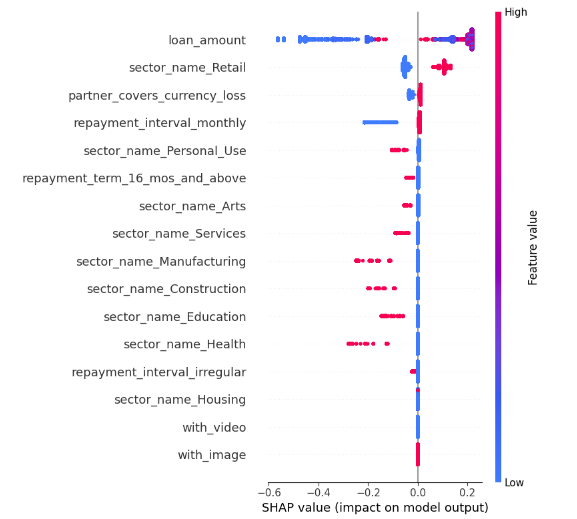

# Recommender Engine

In [284]:
# 1. Copy df_ph_loans_cleaned to df_model and get info
df_model = df_ph_loans_cleaned.copy(deep=True)
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378580 entries, 0 to 378579
Data columns (total 18 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   loan_id                          378580 non-null  int64  
 1   group_loan                       378580 non-null  int64  
 2   with_image                       378580 non-null  int64  
 3   with_video                       378580 non-null  int64  
 4   posted_time                      378580 non-null  object 
 5   is_expired                       378580 non-null  int64  
 6   loan_amount                      378580 non-null  float64
 7   loan_amount_bin                  378580 non-null  object 
 8   personal_use                     378580 non-null  int64  
 9   sector_name                      378580 non-null  object 
 10  loan_use                         377949 non-null  object 
 11  num_days_to_fully_fund           373550 non-null  float64
 12  fu

In [285]:
# 2. Drop columns
df_model.drop(columns=["posted_time", "loan_use", "partner_id", "country_name", "num_days_to_fully_fund", "funded_14_days_and_above"], inplace=True)

In [286]:
# 3. Set loan_id as index before dropping it
df_model.index = df_model["loan_id"]
df_model.drop(columns=["loan_id"], inplace=True)

In [287]:
# 4. 
df_model = df_model[df_model["is_expired"] == 0]
df_model.drop(columns=["is_expired"], inplace=True)
df_funded_only = pd.get_dummies(df_model, drop_first=False, dtype="int")

In [288]:
# 5. 
df_funded_only.columns = df_funded_only.columns.str.replace("\W", "_", regex=True)
df_funded_only.columns

Index(['group_loan', 'with_image', 'with_video', 'loan_amount', 'personal_use',
       'repayment_term_16_mos_and_above', 'partner_covers_currency_loss',
       'loan_amount_bin__24_999__250_0_', 'loan_amount_bin__250_0__450_0_',
       'loan_amount_bin__450_0__900_0_', 'loan_amount_bin__900_0__500000_0_',
       'sector_name_Agriculture', 'sector_name_Arts', 'sector_name_Clothing',
       'sector_name_Construction', 'sector_name_Education',
       'sector_name_Entertainment', 'sector_name_Food', 'sector_name_Health',
       'sector_name_Housing', 'sector_name_Manufacturing',
       'sector_name_Personal_Use', 'sector_name_Retail',
       'sector_name_Services', 'sector_name_Transportation',
       'sector_name_Wholesale', 'repayment_interval_bullet',
       'repayment_interval_irregular', 'repayment_interval_monthly'],
      dtype='object')

In [289]:
# 6. Put key features in a list
key_cols = ["loan_amount",
            "repayment_term_16_mos_and_above",
            "partner_covers_currency_loss",
            "with_image",
            "with_video",
            "repayment_interval_irregular",
            "repayment_interval_monthly",
            'sector_name_Arts', 'sector_name_Construction',
            'sector_name_Education',
            'sector_name_Health', 'sector_name_Housing', 'sector_name_Manufacturing',
            'sector_name_Personal_Use', 'sector_name_Retail', 'sector_name_Services'
           ]

In [290]:
# 7. 
df_funded_only = df_funded_only[key_cols]
df_funded_only

,loan_amount,repayment_term_16_mos_and_above,partner_covers_currency_loss,with_image,with_video,repayment_interval_irregular,repayment_interval_monthly,sector_name_Arts,sector_name_Construction,sector_name_Education,sector_name_Health,sector_name_Housing,sector_name_Manufacturing,sector_name_Personal_Use,sector_name_Retail,sector_name_Services
loan_id,,,,,,,,,,,,,,,,
1737446,125.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
1756537,100.0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
913920,350.0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1
1634791,225.0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0
1346166,200.0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753238,975.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2204440,425.0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
1378767,975.0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


In [291]:
# 8. Save to csv
df_funded_only.to_csv("funded_loans_db.csv", index=True)

In [293]:
# 9. 
recommender = NearestNeighbors(metric='cosine')
recommender.fit(df_funded_only.to_numpy())

NearestNeighbors(metric='cosine')

In [294]:
# 10. 
test_data = df_funded_only.loc[1756537].values
test_data

array([100.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
         1.,   0.,   0.,   0.,   0.])

In [295]:
# 11.
num_recommendations = 5

In [296]:
# 12.
_, recommendations = recommender.kneighbors(test_data.reshape(1, -1), n_neighbors=num_recommendations)

In [297]:
# 13.
reco = recommendations[0].tolist()
reco

[149187, 98442, 26252, 149137, 212052]

In [298]:
# 14. 
funded_reco = []

In [299]:
# 15. 
if len(reco) > 1:
    for x in reco:
        funded_reco.append(df_funded_only.index.tolist()[x])
else:
    print("No similar matches.")

In [300]:
# 16.
funded_reco

[1385018, 1683498, 1484622, 1797848, 1823950]

In [301]:
# 17.
if len(funded_reco) > 1:
    for x in funded_reco:
        print(df_funded_only.loc[x])
        print()
else:
    print("No similar matches.")

loan_amount                        100.0
repayment_term_16_mos_and_above      0.0
partner_covers_currency_loss         1.0
with_image                           1.0
with_video                           0.0
repayment_interval_irregular         0.0
repayment_interval_monthly           1.0
sector_name_Arts                     0.0
sector_name_Construction             0.0
sector_name_Education                0.0
sector_name_Health                   0.0
sector_name_Housing                  1.0
sector_name_Manufacturing            0.0
sector_name_Personal_Use             0.0
sector_name_Retail                   0.0
sector_name_Services                 0.0
Name: 1385018, dtype: float64

loan_amount                        100.0
repayment_term_16_mos_and_above      0.0
partner_covers_currency_loss         1.0
with_image                           1.0
with_video                           0.0
repayment_interval_irregular         0.0
repayment_interval_monthly           1.0
sector_name_Arts          